In [1]:
import requests
import time
from IPython.display import HTML
from IPython.display import Image
import pylab as plt
import pandas as pd
from astroquery.ned import Ned
import matplotlib.image as mpimg
import os
from astropy import units as u
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Название Анализ согласия методов определения радиусов коротации в галактиках

Аннотация

В работе впервые статистически проверено попарное согласие различных способов определения радиусов коротации в дисках галактик. Рассмотрены как прямые методы, такие как классический метод Tremaine-Weinberg, так и непрямые методы, основанные на анализе динамических или химических особенностей в диске. Учтено, что подходы используют разные источники данных по газу, звездам и их кинематике. Данные о радиусах коротации были найдены в литературе или вычислялись нами самостоятельно там, где это было возможно. Сделаны общие выводы о надежности используемых в литературе методов и их согласии между собой. Составлен список галактик и радиусов коротации в них, которые надежно согласуются при использовании разных методов. На основе этого списка сделаны выводы о скорости спирального узора в галактиках и его связи с характеристиками галактик. Наконец, в случае более чем одного радиуса коротации проверены теоретические предсказания взаимного расположения разных частей узора друг относительно друга.

In [2]:
class SurveyCard(dict):
    # Overridden dict class which takes a dict
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=40%>"]
        for key, value in sorted(self.iteritems(), reverse=True):
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(value))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [3]:
import json
ascii_dict = json.loads(open("/home/amarch/Dropbox/Dropbox/article_spirals/data/all_results.json").readline())

In [4]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
def kpc_to_arcsec(kpc, dist=None):
    
    theta = 1*u.arcsec
    d_A = float(dist)*u.Mpc
    theta_radian = theta * np.pi / 180 / 3600
    distance_Mpc = d_A * theta_radian
    scale = distance_Mpc.value*1000. #kpc/arcsec
    return kpc/scale

In [6]:
from astroquery.ned import Ned
import tqdm

def gen_NED_names(names):
    names_set = {}
    for c in tqdm.tqdm_notebook(names, total=len(names)):
        try:
            if len(c) and c[0] == 'J':
                result_table = Ned.query_object('SDSS '+c)
            else:
                result_table = Ned.query_object(c)
                
            names_set[c] = result_table[0]['Object Name']
        except Exception as e:
            print(e, c)
    return names_set

Заведем набор данных для пересечения:

In [7]:
# total_crs = []

total_crs = load_obj('total_crs')

In [8]:
disc_r25_sizes = load_obj('disc_r25_sizes')

# Данные

## наши обработанные спирали

TODO: надо только те, что вращаются в определенную сторону

In [30]:
path_to_ascii = '/mnt/sdb2/spirals_galfit/sample_big/ascii_data/'
dirpath_results_cuts = '/mnt/sdb2/spirals_galfit/sample_big/results_cuts/'
dirpath_results_cuts_stage2 = '/mnt/sdb2/spirals_galfit/sample_big/results_cuts_stage2/results_cuts_stage2/'

In [31]:
import json

# ascii_dict = load_obj('/mnt/sdb2/science/spirals/fourier-spiral-masks/notebooks/ascii_dict_pickled')
ascii_dict = json.loads(open("/home/amarch/Dropbox/Dropbox/article_spirals/data/all_results.json").readline())

In [32]:
from astropy.utils.data import get_pkg_data_filename

SDSS_SCALE = 0.396 # "/pix

def get_scale(galname):
#     return ascii_dict[galname]["scale[pc/'']"]
    return ascii_dict[galname]["leda_scale[pc/'']"]

def get_distance(galname):
    return ascii_dict[galname]['LD[Mpc]']

def is_stage2(galname):
    return galname in os.listdir(dirpath_results_cuts_stage2)

# centers = '/mnt/sdb2/science/spirals/fourier-spiral-masks/data/centers_deprojected.dat'
centers = '/mnt/sdb2/science/spirals/fourier-spiral-masks/data/new_centers.dat' #next run
tmp = pd.read_csv(centers, header=None, sep=' ')
centers = tmp.set_index(0).T.to_dict()

# def get_center_pixs(galname):
#     xcen = centers[galname][1]
#     ycen = centers[galname][2]
#     return xcen, ycen

# ничего не работает как надо, берем тупо середину
def get_center_pixs(galname):
    image_file = get_pkg_data_filename(dirpath_results_cuts_stage2 + galname + '/{}/diff_deprojected.fits'.format('g'))
    image_data = fits.getdata(image_file, ext=0)
    x,y = image_data.shape
    return y/2., x/2.

In [33]:
def get_arm_colors(galname, band='g'):
    arms = []
    path_ = dirpath_results_cuts_stage2 + galname + '/{}/'.format(band)
    try:
        for fname in os.listdir(path_):
            if fname.startswith('arm_params_'):
                arm = fname.replace('.dat','').replace('arm_params_', '')
                arms.append(arm)
        return arms
    except:
        return []

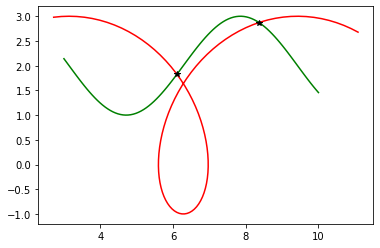

In [34]:
import numpy as np
import matplotlib.pyplot as plt
"""
Sukhbinder
5 April 2017

Based on:
"""

def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):
    """
INTERSECTIONS Intersections of curves.
   Computes the (x,y) locations where two curves intersect.  The curves
   can be broken with NaNs or have vertical segments.

usage:
x,y=intersection(x1,y1,x2,y2)

    Example:
    a, b = 1, 2
    phi = np.linspace(3, 10, 100)
    x1 = a*phi - b*np.sin(phi)
    y1 = a - b*np.cos(phi)

    x2=phi
    y2=np.sin(phi)+2
    x,y=intersection(x1,y1,x2,y2)

    plt.plot(x1,y1,c='r')
    plt.plot(x2,y2,c='g')
    plt.plot(x,y,'*k')
    plt.show()

    """
    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]


if __name__ == '__main__':

    # a piece of a prolate cycloid, and am going to find
    a, b = 1, 2
    phi = np.linspace(3, 10, 100)
    x1 = a*phi - b*np.sin(phi)
    y1 = a - b*np.cos(phi)

    x2=phi
    y2=np.sin(phi)+2
    x,y=intersection(x1,y1,x2,y2)
    plt.plot(x1,y1,c='r')
    plt.plot(x2,y2,c='g')
    plt.plot(x,y,'*k')
    plt.show()

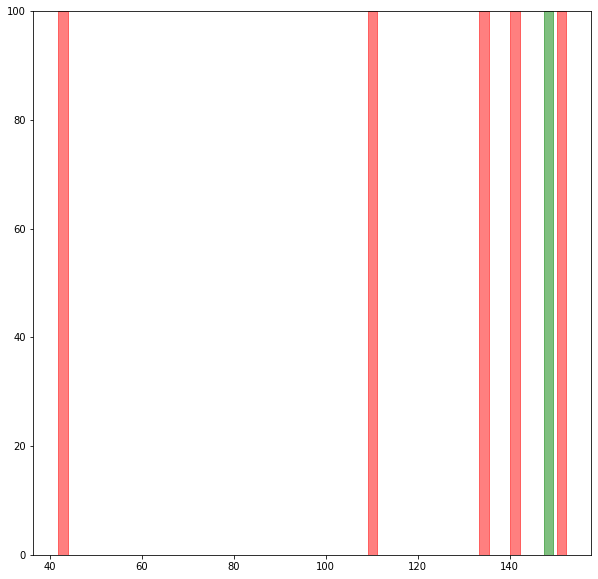

In [35]:
def find_closest(galname, arm='blue', band='g', resonances=True, dist_=None, window_size=10, smooth=False, x_window=500, savepath=None, stage=2, axes=None, is_arcsec=True):

    if stage == 1:
        dp = dirpath_results_cuts
    else:
        dp = dirpath_results_cuts_stage2
    
    # do this for not creaing new figure if arm not found
    path_ = dp + galname + '/g/'
    if not smooth:
        blue_arm = np.genfromtxt(path_ + 'arm_params_{}.dat'.format(arm))
    else:
        blue_arm = np.genfromtxt(path_ + 'smoothed_arm_params_{}.dat'.format(arm))
    
#     if axes is None:
#         fig, axes = plt.subplots(ncols=3, figsize=[34,10], sharey=True)
    

    path_ = dp + galname + '/{}/'.format(band)

    if not smooth:
        blue_arm = np.genfromtxt(path_ + 'arm_params_{}.dat'.format(arm))
    else:
        blue_arm = np.genfromtxt(path_ + 'smoothed_arm_params_{}.dat'.format(arm))

    blue_arm_xx = blue_arm[:, 5]
    blue_arm_yy = blue_arm[:, 7]
    dist = blue_arm[:, 1]
#         axes[ind].plot(dist, blue_arm_yy, 'o', color='red', label='$W_\mathrm{right}$', alpha=0.3)
#         axes[ind].plot(dist, blue_arm_xx, 's', color='blue', label='$W_\mathrm{left}$', alpha=0.3)

    if is_arcsec:
        dist = dist/ascii_dict[galname]["scale[pc/'']"]
        blue_arm_yy = blue_arm_yy/ascii_dict[galname]["scale[pc/'']"]
        blue_arm_xx = blue_arm_xx/ascii_dict[galname]["scale[pc/'']"]
        x_window_ = x_window/ascii_dict[galname]["scale[pc/'']"]
    else:
        x_window_ = x_window


    def smooth_window(xx,yy,x_window):
        x_max = max(xx)
        x_min = min(xx)
        res = []
        for p in np.linspace(x_max, x_min, 100):
            slice_ = [_[1] for _ in zip(xx,yy) if (_[0] > p-x_window) and (_[0] < p+x_window)]
            if len(slice_) > 0:
                yp = np.mean(slice_)
                res.append([p, yp])
        return np.array(res)

    y_av = smooth_window(dist, blue_arm_yy, x_window_)
#         axes[ind].plot(y_av[:,0], y_av[:,1], '-', color='red')
    x_av = smooth_window(dist, blue_arm_xx, x_window_)
#         axes[ind].plot(x_av[:,0], x_av[:,1], '-', color='blue')

#     axes[ind].plot(x_av[:,0], np.abs(x_av[:,1]-y_av[:,1]), '-', color='blue')
        
        
    intersx,intersy = intersection(x_av[:,0], x_av[:,1],y_av[:,0], y_av[:,1])
    
#     d25 = np.exp(ascii_dict[galname]['leda_logd25'])*60.*ascii_dict[galname]["scale[pc/'']"]
#     cr_0 = [_[0] for _ in crs_points]
    for inter in intersx:
        
        ax.axvspan(inter-1,  inter+1, alpha=0.5, color=arm)
        
#         resid = abs(cr_0-inter)
#         if len(resid):
#             mi = resid.argmin()
#             closest = cr_0[mi]
#             axes.scatter(inter/d25, closest/d25, 10, color=crs_points[mi][3])
#             axes.errorbar(inter/d25, closest/d25, yerr=[[crs_points[mi][1]/d25],[crs_points[mi][2]/d25]], color=crs_points[mi][3])
#             if abs(closest-cr)/closest > 0.3:
#                 plt.annotate(galname + ' ' + arm, xy=(closest, cr))
    
#         axes[ind].plot(intersx,intersy, 'og', alpha=0.3, markersize=20)
    plt.ylim(0,100)
    if axes is None:
        plt.show()

fig = plt.figure(figsize=[10,10])
ax = plt.gca()
find_closest('PGC60459', arm='red', band='r', smooth=True, axes=ax)
find_closest('PGC60459', arm='green', band='r', smooth=True, axes=ax)


# uplim = max(ax.get_xlim()[1], ax.get_ylim()[1])
# lolim = min(ax.get_xlim()[0], ax.get_ylim()[0])

# plt.xlim(lolim, uplim)
# plt.ylim(lolim, uplim)
# plt.plot([lolim, uplim], [lolim, uplim], '--', color='grey', alpha=0.5)
plt.show()

In [36]:
get_arm_colors('PGC60459', band='r')

['green', 'red']

In [37]:
def arm_inters(galname, arm='blue', band='g', resonances=True, dist_=None, window_size=10, smooth=False, x_window=500, savepath=None, stage=2, axes=None, is_arcsec=True):

    if stage == 1:
        dp = dirpath_results_cuts
    else:
        dp = dirpath_results_cuts_stage2
    
    # do this for not creaing new figure if arm not found
    path_ = dp + galname + '/g/'
    if not smooth:
        blue_arm = np.genfromtxt(path_ + 'arm_params_{}.dat'.format(arm))
    else:
        blue_arm = np.genfromtxt(path_ + 'smoothed_arm_params_{}.dat'.format(arm))
    
#     if axes is None:
#         fig, axes = plt.subplots(ncols=3, figsize=[34,10], sharey=True)
    

    path_ = dp + galname + '/{}/'.format(band)

    if not smooth:
        blue_arm = np.genfromtxt(path_ + 'arm_params_{}.dat'.format(arm))
    else:
        blue_arm = np.genfromtxt(path_ + 'smoothed_arm_params_{}.dat'.format(arm))

    blue_arm_xx = blue_arm[:, 5]
    blue_arm_yy = blue_arm[:, 7]
    dist = blue_arm[:, 1]
#         axes[ind].plot(dist, blue_arm_yy, 'o', color='red', label='$W_\mathrm{right}$', alpha=0.3)
#         axes[ind].plot(dist, blue_arm_xx, 's', color='blue', label='$W_\mathrm{left}$', alpha=0.3)

    if is_arcsec:
        dist = dist/ascii_dict[galname]["scale[pc/'']"]
        blue_arm_yy = blue_arm_yy/ascii_dict[galname]["scale[pc/'']"]
        blue_arm_xx = blue_arm_xx/ascii_dict[galname]["scale[pc/'']"]
        x_window_ = x_window/ascii_dict[galname]["scale[pc/'']"]
    else:
        x_window_ = x_window


    def smooth_window(xx,yy,x_window):
        x_max = max(xx)
        x_min = min(xx)
        res = []
        for p in np.linspace(x_max, x_min, 100):
            slice_ = [_[1] for _ in zip(xx,yy) if (_[0] > p-x_window) and (_[0] < p+x_window)]
            if len(slice_) > 0:
                yp = np.mean(slice_)
                res.append([p, yp])
        return np.array(res)

    y_av = smooth_window(dist, blue_arm_yy, x_window_)
#         axes[ind].plot(y_av[:,0], y_av[:,1], '-', color='red')
    x_av = smooth_window(dist, blue_arm_xx, x_window_)
#         axes[ind].plot(x_av[:,0], x_av[:,1], '-', color='blue')

#     axes[ind].plot(x_av[:,0], np.abs(x_av[:,1]-y_av[:,1]), '-', color='blue')
        
        
    intersx,intersy = intersection(x_av[:,0], x_av[:,1],y_av[:,0], y_av[:,1])
    
#     d25 = np.exp(ascii_dict[galname]['leda_logd25'])*60.*ascii_dict[galname]["scale[pc/'']"]
#     cr_0 = [_[0] for _ in crs_points]
    return intersx


arm_inters('PGC60459', arm='red', band='r', smooth=True, axes=ax)

array([151.20287399, 141.18236533, 134.44619112, 110.09750498,
        42.84233941])

In [38]:
spirals_galset = os.listdir('/mnt/sdb2/spirals_galfit/sample_big/results_cuts_stage2/results_cuts_stage2/')

In [39]:
data_set = {}
for gal in spirals_galset:
    try:
        data_set[gal] = []
        for band in ['g', 'r', 'i']:
            band_crs = []
            for arm in get_arm_colors(gal, band=band):
                crs = arm_inters(gal, arm=arm, band=band, smooth=True)
                for cr in crs:
                    band_crs.append([cr, arm])
            data_set[gal].append(band_crs)
    except Exception as e:
        print(e, gal)

"scale[pc/'']" PGC37617
"scale[pc/'']" PGC4946


In [40]:
total_crs.append([{'cr' : data_set, 
                            'method' : 'spiral', 
                            'dist' : None, 
                            'links': None, 
                            'name' : 'our spirals',
                            'bands' : 'r',
                            'kind' : 'stellar',
                            'bar' : False}])

Добавим визуально определенные наши, где кажется все согласуется:

In [26]:
data_set = {'PGC42168' : [(50, 3, 3)],
'PGC5974' : [(245, 15, 14)],
 'PGC5139' : [(36,6,6)],
 'PGC8974' : [(65,15,15)],
 'PGC24531' : [(20,2,2),(32,2,2)],
 'PGC27777' : [(38,2,2), (53,2,2)],
 'PGC31883' : [(50,6,6), (87,10,10)],
 'PGC31968' : [(115,5,5)],
 'PGC43195' : [(28,3,3)],
 'PGC37229' : [(70,5,5)],
 'PGC37845' : [(40,4,4), (61,2,2)],
 'PGC45093' : [(24,3,3)], #mb not
 'PGC49555' : [(127,8,8)],
 'PGC49514' : [(38,3,3), (76,3,3), (97,4,4)],
 'PGC49881' : [(48,3,3)],
 'PGC51795' : [(20,2,2), (73,3,3)],
 'PGC54018' : [(22,2,2)],
 'PGC54445' : [(44,7,7)],
 'PGC72387' : [(84,5,5)],
 'PGC33325' : [(17,2,2)],
 'PGC44032' : [(13,2,2), (29,2,2)]}

In [27]:
total_crs.append([{'cr' : data_set, 
                    'method' : 'spirals', 
                    'dist' : None, 
                    'links': None, 
                    'name' : 'gri spirals',
                    'bands' : 'g,r,i',
                    'kind' : 'stellar',
                    'bar' : False}])

## Font-Beckman

Стоит взять цитату из F-B 2011 года, где они исчерпывающе описывают все известное:

> Methods to measure pattern speeds can use morphology,
kinematics, or both. Perhaps the best known, due to Tremaine
& Weinberg (1984), combines stellar column density, via
photometric imaging, and line of sight velocity, via long-slit
spectra parallel to the disk major axis. It has been used on
the stellar component of 17 galaxies (see Corsini 2011 for a
review). As it assumes continuity of the emitting source, opinion
is divided on whether it can also be applied using interstellar
gas as shocks; phase conversions of gas and star formation may
each weaken this assumption, but Zimmer et al. (2004) applied
it to CO emission line maps of three galaxies and Rand &
Wallin (2004) applied it to six more, while Hernandez et al.
(2005) used an Hα emission line map of NGC 4321, Fathi
et al. (2007) used a similar map of NGC 6946, and Fathi
et al. (2009) applied this method on Fabry–Perot data for 10
galaxies. Other methods used have included predicting the H i
velocity field using measured gravitational potential distribution
(Sanders & Tubbs 1980; England et al. 1990; Garc´ıa-Burillo et al. 1993) to derive the pattern speed, and the method of
Canzian (1993) which places corotation where the azimuthal
non-circular motion pattern changes from singlet to triplet.
This was applied to a H i velocity field by Canzian & Allen
(1997) to NGC 4321, and we will compare their work to ours
below. Sempere et al. (1995) presented a variant on the Canzian
method, also related to the technique described here. Buta &
Zhang (2009) used the potential-density phase shift to find
corotation for 153 galaxies, which we will use for comparison
with our results. In addition, Vega Beltran et al. (1998) identified
resonances using rings, Athanassoula (1992) showed that dust
lanes marked offset shocks in gas flows, and Puerari & Dottori
(1997) pinned down corotation using two-color photometry. For
an overview of methods for bar pattern speeds see Rautiainen
et al. (2008).

Пойдем по череди, а потом добавим работы позднее 2011 года.

Галактики с данными по CR из работ Font-Beckman:

In [41]:
# https://iopscience.iop.org/article/10.1088/2041-8205/741/1/L14/pdf

tmp = '''428	SAB(s)m	This work	5.8 +or- 2.2	17.6 +or- 3.1	59.5 +or- 3.9	115.6 +or- 2.2	144.7 +or- 2.2				Other works			54.8^a				
3344	SAB(r)bc	This work		58.7 +or- 3.8	74.4 +or- 1.9	102.8 +or- 2.3  	127.3 +or- 2.3				Other works	26.2 +or- 5.2^b	57.7 +or- 10.4^b		102.4 +or- 13.1^b	126.0^+15.7_- 10.4^b	160.1^+18.4_- 13.1^b	
3726	SAB(r)c	This work	25.2 +or- 2.8	63.0 +or- 2.9	100.1 +or- 3.2 		122.4 +or- 3.2				Other works	21.9 +or- 1.0^a	65.2 +or- 2.1^a		114.1^a			
5427	SA(s)c	This work		15.7 +or- 2.3	23.5 +or- 0.8		 47.3 +or- 2.1	64.5 +or- 0.9			Other works	7.3 +or- 0.2^a			38.0^a		63.3^a	
5676	SA(rs)bc	This work	18.4 +or- 1.9	32.1 +or- 1.7	54.4 +or- 2.4		76.5 +or- 4.6			Other works	23.2^a	38.2^a		61.2^a			
7479	SB(s)c	This work	13.2 +or- 2.8	35.3 +or- 5.2	55.8 +or- 4.8	80.8 +or- 4.9	 98.3 +or- 3.1	123.1 +or- 3.0			Other works	6.3^a	23^f	57.7^a;50^d;55^f;57^g	85^e	94^+6_- 25^c;95^d;74-106^h		
7741	SB(s)cd	This work	36.8 +or- 3.6 		66.3 +or- 1.9	77.4 +or- 4.5	 95.3 +or- 2.7				Other works		51.9 +or- 6.8^a			109^+?_- 17^c		'''

cr_font1 = ['NGC'+l.split('\t')[0] for l in tmp.split('\n')]

In [42]:
cr_font1 = {'NGC428' : [(5.8,2.2), (17.6,3.1), (59.5,3.9), (115.6,2.2), (144.7,2.2)],
'NGC3344' : [(58.7,3.8), (74.4,1.9), (102.8,2.3), (127.3,2.3)],
'NGC3726' : [(25.2,2.8), (63.0,2.9), (100.1,3.2), (122.4, 3.2)],
'NGC5427' : [(15.7,2.3), (23.5,0.8), (47.3,2.1), (64.5,0.9)],
'NGC5676' : [(18.4,1.9), (32.1,1.7), (54.4,2.4), (76.5,4.6)],
'NGC7479' : [(13.2,2.8), (35.3,5.2), (55.8,4.8), (80.8,4.9), (98.3,3.1), (123.1,3.0)],
'NGC7741' : [(36.8,3.6), (66.3,1.9), (77.4,4.5), (95.3,2.7)]}

In [43]:
cr_font1['NGC4321'] = [#(110.,0),  # NGC4321, убрал все не F-B тогда
                          #(97., 0.), # все пики более-менее значимы, вот только кажется у них именно спиральная коротация ближе к 150-160, а у нас туда не дотянулось. А еще не оч. понятно, хорошо ли развернуто
                          #(71.8,0), 
                          #(123.1,0), 
                          #(150.,0), 
                          #(42.,0.), 
                          (31.8, 3.4), 
                          (33.1, 10.6), 
                          (76.5, 6.8), 
                          (108.8, 10.3), 
                          (97.0, 2.2), 
                          (123.5, 2.1), 
                          (147.9, 10.7), 
                          (166.3, 6.0), 
                          (188.2, 9.5)] # для этой я сперва взял референсные, а не те, что получились у F-B, но наверное так неверно и надо только F-B  

https://iopscience.iop.org/article/10.1088/0067-0049/210/1/2/pdf

In [44]:
tmp = '''508 5 2 7.98 ± 1.8(ILR:4) 25.6 ± 1.8(CR:1) 37.3 ± 2.4(CR:2) 51.8 ± 2.3(CR:3) 65.9 ± 4.1(CR:4) – – 763 4 1 40.6 ± 3.7(CR:1) 51.9 ± 1.9(CR:2) 98.6 ± 1.9(CR:3) 129.1 ± 1.9(CR:4) – – – 1256 5 0 10.9 ± 1.9(CR:1) 36.6 ± 3.0(CR:2) 58.7 ± 1.7(CR:3) 90.7 ± 4.4(CR:4) 113.7 ± 6.3(CR:5) – – 1317 4 2 10.5 ± 1.5(CR:1) 26.3 ± 5.1(CR:2) 48.2 ± 1.5(CR:3) 66.1 ± 2.3(CR:4) – – – 1437 4 1 4.1 ± 1.9(ILR:2) 31.3 ± 3.8(CR:1) 44.2 ± 3.5(CR:2) 57.2 ± 2.7(CR:3) – – – 1736 5 0 5.8 ± 2.2(CR:1) 29.7 ± 3.6(CR:2) 56.1 ± 2.1(CR:3) 84.4 ± 2.3(CR:4) 102.1 ± 2.1(CR:5) – – 1913 4 0 36.1 ± 1.4(CR:1) 47.6 ± 1.3(CR:2) 96.0 ± 1.4(CR:3) 118.5 ± 3.8(CR:4) – – – 2080 2 0 32.1 ± 1.3(CR:1) 74.8 ± 3.4(OLR:1) – – – – – 2141 5 0 13.5 ± 1.8(CR:1) 38.3 ± 1.9(CR:2) 47.9 ± 1.1(CR:3) 61.6 ± 1.8(CR:4) 70.2 ± 2.2(CR:5) – – 2193 3 1 26.6 ± 4.6(CR:1) 47.6 ± 1.7(CR:2) 55.6 ± 1.7(CR:3) – – – – 2855 4 1 11.5 ± 1.7(CR:1) 41.2 ± 6.4(CR:2) 70.4 ± 6.3(OLR:1) 95.5 ± 5.9(CR:3) – – – 3013 7 2 9.0 ± 2.4(ILR:3) 43.6 ± 1.5(CR:1) 53.2 ± 3.7(CR:2) 67.9 ± 2.6(CR:3) 76.5 ± 3.2(CR:4) 86.9 ± 2.8(CR:5) 100.1 ± 2.7(OLR:3) 3273 4 0 7.4 ± 3.2(CR:1) 31.9 ± 3.7(CR:2) 73.9 ± 4.4(CR:3) 99.4 ± 6.3(CR:4) – – – 3463 4 3 8.9 ± 3.8(CR:1) 21.7 ± 4.4(CR:2) 45.5 ± 7.6(CR:3) 68.7 ± 5.1(CR:4) – – – 3574 3 2 5.4 ± 1.9(CR:1) 16.8 ± 3.0(CR:2) 42.6 ± 7.4(CR:3) – – – – 3685 4 0 16.8 ± 1.3(CR:1) 27.7 ± 1.7(CR:2) 49.5 ± 1.4(CR:3) 55.7 ± 1.9(CR:4) – – – 3691 4 1 10.3 ± 2.3(CR:1) 24.3 ± 2.4(CR:2) 42.0 ± 2.0(CR:3) 54.2 ± 2.3(CR:4) – – – 3709 3 1 7.9 ± 1.5(CR:1) 19.6 ± 1.5(CR:2) 24.6 ± 1.7(CR:3) – – – – 3734 4 2 17.6 ± 1.3(CR:1) 34.8 ± 1.9(CR:2) 41.9 ± 1.7(CR:3) 64.3 ± 1.7(CR:4) – – – 3740 5 0 47.5 ± 1.8(CR:1) 61.3 ± 2.2(CR:2) 69.8 ± 1.8(CR:3) 81.5 ± 1.5(CR:4) 89.6 ± 1.5(CR:5) – – 3809 7 2 35.4 ± 1.8(CR:1) 62.0 ± 4.9(CR:2) 82.5 ± 2.9(CR:3) 91.9 ± 2.1(CR:4) 107.3 ± 3.1(CR:5) 119.9 ± 3.6(CR:6) 128.4 ± 2.5(CR:7) 3826 2 0 13.9 ± 1.8(CR:1) 39.2 ± 1.4(OLR:1) – – – – – 3876 2 1 33.9 ± 2.2(CR:1) 59.1 ± 3.0(CR:2) – – – – – 3915 1 0 15.3 ± 2.3(CR:1) – – – – – – 4165 5 1 16.4 ± 1.2(CR:1) 25.6 ± 1.6(CR:2) 48.9 ± 2.0(CR:3) 65.3 ± 1.2(CR:4) 75.4 ± 1.2(CR:5) – – 4273 4 0 7.7 ± 1.8(ILR:3) 31.8 ± 4.1(CR:1) 47.4 ± 3.2(CR:2) 79.6 ± 1.8(CR:3) – – – 4284 5 2 10.8 ± 4.8(CR:1) 31.4 ± 6.4(CR:2) 52.9 ± 1.9(CR:3) 68.1 ± 3.9(CR:4) 93.8 ± 6.5(CR:5) – – 4325 3 1 16.6 ± 1.7(CR:1) 49.4 ± 2.5(CR:2) 67.2 ± 2.4(CR:3) – – – – 4422 4 1 8.9 ± 1.2(ILR:3) 24.8 ± 1.2(CR:1) 36.5 ± 2.4(CR:2) 44.3 ± 1.5(CR:3) – – – 4555 3 1 13.0 ± 2.6(CR:1) 28.0 ± 2.6(CR:2) 35.3 ± 2.6(CR:3) – – – – 4936 7 1 16.9 ± 1.8(CR:1) 34.8 ± 1.8(CR:2) 70.8 ± 2.1(CR:3) 82.6 ± 1.8(CR:4) 102.2 ± 1.8(CR:5) 112.3 ± 1.8(CR:6) 137.7 ± 1.7(OLR:3) 5175 3 1 6.7 ± 2.9(CR:1) 15.6 ± 4.4(CR:2) 35.3 ± 3.6(CR:3) – – – – 5228 4 0 16.6 ± 1.3(CR:1) 30.4 ± 1.3(CR:2) 50.1 ± 1.6(CR:3) 59.7 ± 1.3(OLR:2) – – – 5251 6 2 12.9 ± 1.6(CR:1) 47.4 ± 2.3(CR:2) 70.2 ± 2.0(CR:3) 87.4 ± 2.1(CR:4) 102.6 ± 2.6(CR:5) 110.8 ± 2.3(CR:6) – 5253 4 2 43.2 ± 2.6(CR:1) 58.8 ± 3.7(CR:2) 70.4 ± 3.1(CR:3) 82.9 ± 3.4(CR:4) – – – 5303 4 2 16.0 ± 4.6(CR:1) 35.2 ± 6.2(CR:2) 48.7 ± 2.5(CR:3) 71.7 ± 2.4(CR:4) – – – 5319 5 2 9.3 ± 1.1(CR:1) 16.2 ± 1.2(CR:2) 21.8 ± 1.2(CR:3) 25.8 ± 1.2(CR:4) 33.1 ± 2.8(CR:5) – – 5414 6 0 19.3 ± 3.1(CR:1) 33.0 ± 2.1(CR:2) 51.1 ± 1.8(CR:3) 62.0 ± 3.4(CR:4) 77.0 ± 1.3(CR:5) 92.3 ± 2.3(CR:6) – 5510 6 1 13.6 ± 1.6(CR:1) 30.8 ± 1.6(CR:2) 36.7 ± 1.6(CR:3) 46.7 ± 2.4(CR:4) 54.4 ± 1.6(CR:5) 66.5 ± 1.6(OLR:2) – 5532 5 4 7.0 ± 1.6(CR:1) 16.3 ± 3.3(CR:2) 34.7 ± 4.8(CR:3) 54.3 ± 1.7(CR:4) 76.7 ± 1.8(CR:4) – – 5786 5 1 20.6 ± 2.1(ILR:1) 29.0 ± 3.5(CR:1) 43.6 ± 8.7(CR:2) 63.0 ± 1.9(CR:3) 80.1 ± 6.0(CR:4) – – 5840 5 1 31.6 ± 4.2(CR:1) 60.9 ± 5.4(CR:2) 79.7 ± 1.6(CR:3) 93.1 ± 1.6(CR:4) 120.6 ± 1.6(OLR:2) – – 5842 3 1 15.5 ± 2.0(CR:1) 23.4 ± 1.5(CR:2) 66.4 ± 6.1(CR:3) – – – – 5982 5 1 11.7 ± 1.8(ILR:4) 52.6 ± 3.5(CR:1) 68.3 ± 3.5(CR:2) 80.0 ± 2.8(CR:3) 96.2 ± 4.6(CR:4) – – 6118 6 2 9.9 ± 2.2(CR:1,ILR:4) 19.2 ± 2.5(CR:2) 29.1 ± 2.8(CR:3) 37.6 ± 2.2(CR:4) 43.7 ± 1.7(CR:5) 66.6 ± 1.6(OLR:4) – 6277 4 1 8.3 ± 1.3(CR:1) 23.6 ± 1.4(CR:2) 33.2 ± 1.4(CR:3) 47.5 ± 1.4(OLR:2) – – – 6521 4 2 11.0 ± 2.1(CR:1) 21.0 ± 1.6(CR:2) 27.9 ± 1.8(CR:3) 41.4 ± 3.7(CR:4) – – – 6523 2 1 4.6 ± 2.6(CR:1) 10.9 ± 2.1(CR:2) – – – – – 6537 5 2 35.8 ± 2.5(CR:1) 59.8 ± 2.5(CR:2) 105.8 ± 3.2(CR:3) 122.0 ± 3.1(CR:4) 143.7 ± 2.5(OLR:3) – – 6702 3 2 4.5 ± 1.7(CR:1) 10.5 ± 1.7(CR:2) 20.8 ± 1.9(CR:3) – – – – 6778 5 2 13.0 ± 6.2(CR:1) 34.9 ± 4.2(CR:2) 63.0 ± 3.0(CR:3) 75.2 ± 2.0(CR:4) 88.8 ± 4.5(CR:5) – – 7021 3 1 7.6 ± 1.9(CR:1) 18.5 ± 2.0(CR:2) 39.4 ± 1.9(CR:3) – – – – 7045 3 1 43.9 ± 1.1(CR:1) 54.2 ± 2.4(CR:2) 85.4 ± 1.2(CR:3) – – – – 7154 5 1 18.1 ± 2.1(CR:1) 46.3 ± 2.1(CR:2) 63.4 ± 2.7(CR:3) 135.3 ± 2.1(CR:4) 187.0 ± 5.3(CR:5) – – 7323 5 2 13.8 ± 2.7(CR:1) 44.7 ± 2.8(CR:2) 92.4 ± 7.4(CR:3) 117.7 ± 2.7(CR:4) 130.1 ± 3.1(CR:5) – – 7420 6 2 4.6 ± 1.0(CR:1) 26.6 ± 1.0(CR:2) 36.1 ± 3.1(CR:3) 49.9 ± 1.1(CR:4) 60.4 ± 2.3(CR:5) 68.0 ± 1.0(CR:6) – 7766 5 1 15.8 ± 1.0(CR:1) 37.3 ± 1.9(CR:2) 51.6 ± 1.6(CR:3) 60.0 ± 4.1(CR:4) 89.6 ± 1.0(CR:5) – – 7831 5 0 4.7 ± 1.0(CR:1) 17.8 ± 1.0(CR:2) 41.3 ± 3.6(CR:3) 53.2 ± 1.0(CR:4) 63.0 ± 1.0(CR:5) – – 7853 3 0 41.7 ± 1.1(CR:1) 54.5 ± 1.7(CR:2) 87.1 ± 3.5(CR:3) – – – – 7861 3 0 15.2 ± 1.5(CR:1) 31.1 ± 2.6(CR:2) 37.1 ± 1.5(CR:3) – – – – 7876 3 0 19.6 ± 1.5(CR:1) 28.7 ± 1.9(CR:2) 43.9 ± 2.1(CR:3) – – – – 7901 4 1 15.6 ± 1.6(ILR:3) 48.6 ± 5.8(CR:1) 58.0 ± 1.7(CR:2) 80.4 ± 2.9(CR:3) – – – 7985 5 3 12.6 ± 2.3(CR:1) 27.6 ± 2.3(CR:2) 38.3 ± 5.3(CR:3) 54.5 ± 3.5(CR:4) 72.5 ± 8.1(CR:5) – – 8334 7 1 12.6 ± 1.0(CR:1) 28.8 ± 1.0(CR:2) 47.0 ± 1.0(CR:3) 71.7 ± 1.0(CR:4) 89.7 ± 1.0(OLR:3) 129.5 ± 1.0(OLR:4) 205.1 ± 1.0(CR:5) 8403 6 0 30.8 ± 2.0(CR:1) 44.5 ± 2.1(CR:2) 51.7 ± 2.8(CR:3) 70.4 ± 2.2(CR:4) 86.6 ± 5.4(CR:5) 105.9 ± 3.8(CR:6) – 8490 5 0 9.4 ± 2.5(CR:1) 19.3 ± 2.1(CR:2) 31.6 ± 3.2(CR:3) 49.5 ± 2.9(CR:4) 67.7 ± 2.8(OLR:2) – – 8709 5 0 17.2 ± 1.9(CR:1) 27.9 ± 1.4(CR:2) 50.0 ± 1.4(CR:3) 73.9 ± 1.4(CR:4) 92.7 ± 4.7(CR:5) – – 8852 3 1 10.0 ± 3.1(CR:1) 26.8 ± 1.3(CR:2) 32.7 ± 1.3(CR:3) – – – – 8937 4 2 15.2 ± 3.0(CR:1) 25.2 ± 2.1(CR:2) 33.3 ± 3.0(CR:3) 47.5 ± 2.6(CR:4) – – – 9179 6 2 19.5 ± 1.4(CR:1) 34.4 ± 1.5(CR:2) 48.1 ± 3.0(CR:3) 74.3 ± 3.4(CR:4) 100.8 ± 1.4(CR:5) 144.7 ± 1.4(CR:6) – 9248 4 2 11.6 ± 2.1(CR:1) 17.4 ± 2.1(CR:2) 22.3 ± 2.4(CR:3) 30.4 ± 2.2(CR:4) – – – 9358 3 1 14.7 ± 1.9(CR:1) 30.4 ± 2.4(CR:2) 39.3 ± 3.1(CR:3) – – – – 9363 3 0 36.7 ± 1.2(CR:1) 47.4 ± 1.2(CR:2) 62.0 ± 3.6(CR:3) – – – – 9366 4 2 11.6 ± 3.1(CR:1) 21.3 ± 1.6(CR:2) 36.9 ± 5.6(CR:3) 47.2 ± 2.6(CR:4) – – – 9465 3 1 21.5 ± 2.0(CR:1) 28.1 ± 1.5(CR:2) 47.7 ± 1.5(CR:3) – – – – 9736 2 1 27.5 ± 2.8(CR:1) 56.1 ± 3.2(CR:2) – – – – – 9753 2 1 12.2 ± 3.8(CR:1) 30.6 ± 1.9(CR:2) – – – – – 9866 1 0 31.2 ± 4.9(CR:1) – – – – – – 9943 5 2 19.1 ± 2.8(CR:1) 34.4 ± 4.2(CR:2) 52.2 ± 2.0(CR:3) 59.7 ± 1.7(CR:4) 69.7 ± 1.7(CR:5) – – 9969 6 3 27.7 ± 2.8(CR:1) 40.1 ± 2.3(CR:2) 57.3 ± 5.8(CR:3) 67.2 ± 1.6(CR:4) 82.3 ± 7.3(CR:5) 105.5 ± 4.3(CR:6) – 10075 5 2 9.7 ± 1.5(CR:1) 35.6 ± 2.0(CR:2) 54.2 ± 1.5(CR:3) 93.2 ± 5.5(CR:4) 127.5 ± 1.5(CR:5) – – 10359 3 0 16.6 ± 1.4(CR:1) 32.7 ± 3.6(CR:2) 58.3 ± 2.3(CR:3) – – – – 10445 3 0 6.0 ± 2.2(CR:1) 28.5 ± 1.5(CR:2) 55.3 ± 3.0(OLR:2) – – – – 10470 5 2 11.3 ± 1.4(CR:1) 35.6 ± 2.0(CR:2) 43.9 ± 1.5(CR:3) 57.8 ± 3.4(CR:4) 65.7 ± 1.5(CR:5) – – 10502 3 1 34.1 ± 3.1(CR:1) 48.8 ± 1.7(CR:2) 68.4 ± 4.4(CR:3) – – – – 10521 6 2 12.6 ± 1.4(CR:1) 24.3 ± 1.4(CR:2) 38.0 ± 1.4(CR:3) 49.5 ± 1.7(CR:4) 55.4 ± 1.7(CR:5) 64.1 ± 3.6(CR:6) – 10546 4 2 28.1 ± 1.5(CR:1) 38.9 ± 3.3(CR:2) 47.5 ± 1.5(CR:3) 55.7 ± 1.5(CR:4) – – – 10564 3 0 8.8 ± 1.4(CR:1) 45.6 ± 1.5(CR:2) 81.2 ± 2.6(CR:3) – – – – 10652 2 0 12.4 ± 1.4(CR:1) 22.9 ± 1.4(CR:2) – – – – – 10757 2 0 12.4 ± 1.3(CR:1) 22.5 ± 1.0(CR:2) – – – – – 10897 5 0 7.5 ± 1.9(CR:1) 19.0 ± 2.0(CR:2) 26.3 ± 2.8(CR:3) 36.4 ± 2.1(CR:4) 42.6 ± 1.8(OLR:2) – – 11012 4 1 21.8 ± 1.8(CR:1) 37.2 ± 1.1(CR:2) 56.8 ± 1.6(CR:3) 89.3 ± 1.5(CR:4) – – – 11124 4 0 11.1 ± 2.8(CR:1) 25.4 ± 1.4(CR:2) 48.3 ± 2.7(CR:3) 59.5 ± 1.3(CR:4) – – – 11218 6 3 9.8 ± 1.7(CR:1) 22.5 ± 1.7(CR:2) 32.0 ± 4.1(CR:3) 48.6 ± 4.0(CR:4) 61.8 ± 3.1(CR:5) 76.4 ± 1.8(CR:6) – 11283 5 1 4.0 ± 1.4(CR:1) 12.6 ± 1.5(CR:2) 24.1 ± 1.5(CR:3) 30.7 ± 1.8(CR:4) 38.4 ± 2.6(OLR:3) – – 11407 5 3 3.3 ± 1.7(CR:1) 9.5 ± 2.2(CR:2) 20.3 ± 1.5(CR:3) 31.4 ± 1.8(CR:4) 64.9 ± 2.3(CR:5) – – 11466 3 1 20.2 ± 4.9(CR:1) 32.8 ± 2.9(CR:2) 52.2 ± 1.0(CR:3) – – – – 11557 5 0 9.1 ± 1.5(CR:1) 19.0 ± 1.4(CR:2) 32.4 ± 2.6(CR:3) 49.0 ± 3.2(CR:4) 56.6 ± 1.7(CR:5) – – 11861 5 1 7.6 ± 3.6(CR:1) 22.3 ± 2.7(CR:2) 37.8 ± 3.7(CR:3) 67.3 ± 3.7(CR:4) 88.6 ± 3.1(OLR:3) – – 11872 4 2 5.8 ± 2.1(CR:1) 19.9 ± 2.8(CR:2) 30.8 ± 2.4(CR:3) 57.9 ± 2.1(OLR:3) – – – 11914 5 3 17.0 ± 5.8(CR:1) 31.4 ± 4.1(CR:2) 48.8 ± 2.2(CR:3) 67.4 ± 2.1(CR:4) 78.5 ± 4.1(CR:5) – – 12276 3 1 13.8 ± 1.3(CR:1) 21.8 ± 1.3(CR:2) 27.4 ± 1.3(CR:3) – – – – 12343 5 0 12.7 ± 2.5(CR:1) 36.3 ± 3.9(CR:2) 52.4 ± 3.3(CR:3) 75.1 ± 3.9(CR:4) 91.1 ± 4.3(CR:5) – – 12754 6 1 28.6 ± 1.4(CR:1) 46.5 ± 1.4(CR:2) 69.6 ± 7.3(CR:3) 83.7 ± 1.4(CR:4) 95.4 ± 3.9(CR:5) 106.3 ± 1.7(CR:6) –'''

In [45]:
tmp = tmp.replace(' ± ', '±')

In [46]:
import re

In [47]:
tmp = re.sub(r'\([^)]*\)', '', tmp)

In [48]:
cr_font2 = {}
for chunk in np.split(np.array(tmp.split(' ')), 104):
    ugc = chunk[0]
    res = chunk[3:]
    name = 'UGC'+ugc
    resonances = []
    for r in res:
        if r == '–':
            continue
        else:
            try:
                cr_,cr_err = r.split('±')
                resonances.append((float(cr_), float(cr_err)))
            except:
                print(chunk)
                1/0
    cr_font2[name] = resonances

In [49]:
# https://arxiv.org/pdf/1801.07476.pdf
# cr_font3 = ['NGC3433']

In [50]:
cr_font = dict(cr_font1)
cr_font.update(cr_font2)

Заведем общий набор данных для пересечения:

In [51]:
total_crs.append([{'cr' : cr_font, 
                            'method' : 'F-B', 
                            'dist' : None, 
                            'links': None, 
                            'name' : 'F-B works',
                            'bands' : 'Halpha, HI',
                  'kind' : 'ISM', 'bar' : False}])

## Tamburro 2008

https://arxiv.org/pdf/0810.2391.pdf

They measure offset HI→24 µm

Валерия сделала мне таблицу:

In [52]:
tamburro = '''Obj.name             Corot.radius(arcmin)    Error
NGC2403               3.64                   0.39
NGC2841               2.576                  0.092
NGC3031               8.349                  5.822
NGC3184               2.116                  0.712
NGC3351               1.978                  0.425
NGC3521               2.2                    0.216
NGC3621               2.24                   0.8
NGC3627               2.85                   0.475
NGC5055               4.408                  2.005
NGC5194               2.085                  1.065
NGC628                2.42                   0.674
NGC6946               2.941                  0.839
NGC7793               2.9                    1.214
NGC925                3.003                  0.286'''

tamburro = tamburro.split('\n')[1:]
tamburro_dict = {}
for t in tamburro:
    n,c,e = ' '.join(t.split()).split(' ')
    tamburro_dict[n] = [(60*float(c), 60*float(e))]

In [53]:
total_crs.append([{'cr' : tamburro_dict, 
#                 'method' : 'Tamburro', 
                'method' : 'offset', 
                'dist' : None, 
                'links': None, 
                'name' : 'Tamburro',
                'bands' : 'HI, 24mu',
                  'kind' : 'both', 'bar' : False}])

## Williams & Shu 1975

http://articles.adsabs.harvard.edu/pdf/1975ApJ...196..381R

Они смотрят на области HII и где они заканчиваются (но там и еще дополнительные рассуждения какие-то есть).

Данные подготовила Валерия

In [54]:
data = '''Obj.name     Corot.radius(kpc)         Distance(Mpc)
NGC157	9.0			24.0            
NGC224	14.0			0.69
NGC598	2.84			0.72
NGC925	7.7			6.8
NGC972	4.0			22.1
NGC1084	5.2			19.2
NGC1832	6.0  			25.3
NGC2403	4.8			3.25
NGC2903	5.4			7.9
NGC3031	9.7			3.2
NGC3109	6.0			2.2
NGC3389	2.6			15.0
NGC3521	7.3    			8.5
NGC3593	1.2			7.0
NGC4236	9.6			3.25
NGC4631	7.3			4.4
NGC5005	8.0			14.4
NGC5055	6.6			7.3
NGC5194	4.5			4.0
NGC5457	15.5			6.9
NGC6946	12.3			10.1
NGC7331	10.4			14.4
NGC7479	15.6			35.2
IC342		12.5			4.5'''

data = data.replace('\t\t', '\t').replace('\t\t', '\t').split('\n')[1:]
data_dict = {}
for t in data:
    print(t)
    n,c,dist = t.split('\t')
    
    theta = 1*u.arcsec
    d_A = float(dist)*u.Mpc
    theta_radian = theta * np.pi / 180 / 3600
    distance_Mpc = d_A * theta_radian
    scale = distance_Mpc.value*1000. #kpc/arcsec
    
    data_dict[n] = [(float(c)/scale, 0.)]

NGC157	9.0	24.0            
NGC224	14.0	0.69
NGC598	2.84	0.72
NGC925	7.7	6.8
NGC972	4.0	22.1
NGC1084	5.2	19.2
NGC1832	6.0  	25.3
NGC2403	4.8	3.25
NGC2903	5.4	7.9
NGC3031	9.7	3.2
NGC3109	6.0	2.2
NGC3389	2.6	15.0
NGC3521	7.3    	8.5
NGC3593	1.2	7.0
NGC4236	9.6	3.25
NGC4631	7.3	4.4
NGC5005	8.0	14.4
NGC5055	6.6	7.3
NGC5194	4.5	4.0
NGC5457	15.5	6.9
NGC6946	12.3	10.1
NGC7331	10.4	14.4
NGC7479	15.6	35.2
IC342	12.5	4.5


In [55]:
total_crs.append([{'cr' : data_dict, 
#                 'method' : 'Williams 1975', 
                'method' : 'morph', 
                'dist' : None, 
                'links': None, 
                'name' : 'Williams et al. (1975)',
                'bands' : 'HII',
                  'kind' : 'ISM', 'bar' : False}])

## Karapetyan SNs (NOT EXACTLY COROTATION)

https://arxiv.org/pdf/1808.03099.pdf (https://ui.adsabs.harvard.edu/abs/2018CoBAO..65..379K/abstract)

Они наблюдают "провал" в распределении сверхновых по диску на расстоянии CR (интерпретация с потухшим ЗО).

(ЕЩЕ РИС. 3 У НИХ КЛАССНЫЙ)

(НО ВООБЩЕ ИХ МЕТОД СКОРЕЕ НЕ РАБОТАЕТ, НЕТ ЯВНЫХ ВЫЧИСЛЕНИЙ CR)

>These radii were estimated using different methods. For example, Elmegreen et al. (1992) found clear evidences for the corotation radii in gas-rich galaxies, in the form of sharp endpoints
to star formation ridges and dust lanes in GD spirals. Verley et al.
(2007) used Fourier analysis and focused on the modes of the spiral arms, computing the torques between the gas and newly formed
stars (Hα emission), and the bulk of the optical matter (r-band),
which can be used to locate the corotation regions. Buta & Zhang
(2009) used the potential-density phase-shift method on deprojected H-band images to locate the corotation radii for a large number of spiral galaxies. Font et al. (2014) used the changes in direction of the radial component of the in-plane velocities, using the
emission in Hα, at the resonance radii to find corotations in disc
galaxies. F

In [4]:
# data = '''PGC043118 12 1 0 0.33 ± 0.05 Comer ´on et al. (2014)
# PGC040153 12 1 1 0.30 ± 0.05 Canzian & Allen (1997); Comer ´on et al. (2014)
# PGC038068 12 0 3 0.50 ± 0.08 Rautiainen et al. (2008); Buta & Zhang (2009)
# PGC030087 12 0 4 0.54 ± 0.13 Tamburro et al. (2008)
# PGC024531 12 0 1 0.87 ± 0.11 Verley et al. (2007); Font et al. (2014)
# PGC007525 12 0 2 0.30 ± 0.06 Verley et al. (2007)
# PGC005974 12 0 3 0.34 ± 0.09 Elmegreen et al. (1992); Egusa et al. (2009); Cedr´es et al. (2013)
# PGC054018 9 0 1 0.40 ± 0.04 Font et al. (2014)
# PGC050063 9 1 3 0.21 ± 0.03 0.45 ± 0.12 Elmegreen et al. (1992); Waller et al. (1997); Cedr´es et al. (2013)
# PGC042833 9 0 2 0.37 ± 0.04 0.57 ± 0.05 Buta & Zhang (2009); Font et al. (2014)
# PGC039578 9 0 4 0.34 ± 0.06 0.57 ± 0.07 Elmegreen et al. (1992); Gonzalez & Graham (1996); Buta & Zhang (2009)
# PGC038618 9 0 1 0.30 ± 0.01 0.54 ± 0.06 Buta & Zhang (2009)
# PGC037845 9 0 1 0.21 ± 0.06 0.40 ± 0.06 Buta & Zhang (2009)
# PGC037229 9 0 4 0.46 ± 0.08 Elmegreen et al. (1992); Buta & Zhang (2009)
# PGC036789 9 0 1 0.22 ± 0.06 Comer ´on et al. (2014)
# PGC036243 9 0 2 0.45 ± 0.13 Kranz et al. (2003); Buta & Zhang (2009)
# PGC034767 9 0 3 0.28 ± 0.03 Fridman et al. (2001)
# PGC032614 9 0 2 0.69 ± 0.02 0.83 ± 0.04 Font et al. (2014)
# PGC031968 9 0 1 0.26 ± 0.02 Font et al. (2014)
# PGC027074 9 0 1 0.30 ± 0.06 Comer ´on et al. (2014)
# PGC024111 9 1 1 0.65 ± 0.06 Comer ´on et al. (2014)
# PGC022279 9 0 1 0.16 ± 0.06 Verley et al. (2007)
# PGC002246 9 0 1 0.14 ± 0.06 0.57 ± 0.06 Verley et al. (2007)
# PGC002081 9 0 1 0.38 ± 0.05 Elmegreen et al. (1992); Sempere & Rozas (1997)
# PGC038031 6 1 0 0.22 ± 0.03 0.42 ± 0.02 Font et al. (2014); Comer ´on et al. (2014)
# PGC027723 6 1 0 0.17 ± 0.06 0.44 ± 0.06 Comer ´on et al. (2014)
# PGC012626 6 2 0 0.48 ± 0.03 Buta & Zhang (2009)
# PGC035594 5 0 1 0.32 ± 0.06 Font et al. (2014)
# PGC034836 5 0 2 0.12 ± 0.06 0.58 ± 0.06 Buta & Zhang (2009)
# PGC030010 5 0 1 0.17 ± 0.06 0.41 ± 0.06 Comer ´on et al. (2014)'''

# data = data.split('\n')[1:]
# data = [_.split(' ')[0] for _ in data]

Выборка похоже из https://cdsarc.unistra.fr/viz-bin/cat/J/A+A/544/A81

(https://ui.adsabs.harvard.edu/abs/2012A%26A...544A..81H/abstract)

In [56]:
names = []
with open('../J_A+A_544_A81_snsdss.dat.text', 'r') as inpf:
    for line in inpf.readlines():
        names.append(line[70:89].replace(' ', ''))

In [57]:
len(names)

3877

In [ ]:
for d in data:
    if d not in names:
        print(d)

In [65]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [11]:
# 1920A    128.81620  28.47478 :  19.   W    5.   N    II          : U  J083517.33+282824.2       128.82221  28.47339  0.00718 Sbc pec                  162.1 0.780  46.1 12.63
        
c1 = SkyCoord('128.81620d', '28.47478d')
c2 = SkyCoord('128.82221d', '28.47339d')
sep = c1.separation(c2)
sep

<Angle 0.00546279 deg>

In [12]:
# 2001bg   128.82858  28.46828    22.   E   19.   S    Ia               J083517.33+282824.2       128.82221  28.47339  0.00718 Sbc pec                  162.1 0.780  46.1 12.63

c1 = SkyCoord('128.82858d', '28.46828d')
c2 = SkyCoord('128.82221d', '28.47339d')
sep = c1.separation(c2)
sep

<Angle 0.00758075 deg>

In [13]:
27.29/82.

0.33280487804878045

In [14]:
# 1997bp   191.72396 -11.64256    14.1  W   19.8  S    Ia pec           J124654.73-113813.4       191.72804 -11.63706  0.00831 Sab                      115.2 0.792  39.7 12.49

c1 = SkyCoord('191.72396d', '-11.64256d')
c2 = SkyCoord('191.72804d', '-11.63706d')
sep = c1.separation(c2)
sep.arcsecond

24.474383211155974

In [15]:
24.47/57

0.42929824561403507

In [8]:
sqrt(19**2 +5**2)/82, sqrt(22**2 + 19**2)/82

(0.23959613054132317, 0.35449858179874716)

Ок, NED не умеет обрабатывать имена типа "J140153.80-012035.5", надо делать "SDSS J140153.80-012035.5".

In [62]:
from astroquery.ned import Ned
import tqdm

def gen_NED_names(names):
    names_set = {}
    for c in tqdm.tqdm_notebook(names, total=len(names)):
        try:
            if len(c) and c[0] == 'J':
                result_table = Ned.query_object('SDSS '+c)
            else:
                result_table = Ned.query_object(c)
                
            names_set[result_table[0]['Object Name']] = c
        except Exception as e:
            print(e, c)
    return names_set

In [ ]:
nset = gen_NED_names(names)

In [19]:
save_obj(nset, 'tmp_sn_gal_data_names')

In [58]:
nset = load_obj('tmp_sn_gal_data_names')

In [21]:
dset = gen_NED_names(data)

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [23]:
len(set(dset.keys()).intersection(set(nset.keys()))), len(dset)

(25, 29)

In [24]:
set(dset.keys()) - set(nset.keys())

{'IC 0035', 'NGC 2649', 'NGC 3344', 'NGC 3888'}

Есть галактики, что не вошли, потому что они переделали анализ для DR 13 и немного обновленного каталога по SN.

In [59]:
# --------------------------------------------------------------------------------
   
#    Bytes Format Units   Label    Explanations
# --------------------------------------------------------------------------------
#    1-  6  A6    ---     SN       Supernova (SN) designation
#        8  A1    ---   u_SN       [?] "?" denote an unconfirmed SN
#   10- 18  F9.5  deg     RAdeg    ? SN right ascension in degrees (J2000.0)
#   20- 28  F9.5  deg     DEdeg    ? SN declination in degrees (J2000.0)
#       30  A1    ---   u_DEdeg    Uncertainty flag on SN position
#   32- 37  F6.2  arcsec  oRA      ? SN offset right ascension from host galaxy
#                                    nucleus, in the E/W direction
#       39  A1    ---   n_oRA      [E/W] E/W direction of SN offset oRA
#   41- 47  F7.2  arcsec  oDE      ? SN offset declination from host galaxy
#                                    nucleus in arcsec, in the N/S direction
#       49  A1    ---   n_oDE      [N/S] N/S direction of SN offset oDE
#       51  A1    ---   u_oDE      SN offset uncertainty flag
#   54- 64  A11   ---     Type     ? SN type (mostly from spectroscopy)
#       66  A1    ---   u_Type     [*:?] Uncertainty flag on SN type (1)
#       68  A1    ---   f_Type     [U] U for updated SN type
#   71- 89  A19   ---     Gal      SN host galaxy identification (2)
#       94  A1    ---   u_Gal      SN host galaxy uncertainty (3)
#   97-105  F9.5  deg     RAg.deg  ? Host galaxy right ascension (J2000.0)
#  107-115  F9.5  deg     DEg.deg  ? Host galaxy declination (J2000.0)
#  117-124  F8.5  ---     z        ? Host galaxy redshift (4)
#  126-135  A10   ---     MType    ? Host galaxy morphological type
#      136  A1    ---   u_MType    [:?] Uncertainty flag on morphology (5)
#      138  A1    ---     Bar      [B] Presence of bar in the host galaxy
#  141-145  A5    ---     int      [inter/merg ] Host in interacting or in merging
#      147  A1    ---     dd       [D] Host with disturbed disk structure
#  151-155  F5.1  arcsec  Diam     ? Host galaxy isophotal diameter (6)
#  157-161  F5.3  ---     b/a      ? Host galaxy axial ratio
#  163-167  F5.1  deg     PA       ? Host galaxy position angle
#  169-173  F5.2  mag     gmag     ? Host galaxy g-band magnitude
#  175-179  A5    ---     BPT      Host galaxy activity class in BPT (7)
#  182-187  A6    ---     WHAN     Host galaxy activity class in WHAN (8)
# --------------------------------------------------------------------------------

In [66]:
rev_nset = {v:k for k,v in nset.items()}

data_set = {}
with open('../J_A+A_544_A81_snsdss.dat.text', 'r') as inpf:
    for line in inpf.readlines():
        name = line[70:89].replace(' ', '')
        
        if name not in nset.values():
            continue
        
#         r25 = float(line[150:155])/2.
        
        try:
            ra1 = float(line[9:18])
            dec1 = float(line[19:28])
            ra2 = float(line[96:105])
            dec2 = float(line[106:115])

            c1 = SkyCoord('{}d'.format(ra1), '{}d'.format(dec1))
            c2 = SkyCoord('{}d'.format(ra2), '{}d'.format(dec2))
            sep = c1.separation(c2)
            sep = sep.arcsecond

            if name in data_set.keys():
                data_set[name].append((sep, 0.))
            else:
                data_set[name] = [(sep, 0.)]
        except:
            pass

In [67]:
len(data_set)

3311

In [68]:
total_crs.append([{'cr' : data_set, 
                'method' : 'SNs', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/1206.5016.pdf', 
                'name' : 'Karapetyan et al. (2018)',
                'bands' : 'SN', 'kind' : 'none', 'bar' : False}])

## HII isochrones

https://arxiv.org/pdf/astro-ph/0307230.pdf

Oey 2003

картинки интересные, но объектов мало

In [69]:
data = '''M51 9.6 14
M100 16.1 12
NGC157 22.2 6
NGC6951 19.0 10'''

data = data.split('\n')
data_dict = {}
for d in data:
    n,dist,c = d.split(' ')
    
    theta = 1*u.arcsec
    d_A = float(dist)*u.Mpc
    theta_radian = theta * np.pi / 180 / 3600
    distance_Mpc = d_A * theta_radian
    scale = distance_Mpc.value*1000. #kpc/arcsec
    
    data_dict[n] = [(float(c)/scale, 0.)]

In [70]:
total_crs.append([{'cr' : data_dict, 
#                 'method' : 'HII iso', 
                'method' : 'offset', 
                'dist' : None, 
                'links': None, 
                'name' : 'Oey et al. (2003)',
                'bands' : 'HII', 'kind' : 'ISM', 'bar' : False}])

## T-W

### ~~Corsini 2011~~ (included in Cuomo 2020)

In [93]:
# # Corsini 2011 https://arxiv.org/pdf/1002.1245.pdf T-W method и вообще они бар меряют
# # a еще это компиляция статей и он ничего не меряет сам, так что возможно данные разные

# corsini2011 = '''ESO139-G09 (R)SAB00(rs) 71.9 5.9+2.2-1.0 61 ± 17 5.1 +1.8 −1.1 0.8+0.3−0.2 A+03
# ESO281-G31 SB00(rs) 70.1 3.7 ± 0.3 31 ± 12 6.8 +4.1 −1.4 1.8+1.1−0.4 G+03
# IC874 SB00(rs) 34.7 3.3+0.9−0.8 42 ± 14 4.5 +2.2 −1.1 1.4+0.7−0.4 A+03
# NGC271 (R′)SBab(rs) 50.3 7.1 ± 0.2 32 ± 18 10.7 +7.3 −3.9 1.5+1.0−0.5 G+03
# NGC936 SB0+(rs) 14.9 3.6 ± 0.4 66 ± 15 5.0 +1.1 -1.1 1.4+0.5−0.4 MK95
# NGC1023 SB0−(rs) 5.8 1.9 ± 0.1 181 ± 64 1.5 +1.0 −0.6 0.8+0.5−0.3 D+02
# NGC1308 SB0/a(r) 82.4 5.0+0.71.4 99 ± 35 3.6 +1.8 −0.9 0.8+0.4−0.2 A+03
# NGC1358 SAB0/a(r) 51.6 4.8 ± 0.8 37 ± 18 5.8 +4.8 −1.8 1.2+1.0−0.4 G+03
# NGC1440 (R′)SB00(rs): 18.4 2.2 ± 0.5 82 ± 19 3.4 +1.0 −0.6 1.6+0.5−0.3 A+03
# NGC2523 SBbc(r) 46.0 7.5 ± 1.0 30 ± 7 9.9 +3.2 −1.9 1.3+0.7−0.5 T+07
# NGC2950 (R)SB00(r) 19.7 3.3 ± 0.2 117 ± 25 3.1 +0.8 −0.6 1.0+0.3−0.2 C+03
# NGC3412 SB00(s) 16.0 2.4 ± 0.2 57 ± 16 3.6 +1.3 −0.8 1.5+0.6−0.3 A+03
# NGC3992 SBbc(rs) 16.4 4.5 ± 1.0 72 ± 5 3.6 +0.2 -0.2 0.8 ± 0.2 G+03
# NGC4245 SB0/a(r): 15.6 2.9 ± 0.4 62 ± 25 3.2 +2.2 −0.9 1.1+1.1−0.4 T+07
# NGC4431 dSB0/a 15.0 1.6 ± 0.1 102 ± 26 0.9 +0.3 −0.2 0.6+0.2−0.1 C+07
# NGC4596 SB0+(r) 29.3 7.5 ± 1.1 28 ± 7 8.6 +2.8 −1.7 1.1+0.7−0.3 G+99
# NGC7079 SB00(s) 32.8 4.0 ± 0.6 53 ± 1 4.9 +0.2 -0.2 1.2+0.3−0.2 DW04'''

# corsini2011 = corsini2011.replace(' ± ', '±').replace('−', '-').split('\n')

In [95]:
# data_dict = {}
# for d in corsini2011:
#     dd = d.split(' ')
# #     print(dd)
#     n = dd[0]
#     dist = float(dd[2])
#     c = float(dd[5])
#     c_up = float(dd[6])
#     c_down = float(dd[7])
    
#     theta = 1*u.arcsec
#     d_A = float(dist)*u.Mpc
#     theta_radian = theta * np.pi / 180 / 3600
#     distance_Mpc = d_A * theta_radian
#     scale = distance_Mpc.value*1000. #kpc/arcsec
    
#     data_dict[n] = [(c/scale, c_up/scale, c_down/scale)]

In [97]:
# total_crs.append([{'cr' : data_dict, 
#                 'method' : 'T-W', 
#                 'dist' : None, 
#                 'links': 'https://arxiv.org/pdf/1002.1245.pdf', 
#                 'name' : 'Corsini (2011) T-W',
#                 'bands' : 'various?'}])

### Rand 2004

> r Figure 7, which will affect the location of the resonances. It is also plausible
that the CR of the inner pattern, at R = 16 − 19′′ for pattern speeds of 140 − 160 km s−1
kpc−1
, coincides with one of the ILRs of the outer pattern, and this may be an example
of non-linear mode coupling (Tagger et al. 1987; Masset & Tagger 1997; Rautiainen & Salo
1999),

In [133]:
#  Rand & Wallin (2004)  https://arxiv.org/pdf/astro-ph/0406426.pdf T-W

# rand2004 = '''NGC 1068 Sb 14.4 3.1 strong spiral/ring structure, bar
# NGC 3627 SBb 11.1 3.0 strong bar and spiral
# NGC 4321 (M100) SBbc 16.1 2.3 strong spiral and bar
# NGC 4414 Sc 19.1 1.2 flocculent spiral
# NGC 4736 (M94) Sab 4.2 0.9 strong spiral and bar
# NGC 4826 Sab 4.1 1.3 clumpy structure'''

# rand2004 = [''.join(l.split(' ')[0:2]) for l in rand2004.split('\n')]

In [135]:
# pattern speed only

# total_intersection_info.append({'cr' : {'PGC40153' : []}, 
#                                 'method' : 'T-W', 
#                                 'dist' : None, 
#                                 'links': ['https://arxiv.org/pdf/astro-ph/0406426.pdf'],
#                                 'name' : 'Rand & Wallin (2004)'})

Гузель собрала данные:

In [71]:
data_set = {'NGC1068' : [[34.3,0.], [55.1, 0]],
'NGC3627' : [[163.0, 0.]],
'NGC4321' : [[117.0, 0.]],
'NGC4736' : [[45.3, 0.]]}

In [72]:
total_crs.append([{'cr' : data_set, 
                'method' : 'T-W', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/astro-ph/0406426.pdf', 
                'name' : 'Rand & Wallin (2004)',
                'bands' : 'CO', 'kind' : 'ISM', 'bar' : False}])

### Fathi 2009 T-W

In [73]:
# Fathi 2009 https://arxiv.org/pdf/0909.1816.pdf T-W

fathi2009 = '''IC342 344 26 -79
NGC2403 390 0 -32
NGC4294 29 4 -6
NGC4519 68 100 0
NGC5371 93 0 -16
NGC5921 65 4 -8
NGC5964 55 38 -13
NGC6946 254 0 -63
NGC7479 94 6 -25
NGC7741 109 0 -17''' 

data_dict = {}
for d in fathi2009.split('\n'):
    n,c,c_u,c_lo = d.split(' ')
    data_dict[n] = [(float(c), float(c_u), float(c_lo))]

In [74]:
total_crs.append([{'cr' : data_dict, 
                'method' : 'T-W', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/0909.1816.pdf', 
                'name' : 'Fathi et al. (2009)',
                'bands' : 'Halpha', 'kind' : 'ISM', 'bar' : False}])

### Meidt TWR

In [100]:
# https://arxiv.org/pdf/astro-ph/0404365.pdf

# meidt = ['M51', 'M83', 'NGC6946']

# + add M101, IC 342, NGC 3938 and NGC 3344 https://arxiv.org/pdf/0907.3443.pdf

In [75]:
# это все на глаз TODO

dists = {'NGC3938' : 11.3,
          'NGC3344' : 6.9, 
          'M101' : 7.4, 
          'IC 342' : 2.0}

crs = {'NGC3938' : [(2.5, 0.7, -0.5), (14, 0, 0)],
'NGC3344' : [(4.0, 0.43, -0.43)], 
'M101' : [(4.0, 1., -1), (10.5, 0.5, -0.5)],
'IC 342' : [(5.2, 1., -1.), (13, 10, -4.)]}

data_set = {}

for gal in dists.keys():
    dist = dists[gal]
    data_set[gal] = []
    for info in crs[gal]:
        cr,cr_l,cr_r = info
        data_set[gal].append([kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr_l, dist=dist), kpc_to_arcsec(cr_r, dist=dist)])

In [76]:
data_set

{'NGC3938': [[45.633806691835474, 12.777465873713933, -9.126761338367094],
  [255.54931747427867, 0.0, 0.0]],
 'NGC3344': [[119.57380072295443, 12.8541835777176, -12.8541835777176]],
 'M101': [[111.49448986329531, 27.87362246582383, -27.87362246582383],
  [292.6730358911502, 13.936811232911914, -13.936811232911914]],
 'IC 342': [[536.2884962424506, 103.13240312354819, -103.13240312354819],
  [1340.7212406061265, 1031.324031235482, -412.52961249419275]]}

In [77]:
total_crs.append([{'cr' : data_set, 
                'method' : 'T-W', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/0907.3443.pdf', 
                'name' : 'Meidt et al. (2009) TWR',
                'bands' : 'CO,HI', 'kind' : 'ISM', 'bar' : False}])

### ~~Aguerri 2002~~

It is already included into Corsini.

In [ ]:
# Aguerri 2002 https://arxiv.org/pdf/astro-ph/0209377.pdf
# ag2002 = ['ESO139-G009', 'IC874', 'NGC1308', 'NGC1440', 'NGC3412']

### ~~Aguerri 2015~~ (included in Cuomo 2020)

In [102]:
# # Aguerri 2015 https://arxiv.org/pdf/1501.05498.pdf

# data = '''NGC0036 13.2±3.7 16.9+6.6−4.8 17.4±5.2 12.6+5.4−3.9 19.3±4.3 14.2+3.2−2.6 19.5±4.3 11.1+3.9−3.0
# NGC1645 -10.9±11.6 18.9+15.5-7.6 -22.4±9.4 12.1+6.7-3.8 -13.7±12.4 19.1+11.5-5.3 -20.2±11.7 13.1+10.0-4.8
# NGC3300 -9.8±3.1 23.2+8.9−5.9 -9.0±2.4 24.5+8.2-6.1
# NGC5205 17.1±4.3 10.2+3.2-2.4 15.1±2.8 11.3+3.0-2.5 11.5±2.8 11.2+8.4-4.7 13.8±1.7 12.3+2.7-2.4
# NGC5378 -11.2±6.1 16.3+13.0−6.6 -9.8±4.5 18.0+12.0−7.3 -9.3±4.5 17.5+15.0−8.7 -9.0±3.9 19.7+12.4−7.8
# NGC5406 16.3±9.3 15.5+12.0−5.3 22.8±8.0 11.0+4.8−3.0 7.2±5.6 14.7+36.3-8.7 9.1±3.8 27.4+14.7−8.3
# NGC5947 -16.4±7.3 11.6+8.3−4.8 -31.7±4.2 5.8+2.4−2.3 -18.5±4.9 10.7+4.4−3.6-16.4±5.6 11.2+6.8−4.8
# NGC6497 -32.4±5.5 7.4+2.6−2.0-42.7±7.4 5.5+2.1−1.6 -21.4±3.6 8.7+6.3−4.1 -26.6±2.7 8.8+3.0−2.4
# NGC6941 12.8±10.4 14.6+14.4−5.8 18.4±9.5 10.7+7.4-3.7 9.4±9.3 14.1+19.9−6.8 21.9±6.2 9.2+3.1−2.2
# NGC6945 -10.3±3.6 20.2+8.9−5.7 -15.5±2.1 13.0+2.9−2.5 -9.7±2.4 20.3+7.2−5.4 -13.6±1.6 14.7+3.0−2.6
# NGC7321 -16.7±3.8 15.6+5.7−4.4 -21.6±6.5 11.8+5.4−4.0 -18.7±4.0 14.6+3.9−3.3 -16.7±4.3 15.3+6.2−4.9
# NGC7563 7.6±3.3 33.2+18.4−10.2 4.5±2.7 45.4+19.6−15.8 8.0±3.0 32.2+13.5−8.4 3.9±2.1 51.3+16.0−17.1
# NGC7591 -9.8±4.6 18.5+10.7−6.2 -13.9±5.0 13.2+6.6−4.3 -10.5±3.5 18.3+7.0−4.9 -7.7±4.4 20.6+10.6−7.4
# UGC03253 -10.5±3.1 18.0+6.6−4.5 -15.5±3.1 11.9+3.2−2.7 -12.8±2.4 16.2+2.3−2.0 -12.6±2.3 14.6+3.8−3.2
# UGC12185 13.3±1.7 16.7+8.6−6.4 10.0±2.0 21.6+12.3-9.1 12.8±1.6 16.6+9.2−6.9 11.6±1.7 18.4+10.1−7.6'''

# data_dict = {}
# for d in data.replace('−', '-').split('\n'):
#     dd = d.split(' ')
#     n = dd[0]
#     ccc = []
#     for val in dd[1:]:
#         if '±' in val:
#             continue
            
#         c, c_up, c_lo = val.replace('+', ' +').replace('-', ' -').split(' ')
#         ccc.append([float(c), float(c_up), float(c_lo)])
#     data_dict[n] = ccc

In [104]:
# total_crs.append([{'cr' : data_dict, 
#                 'method' : 'T-W', 
#                 'dist' : None, 
#                 'links': 'https://arxiv.org/pdf/1501.05498.pdf', 
#                 'name' : 'Aguerri et al. (2015) T-W',
#                 'bands' : 'CALIFA V1200'}])

### ~~various T-W~~

In [139]:
# various: NGC1073 http://articles.adsabs.harvard.edu/pdf/1990ApJ...348..456E NOT T-W!
#  NGC5383 http://articles.adsabs.harvard.edu/pdf/1980ApJ...235..803S NOT T-W!
#  M51 http://articles.adsabs.harvard.edu/pdf/1993A%26A...274..148G NOT T-W!
# NGC4321 Canzian & Allen (1997) 
# NGC6221 https://ui.adsabs.harvard.edu/abs/1998A%26AS..131..105V/abstract
#  NGC 1832, NGC 7479 https://iopscience.iop.org/article/10.1086/310502/pdf
# M101, IC 342, NGC 3938 and NGC 3344 https://arxiv.org/pdf/0907.3443.pdf

# various = ['NGC1073', 'NGC5383', 'NGC1832', 'NGC7479', 'M101', 'IC342', 'NGC3938', 'NGC3344']

### Cuomo 2020

https://ui.adsabs.harvard.edu/abs/2020A%26A...641A.111C/abstract

компиляция TW для баров

> We gathered the data
from Corsini (2011), Cuomo et al. (2019a,b), Aguerri et al.
(2015), Garma-Oehmichen et al. (2019), and Guo et al.
(2019). The sample consists of 104 galaxies with Hubble
types ranging from SB0 to SBd,

Но они там вообще не оч - затесали мангу, расстояния в $z$ только приводят, не опубликовали таблицы - короче кучу работы добавили

In [78]:
from astropy.cosmology import WMAP9 as cosmo

In [114]:
(3.85/(cosmo.kpc_proper_per_arcmin(0.021)/60)).value

8.968187378548775

In [20]:
data = '' # there was a very long table

In [102]:
data = data.replace('\n', ' ').replace('yes', '\n').replace('no', '\n')

In [ ]:
print(data)

In [82]:
data = '''ESO 139-G09 SAB00(rs) 0.018 −21.20 6.41 +2.41 −1.13 0.44 56.7 ± 15.4 5.54 +1.96 −1.17 
 ESO 281-G31 SB00(rs) 0.018 −21.22 4.04 ± 0.37 ... 28.6 ± 11.2 7.35 +4.41 −1.47 
 IC 874 SB00(rs) 0.008 −20.57 3.65 +0.94 −0.90 0.57 38.2 ± 13.1 4.93 +2.40 −1.25 
 NGC 271 (R’)SBab(rs) 0.014 −21.81 7.70 ± 0.27 0.63 29.5 ± 16.0 11.69 +7.97 −4.25 
 NGC 936 SB0+(rs) 0.005 −20.71 4.16 0.55 56.8 ± 13.2 5.74 +1.25 −1.25 
 NGC 1023 SB0−(rs) 0.002 −21.39 3.94 +0.29 −0.29 0.48 89.2 ± 31.5 3.03 +0.34 −0.34 
 NGC 1308 SB0/a(r) 0.021 −21.71 5.36 +0.78 −1.47 0.50 91.8 ± 32.1 3.85 +1.95 −0.99 
 NGC 1358 SAB0/a(r) 0.013 −21.09 5.16 ± 0.81 ... 34.4 ± 16.6 6.24 +5.16 −1.90 
 NGC 1440 (R’)SB00 0.005 −18.94 2.53 +0.63 −0.54 0.44 71.4 ± 16.4 3.97 +1.11 −0.73 
 NGC 2523 SBbc(r) 0.012 −21.88 8.21 ... 26.8 ± 6.4 10.99 0.00 0.00 
 NGC 2950 (R)SB00(r) 0.004 −20.72 3.50 ± 0.21 0.55 109.7 ± 23.5 3.30 +0.89 −0.63 
 NGC 3412 SB00(s) 0.003 −20.45 2.58 ± 0.24 0.41 53.0 ± 14.4 3.90 +1.44 −0.82 
 NGC 3992 SBbc(rs) 0.004 −19.44 4.89 ± 1.03 0.52 66.7 ± 4.2 3.86 +0.26 -0.26 
 NGC 4245 SB0/a 0.003 −20.03 3.11 0.48 57.0 ± 23.2 3.49 0.00 0.00 
 NGC 4264 SB0 0.008 −20.62 3.19 ± 0.51 0.38 +0.02 −0.01 67.7 ± 3.4 2.81 +0.17 -0.17 
 NGC 4431 dSB0/a 0.003 −18.29 1.94 ± 0.13 0.25 83.6 ± 20.9 1.12 +0.38 −0.26 
 NGC 4596 SB0+(r) 0.006 −21.84 7.02 0.63 25.1 ± 6.3 7.72 +2.02 −1.58 
 NGC 7079 SB00(s) 0.009 −21.54 4.40 ± 0.61 ... 48.5 ± 1.2 5.30 +0.24 −0.23 
 IC 1528 SABbc 0.013 −20.57 2.15 +0.66 −0.71 0.235 +0.002 −0.016 86.8 ± 20.4 1.63 0.51 -0.51
 IC 1683 SABb 0.016 −20.73 8.79 +0.62 −0.65 0.73 +0.07 −0.08 30.3 ± 5.1 6.33 2.72 -2.72
 IC 5309 SABc 0.014 −19.99 1.98 +0.89 −0.50 0.205 +0.006 −0.019 90.6 ± 26.0 1.25 1.01 -1.01
 PGC 001841 SABb 0.012 −20.57 3.64 +2.27 −1.19 0.28 +0.03 −0.03 43.4 ± 6.5 4.83 2.16 -2.16
 NGC 36 SBb 0.020 −21.86 8.01 +2.02 −1.79 0.545 43.9 ± 13.1 5.00 +2.14 −1.55
 NGC 192 SABab 0.014 −21.30 11.01 +1.81 −1.45 0.83 ± 0.09 20.9 ± 2.1 11.89 1.85 -1.85
 NGC 364 EAB7 0.017 −21.28 3.17 +0.62 −0.64 0.46 +0.01 −0.02 120.4 ± 31.3 2.63 1.13 -1.13
 NGC 551 SABbc 0.017 −20.98 3.86 +2.01 −2.11 0.23 ± 0.07 44.7 ± 11.1 4.52 2.39 -2.39
 NGC 1645 SB0/a 0.016 −21.53 5.44 +0.82 −0.44 0.692 65.9 ± 27.6 4.11 +2.28 −1.29
 NGC 2449 SABab 0.016 −21.45 4.59 +0.75 −0.80 0.60 +0.04 −0.03 40.6 ± 5.5 5.84 0.99 -0.99
 NGC 2553 SABab 0.016 −21.23 7.68 +2.07 −1.81 0.57 ± 0.01 68.1 ± 9.8 3.95 0.91 -0.91
 NGC 2880 EAB7 0.005 −20.34 1.49 +0.71 −0.42 0.452 +0.004 −0.010 190.5 ± 28.4 1.10 0.36 -0.36
 NGC 3300 SB0/a 0.010 −21.17 3.85 +0.65 −0.36 0.542 37.6 ± 10.0 5.86 +1.96 −1.46
 NGC 3994 SABbc 0.010 −20.75 1.77 +0.56 −0.47 0.382 +0.005 −0.090 119.4 ± 27.2 1.90 0.67 -0.67
 NGC 5205 SBbc 0.006 −19.65 2.31 +0.37 −0.27 0.417 115.7 ± 21.4 1.48 +0.39 −0.33
 NGC 5378 SBb 0.010 −20.84 6.27 +0.97 −1.52 0.584 43.3 ± 19.9 4.07 +2.71 −1.65
 NGC 5406 SBb 0.018 −22.25 7.95 +0.41 −0.79 0.532 60.5 ± 21.2 4.15 +1.81 −1.13
 NGC 5947 SBbc 0.020 −21.28 4.56 +0.54 −0.67 0.505 75.8 ± 10.0 2.42 +1.00 −0.96
 NGC 5971 SABb 0.011 −20.57 7.26 +6.12 −3.32 0.504 +0.010 −0.004 55.6 ± 15.1 4.07 1.96 -1.96
 NGC 6278 SAB0/a 0.009 −20.86 2.84 +1.09 −0.17 0.36 ± 0.04 91.6 ± 28.0 3.05 1.06 -1.06
 NGC 6427 SAB0 0.011 −20.74 1.93 +1.75 −1.05 0.63 +0.02 −0.01 46.2 ± 10.4 5.31 3.64 -3.64
 NGC 6497 SBab 0.010 −21.72 6.26 +0.89 −0.55 0.615 100.2 ± 17.4 2.34 +0.89 −0.68
 NGC 6941 SBb 0.021 −21.57 6.61 +0.54 −0.87 0.379 44.3 ± 22.9 4.45 +3.08 −1.54
 NGC 6945 SB0 0.013 −21.12 4.05 +0.66 −0.66 0.376 63.1 ± 8.5 3.19 +0.71 −0.61
 NGC 7321 SBbc 0.024 −22.06 5.75 +0.81 −0.95 0.349 45.5 ± 13.7 5.61 +2.57 −1.90
 NGC 7563 SBa 0.014 −21.30 6.79 +0.75 −1.44 0.818 16.9 ± 10.1 12.09 +5.22 −4.21
 NGC 7591 SBbc 0.016 −21.50 4.33 +0.80 −0.48 0.655 43.3 ± 15.6 4.23 +2.12 −1.38
 UGC 3253 SBb 0.014 −20.65 4.52 +0.37 −0.63 0.506 54.2 ± 10.8 3.40 +0.91 −0.77
 UGC 3944 SABbc 0.013 −20.03 1.87 +0.88 −0.63 0.27 +0.05 −0.02 61.8 ± 21.6 2.39 11.62 -11.62
 UGC 8231 SABd 0.008 −18.71 2.30 +0.47 −0.70 0.24 +0.04 −0.04 58.3 ± 30.8 2.33 5.29 -5.29
 UGC 12185 SBb 0.022 −21.30 8.97 +3.67 −1.85 0.710 22.6 ± 4.5 9.54 +5.43 −4.02'''
 
data2='''7495-12704 SBbc 0.029 −21.40 4.70 +0.69 −0.63 0.37 30.3 +3.6 −2.8 6.70 +1.13 −1.00
 7962-12703 SBab 0.048 −22.33 16.11 +3.70 −3.00 0.65 27.8 +0.9 −0.7 9.40 +1.20 −1.10
 7990-3704 SB0 0.029 −20.15 2.37 +0.30 −0.42 0.29 79.7 +25.4 −25.2 1.88 +0.91 −0.49
 7990-9101 SBc 0.028 −19.77 4.03 +0.64 −1.11 0.37 15.5 +5.0 −5.9 7.72 +4.91 −2.05
 7990-12704 SBa 0.026 −21.12 7.01 ± 0.47 0.62 +0.06 −0.05 33.3 +3.8 −7.2 5.27 +2.81 −2.32
 7992-6104 SBc 0.027 −20.31 5.11 +0.91 −0.79 0.80 27.1 +1.9 −1.7 4.65 +0.68 −0.62
 8082-6102 SB0 0.024 −21.46 3.81 +0.50 −0.50 0.59 50.8 +23.0 −19.4 4.66 +3.81 −1.40
 8083-6102 SBa 0.036 −21.62 5.28 +1.13 −1.21 0.63 12.4 +4.8 −3.2 23.25 +14.50 −5.74
 8083-12704 SBbc 0.023 −21.03 3.09 +0.47 −0.52 0.27 85.0 +50.0 −82.1 1.12 +1.59 −0.52
 8133-3701 SBb 0.044 −20.10 3.88 +0.83 −1.02 0.48 41.8 +6.3 −8.9 3.32 +0.74 −0.65
 8134-6102 SB0a 0.032 −21.40 7.95 +1.90 −1.36 0.74 23.0 +4.7 −3.8 12.37 +3.53 −2.31
 8137-9102 SBb 0.031 −21.07 7.65 +0.67 −1.26 0.62 33.1 +4.4 −8.8 3.86 +0.93 −0.80
 8140-12701 SBa 0.029 −20.61 5.86 +0.98 −0.73 0.68 39.5 +8.3 −6.1 4.34 +1.04 −0.92
 8140-12703 SBb 0.032 −21.87 7.31 +1.37 −1.43 0.37 28.2 +11.4 −7.9 7.31 +4.78 −1.78
 8243-6103 SB0 0.032 −21.65 4.77 +0.40 −0.67 0.70 21.3 +16.8 −15.4 14.12 +27.90 −6.05
 8243-12704 SBbc 0.024 −20.56 3.27 ± 0.63 0.22 +0.12 −0.11 34.2 +17.8 −11.1 4.54 +3.40 −2.32
 8244-3703 SB0 0.048 −21.03 4.30 +0.41 −0.72 0.38 73.014.2 −12.9 2.77 +0.72 −0.51
 8247-3701 SB0a 0.025 −20.59 2.53 +0.38 −0.70 0.40 22.1 +5.4 −11.2 5.38 +2.10 −1.72
 8249-6101 SBc 0.027 −20.27 7.42 +0.69 −0.92 1.13 30.5 +2.8 −3.2 4.31 +0.69 −0.63
 8254-9101 SBa 0.025 −21.78 6.91 +0.55 −0.60 0.51 48.5 +26.0 −44.1 6.41 +12.77 −2.30
 8256-6101 SBa 0.025 −20.79 5.02 +0.75 −0.48 0.64 36.2 +27.8 −31.9 5.29 +11.05 −2.24
 8257-3703 SBb 0.025 −20.34 3.98 +1.13 −0.97 0.76 50.1 ± 2.4 3.87 0.48 -0.48
 8257-6101 SBc 0.029 −20.86 2.57 +0.25 −0.31 0.20 48.3 +23.9 −25.9 3.45 +3.45 −1.25
 8312-12702 SBc 0.032 −21.24 6.58 +1.22 −1.42 0.63 34.9 +4.8 −5.6 4.07 +0.88 −0.68
 8312-12704 SBb 0.030 −21.00 7.00 +1.38 −1.75 0.60 14.4 +5.1 −4.4 8.69 +4.94 −2.25
 8313-9101 SBb 0.039 −21.87 4.39 +0.73 −1.46 0.24 0.8 +11.4 −23.5 21.62 +59.65 −12.76
 8317-12704 SBa 0.054 −22.68 11.88 +1.15 −1.73 0.71 12.2 +2.9 −2.8 27.69 +8.88 −6.00
 8318-12703 SBb 0.039 −22.21 6.53 +1.76 −2.01 0.44 28.7 +5.8 −7.9 8.37 +3.10 −1.76
 8320-6101 SBb 0.027 −20.37 3.80 +0.81 −0.46 0.43 27.2 +5.4 −4.8 6.90 +1.67 −1.38
 8326-3704 SBa 0.026 −20.25 4.07 +0.51 −0.85 0.45 15.0 +17.0 −39.0 6.62 +16.29 −4.47
 8326-6102 SBb 0.070 −22.06 8.00 +0.89 −1.48 0.56 19.0 +8.3 −13.3 12.15 +10.37 −14.89
 8330-12703 SBbc 0.027 −20.67 5.80 +0.70 −0.81 0.31 44.9 +4.1 −3.7 3.07 +0.52 −0.41
 8335-12701 SBb 0.063 −21.66 12.05 +4.82 −4.42 0.60 7.9 +4.5 −2.7 29.47 +16.47 −10.45
 8341-12704 SBbc 0.031 −21.49 5.11 ± 0.79 0.50 +0.07 −0.08 25.7 +6.4 −7.3 4.71 +2.94 −1.81
 8439-6102 SBab 0.034 −21.64 5.36 +1.45 −1.52 0.53 53.6 ± 1.5 3.84 +0.43 −0.51
 8439-12702 SBa 0.027 −21.57 6.23 ± 0.63 0.46 30.8 +4.2 −5.1 7.73 +1.79 −1.27
 8440-12704 SBb 0.027 −21.12 3.26 +0.70 −0.64 0.43 35.9 +7.5 −4.3 5.81 +1.22 −1.10
 8447-6101 SBb 0.075 −22.89 14.65+1.11 −1.75 0.30 37.6+7.5 −11.3 9.39 +2.87 −2.23
 8452-3704 SBc 0.025 −19.97 2.16+0.92 −0.65 0.21 76.2+48.0 −51.2 2.06 +3.03 −0.87
 8452-12703 SBb 0.061 −22.83 9.19+1.94 −2.98 0.38 42.2+6.0 −5.6 5.05 +1.04 −0.91
 8453-12701 SABc 0.026 −20.58 3.69 ± 0.21 0.58 ± 0.01 26.9+14.3 −2.8 4.03 +2.03 −1.66
 8481-12701 SBa 0.067 −21.91 8.15+1.12 −1.41 0.65 40.2+10.2 −7.1 6.60 +2.25 −1.26
 8482-9102 SBb 0.058 −21.59 6.84+0.73 −1.22 0.41 15.3+5.9 −3.8 14.65 +8.67 −3.54
 8482-12703 SBbc 0.050 −22.21 6.15+1.15 −1.36 0.41 41.7+15.6 −15.9 3.96 +2.29 −1.15
 8482-12705 SBb 0.042 −22.06 8.24+0.88 −1.32 0.32 12.9+6.1 −8.2 18.42 +25.52 −6.31
 8486-6101 SBc 0.059 −21.57 5.83+1.61 −2.11 0.59 18.8+3.9 −4.7 10.05 +3.47 −2.11
 8548-6102 SBc 0.048 −20.83 7.05+1.61 −1.51 0.98 35.2+5.5 −3.9 4.53 +0.91 −0.70
 8548-6104 SBc 0.048 −20.47 4.94+0.71 −0.91 0.49 23.4+4.3 −4.5 7.56 +1.92 −1.51
 8549-12702 SBb 0.043 −22.03 5.42+0.83 −0.46 0.49 76.0+17.0 −23.5 3.21 +1.01 −0.83
 8588-3701 SBb 0.130 −22.88 13.67+1.91 −2.19 0.46 45.3+12.7 −12.6 5.74 +2.46 −1.37
 8601-12705 SBc 0.030 −21.21 4.07+1.00 −0.81 0.40 23.5+4.8 −2.1 7.33 1.32 -1.32
 8603-12703 SBa 0.030 −21.04 7.65+0.57 −0.82 0.30 25.2+9.3 −11.7 5.82 +3.54 −1.90
 8604-12703 SBab 0.031 −21.67 6.59+0.83 −1.41 0.50 16.4+7.9 −20.1 13.57 +26.11 −4.54
 8612-6104 SBb 0.036 −21.83 6.12+1.64 −1.12 0.56 104.3+11.9 −12.9 1.79 0.30 -0.30
 8612-12702 SBc 0.063 −22.60 7.15+1.19 −1.06 0.30 41.2+33.2 −23.6 5.03 +6.35 −2.25'''

In [83]:
data_set = {}
for d in data.replace('−', '-').split('\n'):
    try:
        sp = d.strip().split(' ')
        name = sp[0]+sp[1]
        redshift = float(sp[3])

        scale = (cosmo.kpc_proper_per_arcmin(redshift)/60).value

        cr = float(sp[-3])
        cr_up = float(sp[-2])
        cr_lo = float(sp[-1])

        data_set[name] = [(cr/scale, cr_up/scale, cr_lo/scale)]
    except Exception as e:
        print(e)
        print(sp)

In [84]:
import numpy as np
from astropy.io import fits

# Read in the DRPall table data
drpall = fits.open('../drpall-v2_4_3.fits')[1].data

In [85]:
for d in data2.replace('−', '-').split('\n'):
    try:
        sp = d.strip().split(' ')
        
        p1,p2 = sp[0].split('-')
        p1 = float(p1)
        
        name = None
        for _ in drpall:
            if _[0] == p1:
                if _[1] == p2:
                    name =  _['nsa_iauname']
                    break
        if name == -9999 or name is None:
            continue
        
        
        redshift = float(sp[2])
        scale = (cosmo.kpc_proper_per_arcmin(redshift)/60).value

        cr = float(sp[-3])
        cr_up = float(sp[-2])
        cr_lo = float(sp[-1])

        data_set[name] = [(cr/scale, cr_up/scale, cr_lo/scale)]
    except Exception as e:
        print(e)
        print(sp)

In [86]:
len(data_set)

104

Не уверен, но вроде почти везде звездные данные:

In [87]:
total_crs.append([{'cr' : data_set, 
                'method' : 'T-W', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/2003.07455.pdf', 
                'name' : 'Cuomo et al. (2020)',
                'bands' : 'CALIFA,MANGA,different', 'kind' : 'stellar', 'bar' : True}])

## Buta 2009 potential-density phase-shift method

Buta 2015 (buta2015) see in `fill_NED_data`

## Buta & Zhang 2009 https://arxiv.org/pdf/0903.4695.pdf  potential-density phase-shift method
# https://iopscience.iop.org/article/10.1088/0067-0049/182/2/559/pdf

# Добавим коротации автоматически (у них есть данные в CDS):

buta_crs = pd.read_csv('/mnt/sdb2/science/spirals/fourier-spiral-masks/data/cr/asu_buta2009.tsv', delimiter=';')
buta_crs.shape

In [89]:
buta_crs.sample(5)

#Name f_Name   CR1 f_CR1 e_CR1  n_CR1    CR2 f_CR2 e_CR2 n_CR2  ...  \
39   NGC 2566           56.2     *            1   98.6                 3  ...   
126  NGC 5850           29.9     b            3   80.7     *           3  ...   
29   NGC 1637            3.2                  1   23.3     *   1.2     3  ...   
31   NGC 1792           37.0                  1   55.8                 1  ...   
123  NGC 5676           23.2                  3   38.2                 3  ...   

    e_CR3 n_CR3    CR4 e_CR4 n_CR4  PapI  Simbad  NED        _RA       _DE  
39                                  PapI  Simbad  NED  124.68917 -25.49917  
126                                 PapI  Simbad  NED  226.78233   1.54403  
29            3                     PapI  Simbad  NED   70.36708  -2.85806  
31                                  PapI  Simbad  NED   76.31250 -37.97972  
123           1                     PapI  Simbad  NED  218.19658  49.45794  

[5 rows x 22 columns]

In [90]:
buta_crs[u'#Name'] = buta_crs[u'#Name'].apply(lambda l: l.strip().replace(' ', ''))
# buta_crs = buta_crs.set_index(u'#Name')

In [91]:
buta_crs_dict = {}
# buta_crs_dict_codes = {}
for ind, gald in buta_crs.iterrows():
    name = gald[u'#Name']
    buta_crs_dict[name] = []
#     buta_crs_dict_codes[pgc] = []
    for cr_, ecr_, n_code in zip(['CR1', 'CR2', 'CR3', 'CR4'], ['e_CR1', 'e_CR2', 'e_CR3', 'e_CR4'], ['n_CR1', 'n_CR2', 'n_CR3', 'n_CR4']):
#         print(gald[cr_])
#         cr__ = float(gald[cr_])
        
        
        try:
            cr__ = float(gald[cr_])
        except:
            continue
        try:
            ecr__ = float(gald[ecr_])
        except:
            ecr__ = 0.0
        try:
            n_code_ = int(gald[n_code])
        except:
            n_code_ = 0
            
#         if n_code_ == 1:
#             buta_crs_dict[pgc].append((cr__, ecr__, -5.)) # hack for see quality in all-in-one picture
#         else:
        buta_crs_dict[name].append((cr__, ecr__))
#         buta_crs_dict_codes[pgc].append(n_code_)

In [92]:
total_crs.append([{'cr' : buta_crs_dict, 
                'method' : 'potential-density', 
                'dist' : None, 
                'links': 'https://iopscience.iop.org/article/10.1088/0067-0049/182/2/559/pdf', 
                'name' : 'Buta & Zhang (2009)',
                'bands' : 'H-band', 'kind' : 'stellar', 'bar' : False}])

## Rautiainen 2008 modelling

In [93]:
#  Rautiainen & Laurikainen 2008 https://arxiv.org/pdf/0806.0471.pdf - N-body

rautiainen2008 = '''NGC 0289 23.8 2.2 61.0 9.5 2.56 0.58 3.8
NGC 0578 23.0 2.5 78.9 15.8 3.43 0.95 5.1
NGC 0613 78.6 3.2 126.2 14.6 1.61 0.24 4.2
NGC 1073 51.0 10.5 48.7 4.4 0.95 0.24 5.4
NGC 1187 37.9 4.7 74.1 16.1 1.96 0.59 5.1
NGC 1241 30.8 5.2 41.5 4.0 1.35 0.31 3.1
NGC 1302 30.7 4.0 50.4 4.6 1.64 0.32 0.0
NGC 1317 61.1 7.8 54.5 10.4 0.89 0.25 0.7
NGC 1832 18.9 3.3 32.8 3.1 1.74 0.40 4.1
NGC 3261 28.3 3.9 44.1 4.4 1.56 0.32 3.3
NGC 3275 28.9 4.4 44.2 4.6 1.53 0.34 1.8
NGC 3504 37.4 5.0 44.5 5.6 1.19 0.27 2.1
NGC 3507 28.1 4.0 34.2 2.6 1.21 0.23 3.0
NGC 3513 29.0 2.3 43.5 5.4 1.50 0.29 5.1
NGC 3583 25.9 4.0 32.1 1.8 1.24 0.23 3.2
NGC 3686 23.2 3.3 35.6 5.1 1.53 0.38 4.1
NGC 3726 42.8 6.8 83.5 13.9 1.95 0.55 5.2
NGC 4051 54.1 7.3 98.0 14.0 1.81 0.44 4.2
NGC 4123 59.2 8.2 69.1 9.4 1.17 0.28 4.8
NGC 4303 52.5 12.0 89.1 8.5 1.70 0.45 4.1
NGC 4314 82.9 7.1 81.7 10.2 0.99 0.19 1.1
NGC 4394 45.0 4.5 76.7 10.0 1.71 0.36 2.7
NGC 4450 49.7 6.8 52.3 4.4 1.05 0.20 2.0
NGC 4457 40.7 8.4 39.9 2.8 0.98 0.23 0.3
NGC 4548 75.8 6.8 95.2 11.9 1.26 0.25 3.0
NGC 4579 48.8 5.2 71.1 8.4 1.46 0.30 2.8
NGC 4643 66.4 9.3 69.1 4.6 1.04 0.19 -0.1
NGC 4665 62.5 10.7 55.2 11.8 0.88 0.29 -0.1
NGC 4902 26.1 3.9 44.3 4.4 1.70 0.37 2.9
NGC 4930 47.2 6.1 46.6 3.9 0.99 0.19 3.2
NGC 4995 30.8 3.8 64.2 5.5 2.09 0.39 3.1
NGC 5701 45.6 3.6 64.6 10.8 1.42 0.32 -0.1
NGC 5850 75.8 9.8 105.1 11.7 1.39 0.29 3.0
NGC 5921 57.0 6.0 71.4 7.1 1.25 0.23 3.9
NGC 6384 31.8 7.5 72.5 8.1 2.28 0.64 3.8
NGC 6782 29.6 4.1 37.1 2.6 1.25 0.23 0.7
NGC 7552 65.7 12.4 65.0 5.9 0.99 0.23 2.2
NGC 7723 25.5 3.0 33.5 4.2 1.31 0.29 3.1'''

rautiainen2008_ = [''.join(l.split(' ')[0:2]) for l in rautiainen2008.split('\n')]
rautiainen2008_crs = [float(l.split(' ')[4]) for l in rautiainen2008.split('\n')]
rautiainen2008_errcrs = [float(l.split(' ')[5]) for l in rautiainen2008.split('\n')]

In [94]:
data_dir = {}
for ind, n in enumerate(rautiainen2008_):
    data_dir[n] = [(rautiainen2008_crs[ind], rautiainen2008_errcrs[ind])]

In [95]:
total_crs.append([{'cr' : data_dir, 
                'method' : 'model', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/0806.0471.pdf', 
                'name' : 'Rautiainen & Laurikainen (2008)',
                'bands' : 'H-band', 'kind' : 'stellar', 'bar' : False}])

## Verley 2007 

https://arxiv.org/pdf/0707.4127.pdf

https://ui.adsabs.harvard.edu/abs/2007A%26A...474...43V/abstract

estimate bar torques somehow


Валерия сделала мне таблицу, я ее подправил немного (надо еще остальные галактики посмотреть)

In [96]:
tmp = '''Name Obj.             r_corot(kpc)         D(Mpc)
UGC11058		7.6			62
UGC11058		3.6			62
UGC10005		3.8			53
UGC10005		7.5			53
UGC10005		8.6			53
UGC9734		6.0		45
UGC6903		2.5		30
UGC6903		7.5		30
UGC4500		6.0			57
UGC1285		4.9			51
UGC1014		2.1			24
UGC1014		0.4			24
NGC7479		7.9			27
NGC7479		14.0			27
NGC5768		2.2			29
NGC5768		3.2			29
NGC3061		0.7			33
NGC3061		2.3			33
NGC3061		3.4			33
NGC3061		5.8			33
NGC864			1.8			17
NGC864			0.8			17
NGC575			1.1			38
NGC575			3.6			38
NGC575			4.7			38
IC5355			3.9			60
IC5355			5.5			60
IC35			6.0			57'''

tmp = tmp.replace('\t\t', '\t').replace('\t\t', '\t').replace('\t\t', '\t').split('\n')

In [97]:
data_dict = {}
for t in tmp[1:]:
    print(t)
    
    n,c,dist = t.split('\t')
    
    theta = 1*u.arcsec
    d_A = float(dist)*u.Mpc
    theta_radian = theta * np.pi / 180 / 3600
    distance_Mpc = d_A * theta_radian
    scale = distance_Mpc.value*1000. #kpc/arcsec
    
    if n in data_dict.keys():
        data_dict[n].append((float(c)/scale, 0.))
    else:
        data_dict[n] = [(float(c)/scale, 0.)]

UGC11058	7.6	62
UGC11058	3.6	62
UGC10005	3.8	53
UGC10005	7.5	53
UGC10005	8.6	53
UGC9734	6.0	45
UGC6903	2.5	30
UGC6903	7.5	30
UGC4500	6.0	57
UGC1285	4.9	51
UGC1014	2.1	24
UGC1014	0.4	24
NGC7479	7.9	27
NGC7479	14.0	27
NGC5768	2.2	29
NGC5768	3.2	29
NGC3061	0.7	33
NGC3061	2.3	33
NGC3061	3.4	33
NGC3061	5.8	33
NGC864	1.8	17
NGC864	0.8	17
NGC575	1.1	38
NGC575	3.6	38
NGC575	4.7	38
IC5355	3.9	60
IC5355	5.5	60
IC35	6.0	57


In [98]:
total_crs.append([{'cr' : data_dict, 
                'method' : 'bar-torque', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/0707.4127.pdf', 
                'name' : 'Verley et al. (2007)',
                'bands' : 'Halpha,r', 'kind' : 'both', 'bar' : False}])

## Elmegreen 1995 visually

In [99]:
# Elmegreen 1995 http://articles.adsabs.harvard.edu/pdf/1995ApJ...445..591E visually

elmegreen1995 = '''1    NGC 0151                       00h34m02.8s -09d42m19s G        3747  0.012499      12.8g    ...   144     8  101   17    14   15     0 Retrieve Retrieve 1   
2   *NGC 0157                       00h34m46.7s -08d23m47s G        1652  0.005510      11.00    ...   350    12   89   13    17    6     0 Retrieve Retrieve 2   
3    NGC 0210                       00h40m35.0s -13d52m22s G        1636  0.005457      12.53    ...   177    10   41   10    15    7     0 Retrieve Retrieve 3   
4   *NGC 0255                       00h47m47.3s -11d28m07s G        1585  0.005287      12.36    ...    99     5   41   10     7    7     0 Retrieve Retrieve 4   
5   *NGC 0289                       00h52m42.3s -31d12m21s G        1629  0.005434      11.72    ...   193    10   76   14    15   19     0 Retrieve Retrieve 5   
6    NGC 0300                       00h54m53.5s -37d41m04s G         144  0.000480       8.95    ...   726    14   84   29    14   18     0 Retrieve Retrieve 6   
7    NGC 0514                       01h24m03.9s +12d55m03s G        2472  0.008246      12.24    ...   142     5   53   15    16    8     0 Retrieve Retrieve 7   
8   *NGC 0578                       01h30m29.1s -22d40m03s G        1628  0.005430      11.44    ...   184     5   56   14    19   20     1 Retrieve Retrieve 8   
9    MESSIER 033                    01h33m50.9s +30d39m37s G        -179 -0.000597       6.27    ...  2290    22  120   42    18    8     0 Retrieve Retrieve 9   
10   NGC 0613                       01h34m18.2s -29d25m06s G        1481  0.004940      10.7B    ...   350    14  111   14    17   20     0 Retrieve Retrieve 10  
11   MESSIER 074                    01h36m41.7s +15d47m01s G         657  0.002192       9.95    ...  1117    21  237   51    24    8     0 Retrieve Retrieve 11  
12   NGC 0685                       01h47m42.8s -52d45m43s G        1363  0.004546      11.5     ...   104     6   44   10    12   18     0 Retrieve Retrieve 12  
13   NGC 0753                       01h57m42.2s +35d54m58s G        4903  0.016355      12.97    ...   216     8   55   16    17    8     0 Retrieve Retrieve 13  
14   NGC 0864                       02h15m27.6s +06d00m09s G        1562  0.005210      11.4     ...   221    12   52   16    14    8     0 Retrieve Retrieve 14  
15  *NGC 0895                       02h21m36.5s -05d31m17s G        2288  0.007632      11.8B    ...   148     7   57   17    13    7     0 Retrieve Retrieve 15  
16  *NGC 0918                       02h25m50.8s +18d29m46s G        1507  0.005027      13.05    ...   147     3   70   16    16    8     0 Retrieve Retrieve 16  
17   NGC 0925                       02h27m16.9s +33d34m45s G         553  0.001845      10.69    ...   628    15  136   31    21    8     0 Retrieve Retrieve 17  
18  *NGC 1042                       02h40m24.0s -08d26m01s G        1371  0.004573      11.5B    ...   211    10   83   17    17   15     0 Retrieve Retrieve 18  
19   NGC 1073                       02h43m40.5s +01d22m34s G        1208  0.004030      11.47    ...   331    14   52   12     9    8     0 Retrieve Retrieve 19  
20  *NGC 1084                       02h45m59.9s -07d34m42s G        1407  0.004693      11.6g    ...   394     9  123   23    20   11     1 Retrieve Retrieve 20  
21  *NGC 1097                       02h46m19.0s -30d16m30s G        1271  0.004240      10.23    ...   781    28  306   39    33   20     0 Retrieve Retrieve 21  
22   NGC 1187                       03h02m37.6s -22d52m02s G        1390  0.004637      11.67    ...   249    11   66   15    14   20     0 Retrieve Retrieve 22  
23  *NGC 1232                       03h09m45.5s -20d34m46s G        1603  0.005347      10.93    ...   272     7   86   13    13   18     0 Retrieve Retrieve 23  
24   NGC 1288                       03h17m13.2s -32d34m33s G        4538  0.015137      13.26    ...    70     4   38    8     9   20     0 Retrieve Retrieve 24  
25  *NGC 1313                       03h18m16.0s -66d29m54s G         470  0.001568       9.2     ...   487    16   84   19    15   18     0 Retrieve Retrieve 25  
26   NGC 1300                       03h19m41.1s -19d24m41s G        1577  0.005260      11.42    ...   376    20   85   14    13   20     0 Retrieve Retrieve 26  
27   NGC 1357                       03h33m17.1s -13d39m51s G        1996  0.006657      12.83    ...   140     5   34    7     7    7     0 Retrieve Retrieve 27  
28  *NGC 1365                       03h33m36.4s -36d08m25s G        1636  0.005457      10.32    ...   995    35  285   50    46   20     0 Retrieve Retrieve 28  
29   NGC 1398                       03h38m52.1s -26d20m16s G        1396  0.004657      10.63    ...   220    12   90   14    10   19     0 Retrieve Retrieve 29  
30   NGC 1433                       03h42m01.5s -47d13m19s G        1076  0.003589      10.70    ...   240    15   82   13    14   17     0 Retrieve Retrieve 30  
31   NGC 1493                       03h57m27.4s -46d12m39s G        1053  0.003512      11.78    ...   131     9   42   12    11   17     0 Retrieve Retrieve 31  
32   NGC 1494                       03h57m42.9s -48d54m29s G        1131  0.003773      12.28    ...    82     5   41   10    15   16     0 Retrieve Retrieve 32  
33  *NGC 1566                       04h20m00.4s -54d56m16s G        1504  0.005017      10.33    ...   592    19  275   41    29   17     0 Retrieve Retrieve 33  
34  *NGC 1637                       04h41m28.2s -02d51m29s G         717  0.002392      11.2B    ...   483    11   80   22    21    7     0 Retrieve Retrieve 34  
35  *NGC 1672                       04h45m42.5s -59d14m50s G        1331  0.004440      10.28    ...   302    20  126   18    16   17     0 Retrieve Retrieve 35  
36  *NGC 1744                       04h59m57.8s -26d01m20s G         741  0.002472      11.9B    ...   150     6   75   18    15   19     0 Retrieve Retrieve 36  
37   NGC 1784                       05h05m27.1s -11d52m18s G        2319  0.007735      12.44    ...   134     5   42   10    14    7     0 Retrieve Retrieve 37  
38   NGC 2223                       06h24m35.9s -22d50m18s G        2722  0.009080      12.35    ...   105     7   37   11    10   18     0 Retrieve Retrieve 38  
39  *NGC 2280                       06h44m49.1s -27d38m19s G        1899  0.006334      9.97B    ...   142     7   71   15    17   19     0 Retrieve Retrieve 39  
40   NGC 2336                       07h27m04.0s +80d10m41s G        2204  0.007352      11.05    ...   242     8   48   19    15    8     2 Retrieve Retrieve 40  
41   NGC 2525                       08h05m38.0s -11d25m37s G        1581  0.005274      12.26    ...   114     8   53    9    12    6     0 Retrieve Retrieve 41  
42   NGC 2713                       08h57m20.5s +02d55m17s G        3922  0.013082      12.7g    ...   142     4   82   26    23   16     0 Retrieve Retrieve 42  
43   NGC 2763                       09h06m49.0s -15d29m59s G        1892  0.006310      12.64    ...   114     3   42    9    15    7     0 Retrieve Retrieve 43  
44   NGC 2776                       09h12m14.5s +44d57m17s G        2626  0.008759      12.7g    ...   186     9   91   21    14   16     1 Retrieve Retrieve 44  
45  *NGC 2835                       09h17m52.9s -22d21m17s G         886  0.002955      11.01    ...   197     7   65   16    14   19     1 Retrieve Retrieve 45  
46  *NGC 2848                       09h20m09.8s -16d31m34s G        2036  0.006791      12.35    ...    81     5   33    9    10    7     1 Retrieve Retrieve 46  
47   NGC 2903                       09h32m10.1s +21d30m03s G         550  0.001834       9.68    ...   941    29  216   47    32    8     0 Retrieve Retrieve 47  
48   NGC 2935                       09h36m44.8s -21d07m41s G        2271  0.007575      12.35    ...   159    11   48   11    13   19     0 Retrieve Retrieve 48  
49   NGC 2942                       09h39m07.9s +34d00m23s G        4423  0.014754      13.9g    ...    98     4   81   24    17   16     0 Retrieve Retrieve 49  
50   NGC 2967                       09h42m03.3s +00d20m11s G        1894  0.006318      12.30    ...   153     3   95   20    14   15     0 Retrieve Retrieve 50  
51  *NGC 2997                       09h45m38.8s -31d11m28s G        1089  0.003633      10.06    ...   322    11   71   15    16   17     0 Retrieve Retrieve 51  
52   NGC 3001                       09h46m18.6s -30d26m15s G        2464  0.008219      12.72    ...    82     5   40    8    11   19     0 Retrieve Retrieve 52  
53  *NGC 3059                       09h50m08.1s -73d55m20s G        1257  0.004193      11.7     ...    92     6   63    8    11   17     0 Retrieve Retrieve 53  
54   NGC 3054                       09h54m28.6s -25d42m12s G        2426  0.008091      11.6B    ...   148     5   35    8    10   18     0 Retrieve Retrieve 54  
55   MESSIER 081                    09h55m33.2s +69d03m55s G         -34 -0.000113       7.89    ...  2389    48  246   60    35    8     1 Retrieve Retrieve 55  
56   NGC 3124                       10h06m39.9s -19d13m18s G        3562  0.011882      12.86    ...    76     5   36    6     7   19     1 Retrieve Retrieve 56  
57  *NGC 3184                       10h18m16.8s +41d25m27s G         592  0.001975      10.3B    ...   614    12  130   34    17    8     1 Retrieve Retrieve 57  
58   NGC 3198                       10h19m54.9s +45d32m59s G         660  0.002202      10.8B    ...   676    17  229   40    22   12     1 Retrieve Retrieve 58  
59   NGC 3241                       10h24m16.9s -32d28m57s G        3019  0.010070      13.06    ...    57     3   30    9     7   18     1 Retrieve Retrieve 59  
60  *NGC 3294                       10h36m16.2s +37d19m29s G        1586  0.005290      12.2g    ...   231     6   76   34    19   11     0 Retrieve Retrieve 60  
61   NGC 3319                       10h39m09.4s +41d41m12s G         739  0.002465      11.48    ...   299    12   91   31    21   14     0 Retrieve Retrieve 61  
62   NGC 3338                       10h42m07.5s +13d44m49s G        1302  0.004343      12.8g    ...   255     7   71   25    18   12     1 Retrieve Retrieve 62  
63  *NGC 3347                       10h42m46.5s -36d21m10s G        3010  0.010040      12.17    ...    79     6   44    7     8   19     0 Retrieve Retrieve 63  
64   NGC 3344                       10h43m31.1s +24d55m20s G         580  0.001935      10.45    ...   355     8  105   30    18    8     0 Retrieve Retrieve 64  
65   NGC 3346                       10h43m38.9s +14d52m19s G        1274  0.004250      13.4g    ...   194     9   60   25    20   12     0 Retrieve Retrieve 65  
66   MESSIER 095                    10h43m57.7s +11d42m14s G         778  0.002595      11.4g    ...   780    19  268   47    28   12     0 Retrieve Retrieve 66  
67  *NGC 3367                       10h46m34.9s +13d45m03s G        3040  0.010142      12.7g    ...   284    15  148   22    17   15     0 Retrieve Retrieve 67  
68   NGC 3359                       10h46m36.8s +63d13m27s G        1014  0.003382      11.03    ...   332    15   98   23    19   16     1 Retrieve Retrieve 68  
69   NGC 3423                       10h51m14.3s +05d50m24s G        1004  0.003349      11.59    ...   174     7   68   16    16   16     1 Retrieve Retrieve 69  
70   NGC 3433                       10h52m03.9s +10d08m54s G        2720  0.009073      12.29    ...   100     3   48   15    13   11     0 Retrieve Retrieve 70  
71  *NGC 3464                       10h54m40.0s -21d04m00s G        3736  0.012462      12.4B    ...   105     6   62   12    13   20     0 Retrieve Retrieve 71  
72   NGC 3485                       11h00m02.4s +14d50m30s G        1436  0.004790      12.57    ...   120     4   27   25    18    9     1 Retrieve Retrieve 72  
73   NGC 3486                       11h00m23.9s +28d58m30s G         681  0.002272      11.05    ...   360    11   99   23    13   12     2 Retrieve Retrieve 73  
74  *NGC 3511                       11h03m23.8s -23d05m12s G        1109  0.003699      11.53    ...   159    10  105   14    19   18     0 Retrieve Retrieve 74  
75   NGC 3513                       11h03m46.1s -23d14m44s G        1194  0.003983      11.93    ...   123     7   42   11    10   18     0 Retrieve Retrieve 75  
76   IC 2627                        11h09m53.4s -23d43m33s G        2090  0.006971      12.62    ...   116     7   47   11    11   18     1 Retrieve Retrieve 76  
77   NGC 3596                       11h15m06.2s +14d47m13s G        1193  0.003979      11.95    ...   197     7   58   22    19   13     1 Retrieve Retrieve 77  
78   NGC 3614                       11h18m21.3s +45d44m54s G        2333  0.007782      13.5g    ...   124     4   74   21    17   15     0 Retrieve Retrieve 78  
79  *NGC 3631                       11h21m02.9s +53d10m10s G        1156  0.003856      11.01    ...   332     8   70   29    13   11     2 Retrieve Retrieve 79  
80   NGC 3642                       11h22m17.9s +59d04m28s G        1588  0.005297      12.6g    ...   219     9   89   18    12   16     0 Retrieve Retrieve 80  
81   NGC 3673                       11h25m12.8s -26d44m12s G        1938  0.006464      12.34    ...    93     5   43   13    14   18     0 Retrieve Retrieve 81  
82   NGC 3684                       11h27m11.2s +17d01m49s G        1163  0.003879      12.0     ...   185     7   57   21    13   12     0 Retrieve Retrieve 82  
83   NGC 3686                       11h27m44.0s +17d13m27s G        1156  0.003856      11.89    ...   205     8   57   20    12   14     0 Retrieve Retrieve 83  
84   NGC 3705                       11h30m07.4s +09d16m36s G        1018  0.003396      11.86    ...   186     9   63   19    20    8     1 Retrieve Retrieve 84  
85  *NGC 3726                       11h33m21.1s +47d01m45s G         866  0.002887      10.91    ...   355     9  120   22    17   11     0 Retrieve Retrieve 85  
86  *NGC 3756                       11h36m48.0s +54d17m37s G        1318  0.004397      12.11    ...   189     6   95   31    21   19     0 Retrieve Retrieve 86  
87   NGC 3810                       11h40m58.7s +11d28m16s G         992  0.003309      12.0g    ...   350     9  106   26    26   16     3 Retrieve Retrieve 87  
88   NGC 3887                       11h47m04.6s -16d51m17s G        1208  0.004029      11.41    ...   155     8   55   11     9    6     0 Retrieve Retrieve 88  
89   NGC 3893                       11h48m38.2s +48d42m39s G         967  0.003226      11.16    ...   356     8   92   23    17    7     0 Retrieve Retrieve 89  
90   NGC 3938                       11h52m49.4s +44d07m15s G         809  0.002699      10.8B    ...   462    13  160   30    14    8     0 Retrieve Retrieve 90  
91   MESSIER 109                    11h57m36.0s +53d22m28s G        1048  0.003496      10.60    ...   381    10   65   22    17    8     0 Retrieve Retrieve 91  
92   IC 0749                        11h58m34.0s +42d44m03s G         807  0.002693      13.4g    ...   133     7   90   18    13   15     1 Retrieve Retrieve 92  
93   NGC 4051                       12h03m09.6s +44d31m53s G         700  0.002336      10.83    ...  1333    40  336   71    56    8     0 Retrieve Retrieve 93  
94  *NGC 4123                       12h08m11.1s +02d52m42s G        1327  0.004426      12.9g    ...   315     7   92   28    26   16     0 Retrieve Retrieve 94  
95   NGC 4136                       12h09m17.7s +29d55m39s G         609  0.002031      11.69    ...   230    10   84   25    11   11     0 Retrieve Retrieve 95  
96   NGC 4145                       12h10m01.5s +39d53m02s G        1009  0.003366      11.78    ...   174     8   47   14    14    8     0 Retrieve Retrieve 96  
97  *NGC 4214                       12h15m39.2s +36d19m37s G         291  0.000970      10.24    ...   690    25  123   50    24    8     0 Retrieve Retrieve 97  
98   MESSIER 099                    12h18m49.6s +14d24m59s G        2407  0.008029      10.44    ...   793    21  247   55    26   12     0 Retrieve Retrieve 98  
99   MESSIER 061                    12h21m54.9s +04d28m25s G        1566  0.005224      10.18    ...   822    33  159   45    25   11     0 Retrieve Retrieve 99  
100  NGC 4304                       12h22m12.7s -33d29m04s G        2624  0.008753      12.34    ...    75     3   44    6    11   17     0 Retrieve Retrieve 100 
101  MESSIER 100                    12h22m54.8s +15d49m19s G        1571  0.005240      9.84B    ...  1445    38  259   59    31   10     0 Retrieve Retrieve 101 
102  NGC 4394                       12h25m55.5s +18d12m51s G         922  0.003075      11.73    ...   382     9   76   23    14   10     0 Retrieve Retrieve 102 
103  NGC 4487                       12h31m04.4s -08d03m14s G        1036  0.003456      12.26    ...   166     5   34   11    11    6     0 Retrieve Retrieve 103 
104  NGC 4504                       12h32m17.4s -07d33m48s G         998  0.003329      12.50    ...   125     4   42   17    13    6     0 Retrieve Retrieve 104 
105  NGC 4535                       12h34m20.3s +08d11m52s G        1964  0.006551      10.59    ...   531    13   84   35    23    8     1 Retrieve Retrieve 105 
106 *NGC 4536                       12h34m27.0s +02d11m17s G        1808  0.006031      11.16    ...   774    16  224   51    27   12     0 Retrieve Retrieve 106 
107  MESSIER 091                    12h35m26.4s +14d29m47s G         486  0.001621      10.96    ...   514    14   60   30    19    8     0 Retrieve Retrieve 107 
108  NGC 4559                       12h35m57.6s +27d57m36s G         807  0.002692      10.46    ...   489    15  207   35    26    8     1 Retrieve Retrieve 108 
109  MESSIER 058                    12h37m43.5s +11d49m05s G        1517  0.005060      10.48    ...   925    26  366   53    30   12     0 Retrieve Retrieve 109 
110  NGC 4593                       12h39m39.4s -05d20m39s G        2698  0.009000      11.67    ...   737    23  234   36    31    6     1 Retrieve Retrieve 110 
111 *NGC 4597                       12h40m12.9s -05d47m57s G        1039  0.003466      12.58    ...    86     3   29   13     9    5     1 Retrieve Retrieve 111 
112 *NGC 4603                       12h40m55.2s -40d58m35s G        2592  0.008647      12.29    ...   111     6   46    8    12   18     0 Retrieve Retrieve 112 
113  NGC 4651                       12h43m42.6s +16d23m36s G         788  0.002628      11.39    ...   506    14  116   35    22   10     0 Retrieve Retrieve 113 
114 *NGC 4653                       12h43m50.9s -00d33m40s G        2631  0.008776      13.4g    ...   137     5   71   20    18   15     0 Retrieve Retrieve 114 
115  NGC 4725                       12h50m26.6s +25d30m03s G        1206  0.004023      10.11    ...   578    18  210   39    23    8     0 Retrieve Retrieve 115 
116  NGC 4775                       12h53m45.7s -06d37m20s G        1568  0.005230      12.24    ...   154     7   40   16     9    6     1 Retrieve Retrieve 116 
117 *NGC 4897                       13h00m52.9s -13d26m59s G        2554  0.008519      12.60    ...    79     4   27    8     7    6     0 Retrieve Retrieve 117 
118  NGC 4899                       13h00m56.6s -13d56m39s G        2658  0.008866      12.39    ...    78     3   27    7     4    6     0 Retrieve Retrieve 118 
119  NGC 4939                       13h04m14.4s -10d20m23s G        3110  0.010374      11.9     ...   259    11   73   23    25    7     1 Retrieve Retrieve 119 
120  NGC 4981                       13h08m48.7s -06d46m39s G        1680  0.005604      12.10    ...   161     5   39   19    17    6     1 Retrieve Retrieve 120 
121  NGC 5033                       13h13m27.4s +36d35m38s G         875  0.002919      10.75    ...   804    29  326   37    30   12     0 Retrieve Retrieve 121 
122  NGC 5054                       13h16m58.5s -16d38m05s G        1742  0.005811      10.8B    ...   182    11   62   16    17    7     0 Retrieve Retrieve 122 
123  NGC 5068                       13h18m54.8s -21d02m21s G         670  0.002235      10.52    ...   224    12   68   18     8   18     0 Retrieve Retrieve 123 
124 *NGC 5085                       13h20m17.7s -24d26m25s G        1956  0.006525      12.97    ...   109     8   42   11     7   18     1 Retrieve Retrieve 124 
125  NGC 5161                       13h29m13.9s -33d10m26s G        2389  0.007969      12.0     ...   131     8   63   11    17   19     0 Retrieve Retrieve 125 
126  MESSIER 051a                   13h29m52.7s +47d11m43s G         463  0.001544       8.96    ...  1728    35  315   63    37    8     0 Retrieve Retrieve 126 
127 *MESSIER 083                    13h37m00.9s -29d51m56s G         513  0.001711       8.20    ...  1372    26  207   45    28   17     1 Retrieve Retrieve 127 
128  NGC 5248                       13h37m32.0s +08d53m07s G        1151  0.003839      10.97    ...   442    19  104   34    24   12     1 Retrieve Retrieve 128 
129  NGC 5247                       13h38m03.0s -17d53m03s G        1355  0.004520      10.5B    ...   201     9   66   10     9   19     0 Retrieve Retrieve 129 
130  NGC 5334                       13h52m54.4s -01d06m53s G        1386  0.004623      11.9B    ...   170     6   70   24    17   15     0 Retrieve Retrieve 130 
131  NGC 5350                       13h53m21.6s +40d21m50s G        2321  0.007742      12.15    ...   245     7   91   28    23   12     0 Retrieve Retrieve 131 
132  NGC 5351                       13h53m27.7s +37d54m54s G        3610  0.012042      13.1g    ...   120     5   51   17    12   11     3 Retrieve Retrieve 132 
133 *NGC 5371                       13h55m39.9s +40d27m42s G        2558  0.008533      11.32    ...   345    13  120   22    17   16     3 Retrieve Retrieve 133 
134 *NGC 5364                       13h56m12.0s +05d00m52s G        1241  0.004140      11.17    ...   270     9   48   23    17    8     1 Retrieve Retrieve 134 
135  NGC 5383                       13h57m05.0s +41d50m47s G        2270  0.007572      12.0B    ...   332    11   91   19    15   12     1 Retrieve Retrieve 135 
136  NGC 5398                       14h01m21.5s -33d03m50s G        1219  0.004066      12.78    ...   126     8   57   16    13   17     1 Retrieve Retrieve 136 
137 *MESSIER 101                    14h03m12.5s +54d20m56s G         241  0.000804       8.31    ...  1546    28  166   50    21    8     0 Retrieve Retrieve 137 
138 *NGC 5468                       14h06m34.9s -05d27m11s G        2842  0.009480      12.7B    ...   164     6   39   15     9    7     1 Retrieve Retrieve 138 
139 *NGC 5483                       14h10m25.0s -43d19m29s G        1771  0.005907      11.93    ...    84     5   40    5    11   18     0 Retrieve Retrieve 139 
140  NGC 5494                       14h12m24.2s -30d38m39s G        2604  0.008686      12.59    ...    58     5   34    6    11   17     1 Retrieve Retrieve 140 
141 *NGC 5584                       14h22m23.8s -00d23m16s G        1638  0.005464      13.3g    ...   242     6   88   33    28   14     1 Retrieve Retrieve 141 
142  NGC 5605                       14h25m07.6s -13d09m47s G        3394  0.011321      13.19    ...    55     2   29    7     5    6     0 Retrieve Retrieve 142 
143  NGC 5660                       14h29m49.8s +49d37m22s G        2328  0.007765      12.4     ...   132     4   56   16    12   12     0 Retrieve Retrieve 143 
144  NGC 5669                       14h32m43.5s +09d53m26s G        1368  0.004563      12.03    ...   178     4   36   26    21    7     1 Retrieve Retrieve 144 
145  NGC 5861                       15h09m16.1s -11d19m18s G        1851  0.006174      12.30    ...   155     7   53   12    13    6     1 Retrieve Retrieve 145 
146 *NGC 5885                       15h15m04.1s -10d05m10s G        2000  0.006671      12.50    ...    83     3   40    8    10    6     0 Retrieve Retrieve 146 
147  NGC 5905                       15h15m23.3s +55d31m03s G        3390  0.011308      12.49    ...   226     9   55   21    20    7     0 Retrieve Retrieve 147 
148  NGC 5921                       15h21m56.5s +05d04m14s G        1480  0.004937      11.49    ...   287    12   64   16    18    8     0 Retrieve Retrieve 148 
149  NGC 5985                       15h39m37.1s +59d19m55s G        2517  0.008396      11.87    ...   250     8   55   19    16    8     0 Retrieve Retrieve 149 
150  NGC 6015                       15h51m25.2s +62d18m36s G         827  0.002759      11.69    ...   253     7   82   16    18    8     0 Retrieve Retrieve 150 
151  NGC 6070                       16h09m58.7s +00d42m34s G        2004  0.006685      12.45    ...   162     7   49   15    17    8     0 Retrieve Retrieve 151 
152  NGC 6118                       16h21m48.6s -02d17m00s G        1573  0.005247      11.0B    ...   203     5   63   20    23    8     2 Retrieve Retrieve 152 
153  NGC 6181                       16h32m20.9s +19d49m36s G        2375  0.007922      12.49    ...   267     8   67   19    17    8     0 Retrieve Retrieve 153 
154  NGC 6217                       16h32m39.2s +78d11m53s G        1362  0.004543      11.79    ...   318    12   70   16     7    8     1 Retrieve Retrieve 154 
155  NGC 6384                       17h32m24.3s +07d03m37s G        1665  0.005554      11.14    ...   332    14   72   19    22    8     1 Retrieve Retrieve 155 
156  NGC 6643                       18h19m46.4s +74d34m06s G        1484  0.004950      11.73    ...   325    10   84   17    14    8     0 Retrieve Retrieve 156 
157 *NGC 6744                       19h09m46.1s -63d51m27s G         841  0.002805       9.14    ...   233    11   97   17    16   15     0 Retrieve Retrieve 157 
158  NGC 6753                       19h11m23.6s -57d02m58s G        3169  0.010570      11.97    ...   148    12   75   13    14   17     0 Retrieve Retrieve 158 
159  NGC 6814                       19h42m40.6s -10d19m25s G        1563  0.005214      12.06    ...   616    22  171   24    26    7     0 Retrieve Retrieve 159 
160  NGC 6907                       20h25m06.6s -24d48m33s G        3182  0.010614      11.4B    ...   176    11   80   21    19   19     0 Retrieve Retrieve 160 
161  NGC 6946                       20h34m52.3s +60d09m14s G          40  0.000133      8.23B    ...  1569    30  223   53    18    8     0 Retrieve Retrieve 161 
162  NGC 6951                       20h37m14.1s +66d06m20s G        1424  0.004750      10.0B    ...   428    26   83   23    16    8     1 Retrieve Retrieve 162 
163 *NGC 7125                       21h49m16.0s -60d42m47s G        3148  0.010501      12.8     ...    79     8   48    9     7   17     0 Retrieve Retrieve 163 
164  NGC 7171                       22h01m02.0s -13d16m11s G        2719  0.009069      13.23    ...   144     4   36   10    12    7     0 Retrieve Retrieve 164 
165  NGC 7412                       22h55m45.7s -42d38m31s G        1710  0.005704      11.88    ...   125     7   62   13    12   19     0 Retrieve Retrieve 165 
166  NGC 7418                       22h56m36.1s -37d01m48s G        1450  0.004837      12.30    ...   173     7   60   11    13   17     1 Retrieve Retrieve 166 
167 *NGC 7424                       22h57m18.4s -41d04m14s G         939  0.003132      10.96    ...   203     6   56   10    13   19     0 Retrieve Retrieve 167 
168  NGC 7479                       23h04m56.6s +12d19m22s G        2381  0.007942      11.60    ...   609    23  135   31    24   10     0 Retrieve Retrieve 168 
169 *NGC 7552                       23h16m10.7s -42d35m05s G        1608  0.005365      11.25    ...   451    22  204   30    21   19     3 Retrieve Retrieve 169 
170 *NGC 7678                       23h28m27.9s +22d25m16s G        3489  0.011639      12.41    ...   220     8   80   18    18   10     0 Retrieve Retrieve 170 
171 *IC 5332                        23h34m27.5s -36d06m04s G         701  0.002338      11.0B    ...   118     6   56   14     7   19     0 Retrieve Retrieve 171 
172 *NGC 7741                       23h43m54.4s +26d04m32s G         750  0.002502      11.84    ...   306    12   42   21    20   10     1 Retrieve Retrieve 172 
173  NGC 7755                       23h47m51.7s -30d31m19s G        2958  0.009867      12.56    ...   125     3   72   12    14   19     0 Retrieve Retrieve 173'''

elmegreen1995 = [' '.join(l.split()) for l in elmegreen1995.split('\n')]
elmegreen1995 = [l.replace('*', '') for l in elmegreen1995]
elmegreen1995 = [''.join(l.split(' ')[1:3]) for l in elmegreen1995]

In [ ]:
# for name in _:
#     print('\'{}\' : [( ( + ) * 30.0, 0.)],'.format(spirals_set[name]))

In [100]:
data_set = {'PGC8974' :  [( (1.08 + 0.92) * 30.0, abs(1.08 - 0.92) * 30.0)], # нууууу очень странный метод если честно
            'PGC47404' : [( (2.20 + 2.57) * 30.0, abs(2.20 - 2.57) * 30.0)],
            'PGC40614' : [( (0.85 + 0.83) * 30.0, abs(0.85 - 0.83) * 30.0)],
            'PGC54445' : [( (1.43 + 1.71) * 30.0, abs(1.43 - 1.71) * 30.0)],
            'PGC27077' : [( (2.27 + 2.83) * 30.0, abs(2.27 - 2.83) * 30.0)],
            'PGC31982' : [( (0.42 + 0.45) * 30.0, abs(0.42 - 0.45) * 30.0)],
            'PGC31968' : [( (1.39 + 1.21) * 30.0, abs(1.39 - 1.21) * 30.0)],
            'PGC37229' : [( (0.60 + 0.49) * 30.0, abs(0.60 - 0.49) * 30.0)],
            'PGC5139' :  [( (0.53 + 0.44) * 30.0, abs(0.53 - 0.44) * 30.0)],
            'PGC40153' : [( (1.81 + 2.08) * 30.0, abs(1.81 - 2.08) * 30.0)],
            'PGC34767' : [( (1.15 + 0.97) * 30.0, abs(1.15 - 0.97) * 30.0)],
            'PGC37617' : [( (1.90 + 1.93) * 30.0, abs(1.90 - 1.93) * 30.0)],
            'PGC8631' :  [( (0.93 + 0.93) * 30.0, abs(0.93 - 0.93) * 30.0)],
            'PGC32778' : [( (0.41 + 0.40) * 30.0, abs(0.41 - 0.40) * 30.0)],
            'PGC40001' : [( (1.28 + 1.33) * 30.0, abs(1.28 - 1.33) * 30.0)],
            'PGC60459' : [( (1.78 + 1.32) * 30.0, abs(1.78 - 1.32) * 30.0)],
            'PGC49514' : [( (0.71 + 0.78) * 30.0, abs(0.71 - 0.78) * 30.0)],
            'PGC31428' : [( (0.65 + 0.79) * 30.0, abs(0.65 - 0.79) * 30.0)],
            'PGC33166' : [( (1.06 + 1.46) * 30.0, abs(1.06 - 1.46) * 30.0)],
            'PGC31883' : [( (1.01 + 0.91) * 30.0, abs(1.01 - 0.91) * 30.0)],
            'PGC5974' :  [( (1.41 + 1.55) * 30.0, abs(1.41 - 1.55) * 30.0)],
            'PGC30087' : [( (1.34 + 1.37) * 30.0, abs(1.34 - 1.37) * 30.0)],
            'PGC36875' : [( (0.65 + 0.56) * 30.0, abs(0.65 - 0.56) * 30.0)],
            'PGC51795' : [( (0.40 + 0.42) * 30.0, abs(0.40 - 0.42) * 30.0)],
            'PGC48130' : [( (1.73 + 1.81) * 30.0, abs(1.73 - 1.81) * 30.0)],
            'PGC41812' : [( (1.20 + 1.46) * 30.0, abs(1.20 - 1.46) * 30.0)],
            'PGC42168' : [( (1.44 + 1.39) * 30.0, abs(1.44 - 1.39) * 30.0)],
            'PGC49555' : [( (1.95 + 1.83) * 30.0, abs(1.95 - 1.83) * 30.0)]}

Валерия оцифровала мне остальные 75 из пересечения:

In [101]:
with open('../R_arms.data', 'r') as inpf:
    lines = inpf.readlines()[1:]
    for line in lines:
        
        line = " ".join(line.strip().replace('\t', ' ').split())
#         print(line, line.split(' '))
        n,R1,R2 = line.split(' ')
        R1,R2 = float(R1), float(R2)
        data_set[n.replace('\'', '')] = [( (R1 + R2) * 30.0, abs(R1 - R2) * 30.0)]

In [102]:
len(data_set)

102

In [103]:
total_crs.append([{'cr' : data_set, 
#                 'method' : 'Elmegreen1995', 
                'method' : 'morph', 
                'dist' : None, 
                'links': 'http://articles.adsabs.harvard.edu/pdf/1995ApJ...445..591E', 
                'name' : 'Elmegreen & Elmegreen (1995)',
                'bands' : 'optical', 'kind' : 'stellar', 'bar' : False}])

А это мы ниже персечение искали, чтобы заново не вводить уже введенные:

In [173]:
_ = {'PGC8974' :  [( (1.08 + 0.92) * 30.0, abs(1.08 - 0.92) * 30.0)], # нууууу очень странный метод если честно
                                        'PGC47404' : [( (2.20 + 2.57) * 30.0, abs(2.20 - 2.57) * 30.0)],
                                        'PGC40614' : [( (0.85 + 0.83) * 30.0, abs(0.85 - 0.83) * 30.0)],
                                        'PGC54445' : [( (1.43 + 1.71) * 30.0, abs(1.43 - 1.71) * 30.0)],
                                        'PGC27077' : [( (2.27 + 2.83) * 30.0, abs(2.27 - 2.83) * 30.0)],
                                        'PGC31982' : [( (0.42 + 0.45) * 30.0, abs(0.42 - 0.45) * 30.0)],
                                        'PGC31968' : [( (1.39 + 1.21) * 30.0, abs(1.39 - 1.21) * 30.0)],
                                        'PGC37229' : [( (0.60 + 0.49) * 30.0, abs(0.60 - 0.49) * 30.0)],
                                        'PGC5139' :  [( (0.53 + 0.44) * 30.0, abs(0.53 - 0.44) * 30.0)],
                                        'PGC40153' : [( (1.81 + 2.08) * 30.0, abs(1.81 - 2.08) * 30.0)],
                                        'PGC34767' : [( (1.15 + 0.97) * 30.0, abs(1.15 - 0.97) * 30.0)],
                                        'PGC37617' : [( (1.90 + 1.93) * 30.0, abs(1.90 - 1.93) * 30.0)],
                                        'PGC8631' :  [( (0.93 + 0.93) * 30.0, abs(0.93 - 0.93) * 30.0)],
                                        'PGC32778' : [( (0.41 + 0.40) * 30.0, abs(0.41 - 0.40) * 30.0)],
                                        'PGC40001' : [( (1.28 + 1.33) * 30.0, abs(1.28 - 1.33) * 30.0)],
                                        'PGC60459' : [( (1.78 + 1.32) * 30.0, abs(1.78 - 1.32) * 30.0)],
                                        'PGC49514' : [( (0.71 + 0.78) * 30.0, abs(0.71 - 0.78) * 30.0)],
                                        'PGC31428' : [( (0.65 + 0.79) * 30.0, abs(0.65 - 0.79) * 30.0)],
                                        'PGC33166' : [( (1.06 + 1.46) * 30.0, abs(1.06 - 1.46) * 30.0)],
                                        'PGC31883' : [( (1.01 + 0.91) * 30.0, abs(1.01 - 0.91) * 30.0)],
                                        'PGC5974' :  [( (1.41 + 1.55) * 30.0, abs(1.41 - 1.55) * 30.0)],
                                        'PGC30087' : [( (1.34 + 1.37) * 30.0, abs(1.34 - 1.37) * 30.0)],
                                        'PGC36875' : [( (0.65 + 0.56) * 30.0, abs(0.65 - 0.56) * 30.0)],
                                        'PGC51795' : [( (0.40 + 0.42) * 30.0, abs(0.40 - 0.42) * 30.0)],
                                        'PGC48130' : [( (1.73 + 1.81) * 30.0, abs(1.73 - 1.81) * 30.0)],
                                        'PGC41812' : [( (1.20 + 1.46) * 30.0, abs(1.20 - 1.46) * 30.0)],
                                        'PGC42168' : [( (1.44 + 1.39) * 30.0, abs(1.44 - 1.39) * 30.0)],
                                        'PGC49555' : [( (1.95 + 1.83) * 30.0, abs(1.95 - 1.83) * 30.0)]}

_.keys()

dict_keys(['PGC8974', 'PGC47404', 'PGC40614', 'PGC54445', 'PGC27077', 'PGC31982', 'PGC31968', 'PGC37229', 'PGC5139', 'PGC40153', 'PGC34767', 'PGC37617', 'PGC8631', 'PGC32778', 'PGC40001', 'PGC60459', 'PGC49514', 'PGC31428', 'PGC33166', 'PGC31883', 'PGC5974', 'PGC30087', 'PGC36875', 'PGC51795', 'PGC48130', 'PGC41812', 'PGC42168', 'PGC49555'])

In [174]:
d = '''PGC54445
PGC36875
PGC31883
PGC27077
PGC60459
PGC42168
PGC37229
PGC33166
PGC49514
PGC37617
PGC5139
PGC8631
PGC41934
PGC31968
PGC58470
PGC40001
PGC32778
PGC49555
PGC40614
PGC51795
PGC8974
PGC30087
PGC5974
PGC40153
PGC48130'''
d = d.split('\n')

In [175]:
set(list(_.keys())) - set(d)

{'PGC31428', 'PGC31982', 'PGC34767', 'PGC41812', 'PGC47404'}

In [ ]:
# 25 gals in intersection:
# PGC54445
# PGC36875
# PGC31883
# PGC27077
# PGC60459
# PGC42168
# PGC37229
# PGC33166
# PGC49514
# PGC37617
# PGC5139
# PGC8631
# PGC41934
# PGC31968
# PGC58470
# PGC40001
# PGC32778
# PGC49555
# PGC40614
# PGC51795
# PGC8974
# PGC30087
# PGC5974
# PGC40153
# PGC48130
# 1    [stage2] NGC 5905                       our:PGC54445             other_survey:NGC5905                       
# 2    [stage2] NGC 3893                       our:PGC36875             other_survey:NGC3893                       
# 3    [stage2] NGC 3338                       our:PGC31883             other_survey:NGC3338                       
# 4    [stage2] NGC 2903                       our:PGC27077             other_survey:NGC2903                       
# 5    [stage2] NGC 6384                       our:PGC60459             other_survey:NGC6384                       
# 6    [stage2] MESSIER 058                    our:PGC42168             other_survey:MESSIER058                    
# 7    [stage2] NGC 3938                       our:PGC37229             other_survey:NGC3938                       
# 8    [stage2] NGC 3486                       our:PGC33166             other_survey:NGC3486                       
# 9    [stage2] NGC 5371                       our:PGC49514             other_survey:NGC5371                       
# 10   [stage2] MESSIER 109                    our:PGC37617             other_survey:MESSIER109                    
# 11   [stage2] NGC 0514                       our:PGC5139              other_survey:NGC0514                       
# 12   [stage2] NGC 0864                       our:PGC8631              other_survey:NGC0864                       
# 13   [stage2] MESSIER 091                    our:PGC41934             other_survey:MESSIER091                    
# 14   [stage2] NGC 3344                       our:PGC31968             other_survey:NGC3344                       
# 15   [stage2] NGC 6181                       our:PGC58470             other_survey:NGC6181                       
# 16   [stage2] MESSIER 061                    our:PGC40001             other_survey:MESSIER061                    
# 17   [stage2] NGC 3464                       our:PGC32778             other_survey:NGC3464                       
# 18   [stage2] NGC 5364                       our:PGC49555             other_survey:NGC5364                       
# 19   [stage2] NGC 4394                       our:PGC40614             other_survey:NGC4394                       
# 20   [stage2] NGC 5660                       our:PGC51795             other_survey:NGC5660                       
# 21   [stage2] NGC 0895                       our:PGC8974              other_survey:NGC0895                       
# 22   [stage2] NGC 3184                       our:PGC30087             other_survey:NGC3184                       
# 23   [stage2] MESSIER 074                    our:PGC5974              other_survey:MESSIER074                    
# 24   [stage2] MESSIER 100                    our:PGC40153             other_survey:MESSIER100                    
# 25   [stage2] NGC 5248                       our:PGC48130             other_survey:NGC5248          

In [ ]:
# 'NGC 5905','NGC 3893','NGC 3338','NGC 2903','NGC 6384','MESSIER 058','NGC 3938','NGC 3486','NGC 5371','MESSIER 109','NGC 0514','NGC 0864',
# 'MESSIER 091','NGC 3344','NGC 6181','MESSIER 061','NGC 3464','NGC 5364','NGC 4394','NGC 5660','NGC 0895','NGC 3184','MESSIER 074','MESSIER 100','NGC 5248',

## Rio 1998 analyse the azimuthal flux

In [104]:
# Rio & Cepa 1998 http://articles.adsabs.harvard.edu/pdf/1998A%26A...340....1D

rio1998 = '''157 40
753 30
895 75
4321N 80
4321S 80
6814 45
6951 70
7479 85
7723N 35
7723S 35'''

rio1998 = rio1998.split('\n')
data_set = {}
for d in rio1998:
    n,c = d.split(' ')
    data_set['NGC'+n] = [(float(c), 0)]
    
data_set['NGC6764'] = [(30,0), (45,0)]

In [105]:
total_crs.append([{'cr' : data_set, 
#                 'method' : 'Rio1998', 
                'method' : 'offset', 
                'dist' : None, 
                'links': 'http://articles.adsabs.harvard.edu/pdf/1998A%26A...340....1D', 
                'name' : 'del Rio & Cepa (1998)',
                'bands' : 'B,I', 'kind' : 'stellar', 'bar' : False}])

## Elmegreen 1992 

In [106]:
#  Elmegreen 1992 http://articles.adsabs.harvard.edu/pdf/1992ApJS...79...37E enhance symmetry

elm1992 = '''NGC157 ..
NGC598 ..
NGC613 ..
NGC628 ..
NGC1232 .
NGC1300 .
NGC3031 .
NGC3938 .
NGC4254 .
NGC4321 .
NGC5055 .
NGC5194b
NGC5248 .
NGC5457 .,
NGC6912 .
NGC6946 .
NGC7793 .,
IC342'''
elm1992 = [_.split(' ')[0] for _ in elm1992.split('\n')]

elm1992_cr = '''0.44
0.40
0.51
0.46
0.53
0.52
0.6
0.55
0.54
0.57
0.45
0.4
0.53
0.41
0.78
0.47
0.42
0.68'''

elm1992_cr = [float(_) for _ in elm1992_cr.split('\n')]

In [107]:
# arcmin, наверное

tmp = '''NGC157 SAB(rs)bc 2.13 -22.19
NGC598 SA(s)cd 30.8 -19.07
NGC613 SB(rs)bc 2.88 -22.24
NGC628 SA(s)c 5.12 -21.75
NGC1232 SAB(rs)c 3.88 -22.57
NGC1300 SB(rs)bc 3.23 -21.99
NGC3031 SA(s)ab 12.85 -20.75
NGC3938 SA(s)c 2.69 -20.54
NGC4254 SA(s)c 2.69 -21.59
NGC4321 SAB(s)bc 3.46 -21.91
NGC5055 SA(rs)bc 6.15 -21.34
NGC5194 SA(s)bcp 5.48 -21.6
NGC5248 SAB(rs)bc 3.23 -21.19
NGC5457 SAB(rs)cd 13.45 -21.51
NGC6912 SB(s)c 0.79 -21.75a
NGC6946 SAB(rs)cd 5.48 -20.3
NGC7793 SA(s)d 4.56 -18.85
IC342 SAB(rs)cd 8.89 -20.43b'''

elm1992_r25 = [float(_.split(' ')[2]) for _ in tmp.split('\n')]

In [108]:
data_set = {}
for ind,n in enumerate(elm1992):
    c = elm1992_cr[ind]*elm1992_r25[ind]*60.
    data_set[n] = [(c, 0)]

In [109]:
total_crs.append([{'cr' : data_set, 
                'method' : 'morph', 
                'dist' : None, 
                'links': 'http://articles.adsabs.harvard.edu/pdf/1992ApJS...79...37E', 
                'name' : 'Elmegreen et al. (1992)',
                'bands' : 'B?', 'kind' : 'stellar', 'bar' : False}])

## Aguerri 1998 PHOTOMETRICALLY

In [186]:
# Aguerri 1998 https://iopscience.iop.org/article/10.1086/300615/pdf  PHOTOMETRICALLY

aguerri1998 = '''NGC1073 42.0
NGC1530 65.0
NGC2273 30.0
NGC3359 56.
NGC3504 48.
NGC3516 21.
NGC4123 65.
NGC5921 47.
NGC6951 65.
NGC7743 38.'''


data_set = {}
for d in aguerri1998.split('\n'):
    n,c = d.split(' ')
    data_set[n] = [(float(c), 0)]

In [110]:
total_crs.append([{'cr' : data_set, 
#                 'method' : 'Puerari-Dottori method', 
                'method' : 'P-D', 
                'dist' : None, 
                'links': 'https://iopscience.iop.org/article/10.1086/300615/pdf', 
                'name' : 'Aguerri et al. (1998)',
                'bands' : 'B,I', 'kind' : 'stellar', 'bar':False}])

## Scarano 2012 Metallicity Distribution Breaks

In [111]:
# Scarano & Lepine 2012 https://arxiv.org/pdf/1209.5031.pdf Metallicity Distribution Breaks

# удаляем некоторые, потому что у них есть только референсные значения, а сами радиусы их методом не найдены

scarano2012 = '''2 NGC0224 15.6 ± 1.1 18.1 ± 1.1 15.3 ± 3.6 18.2 ± 4.6 W [10], [62], [89], [125], [133], [135]
3 NGC0598 4.3 ± 1.4 24.0 ± 6.1 5.4 ± 1.3 19.1 ± 4.4 W [10], [22], [54], [62], [71], [76], [89],
4 NGC0628 4.6 ± 1.2 19.2 ± 7.6 4.8 ± 1.8 18.4 ± 6.5 W [5], [10], [17], [38], [76], [80], [88],
6 NGC1232 12.6 ± 3.0 25.6 ± 6.1 15.0 ± 2.1 21.6 ± 3.1 S [9], [17], [88], [89], [121], [122]
7 NGC1365 20.7 ± 4.0 11.5 ± 5.6 20.4 ± 5.3 11.6 ± 3.8 S [9], [28], [62], [87], [89], [98], [125], [135]
10 NGC2403 5.1 ± 3.0 25 ± 15 6.6 ± 0.6 19.2 ± 1.7 W [10], [40], [47], [76], [80], [87],
12 NGC2903 4.1 ± 0.1 69.9 ± 2.7 5.0 ± 0.8 56.4 ± 10.5 S [62], [76], [88], [89], [109], [121], [122],
13 NGC3031 11.0 ± 2.0 18.2 ± 5.0 9.8 ± 3.4 21.7 ± 12.1 S [10], [54], [62], [85], [89], [114], [125], [135]
14 NGC3319 7.4 ± 2.0 9.8 ± 0.7 6.6 ± 0.7 10.1 ± 0.3 W [62], [135]
15 NGC3359 6.1 ± 0.6 20.7 ± 2.7 7.9 ± 0.5 16.2 ± 0.8 S [73], [134]
16 NGC3621 6.2 ± 2.0 22.0 ± 4.7 8.7 ± 1.0 16.1 ± 1.8 S [12]
17 NGC4254 13.6 ± 2.2 10.5 ± 1.6 11.5 ± 3.0 12.6 ± 2.2 W [62], [76], [80], [88], [89], [109], [112],
23 NGC5194 5.6 ± 0.6 45.6 ± 4.3 6.8 ± 0.5 37.0 ± 2.7 S [8], [10], [62], [76], [80], [88], [89],
24 NGC5236 8.1 ± 2.0 22.5 ± 6.5 8.4 ± 3.0 21.8 ± 9.9 S [9], [10], [11], [62], [88], [89], [125], [135]
25 NGC5457 16.7 ± 2.4 5.5 ± 1.2 17.7 ± 2.2 5.9 ± 0.5 S [28], [54], [61], [76], [87], [88], [89],
27 NGC7479 14.6 ± 2.7 12.8 ± 2.4 16.6 ± 0.6 11.0 ± 0.5 S [72], [74], [89]'''


scarano_dists = '''IC0342 03:46:48.5 +68:05:46 21 130 3.3 0.96 Cph [100] [113]
NGC0224 00:42:44.3 +41:16:09 74 36 0.73 0.21 Cph [126] [113]
NGC0598 01:33:50.9 +30:39:36 53 25 0.8 0.23 Cph [67] [113]
NGC0628 01:36:41.8 +15:47:00 16 25 6.7 1.95 SNII [127] [23]+[58]
NGC1068 02:42:40.7 -00:00:48 32 72 15.7 4.57 Hub [24] [113]
NGC1232 03:09:45.5 -20:34:46 20 269 21 6.11 Hub [24] [120]
NGC1365 03:33:36.4 -36:08:25 46 222 18.3 5.32 Cph [111] [113]
NGC1530 04:23:27.1 +75:17:44 50 30 35.8 10.41 Hub [24] [72]
NGC1566 04:20:00.4 -54:56:16 16 60 18.2 5.29 Hub [24] [86]
NGC2403 07:36:51.4 +65:36:09 60 123 3.47 1.01 SNII [128] [113]
NGC2543 08:12:57.9 +36:15:17 60 46 33.5 9.74 Hub [24] [72]
NGC2903 09:32:10.1 +21:30:03 69 21 6.52 1.9 Hub [24] [113]
NGC3031 09:55:33.2 +69:03:55 60 157 3.63 1.06 Cph [41] [113]
NGC3319 10:39:09.4 +41:41:12 58 42 14.3 4.16 Cph [101] [79]+[48]
NGC3359 10:46:36.8 +63:13:27 51 172 14.4 4.19 Hub [134] [3]
NGC3621 11:18:16.5 -32:48:51 65 345 6.6 1.92 Cph [42] [7]
NGC4254 12:18:49.6 +14:24:59 41 68 32.3 9.4 Hub [24] [64]
NGC4321 12:22:54.9 +15:49:21 27 146 16.1 4.68 Cph [39] [113]
NGC4736 12:50:53.0 +41:07:14 50 125 4.93 1.43 Hub [24] [113]
NGC4826 12:56:43.7 +21:40:58 59 114 5.48 1.59 Hub [24] [94]
NGC5033 13:13:27.5 +36:35:38 63 170 12.7 3.69 Hub [24] [113]
NGC5055 13:15:49.3 +42:01:45 57 107 15.7 4.57 SNIa [107] [113]
NGC5194 13:29:52.7 +47:11:43 20 170 8.9 2.59 SNII [26] [113]
NGC5236 13:37:00.9 -29:51:56 24 45 4.5 1.31 Cph [117] [113]
NGC5457 14:03:12.6 +54:20:57 18 39 7.4 2.15 Cph [57] [113]
NGC6946 20:34:52.3 +60:09:14 44 58 3.76 1.09 Hub [24] [113]
NGC7479 23:04:56.6 +12:19:22 46 41 34.9 10.15 Hub [24] [49]'''

scarano_dists = {_.split(' ')[0] : float(_.split(' ')[5]) for _ in scarano_dists.split('\n')}

In [112]:
data_set = {}
for d in scarano2012.split('\n'):
    n = d.split(' ')[1]
    c = float(d.split(' ')[8])
    c_e = float(d.split(' ')[10])
    
#     print(n,c,c_e)
    
    dist = scarano_dists[n]
#     print(dist)
    
    theta = 1*u.arcsec
    d_A = float(dist)*u.Mpc
    theta_radian = theta * np.pi / 180 / 3600
    distance_Mpc = d_A * theta_radian
    scale = distance_Mpc.value*1000. #kpc/arcsec
    
#     print(scale)
    
    data_set[n] = [(c/scale, c_e/scale)]

In [113]:
total_crs.append([{'cr' : data_set, 
                'method' : 'metallicity', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/1209.5031.pdf', 
                'name' : 'Scarano & Lepine (2012)',
                'bands' : '12+log(O/H)', 'kind' : 'stellar', 'bar' : False}])

## Kranz 2003 modelling

https://arxiv.org/pdf/astro-ph/0212290.pdf - можно его к моделированию отнести

In [114]:
kranz2003 = ['NGC3810', 'NGC3893', 'NGC4254', 'NGC5676', 'NGC6643']
crs = [(3.15, 0.5, -0.5), (5.5, 0.5, -0.5), (7.5, 1.1, -1.1), (11.0, 1.0, -2.), (6.5, 1.5, -0.5)]
dists = [13.5, 17., 20., 33., 23.]

In [115]:
data_set = {}
for ind in range(5):
    n = kranz2003[ind]
    c,c_u,c_l = crs[ind]
    dist = dists[ind]
    
    
    theta = 1*u.arcsec
    d_A = float(dist)*u.Mpc
    theta_radian = theta * np.pi / 180 / 3600
    distance_Mpc = d_A * theta_radian
    scale = distance_Mpc.value*1000. #kpc/arcsec
    
    data_set[n] = [(c/scale, c_u/scale, c_l/scale)]

In [116]:
total_crs.append([{'cr' : data_set, 
                'method' : 'model', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/astro-ph/0212290.pdf', 
                'name' : 'Kranz et al. (2003)',
                'bands' : 'NIR, Halpha', 'kind' : 'both', 'bar' : False}])

## Williams 2021 TW

TODO: некоторые без радиусов вообще, например NGC1637

https://ui.adsabs.harvard.edu/abs/2021AJ....161..185W/abstract

TW для 19 (83 всего?) галактик по звездным MUSE, но еще и поняли что по Halpha,CO CR получается больше (на 20% и 40% соотв)

У них вся таблица есть на гитхабе

In [117]:
from astropy.io import fits


hdul = fits.open('../pattern_speed_table_v1p0.fits')

In [118]:
hdul.info()

Filename: ../pattern_speed_table_v1p0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    304   83R x 101C   [10A, K, E, E, E, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 21A]   


In [119]:
hdul[1].data[0]

('ESO097-013', 50779, 4.2, 64.3, 36.74, 0, -12.787063765391002, 68.72846620361135, 124.81400678267634, 3.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, '')

In [120]:
for ind, _ in enumerate(hdul[1].data[6]):
    print(ind, _)

0 NGC0628
1 5974
2 9.84
3 8.9
4 20.7
5 0
6 32.941025378922724
7 0.19023345114977058
8 0.2777023839919792
9 1.0
10 31.071082615035344
11 3.9815802252895556
12 2.933905367923211
13 1.0
14 35.41846128336871
15 0.418816218592569
16 0.455349633558334
17 1.0
18 4.355987399816513
19 0.9819855988025665
20 nan
21 nan
22 nan
23 nan
24 nan
25 nan
26 0.7832960774596516
27 0.001504891599346081
28 2.246803157823746
29 0.0007524457996730405
30 2.3747189437681655
31 0.0007524457996730405
32 nan
33 nan
34 nan
35 nan
36 nan
37 nan
38 nan
39 nan
40 5.981944107400798
41 0.0007524457996730405
42 6.198648497706637
43 0.0007524457996730405
44 nan
45 nan
46 4.5070621073246
47 2.0395085513591766
48 nan
49 nan
50 0.7855534148586708
51 0.015801361793134183
52 2.2422884830257077
53 0.020316036591172537
54 2.3777287269668577
55 0.015801361793134294
56 nan
57 nan
58 nan
59 nan
60 nan
61 nan
62 nan
63 nan
64 nan
65 nan
66 nan
67 nan
68 5.978934324202106
69 0.008276903796403445
70 6.203163172504675
71 0.0127915785944

In [250]:
# CO_data_set = {}
# muse_data_set = {}
# halpha_data_set = {}

# data_set = {}

# for entry in hdul[1].data[8:]:
#     name = entry[0].replace(' ', '')
#     dist = float(entry[2])
    
#     data_set[name] = []
    
#     # CO
#     try:
#         cr = float(entry[18])
#         if np.isnan(cr):
#             continue
#         cr_err = float(entry[19])
#         CO_data_set[name] = [(kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr, dist=dist))]
#         data_set[name].append((kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr, dist=dist)))
#     except:
#         pass
    
    
#     try:
#         cr = float(entry[46])
#         if np.isnan(cr):
#             continue
#         cr_err = float(entry[47])
#         muse_data_set[name] = [(kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr, dist=dist))]
#         data_set[name].append((kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr, dist=dist)))
#     except:
#         pass
    
#     try:
#         cr = float(entry[74])
#         if np.isnan(cr):
#             continue
#         cr_err = float(entry[75])
#         halpha_data_set[name] = [(kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr, dist=dist))]
#         data_set[name].append((kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr, dist=dist)))
#     except:
#         pass


In [124]:
data_set = {}

# cr_keys = ['R_CR_ALMA_1','R_CR_ALMA_2','R_CR_ALMA_3','R_CR_ALMA_4', 'R_CR_MUSE_MASS_1', 'R_CR_MUSE_MASS_2', 'R_CR_MUSE_HA_1', 'R_CR_MUSE_HA_2']
cr_keys = ['R_CR_ALMA_1','R_CR_ALMA_2','R_CR_ALMA_3','R_CR_ALMA_4', 'R_CR_MUSE_HA_1', 'R_CR_MUSE_HA_2']

for entry in hdul[1].data:
    name = entry[0].replace(' ', '')
    dist = float(entry[2])
    
    data_set[name] = []
    
    for cr_key in cr_keys:
        try:
            cr = float(entry[cr_key])
            if np.isnan(cr):
                continue
            cr_err = float(entry[cr_key + "_ERR"])
            
            data_set[name].append((kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr_err, dist=dist)))
        except:
            pass
        
    if data_set[name] == []:
        del data_set[name]

In [125]:
# len(CO_data_set), len(muse_data_set), len(halpha_data_set), len(data_set)
len(data_set)

66

In [127]:
total_crs.append([{'cr' : data_set, 
                'method' : 'T-W', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/2102.01091.pdf', 
                'name' : 'Williams et al. (2021)',
                'bands' : 'CO,Halpha', 'kind' : 'ISM', 'bar' : False}])

И звездные:

In [128]:
data_set = {}

cr_keys = ['R_CR_MUSE_MASS_1', 'R_CR_MUSE_MASS_2']

for entry in hdul[1].data:
    name = entry[0].replace(' ', '')
    dist = float(entry[2])
    
    data_set[name] = []
    
    for cr_key in cr_keys:
        try:
            cr = float(entry[cr_key])
            if np.isnan(cr):
                continue
            cr_err = float(entry[cr_key + "_ERR"])
            
            data_set[name].append((kpc_to_arcsec(cr, dist=dist), kpc_to_arcsec(cr_err, dist=dist)))
        except:
            pass
        
    if data_set[name] == []:
        del data_set[name]

In [129]:
len(data_set)

18

In [130]:
total_crs.append([{'cr' : data_set, 
                'method' : 'T-W', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/2102.01091.pdf', 
                'name' : 'Williams et al. (2021)',
                'bands' : 'MUSE', 'kind' : 'stellar', 'bar' : False}])

## Buta 2017

https://ui.adsabs.harvard.edu/abs/2017MNRAS.470.3819B/abstract

CR - там где gaps в структуре галактики

In [131]:
data = '''CGCG 8−10 21.9 ± 1.6 14.2 29.7 6.4 37.4 12.7 0.58 0.90
CGCG 13−75 12.6 ± 0.6 8.2 17.1 3.7 21.5 7.9 0.63 0.97
CGCG 65−2 12.9 ± 0.7 8.3 17.5 3.8 22.0 9.5 0.74 1.14
CGCG 67−4 13.5 ± 0.9 8.7 18.3 4.0 23.1 8.9 0.66 1.02
CGCG 73−53 10.3 ± 0.3 6.7 14.0 3.0 17.6 5.9 0.57 0.88
CGCG 185−14 11.4 ± 0.2 7.4 15.5 3.3 19.5 7.1 0.62 0.96
CGCG 263−22 22.0 ± 1.2 14.2 29.7 6.4 37.5 23.0 1.05 1.62
ESO 325−28 17.6 ± 1.3 11.4 23.8 5.1 30.0 13.1 0.75 1.15
ESO 365−35 20.8 ± 1.2 13.4 28.1 6.1 35.5 12.6 0.61 0.94
ESO 426−2 22.1 ± 1.1 14.3 30.0 6.5 37.8 18.1 0.82 1.27
ESO 437−33 23.7 ± 1.0 15.3 32.1 6.9 40.4 13.7 0.58 0.90
ESO 437−67 54.0 ± 3.7 34.9 73.1 15.8 92.1 37.2 0.69 1.07
ESO 566−24 26.6 ± 0.9 17.2 36.0 7.8 45.3 19.4 0.73 1.13
ESO 575−47 36.8 ± 2.3 23.8 49.8 10.8 62.7 31.2 0.85 1.31
IC 1223 22.5 ± 1.0 14.5 30.5 6.6 38.4 12.7 0.56 0.87
IC 1438 33.3 ± 2.2 21.6 45.2 9.8 56.9 21.8 0.65 1.01
IC 2473 35.2 ± 2.0 22.8 47.7 10.3 60.1 24.1 0.68 1.06
IC 2628 10.0 ± 0.4 6.5 13.6 2.9 17.1 5.5 0.55 0.85
IC 4214 46.2 ± 2.0 29.9 62.6 13.5 78.8 44.4 0.96 1.49
MCG 6−32−24 11.7 ± 0.7 7.5 15.8 3.4 19.9 5.0 0.43 0.66
MCG 7−18−40 7.6 ± 0.5 4.9 10.3 2.2 12.9 5.2 0.69 1.06
NGC 210 60.2 ± 5.5 38.9 81.6 17.6 102.8 33.8 0.56 0.87
NGC 1079 83.5 ± 6.5 54.0 113.1 24.4 142.5 42.0 0.50 0.78
NGC 1291 175.0 ± 6.3 113.1 237.0 51.2 298.7 90.5 0.52 0.80
NGC 1326 62.5 ± 4.9 40.4 84.7 18.3 106.7 39.9 0.64 0.99
NGC 1398 88.7 ± 3.8 57.3 120.1 26.0 151.4 54.8 0.62 0.96
NGC 1433 132.8 ± 8.4 85.9 180.0 38.9 226.7 85.3 0.64 0.99
NGC 2665 42.4 ± 2.7 27.4 57.5 12.4 72.4 33.4 0.79 1.22
NGC 2766 21.3 ± 0.4 13.8 28.8 6.2 36.3 18.2 0.85 1.32
NGC 3081 59.1 ± 2.7 38.2 80.1 17.3 100.9 25.7 0.43 0.67
NGC 3380 31.6 ± 2.3 20.4 42.8 9.2 53.9 20.0 0.63 0.98
NGC 4113 24.1 ± 2.1 15.6 32.6 7.1 41.1 18.4 0.76 1.18
NGC 4736 246.1 ± 8.6 159.1 333.4 72.1 420.1 141.8 0.58 0.89
NGC 4935 17.0 ± 0.9 11.0 23.1 5.0 29.1 9.5 0.56 0.86
NGC 5132 42.0 ± 2.3 27.2 57.0 12.3 71.8 32.5 0.77 1.20
NGC 5211 34.9 ± 1.8 22.6 47.3 10.2 59.6 18.8 0.54 0.83
NGC 5370 31.9 ± 1.6 20.6 43.2 9.3 54.5 18.2 0.57 0.88
NGC 5701 69.7 ± 3.0 45.1 94.4 20.4 118.9 39.0 0.56 0.87
NGC 6782 44.5 ± 2.7 28.7 60.2 13.0 75.9 26.1 0.59 0.91
NGC 7098 86.8 ± 3.2 56.1 117.6 25.4 148.2 48.3 0.56 0.86
PGC 54897 17.7 ± 1.2 11.4 24.0 5.2 30.2 9.9 0.56 0.87
PGC 1857116 15.3 ± 0.7 9.9 20.8 4.5 26.2 10.7 0.70 1.08
PGC 2570478 13.6 ± 0.9 8.8 18.5 4.0 23.3 8.5 0.62 0.96
UGC 4596 17.4 ± 0.6 11.3 23.6 5.1 29.8 9.5 0.54 0.84
UGC 4771 18.2 ± 1.0 11.8 24.6 5.3 31.1 11.1 0.61 0.94
UGC 5885 25.7 ± 2.0 16.6 34.9 7.5 43.9 22.2 0.86 1.33
UGC 9418 14.7 ± 0.9 9.5 19.9 4.3 25.1 9.9 0.67 1.04
UGC 10168 27.4 ± 1.3 17.7 37.2 8.0 46.9 16.0 0.58 0.90
UGC 10712 11.5 ± 0.6 7.4 15.6 3.4 19.6 7.5 0.65 1.01
UGC 12646 32.2 ± 3.9 20.8 43.6 9.4 55.0 23.4 0.73 1.12
NGC 4608 36.8 ± 1.4 23.8 49.9 10.8 62.9 50.3 1.37 2.11
NGC 5335 17.1 ± 1.0 11.1 23.2 5.0 29.2 24.2 1.41 2.19
NGC 5686 4.7 ± 0.1 3.0 6.4 1.4 8.0 5.9 1.25 1.94
UGC 5380 8.5 ± 0.3 5.5 11.5 2.5 14.5 14.7 1.73 2.67'''

data = data.replace('−', '-').split('\n')

In [132]:
data_set = {}
for dd in data:
    d = dd.split(' ')
    name = d[0]+d[1]
    
    cr = float(d[2])
    cr_err = float(d[4])
    
    data_set[name] = [(cr, cr_err)]

In [133]:
total_crs.append([{'cr' : data_set, 
                'method' : 'gaps', 
                'dist' : None, 
                'links': 'https://ui.adsabs.harvard.edu/abs/2017MNRAS.470.3819B/abstract', 
                'name' : 'Buta (2017)',
                'bands' : 'SDSS', 'kind' : 'stellar', 'bar' : True}])

## Sierra 2015

https://arxiv.org/pdf/1503.03864.pdf P-D method for 57 gals

In [134]:
data = '''02182 0165 SB(rs)bc 92.9 0.33 25.45±3.49 8.52±1.17 20.98±1.00 7.02±0.33 1.21±0.18 — — —
02388 0201 SAB(r)c 109.2 0.36 31.70±2.32 11.38±0.83 19.36±1.00 6.95±0.36 1.64±0.15 — — —
03377 0309 SAB(r)c 181.2 0.45 14.46±2.13 6.47±0.95 9.00±1.00 4.03±0.45 1.61±0.30 — — —
04367 0428 SAB(s)m 244.4 0.51 32.83±1.36 16.72±0.69 29.70±1.00 15.13±0.51 1.11±0.06 — — 1.22
07210 — SB(r)c 79.1 0.31 19.53±1.13 6.09±0.35 14.44±1.00 4.51±0.31 1.35±0.12 — — —
10122 1042 SAB(rs)cd 280.6 0.54 10.11±2.98 5.47±1.61 5.52±1.00 2.99±0.54 1.83±0.63 — — —
10496 1087 SAB(rs)c 222.9 0.49 18.89±0.36 9.24±0.18 18.49±1.00 9.05±0.49 1.02±0.06 — — 1.96
12655 — SABcd 58.6 0.27 13.61±1.46 3.73±0.40 14.44±1.00 3.96±0.27 0.94±0.12 — — —
13421 — SAB(r)cd 82.8 0.32 18.29±0.49 5.82±0.16 16.00±1.00 5.09±0.32 1.14±0.08 — — —
21119 — SAB(s)c 62.8 0.28 18.85±1.88 5.32±0.53 17.22±1.00 4.86±0.28 1.09±0.13 — — —
21291 — SBcd 77.3 0.31 20.92±0.95 6.46±0.29 13.99±1.00 4.32±0.31 1.50±0.13 — — —
21513 — SB(s)d 65.8 0.29 26.49±0.66 7.63±0.19 16.40±1.00 4.72±0.29 1.62±0.11 — — —
21978 — SBdm 60.0 0.28 14.47±0.49 4.00±0.14 8.41±1.00 2.33±0.28 1.72±0.21 — — —
22205 — SB(r)b 97.3 0.34 36.19±1.75 12.36±0.60 29.16±1.00 9.96±0.34 1.24±0.07 — — —
22453 2503 SAB(rs)bc 62.8 0.28 35.97±0.74 10.15±0.21 30.25±1.00 8.54±0.28 1.19±0.05 — — —
23047 — SAB(rs)bc 97.3 0.34 23.46±0.51 8.01±0.17 20.25±1.00 6.91±0.34 1.16±0.06 — — —
23170 — SBcd 80.9 0.32 21.69±1.01 6.83±0.32 16.40±1.00 5.17±0.32 1.32±0.10 — — —
23504 — SB(s)cd 92.9 0.33 10.70±1.15 3.58±0.38 9.00±1.00 3.01±0.33 1.19±0.18 — — —
24641 — SBb 68.9 0.29 16.61±0.69 4.88±0.20 10.89±1.00 3.20±0.29 1.53±0.15 — — —
26445 2840 SB(rs)bc 62.8 0.28 30.74±6.18 8.68±1.74 13.69±1.00 3.86±0.28 2.25±0.48 — — —
26982 — SAB(rs)bc 51.1 0.26 33.38±3.78 8.62±0.98 30.80±1.00 7.95±0.26 1.08±0.13 — — —
27777 2964 SAB(r)bc 173.0 0.44 26.39±0.53 11.57±0.23 27.04±1.00 11.85±0.44 0.98±0.04 — — 1.22
29539 — SABb 80.9 0.32 21.60±4.28 6.81±1.35 19.80±1.00 6.24±0.32 1.09±0.22 — — —
29671 — SAB(rs)c 95.1 0.34 11.98±0.81 4.05±0.27 11.56±1.00 3.91±0.34 1.04±0.11 — — —
31236 — SBbc 65.8 0.29 17.09±0.43 4.92±0.12 14.82±1.00 4.27±0.29 1.15±0.08 — — —
32266 3374 SBc 75.5 0.31 23.84±1.12 7.29±0.34 24.50±1.00 7.49±0.31 0.97±0.06 — — —
32680 — SB(s)b 68.9 0.29 26.73±2.91 7.86±0.86 22.56±1.00 6.63±0.29 1.18±0.14 — — —
32729 — SBcd 53.5 0.26 34.37±1.06 9.05±0.28 19.36±1.00 5.10±0.26 1.78±0.11 — — —
33140 3485 SB(r)b 137.5 0.40 34.56±4.70 13.71±1.86 27.56±1.00 10.93±0.40 1.25±0.18 — — —
33325 — SAB(r)c 72.1 0.30 21.08±1.51 6.32±0.45 13.69±1.00 4.10±0.30 1.54±0.16 — — —
33689 — SAB(r)bc 75.5 0.31 22.02±0.54 6.73±0.17 20.52±1.00 6.27±0.31 1.07±0.06 — — —
34018 — SBcd 58.6 0.27 25.02±0.67 6.85±0.18 18.92±1.00 5.18±0.27 1.32±0.08 — — —
34195 3577 SB(r)a 84.8 0.32 33.60±0.61 10.81±0.20 27.56±1.00 8.86±0.32 1.22±0.05 — — —
34232 3583 SB(s)b 169.1 0.43 27.65±3.55 12.00±1.54 23.52±1.00 10.21±0.43 1.18±0.16 1.24±0.23 5.08% 1.35
35123 3668 SBbc 104.3 0.35 26.61±0.60 9.36±0.21 14.44±1.00 5.08±0.35 1.84±0.13 — — —
35676 3726 SAB(r)c 370.0 0.61 22.54±1.29 13.75±0.79 18.49±1.00 11.28±0.61 1.22±0.10 1.95±0.55 59.84% 0.73
36824 — SAB(r)ab 101.9 0.35 27.91±6.38 9.72±2.22 20.25±1.00 7.05±0.35 1.38±0.32 — — —
37091 — SBbc 80.9 0.32 15.06±0.34 4.75±0.11 11.56±1.00 3.64±0.32 1.30±0.12 — — —
38693 4145 SAB(rs)d 353.3 0.60 23.44±2.74 14.01±1.64 12.04±1.00 7.20±0.60 1.95±0.28 — — 2.39
41101 4457 SAB(s)0/a 161.5 0.43 22.19±4.66 9.44±1.98 15.21±1.00 6.47±0.43 1.46±0.32 0.98±0.23 32.88% 0.98
41934 4548 SB(rs)b 322.2 0.57 32.06±5.63 18.41±3.23 26.52±1.00 15.23±0.57 1.21±0.22 1.21±0.22 1.68% 1.11
42168 4579 SAB(rs)b 353.3 0.60 43.51±4.03 26.01±2.41 23.04±1.00 13.77±0.60 1.89±0.19 1.46±0.30 22.75% 1.07, 0.55
42575 4618 SB(rs)m 250.1 0.51 31.65±0.59 16.28±0.30 25.00±1.00 12.86±0.51 1.27±0.06 — — 2.52
42797 4643 SB(rs)0/a 185.4 0.45 44.24±5.68 19.98±2.57 40.96±1.00 18.50±0.45 1.08±0.14 1.04±0.19 3.70% 0.74
42857 4654 SAB(rs)cd 293.9 0.55 19.67±0.25 10.85±0.14 16.40±1.00 9.05±0.55 1.20±0.07 — — 1.03
42970 4665 SB(s)0/a 228.1 0.49 36.90±5.22 18.24±2.58 33.64±1.00 16.63±0.49 1.10±0.16 0.88±0.29 20.00% 0.79
44032 — SB(rs)bc 75.5 0.31 31.04±0.26 9.49±0.08 21.16±1.00 6.47±0.31 1.47±0.07 — — —
44797 4900 SB(rs)c 134.3 0.39 30.73±0.97 12.07±0.38 27.04±1.00 10.62±0.39 1.14±0.06 — — 1.92, 0.51
45015 4932 SAB(r)c 90.8 0.33 15.52±0.87 5.14±0.29 14.06±1.00 4.66±0.33 1.10±0.10 — — —
45781 — SB(rs)c 79.1 0.31 27.27±3.22 8.51±1.00 23.33±1.00 7.28±0.31 1.17±0.15 — — —
48930 5305 SB(r)b 92.9 0.33 32.03±3.95 10.72±1.32 33.64±1.00 11.26±0.33 0.95±0.12 — — —
52365 5701 SB(rs)0/a 255.9 0.52 33.23±1.88 17.27±0.98 23.04±1.00 11.97±0.52 1.44±0.10 1.44±0.10 41.48% 1.05
53979 5850 SB(r)b 255.9 0.52 44.73±4.27 23.24±2.22 36.00±1.00 18.71±0.52 1.24±0.12 1.39±0.29 12.10% 0.90, 0.83
54849 5921 SB(r)bc 293.9 0.55 25.60±5.17 14.13±2.85 22.09±1.00 12.19±0.55 1.16±0.24 1.25±0.23 7.76%'''

data = data.replace('±', ' ')

In [135]:
data_set = {}
for dd in data.split('\n'):
    d = dd.split(' ')
#     print(d)
    name = 'PGC'+d[0]
#     print(d)
#     break
    
    cr = float(d[7])
    cr_err = float(d[8])
    data_set[name] = [(cr,cr_err)]

There are several with 2 CRs:

In [136]:
data = '''03377 0309 14.46±2.13 6.47±0.95 19.28±1.17 8.62±0.52 2.16 1.61±0.30 2.14±0.27
10122 1042 10.11±2.98 5.47±1.61 19.45±3.02 10.52±1.63 5.05 1.83±0.63 3.52±0.84
10496 1087 18.89±0.36 9.24±0.18 39.05±1.62 19.11±0.79 9.87 1.02±0.06 2.11±0.14
12655 — 13.61±1.46 3.73±0.40 21.30±1.21 5.83±0.33 2.11 0.94±0.12 1.48±0.13
13421 — 18.29±0.49 5.82±0.16 38.07±0.97 12.12±0.31 6.30 1.14±0.08 2.38±0.16
21119 — 18.85±1.88 5.32±0.53 34.89±0.95 9.85±0.27 4.53 1.09±0.13 2.03±0.13
21291 — 20.92±0.95 6.46±0.29 31.52±1.59 9.74±0.49 3.27 1.50±0.13 2.25±0.20
21978 — 14.47±0.49 4.00±0.14 33.36±0.72 9.23±0.20 5.23 1.72±0.21 3.97±0.48
23047 — 23.46±0.51 8.01±0.17 32.68±1.00 11.16±0.34 3.15 1.16±0.06 1.61±0.09
24641 — 16.61±0.69 4.88±0.20 27.58±0.49 8.11±0.14 3.22 1.53±0.25 2.53±0.24
37091 — 15.06±0.34 4.75±0.11 18.80±1.44 5.92±0.45 1.18 1.30±0.12 1.63±0.19
41934 4548 32.06±5.63 18.41±3.23 38.16±1.53 21.91±0.88 3.50 1.21±0.22 1.44±0.08
42575 4618 31.65±0.59 16.28±0.30 34.47±0.60 17.73±0.31 1.45 1.27±0.06 1.38±0.06
42857 4654 19.67±0.25 10.85±0.14 27.69±2.21 15.28±1.22 4.43 1.20±0.07 1.69±0.17
44797 4900 30.73±0.97 12.07±0.38 36.33±1.84 14.27±0.72 2.20 1.14±0.06 1.34±'''

data = data.replace('±', ' ')

In [137]:
for dd in data.split('\n'):
    d = dd.split(' ')
    name = 'PGC'+d[0]
    
    cr = float(d[4])
    cr_err = float(d[5])
    
    data_set[name].append((cr,cr_err))
    
    cr = float(d[8])
    cr_err = float(d[9])
    
    data_set[name].append((cr,cr_err))

In [138]:
total_crs.append([{'cr' : data_set, 
#                 'method' : 'Puerari-Dottori method', 
                'method' : 'P-D', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/1503.03864.pdf', 
                'name' : 'Sierra et al. (2015)',
                'bands' : 'SDSS', 'kind' : 'stellar', 'bar' : False}])

## Perez 2012

https://arxiv.org/pdf/1202.1929.pdf

CR bar from rings for 44 gals (правда часть там из COSMOS и не ищется так легко)

In [139]:
data = '''SDSSJ104924.86-002547.5 6.6 5.1 121.6±0.9 0.402±0.004 142.2±0.8 13.0 0.039
SDSSJ102543.29+393846.9 7.3 5.1 153.4±0.2 0.075±0.005 74.8±2.3 13.0 0.023
SDSSJ122529.23+471623.4 5.7 4.7 11.6±0.1 0.174±0.005 30.1±14.3 10.8 0.025
SDSSJ130235.73+411924.1 4.8 3.7 165.4±0.7 0.186±0.005 45.4±1.5 9.9 0.028
SDSSJ120732.62+324846.7 7.1 4.7 54.4±0.5 0.084±0.007 74.1±20.0 11.6 0.026
SDSSJ133259.13+321913.6 5.7 3.8 177.3±0.3 0.044±0.007 106.7±8.6 8.7 0.035
SDSSJ012858.63-005656.3 8.0 6.3 6.2±0.3 0.341±0.002 83.6±0.4 16.4 0.018
SDSSJ083220.43+412132.0 3.5 2.4 52.8±0.5 0.048±0.005 111.3±10.9 7.9 0.025
SDSSJ083630.84+040215.6 6.6 4.5 94.2±0.2 0.164±0.009 37.0±3.8 12.7 0.029
SDSSJ091426.23+360644.1 6.3 5.0 164.4±0.0 0.163±0.031 156.1±1.0 10.1 0.022
SDSSJ123234.57+492312.2 5.3 3.4 176.1±0.5 0.074±0.012 114.1±10.7 8.7 0.040
SDSSJ142412.12+350846.0 3.6 2.7 45.3±1.0 0.238±0.006 52.9±26.7 9.3 0.029
SDSSJ153619.30+493428.3 5.3 2.9 17.8±2.1 0.211±0.006 73.1±0.7 9.7 0.038
SDSSJ160331.62+492017.3 8.7 5.2 70.9±0.4 0.255±0.005 32.3±7.2 16.9 0.020
SDSSJ172721.89+593837.6 5.9 4.0 171.3±0.1 0.202±0.004 148.8±1.1 11.4 0.028
SDSSJ123313.69+121449.2 3.9 3.1 118.5±0.9 0.023±0.004 65.3±11.5 6.9 0.026
SDSSJ120609.11-025653.2 5.3 3.9 61.5±0.7 0.149±0.009 17.3±4.6 11.2 0.026
SDSSJ111044.88+043039.0 6.8 5.0 97.6±0.2 0.062±0.007 64.6±9.2 12.5 0.029
J095928.30+020109.0 5.3 3.8 63.2±0.6 0.088±0.045 141.3±41.8 9.1 0.530
J100233.98+022524.3 4.7 2.2 172.7±0.9 0.167±0.015 63.1± 4.4 9.4 0.720
J095938.81+020658.7 10.3 7.6 111.7±0.4 0.071±0.035 149.6±75.9 16.6 0.409
J095935.08+020127.2 4.3 3.0 176.8±79.2 0.158±0.044 26.3±36.9 10.3 0.357
J100204.95+022739.7 5.8 3.7 124.4±1.0 0.116±0.019 122.7± 6.6 10.5 0.507
J095759.45+022810.5 4.4 2.6 20.6±0.9 0.042±0.013 131.0±23.0 9.2 0.119
J100254.88+024645.8 4.4 3.2 18.7±1.5 0.065±0.036 128.0±45.7 8.5 0.468
J100217.12+023024.1 4.9 3.4 157.8±0.8 0.083±0.022 97.7±15.6 8.1 0.379'''

data = data.replace('SDSS', '')

In [140]:
data_set = {}
for dd in data.split('\n'):
    d = dd.split(' ')
    name = d[0]
    redshift = float(d[-1])
    
    scale = (cosmo.kpc_proper_per_arcmin(redshift)/60).value

    cr = float(d[-2])
    

    data_set[name] = [(cr/scale, 0)]

In [160]:
data_set

{'J104924.86-002547.5': [(16.658890659228188, 0)],
 'J102543.29+393846.9': [(27.71520785511816, 0)],
 'J122529.23+471623.4': [(21.233634777810156, 0)],
 'J130235.73+411924.1': [(17.441028147454453, 0)],
 'J120732.62+324846.7': [(21.955518411849162, 0)],
 'J133259.13+321913.6': [(12.364047958390898, 0)],
 'J012858.63-005656.3': [(44.40918922634989, 0)],
 'J083220.43+412132.0': [(15.532010624509281, 0)],
 'J083630.84+040215.6': [(21.62808414641099, 0)],
 'J091426.23+360644.1': [(22.4844257992641, 0)],
 'J123234.57+492312.2': [(10.882788822549134, 0)],
 'J142412.12+350846.0': [(15.837888390678918, 0)],
 'J153619.30+493428.3': [(12.742114985762743, 0)],
 'J160331.62+492017.3': [(41.28570681244994, 0)],
 'J172721.89+593837.6': [(20.083608169796037, 0)],
 'J123313.69+121449.2': [(13.059748020841313, 0)],
 'J120609.11-025653.2': [(21.19843157006126, 0)],
 'J111044.88+043039.0': [(21.28748439607381, 0)],
 'J095928.30+020109.0': [(1.425022423466668, 0)],
 'J100233.98+022524.3': [(1.280194019465

In [141]:
total_crs.append([{'cr' : data_set, 
                'method' : 'rings', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/1202.1929.pdf', 
                'name' : 'Perez et al. (2012)',
                'bands' : 'SDSS', 'kind' : 'stellar', 'bar' : True}])

## Abdeen 2020

https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.1610A/abstract

20 галактик в 4 полосах и из pitch angle (двумя способами)

In [144]:
data_ = '''NGC 0628 SA(s)c 01 36 41.7 +15 47 01 6.7 SNII* [1],[2],[3],[5]
NGC 2403 SAB(s)cd 07 36 51.4 +65 36 09 3.47 SNII* [1],[2],[3],[6]
NGC 3031 SA(s)ab 09 55 33.2 +69 03 55 3.63 Cph* [1],[2],[3],[7]
NGC 2903 SAB(rs)bc 09 32 10.1 +21 30 03 6.52 Hub* [1],[2],[3],[8]
NGC 4254 SA(s)c 12 18 49.6 +14 24 59 32.30 Hub* [1],[2],[4],[9]
NGC 5194 SA(s)bc 13 29 52.7 +47 11 43 8.9 SNII* [1],[2],[3],[8]
NGC 5236 SAB(s)c 13 37 00.9 −29 51 56 4.5 Cph* [1],[2],[3],[10]
NGC 5457 SAB(rs)cd 14 03 12.5 +54 20 56 7.4 Cph* [1],[2],[3],[8]
NGC 1566 SAB(s)bc 04 20 00.4 −54 56 16 18.2 Hub* [1],[2],[3],[11]
NGC 4321 SAB(s)bc 12 22 54.8 +15 49 19 16.10 Cph* [1],[2],[3],[7]
NGC 5033 SA(s)c 13 13 27.4 +36 35 38 12.7 Hub* [1],[2],[8]
NGC 6946 SAB(rs)cd 20 34 52.3 +60 09 14 3.76 Hub* [1],[2],[12]
NGC 1042 SAB(rs)cd 02 40 24.0 −08 26 01 15.0 Tully-Fisher [1],[3],[12]
NGC 4579 SAB(rs)b 12 37 43.5 +11 49 05 16.7 Tully-Fisher [1],[3],[12]
NGC 5701 (R)SB(rs)0/a 14 39 11.1 +05 21 49 15.4 Tully-Fisher [1],[3],[13]
NGC 5850 SB(r)b 15 07 07.7 +01 32 39 18.7 Tully-Fisher [1],[2],[12]
NGC 3938 SA(s)c 11 52 49.4 +44 07 15 21.9 SNII [1],[2],[8]
NGC 4136 SAB(r)c 12 09 17.7 +29 55 39 9.7 Tully-Fisher [1],[3],[12]
NGC 7479 SB(s)c 23 04 56.6 +12 19 22 36.8 Tully-Fisher [1],[3],[12]
NGC 7552 (R’)SB(s)ab 23 16 10.7 −42 35 05 14.8 Tully-Fisher [1],[2],[10]'''


data = '''NGC 0628 4.45 ± 0.68 4.50 ± 0.68 4.6 ± 2 0.97 0.76
NGC 3031 6.61 ± 0.46 4.59 ± 0.80 11 ± 2 0.60 0.54
NGC 2903 3.87 ± 1.02 4.86 ± 0.64 4.1 ± 0.1 0.94 1.19
NGC 4254 15.23 ± 3.00 11.22 ± 0.78 13.6 ± 2.2 1.12 1.17
NGC 5194 5.31 ± 0.98 4.88 ± 1.12 5.6 ± 0.6 0.95 0.87
NGC 5236 6.44 ± 0.61 6.63 ± 1.00 8.1 ± 2 0.79 0.82
NGC 5457 12.94 ± 2.53 11.06 ± 1.9 16.7 ± 2.4 0.77 0.66
NGC 1566 10.78 ± 4.01 11.24 ± 3.21 8.8 ± 1.3 1.22 1.28
NGC 4321 8.90 ± 0.75 6.81 ± 0.64 10.5 ± 1.3 0.85 1.14
NGC 5033 9.75 ± 0.33 9.48 ± 0.24 10.4 ± 0.7 0.94 0.91
NGC 6946 2.26 ± 0.14 3.11 ± 0.48 4.2 ± 0.4 0.54 0.74
NGC 1042 4.64 ± 0.63 5.20 ± 1.06 6.14∗ 0.76 0.85
NGC 4579 7.15 ± 1.31 6.58 ± 1.49 6.58∗ 1.09 1.00
NGC 5701 6.86 ± 0.35 5.88 ± 0.77 6.48∗ 1.06 0.91
NGC 5850 8.84 ± 0.38 6.57 ± 0.84 6.96∗ 1.27 0.94
NGC 3938 7.68 ± 1.00 6.97 ± 1.17 6.55∗ 1.17 1.06
NGC 4136 3.51 ± 0.51 2.55 ± 0.50 1.60∗ 2.19 1.59
NGC 7479 9.68 ± 0.80 9.27 ± 1.37 10.29∗ 0.94 0.90
NGC 7552 5.17 ± 0.78 5.86 ± 1.47 4.23∗ 1.22 1.39'''

In [145]:
dists = {}
for dd in data_.split('\n'):
    dist = float(dd.split(' ')[9])
    name = dd.split(' ')[0]+dd.split(' ')[1]
    dists[name] = dist


data_set = {}
for ind,dd in enumerate(data.split('\n')):
    d = dd.split(' ')
    name = d[0]+d[1]  
    
#     dist = float(data_.split('\n')[ind].split(' ')[9])
    dist = dists[name]
    
#     if name == 'NGC3938':
#         print(d)
#         print(dist)
    
    cr1 = float(d[2])
    cr1_err = float(d[4])
    
    cr2 = float(d[5])
    cr2_err = float(d[7])
    

    data_set[name] = [(kpc_to_arcsec(cr1, dist=dist), kpc_to_arcsec(cr1_err, dist=dist)), 
                      (kpc_to_arcsec(cr2, dist=dist), kpc_to_arcsec(cr2_err, dist=dist))]

In [146]:
total_crs.append([{'cr' : data_set, 
#                 'method' : 'Abdeen (2020)', 
                'method' : 'offset', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/2002.02307.pdf', 
                'name' : 'Abdeen et al. (2020)',
                'bands' : 'B,Spitzer,GALEX', 'kind' : 'stellar', 'bar' : False}])

## Resonance rings in S4G

https://ui.adsabs.harvard.edu/abs/2014A%26A...562A.121C/abstract

озможно они располагаются на интересующих нас резонансах

https://cdsarc.unistra.fr/viz-bin/cat/J/A+A/562/A121

In [ ]:
# names = []
# with open('../J_A+A_562_A121_tablea1.dat.text', 'r') as inpf:
#     for line in inpf.readlines():
#         names.append(line[70:89].replace(' ', ''))

## Martinez-Garcia 2008

https://arxiv.org/pdf/0812.3647.pdf

Изучают градиенты цвета в спиралях, нашли для 10 галактик радиусы.

и еще 11 тем же методом в https://arxiv.org/pdf/1104.5693.pdf

In [147]:
data = '''NGC4254 A* 66.4 ± 0.25 5.3 ± 0.4 157.5 ±7.5 ( Ks) 12.6 ±0.8 −0.13 ± 0.05 33.5 ± 8.2 81.0 ± 8.6 6.5 ± 0.7 2 
NGC4254 B 49.3 ± 0.25 3.9 ± 0.3 −0.16 ± 0.05 47.7 ± 11.4 57.0 ± 5.6 4.6 ± 0.4 3 
NGC4939 A* 129.4 ± 0.25 29.2 ± 2.5 145 ±5 ( Ks) 32.7 ±2.8 0.0 ± 0.06 12.3 ± 0.8 87.5 ± 5.3 19.7 ± 1.2 4 
NGC3938 A* 30.7 ± 0.25 2.3 ± 0.2 100 ±5 ( Ks) 7.7 ±0.7 +0.09 ± 0.06 33.8 ± 12.9 36.9 ± 5.2 2.8 ± 0.4 5 
NGC7126 A* 34.6 ± 0.15 7.5 ± 0.6 118.9 ±2.9 (i) 25.7 ±2.2 0.0 ± 0.09 19.7 ± 2.2 40.2 ± 4.1 8.7 ± 0.9 6 
NGC1417 A 22.6 ± 0.25 6.3 ± 0.5 60 ±5 ( J) 16.6 ±1.4 −0.15 ± 0.06 35.1 ± 4.7 26.8 ± 2.9 7.4 ± 0.8 7 
NGC1417 B* 25.3 ± 0.25 7.0 ± 0.6 −0.18 ± 0.06 29.9 ± 4.1 31.5 ± 3.6 8.7 ± 1.0 8 
NGC1417 C 20.4 ± 0.25 5.7 ± 0.5 −0.15 ± 0.06 33.6 ± 5.2 28.1 ± 3.6 7.8 ± 1.0 9 
NGC7753 A* 33.7 ± 0.15 11.8 ± 1.0 95.7 ±5.8 (i) 33.5 ±2.8 +0.07 ± 0.09 11.7 ± 2.8 51.7 ± 9.0 18.1 ± 3.2 10 
NGC6951 A* 38.8 ± 0.25 4.7 ± 0.4 105 ±5 ( Ks) 12.7 ±1.1 +0.14 ± 0.07 49.9 ± 12.8 43.2 ± 5.0 5.2 ± 0.6 11 
NGC5371 A 32.2 ± 0.25 6.8 ± 0.6 115 ±5 ( Ks) 24.3 ±2.1 −0.01 ± 0.05 31.2 ± 7.6 44.3 ± 6.1 9.3 ± 1.3 12 
NGC5371 B* 41.8 ± 0.25 8.8 ± 0.7 +0.03 ± 0.05 20.8 ± 6.5 66.6 ± 13.3 14.0 ± 2.8 13 
NGC3162 A 33.0 ± 0.25 3.8 ± 0.3 75 ±5 ( J) 8.6 ±0.8 0.0 ± 0.06 14.7 ± 8.3 81.8 ± 33.5 9.4 ± 3.8 14 
NGC3162 B* 35.7 ± 0.25 4.1 ± 0.4 0.0 ± 0.06 25.0 ± 8.3 48.0 ± 7.9 5.5 ± 0.9 15 
NGC1421 A 34.6 ± 0.15 4.9 ± 0.4 92.8 ±2.9 ( Ks) 13.2 ±1.1 +0.05 ± 0.09 16.6 ± 3.5 72.6 ± 13.9 10.3 ± 2.0 16 
NGC1421 B 57.5 ± 0.15 8.2 ± 0.7 −0.04 ± 0.09 0.5 ± 2.2 2230.1 ± 15820.0 316.8 ± 2247.2 17 
NGC1421 C* 80.0 ± 0.15 11.4 ± 1.0 −0.05 ± 0.09 22.3 ± 1.7 54.0 ± 3.6 7.7 ± 0.5 18 
NGC7125 A 33.6 ± 0.15 7.3 ± 0.6 95.7 ±2.9 ( J) 20.7 ±1.8 0.0 ± 0.09 9.6 ± 4.3 69.4 ± 22.1 15.0 ± 4.8 19 
NGC7125 B* 79.1 ± 0.15 17.1 ± 1.5 0.0 ± 0.09 10.8 ± 1.7 61.7 ± 4.8 13.3 ± 1.0 20 
NGC7125 C 45.3 ± 0.15 9.8 ± 0.8 −0.02 ± 0.09 9.8 ± 3.2 68.5 ± 12.6 14.8 ± 2.7 21 
NGC918 A* 32.1 ± 0.15 3.4 ± 0.3 75.4 ±5.8 ( K′) 7.9 ±0.7 +0.07 ± 0.05 33.4 ± 5.7 39.6 ± 4.9 4.2 ± 0.5 22 
NGC578 A* 75.2 ± 0.15 8.3 ± 0.7 95.7 ±2.9 ( Ks) 10.5 ±0.9 −0.2 ± 0.09 15.0 ± 1.9 92.2 ± 9.7 10.1 ± 1.1 23 
NGC578 B 67.8 ± 0.15 7.5 ± 0.6 −0.16 ± 0.09 15.2 ± 2.2 90.8 ± 10.9 10.0 ± 1.2 24 '''

In [148]:
data_set= {}

for dd in data.split('\n'):
    d = dd.strip().split(' ')
    name = d[0] 

    cr_err = float(d[-5])
    cr = float(d[-7])
    
    if name in data_set.keys():
        data_set[name].append([cr,cr_err])
    else:
        data_set[name] = [[cr,cr_err]]

In [149]:
data = '''NGC718 A 3 Bar 20.7 ± 0.25 2.4 ± 0.2 22.4 ± 2.0 ( Ks) 2.6 ± 0.3 37.9 ± 24.2 26.7 ± 5.5 3.1 ± 0.6 
NGC718 B 4 Bar 21.2 ± 0.25 2.5 ± 0.2 22.4 ± 2.0 ( Ks) 2.6 ± 0.3 41.4 ± 23.6 24.4 ± 3.6 2.9 ± 0.4 
NGC718 C 5 Spiral 41.4 ± 0.25 4.9 ± 0.4 22.4 ± 2.0 ( Ks) 2.6 ± 0.3 33.6 ± 13.2 30.1 ± 3.0 3.5 ± 0.4 
NGC864 A 6 Bar 26.0 ± 0.25 2.8 ± 0.2 36.1 ± 3.5 ( Ks) 3.8 ± 0.5 38.6 ± 6.5 36.5 ± 4.7 3.9 ± 0.5 
NGC864 B 7 Bar 27.7 ± 0.25 3.0 ± 0.3 36.1 ± 3.5 ( Ks) 3.8 ± 0.5 44.1 ± 6.6 31.9 ± 3.4 3.4 ± 0.4 
NGC864 C 8 Spiral 40.4 ± 0.25 4.3 ± 0.4 36.1 ± 3.5 ( Ks) 3.8 ± 0.5 18.6 ± 4.1 75.5 ± 13.5 8.1 ± 1.4 
NGC864 D 9 Spiral 61.1 ± 0.25 6.5 ± 0.6 36.1 ± 3.5 ( Ks) 3.8 ± 0.5 17.0 ± 3.1 82.6 ± 11.0 8.8 ± 1.2 
NGC4314 A 10 Bar 44.6 ± 0.25 3.8 ± 0.5 70.3 ± 17.0 ( Ks) 6.0 ± 1.6 30.6 ± 10.4 59.3 ± 11.0 5.1 ± 0.9 
NGC4314 B 11 Bar 30.4 ± 0.25 2.6 ± 0.3 70.3 ± 17.0 ( Ks) 6.0 ± 1.6 42.4 ± 15.5 42.8 ± 8.8 3.7 ± 0.8 
NGC266 A 12 Bar 16.0 ± 0.14 5.0 ± 0.4 17.5 ± 1.7 ( K′) 5.5 ± 0.7 193.1 ± 452.9 17.0 ± 2.4 5.3 ± 0.8 
NGC266 B 13 Spiral r 19.6 ± 0.14 6.2 ± 0.5 17.5 ± 1.7 ( K′) 5.5 ± 0.7 158.3 ± 372.7 20.7 ± 3.3 6.5 ± 1.0 
NGC266 C 14 Spiral r 15.1 ± 0.14 4.7 ± 0.4 17.5 ± 1.7 ( K′) 5.5 ± 0.7 213.0 ± 485.6 15.4 ± 1.8 4.8 ± 0.6 
NGC266 D 15 Spiral 22.9 ± 0.14 7.2 ± 0.6 17.5 ± 1.7 ( K′) 5.5 ± 0.7 158.6 ± 318.1 20.7 ± 2.7 6.5 ± 0.8 
NGC986 A 16 Bar 26.9 ± 0.15 3.7 ± 0.3 50.5 ± 4.6 ( Ks) a 6.8 ± 0.9 11.2 ± 4.3 43.9 ± 9.2 6.0 ± 1.3 
NGC986 C 17 Spiral 52.4 ± 0.15 7.1 ± 0.6 50.5 ± 4.6 ( Ks) a 6.8 ± 0.9 20.5 ± 2.5 23.8 ± 2.8 3.2 ± 0.4 
NGC986 D 18 Spiral 68.9 ± 0.15 9.4 ± 0.8 50.5 ± 4.6 ( Ks) a 6.8 ± 0.9 11.4 ± 1.9 42.8 ± 4.0 5.8 ± 0.5 
NGC986 E 19 Spiral 83.7 ± 0.15 11.4 ± 1.0 50.5 ± 4.6 ( Ks) a 6.8 ± 0.9 10.1 ± 1.6 48.2 ± 4.7 6.5 ± 0.6 
NGC7496 A 20 Bar 21.5 ± 0.15 2.5 ± 0.2 38.0 ± 3.5 ( Ks) 4.3 ± 0.5 39.6 ± 32.5 35.0 ± 14.4 4.0 ± 1.6 
NGC7496 B 21 Bar 23.0 ± 0.15 2.6 ± 0.2 38.0 ± 3.5 ( Ks) 4.3 ± 0.5 34.6 ± 30.2 40.1 ± 18.9 4.6 ± 2.2 
NGC7496 C 22 Bar 33.0 ± 0.15 3.8 ± 0.3 38.0 ± 3.5 ( Ks) 4.3 ± 0.5 30.1 ± 20.2 46.0 ± 11.2 5.3 ± 1.3 
NGC7496 D 23 Spiral 44.1 ± 0.15 5.0 ± 0.4 38.0 ± 3.5 ( Ks) 4.3 ± 0.5 51.4 ± 13.8 27.0 ± 4.2 3.1 ± 0.5 
NGC7496 E 24 Spiral 68.4 ± 0.15 7.8 ± 0.7 38.0 ± 3.5 ( Ks) 4.3 ± 0.5 31.1 ± 9.3 44.6 ± 5.9 5.1 ± 0.7 
NGC5383 A 25 Bar 20.1 ± 0.25 3.8 ± 0.3 54.2 ± 5.0 ( Ks) 10.3 ± 1.3 65.2 ± 19 21.9 ± 2.4 4.2 ± 0.5 
NGC5383 B 26 Bar 27.3 ± 0.25 5.2 ± 0.5 54.2 ± 5.0 ( Ks) 10.3 ± 1.3 48.8 ± 13.6 29.2 ± 3.0 5.6 ± 0.6 
NGC4593 A 27 Bar 34.8 ± 0.14 6.4 ± 0.6 48.0 ± 4.4 ( K) 8.9 ± 1.1 21.8 ± 6.4 59.5 ± 12.9 11.0 ± 2.4 
NGC4593 B 28 Bar 36.7 ± 0.14 6.8 ± 0.6 48.0 ± 4.4 ( K) 8.9 ± 1.1 26.8 ± 5.6 48.5 ± 6.6 9.0 ± 1.2 
NGC4593 C 29 Spiral r 56.1 ± 0.14 10.4 ± 0.9 48.0 ± 4.4 ( K) 8.9 ± 1.1 10.3 ± 4.1 125.8 ± 41.4 23.3 ± 7.7 
NGC4593 D 30 Spiral 72.6 ± 0.14 13.4 ± 1.2 48.0 ± 4.4 ( K) 8.9 ± 1.1 27.0 ± 2.8 48.1 ± 3.0 8.9 ± 0.6 
NGC4593 E 31 Spiral 64.1 ± 0.14 11.9 ± 1.0 48.0 ± 4.4 ( K) 8.9 ± 1.1 11.1 ± 3.3 117.0 ± 25.7 21.7 ± 4.8 
NGC3059 A 32 Bar 12.4 ± 0.14 0.9 ± 0.1 19.2 ± 1.4 ( H) b 1.4 ± 0.2 121.2 ± 49.8 13.9 ± 1.6 1.0 ± 0.1 
NGC3059 B 33 Spiral 26.5 ± 0.14 1.9 ± 0.2 19.2 ± 1.4 ( H) b 1.4 ± 0.2 58.6 ± 23.6 28.7 ± 3.1 2.1 ± 0.2 
NGC7479 A 34 Bar 25.0 ± 0.25 4.2 ± 0.4 54.2 ± 5.0 ( Ks) 9.0 ± 1.1 29.5 ± 8.1 50.5 ± 11.3 8.4 ± 1.9 
NGC7479 B 35 Bar 47.6 ± 0.25 7.9 ± 0.7 54.2 ± 5.0 ( Ks) 9.0 ± 1.1 19.8 ± 4.3 75.2 ± 12.3 12.5 ± 2.1 
NGC7479 C 36 Bar 41.4 ± 0.25 6.9 ± 0.6 54.2 ± 5.0 ( Ks) 9.0 ± 1.1 21.9 ± 4.8 68.2 ± 11.6 11.4 ± 1.9 
NGC7479 D 37 Spiral 80.3 ± 0.25 13.4 ± 1.1 54.2 ± 5.0 ( Ks) 9.0 ± 1.1 27.5 ± 2.2 54.2 ± 3.3 9.0 ± 0.6 
NGC7479 E 38 Spiral 60.1 ± 0.25 10.0 ± 0.8 54.2 ± 5.0 ( Ks) 9.0 ± 1.1 14.4 ± 3.4 103.7 ± 19.1 17.3 ± 3.2 
NGC3513 A 39 Bar 14.8 ± 0.14 1.1 ± 0.1 24.6 ± 2.5 ( H) 1.9 ± 0.3 45.0 ± 10.1 18.2 ± 2.2 1.4 ± 0.2 
NGC3513 B 40 Bar 17.0 ± 0.14 1.3 ± 0.1 24.6 ± 2.5 ( H) 1.9 ± 0.3 39.5 ± 8.9 20.7 ± 2.5 1.6 ± 0.2 
NGC3513 C 41 Bar 24.1 ± 0.14 1.9 ± 0.2 24.6 ± 2.5 ( H) 1.9 ± 0.3 28.2 ± 6.1 29.0 ± 3.4 2.3 ± 0.3 
NGC3513 D 42 Spiral 20.8 ± 0.14 1.6 ± 0.1 24.6 ± 2.5 ( H) 1.9 ± 0.3 22.9 ± 7.3 35.8 ± 7.5 2.8 ± 0.6 
NGC3513 E 43 Spiral 43.0 ± 0.14 3.3 ± 0.3 24.6 ± 2.5 ( H) 1.9 ± 0.3 9.9 ± 3.7 82.7 ± 19.8 6.4 ± 1.5 
NGC3513 F 44 Spiral 35.8 ± 0.14 2.8 ± 0.2 24.6 ± 2.5 ( H) 1.9 ± 0.3 14.7 ± 4.2 55.6 ± 9.8 4.3 ± 0.8'''

In [150]:
for dd in data.split('\n'):
    d = dd.strip().split(' ')
    name = d[0]
#     print(d)

    cr_err = float(d[-4])
    cr = float(d[-6])
    
    if name in data_set.keys():
        data_set[name].append([cr,cr_err])
    else:
        data_set[name] = [[cr,cr_err]]

In [151]:
len(data_set)

24

In [152]:
total_crs.append([{'cr' : data_set, 
#                 'method' : 'colors gradient', 
                'method' : 'offset', 
                'dist' : None, 
                'links': 'https://arxiv.org/pdf/0812.3647.pdf, https://arxiv.org/pdf/1104.5693.pdf', 
                'name' : 'Martinez-Garcia et al. (2008,2011)',
                'bands' : 'r,J,g,i', 'kind' : 'stellar', 'bar' : False}])

# All methods

In [9]:
total_crs = load_obj('total_crs')

In [153]:
# save_obj(total_crs, 'total_crs')

In [10]:
methods = []
for entry in total_crs:
    methods.append(entry[0]['method'])
set(methods)

{'F-B',
 'P-D',
 'SNs',
 'T-W',
 'bar-torque',
 'gaps',
 'metallicity',
 'model',
 'morph',
 'offset',
 'potential-density',
 'rings',
 'spiral',
 'spirals'}

In [27]:
# def gen_NED_names(names):
#     names_set = {}
#     for c in tqdm.tqdm_notebook(names, total=len(names)):
#         try:
#             result_table = Ned.query_object(c)
#             names_set[c] = result_table[0]['Object Name']
#         except Exception as e:
#             print(e, c)
#     return names_set

In [29]:
%%time
from astroquery.ned import Ned
import tqdm

def gen_NED_names(names):
    names_set = {}
    for c in tqdm.tqdm_notebook(names, total=len(names)):
        try:
            if len(c) and c[0] == 'J':
                result_table = Ned.query_object('SDSS '+c)
            else:
                result_table = Ned.query_object(c)
                
            names_set[c] = result_table[0]['Object Name']
        except Exception as e:
            print(e, c)
    return names_set

nset = load_obj('tmp_sn_gal_data_names')
for ind, entry in enumerate(total_crs):
    if entry[0]['method'] != 'SNs':
        names_set = gen_NED_names(list(entry[0]['cr'].keys()))
        total_crs[ind][0]['names_map'] = names_set
        total_crs[ind][0]['reverse_names_map'] = {v:k for k,v in entry[0]['names_map'].items()}
    else:
        total_crs[ind][0]['reverse_names_map'] = nset
        total_crs[ind][0]['names_map'] = {v:k for k,v in entry[0]['reverse_names_map'].items()}

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


index 0 out of range for table with length 0 J172956.64+582350.6
index 0 out of range for table with length 0 J032246.99+000855.9
index 0 out of range for table with length 0 J075135.62+425248.4
index 0 out of range for table with length 0 J084440.15+535703.9
index 0 out of range for table with length 0 J090641.10+412154.0
index 0 out of range for table with length 0 J162912.90+410859.0
index 0 out of range for table with length 0 J130455.77+473013.1
index 0 out of range for table with length 0 J123650.90+453902.9
index 0 out of range for table with length 0 J090434.16+412352.1
index 0 out of range for table with length 0 J162205.37+463726.9



/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


index 0 out of range for table with length 0 NGC4321N
index 0 out of range for table with length 0 NGC4321S
index 0 out of range for table with length 0 NGC7723N
index 0 out of range for table with length 0 NGC7723S



/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


index 0 out of range for table with length 0 NGC5194b



/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


index 0 out of range for table with length 0 PGC1857116



/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


index 0 out of range for table with length 0 J100233.98+022524.3



/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 15.5 s, sys: 191 ms, total: 15.7 s
Wall time: 16.8 s


In [30]:
save_obj(total_crs, 'total_crs')

Всего, включая данные о сверхновых:

In [11]:
all_gals = list()
for ind, entry in enumerate(total_crs):
#     print(ind)
    gals = list(entry[0]['names_map'].values())
    all_gals = all_gals + gals
    
#     total_crs[ind][0]['reverse_names_map'] = {v:k for k,v in entry[0]['names_map'].items()}

In [12]:
len(all_gals), len(set(all_gals))

(4400, 3885)

Без сверхновых:

In [13]:
all_gals = list()
for ind, entry in enumerate(total_crs):
    if entry[0]['method'] == 'SNs':
        continue
    gals = list(entry[0]['names_map'].values())
    all_gals = all_gals + gals
    
len(all_gals), len(set(all_gals))

(1063, 655)

In [14]:
nn,cc = np.unique(all_gals, return_counts=True)
more_than_2_CR = [_ for _ in list(zip(nn,cc)) if _[1]>1]
len(more_than_2_CR)

186

In [15]:
# method_color = {'F-B': 'gray',
#  'Metallicit': 'green',
#  'HII iso' : 'red',
#  'Rio1998' : 'indigo',
#  'Tamburro' : 'tab:orange',               
#  'Williams 1975' : 'tab:pink',
#  'bar-torque' : 'limegreen',               
#  'T-W': 'blue',
#  'Aguerri1998': 'black', 
#  'Puerari-Dottori method' : 'black',
#  'modelling': 'magenta',
#  'potential-density': 'cyan',
#  'Elmegreen1995' : 'tab:olive',                
#  'symm': 'yellow', 
#  'SNs' : 'red',
#  'gaps' : 'thistle',
#  'rings' : 'sienna',
#  'Abdeen (2020)' : 'turquoise',
#  'spiral' : 'goldenrod',
#  'colors gradient' : 'tan'}


method_color = {'F-B' : 'gray',
 'P-D' : 'black',
 'SNs' : 'red',
 'T-W' : 'blue',
 'bar-torque' : 'limegreen',
 'gaps' : 'thistle',
 'metallicity' : 'green',
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : 'red',
 'potential-density' : 'cyan',
 'rings' : 'sienna',
 'spiral' : 'goldenrod', 'spirals' : 'goldenrod'}

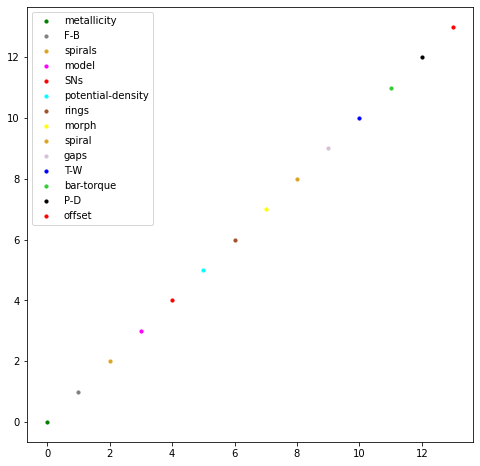

In [36]:
fig = plt.figure(figsize=[8,8])
for ind,method in enumerate(set(methods)):
    plt.scatter(ind,ind,10, label=method, color=method_color[method])
    
plt.legend()
plt.show()

In [154]:
import matplotlib.patches as mpatches

def plot_cr_colorlegend(galname=None, ax=None, loc=None, fontsize=None, used_methods=None):
    if used_methods is None:
        methods = []
        for entry in total_crs:
            methods.append(entry[0]['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
    patches = []
    for method in methods:
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.04,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
#         ax.legend(handles=patches, loc=loc, fontsize=fontsize)
        
        ax.legend(handles=patches, bbox_to_anchor=(1.04,1.2), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1)

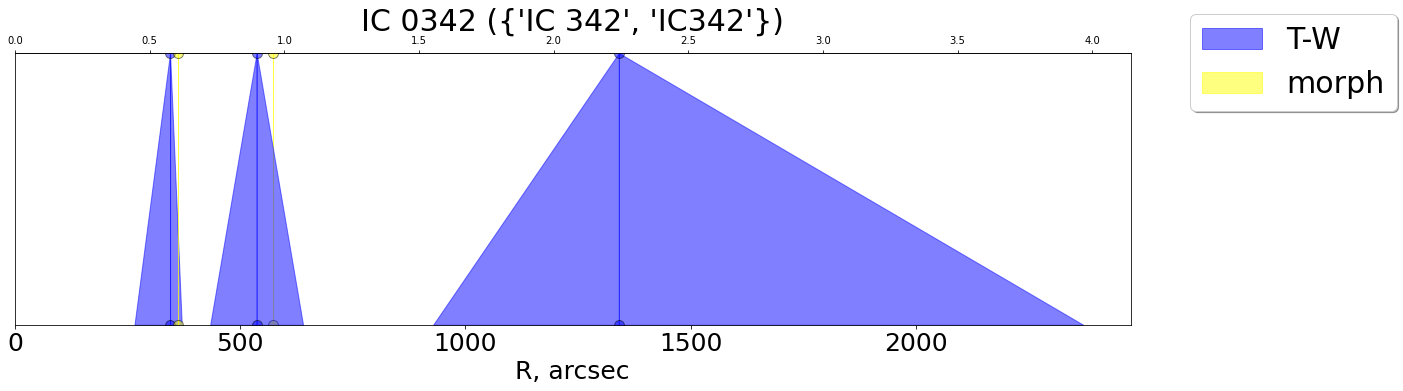

In [155]:
def plot_crs(galname, axx=None, savepath=None, legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[20,5])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    aliases = []
    mets = []
    cc = 0 
    for ind, entry in enumerate(total_crs):
        gals = list(entry[0]['names_map'].values())
        if verbose:
            print('===='*30)
        if galname not in gals:
            if verbose:
                print(f'Gal {galname} not in entry {ind} ({entry[0]["method"]} / {entry[0]["links"]}), continue...')
            continue
        if verbose:
            print(f'Gal {galname} IN entry {ind} ({entry[0]["method"]} / {entry[0]["links"]}):')
        method = entry[0]['method']
        
        name_mapped = entry[0]['reverse_names_map'][galname]
        aliases.append(name_mapped)
        
        if method == 'spiral':
            for arm_band_ind in range(3):
                try:
                    crs = entry[0]['cr'][name_mapped][arm_band_ind]
                except:
                    continue
                bar_from = 33.3*arm_band_ind
                bar_to = 33.3*(arm_band_ind+1)
                for info in crs:
                    if verbose:
                        print(info, method)
                    cr, arm_color = info
    #                 ax.axvspan(cr-3, cr+3, color='none', edgecolor=arm_color, hatch="/", lw=2)
                    ax.bar(cr, bottom=bar_from, height=(bar_to-bar_from), color='none', edgecolor=arm_color, hatch="/", lw=2)
                    ax.scatter(cr, (bar_from+bar_to)/2., 100, color=arm_color, edgecolor='k', marker='d', alpha=0.5)
        else:
#             continue
            crs = entry[0]['cr'][name_mapped]
            mets.append(method)
            for info in crs:
                if verbose:
                    print(info, method)
                if len(info) == 3:
                    cr, cr_r, cr_l = info
                else:
                    cr, cr_r = info
                    cr_l = cr_r

                if method == 'SNs':
                    ax.scatter(cr, 50, 100, color=method_color[method], label=method)
    #                 ax.scatter(cr, 50, 100, color=method_color[method], label=method, marker='+')
                else:
                    if mode == 'box':
                        ax.axvspan(cr-abs(cr_l),  cr+cr_r, alpha=0.5, color=method_color[method], label=method)
                    else:
                        ax.fill_between([cr-abs(cr_l),  cr], [0, 100.], alpha=0.5, color=method_color[method], label=method)
                        ax.fill_between([cr,  cr+cr_r], [100, 0.], alpha=0.5, color=method_color[method], label=method)
                        
                    ax.scatter(cr, 0, 100, color=method_color[method], alpha=0.5, edgecolor='k')
                    ax.scatter(cr, 100, 100, color=method_color[method], alpha=0.5, edgecolor='k')
                    cc+=1
    
    if axx is None:
        ax.set_title('{} ({})'.format(galname, set(aliases)), fontsize=30)
        ax.set_xlabel('R, arcsec', fontsize=25)
        ax.set_yticks([])
        ax.set_facecolor('white')
    if legend:
        plot_cr_colorlegend(galname, ax, loc=None, fontsize=30, used_methods=mets)
    if axx is None:
        ax.set_ylim(0, 100)
        ax.set_xlim(-1)
        ax.tick_params(axis='both', which='major', labelsize=25)
        
        
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        
        
    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath + '/{}_plot_crs_{}.png'.format(cc, galname.replace(' ', '_')), facecolor='white')
        plt.close(fig)
#     plt.close(fig)
    
plot_crs('IC 0342', is_arcsec=True, verbose=False, mode=None, r25=598.)

Gal NGC 6384 IN entry 0 (spiral / None):
[175.31548038601946, 'red'] spiral
[53.863334633108195, 'red'] spiral
[148.3973192097048, 'green'] spiral
[151.20287399216852, 'red'] spiral
[141.18236532641455, 'red'] spiral
[134.44619111692583, 'red'] spiral
[110.09750498282406, 'red'] spiral
[42.84233941247213, 'red'] spiral
[161.76609642941494, 'green'] spiral
[162.31801879494736, 'red'] spiral
[46.04386681875636, 'red'] spiral
Gal NGC 6384 not in entry 1 (F-B / None), continue...
Gal NGC 6384 not in entry 2 (offset / None), continue...
Gal NGC 6384 not in entry 3 (morph / None), continue...
Gal NGC 6384 IN entry 4 (SNs / https://arxiv.org/pdf/1206.5016.pdf):
(33.56758627913919, 0.0) SNs
Gal NGC 6384 not in entry 5 (offset / None), continue...
Gal NGC 6384 not in entry 6 (T-W / https://arxiv.org/pdf/astro-ph/0406426.pdf), continue...
Gal NGC 6384 not in entry 7 (T-W / https://arxiv.org/pdf/0909.1816.pdf), continue...
Gal NGC 6384 not in entry 8 (T-W / https://arxiv.org/pdf/0907.3443.pdf), c

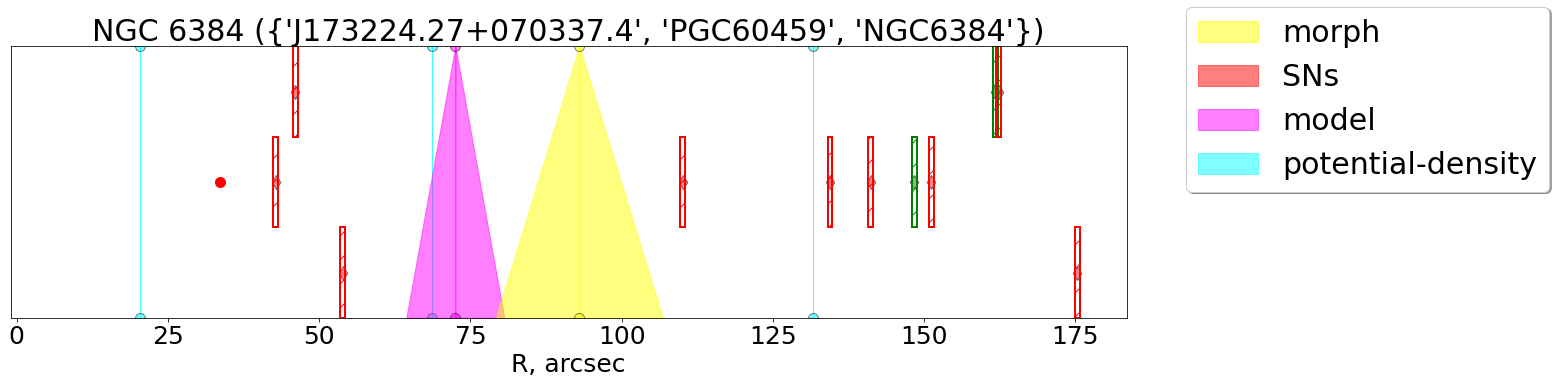

In [192]:
plot_crs('NGC 6384', is_arcsec=True, verbose=True, mode=None)

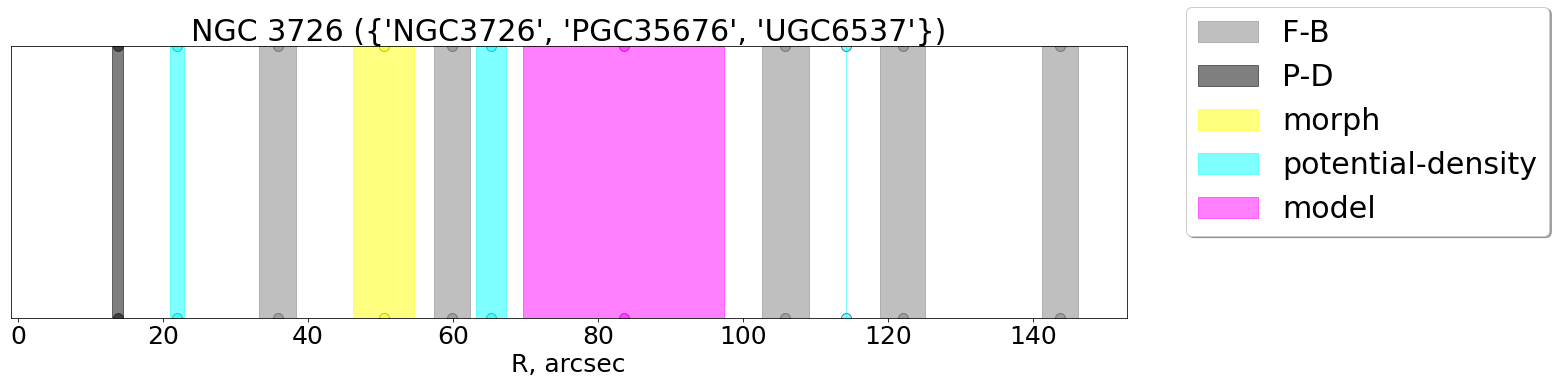

In [193]:
plot_crs('NGC 3726', is_arcsec=True)

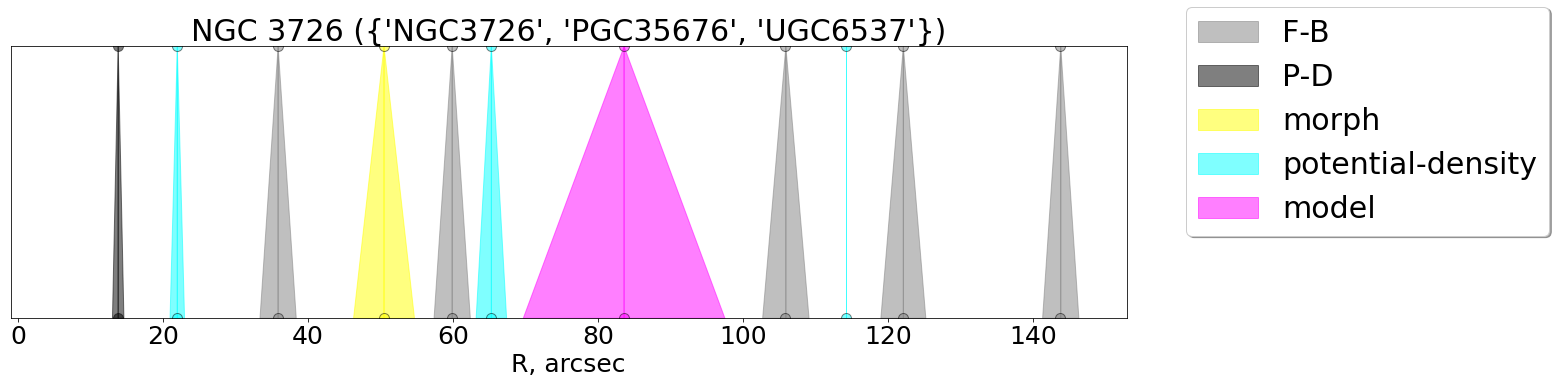

In [194]:
plot_crs('NGC 3726', is_arcsec=True, mode=None)

In [168]:
plot_crs('IC 0342', is_arcsec=True, savepath='/mnt/sdb2/science/spirals/CR_Olya/cr_imgs')

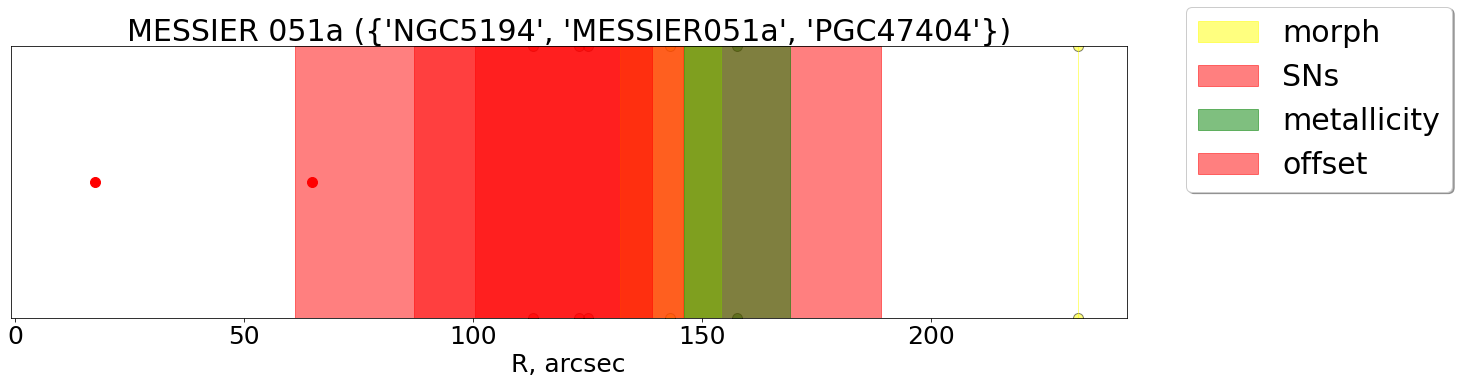

In [195]:
plot_crs('MESSIER 051a', is_arcsec=True)

In [ ]:
more_than_2_CR

In [116]:
for name,cc in more_than_2_CR:
    if name not in disc_r25_sizes.keys():
        print(name)
    

MESSIER 051a


In [128]:
total_crs[17][0]['cr']['PGC37617']

[]

In [156]:
for name,cc in more_than_2_CR:
    print(name)
    if name  == 'MESSIER 051a':
        plot_crs(name, is_arcsec=True, savepath='/mnt/sdb2/science/spirals/CR_Olya/cr_imgs', mode=None, r25=414.11)
    else:
        plot_crs(name, is_arcsec=True, savepath='/mnt/sdb2/science/spirals/CR_Olya/cr_imgs', mode=None, r25=disc_r25_sizes[name])

CGCG 013-075
CGCG 244-013
IC 0342
MCG +06-32-024
MESSIER 031
MESSIER 033
MESSIER 051a
MESSIER 058
MESSIER 061
MESSIER 063
MESSIER 066
MESSIER 074
MESSIER 081
MESSIER 083
MESSIER 091
MESSIER 094
MESSIER 095
MESSIER 099
MESSIER 100
MESSIER 101
MESSIER 109
NGC 0157
NGC 0165
NGC 0210
NGC 0266
NGC 0271
NGC 0289
NGC 0309
NGC 0428
NGC 0488
NGC 0514
NGC 0578
NGC 0613
NGC 0685
NGC 0718
NGC 0753
NGC 0864
NGC 0895
NGC 0925
NGC 1042
NGC 1058
NGC 1073
NGC 1084
NGC 1087
NGC 1187
NGC 1232
NGC 1241
NGC 1300
NGC 1302
NGC 1317
NGC 1365
NGC 1385
NGC 1433
NGC 1493
NGC 1512
NGC 1530
NGC 1559
NGC 1566
NGC 1637
NGC 1672
NGC 1792
NGC 1832
NGC 2090
NGC 2336
NGC 2403
NGC 2543
NGC 2566
NGC 2649
NGC 2775
NGC 2835
NGC 2903
NGC 2964
NGC 3059
NGC 3061
NGC 3162
NGC 3184
NGC 3261
NGC 3275
NGC 3319
NGC 3338
NGC 3344
NGC 3346
NGC 3359
NGC 3423
NGC 3464
NGC 3486
NGC 3504
NGC 3507
NGC 3513
NGC 3521
NGC 3577
NGC 3583
NGC 3593
NGC 3596
NGC 3621
NGC 3631
NGC 3684
NGC 3686
NGC 3726
NGC 3810
NGC 3887
NGC 3893
NGC 3938
NGC 4030

Gal NGC 1317 not in entry 0 (F-B / None), continue...
Gal NGC 1317 not in entry 1 (Tamburro / None), continue...
Gal NGC 1317 not in entry 2 (Williams 1975 / None), continue...
Gal NGC 1317 not in entry 3 (HII iso / None), continue...
Gal NGC 1317 not in entry 4 (T-W / https://arxiv.org/pdf/1002.1245.pdf), continue...
Gal NGC 1317 not in entry 5 (T-W / https://arxiv.org/pdf/0909.1816.pdf), continue...
Gal NGC 1317 not in entry 6 (T-W / https://arxiv.org/pdf/1501.05498.pdf), continue...
Gal NGC 1317 IN entry 7 (potential-density / https://iopscience.iop.org/article/10.1088/0067-0049/182/2/559/pdf):
append  potential-density 7 [(18.8, 0.0), (43.3, 0.0), (105.4, 0.0)]
(18.8, 0.0) potential-density
(43.3, 0.0) potential-density
(105.4, 0.0) potential-density
Gal NGC 1317 IN entry 8 (modelling / https://arxiv.org/pdf/0806.0471.pdf):
append  modelling 8 [(54.5, 10.4)]
(54.5, 10.4) modelling
Gal NGC 1317 not in entry 9 (bar-torque / https://arxiv.org/pdf/0707.4127.pdf), continue...
Gal NGC 13

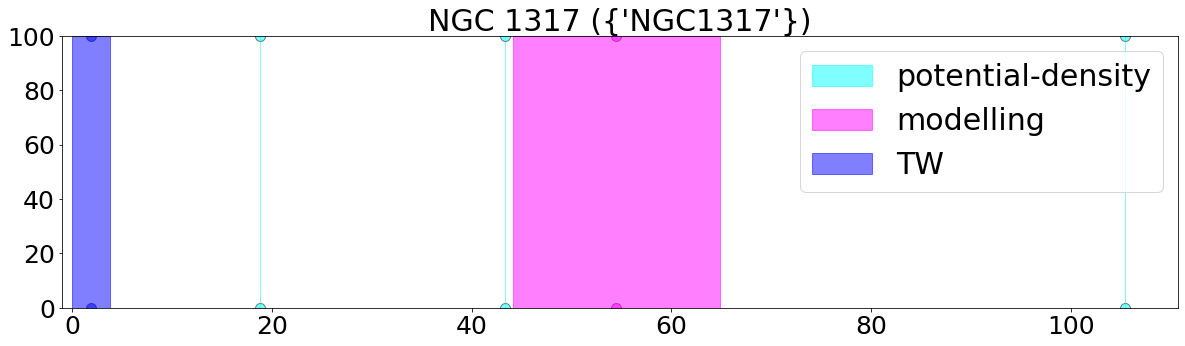

In [243]:
plot_crs('NGC 1317', is_arcsec=True, verbose=True)

Gal MESSIER 095 not in entry 0 (F-B / None), continue...
Gal MESSIER 095 IN entry 1 (Tamburro / None):
(118.67999999999999, 25.5) Tamburro
Gal MESSIER 095 not in entry 2 (Williams 1975 / None), continue...
Gal MESSIER 095 not in entry 3 (HII iso / None), continue...
Gal MESSIER 095 not in entry 4 (T-W / https://arxiv.org/pdf/1002.1245.pdf), continue...
Gal MESSIER 095 not in entry 5 (T-W / https://arxiv.org/pdf/0909.1816.pdf), continue...
Gal MESSIER 095 not in entry 6 (T-W / https://arxiv.org/pdf/1501.05498.pdf), continue...
Gal MESSIER 095 not in entry 7 (potential-density / https://iopscience.iop.org/article/10.1088/0067-0049/182/2/559/pdf), continue...
Gal MESSIER 095 not in entry 8 (modelling / https://arxiv.org/pdf/0806.0471.pdf), continue...
Gal MESSIER 095 not in entry 9 (bar-torque / https://arxiv.org/pdf/0707.4127.pdf), continue...
Gal MESSIER 095 not in entry 10 (Rio1998 / http://articles.adsabs.harvard.edu/pdf/1998A%26A...340....1D), continue...
Gal MESSIER 095 not in entry

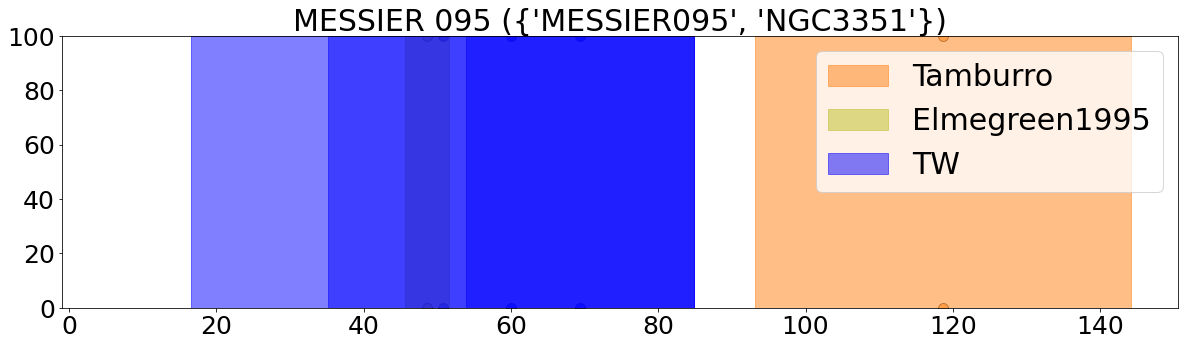

In [281]:
plot_crs('MESSIER 095', is_arcsec=True, verbose=True)

(5.0, 0.0) potential-density
(55.1, 0.0) potential-density
(88.0, 0.0) potential-density
(126.2, 14.6) modelling
(88.12799999999999, 0) symm
(100.19999999999999, 2.400000000000002) Elmegreen1995


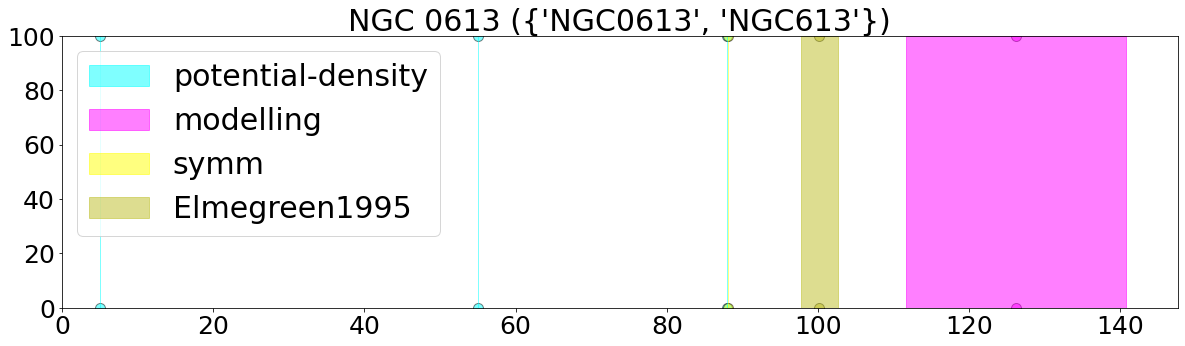

In [170]:
plot_crs('NGC 0613', is_arcsec=True, verbose=True)

(20.4, 0.0) potential-density
(68.7, 0.0) potential-density
(131.7, 0.0) potential-density
(72.5, 8.1) modelling
(93.0, 13.799999999999999) Elmegreen1995
(33.56758627913919, 0.0) SNs
[148.3973192097048, 'green'] spiral
[151.20287399216852, 'red'] spiral
[141.18236532641455, 'red'] spiral
[134.44619111692583, 'red'] spiral
[110.09750498282406, 'red'] spiral
[42.84233941247213, 'red'] spiral


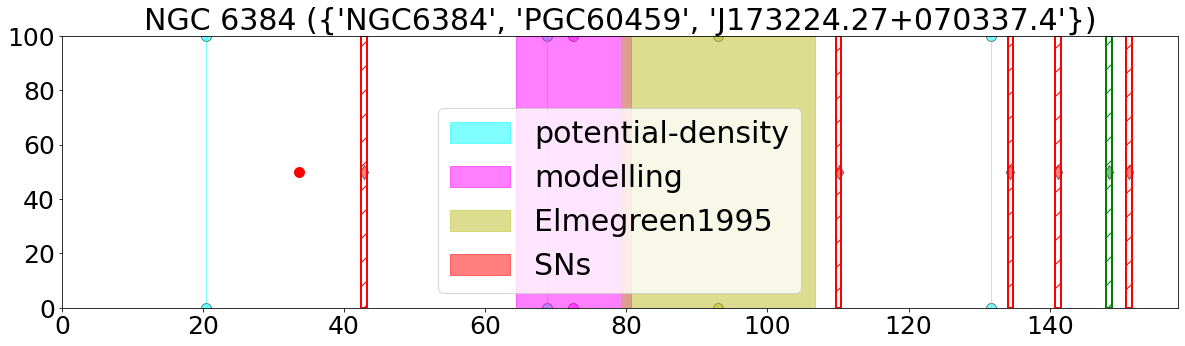

In [186]:
plot_crs('NGC 6384', is_arcsec=True, verbose=True)

In [93]:
plot_crs('NGC 6384', is_arcsec=True, verbose=True, mode=None)

Gal NGC 6384 not in entry 0 (F-B / None), continue...
Gal NGC 6384 not in entry 1 (Tamburro / None), continue...
Gal NGC 6384 not in entry 2 (Williams 1975 / None), continue...
Gal NGC 6384 not in entry 3 (HII iso / None), continue...
Gal NGC 6384 not in entry 4 (T-W / https://arxiv.org/pdf/1002.1245.pdf), continue...
Gal NGC 6384 not in entry 5 (T-W / https://arxiv.org/pdf/0909.1816.pdf), continue...
Gal NGC 6384 not in entry 6 (T-W / https://arxiv.org/pdf/1501.05498.pdf), continue...
Gal NGC 6384 IN entry 7 (potential-density / https://iopscience.iop.org/article/10.1088/0067-0049/182/2/559/pdf):
(20.4, 0.0) potential-density
(68.7, 0.0) potential-density
(131.7, 0.0) potential-density
Gal NGC 6384 IN entry 8 (modelling / https://arxiv.org/pdf/0806.0471.pdf):
(72.5, 8.1) modelling
Gal NGC 6384 not in entry 9 (bar-torque / https://arxiv.org/pdf/0707.4127.pdf), continue...
Gal NGC 6384 not in entry 10 (Rio1998 / http://articles.adsabs.harvard.edu/pdf/1998A%26A...340....1D), continue...


KeyError: 0

In [172]:
consist = {
'MESSIER 063' : [(160 , 210)], #very spec.
'MESSIER 074' : [(80 , 100), (130, 160)], #signif. errors
'NGC 3504' : [(41 , 49)], #conf by 4
'NGC 3513' : [(50 , 63)], #broad
'NGC 3596' : [(19 , 23), (32, 36), (46,49)], #very spec.
'MESSIER 058' : [(23 , 26), (47, 52), (70,90)], #last by 4
'MESSIER 061' : [(43, 48), (78,92)], #very spec.
'NGC 0864' : [(6 , 8), (26,37), (56,58), (75,87)], #interesting case
'NGC 0895' : [(52 , 75)],
'NGC 3686' : [(32 , 46)],
'NGC 4051' : [(70 , 110)], #meh
'NGC 2903' : [(140 , 175)],
'NGC 6951' : [(65 , 82)],
'IC 0342' : [(264, 370), (436, 636)], #only by two agreed
'NGC 0753' : [(23 , 33)], #meh
'NGC 3338' : [(45 , 55)],
'NGC 4123' : [(50 , 72)],
'NGC 4939' : [(70 , 90)],
'NGC 5850' : [(23,30), (62, 82), (95, 110)], #only by two agreed
'NGC 0578' : [(70 , 95)],
'NGC 5371' : [(37, 45), (75, 82), (93,97)], # second is very specul
'NGC 7552' : [(60, 83)],
'NGC 3344' : [(78,81), (115 , 123)],
'NGC 5676' : [(20 , 23), (34, 41), (60, 70)], #only by two
'NGC 5701' : [(17,19), (65 , 75)], #very spec.
'NGC 5921' : [(59 , 79)],
'NGC 6946' : [(120 , 170), (245,255)], #spec.
'MESSIER 101' : [(110 , 180), (290,350), (470,515)], #first is less constrained and may be wrong
'NGC 3061' : [(14 , 16), (21,23), (33, 36)], #very spec. and by two only
'NGC 3893' : [(15 , 20), (33, 39), (60,70)], #only one by three (but maybe first two, just not long spiral)
'NGC 7741' : [(45, 57), (63, 76), (108, 114)], #same as 3893
# all auto confirmed by consisted below    
'MESSIER 031' : [(4100,4300)], #only one
'NGC 0514' : [(30,40)], #only one
'NGC 7793' : [(100,200)], #only one
'NGC 4535' : [(55,85)], #only one
    'NGC 4665' : [(16,19), (46, 60)],  #only by two agreed
    'NGC 7496' : [(30,55)], #veeeery spec. and broad errors
}

In [170]:
def plot_crs(galname, axx=None, savepath=None, legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[20,5])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    aliases = []
    mets = []
    cc = 0 
    for ind, entry in enumerate(total_crs):
        gals = list(entry[0]['names_map'].values())
        if verbose:
            print('===='*30)
        if galname not in gals:
            if verbose:
                print(f'Gal {galname} not in entry {ind} ({entry[0]["method"]} / {entry[0]["links"]}), continue...')
            continue
        if verbose:
            print(f'Gal {galname} IN entry {ind} ({entry[0]["method"]} / {entry[0]["links"]}):')
        method = entry[0]['method']
        
        name_mapped = entry[0]['reverse_names_map'][galname]
        aliases.append(name_mapped)
        
        if method == 'spiral':
            for arm_band_ind in range(3):
                try:
                    crs = entry[0]['cr'][name_mapped][arm_band_ind]
                except:
                    continue
                bar_from = 33.3*arm_band_ind
                bar_to = 33.3*(arm_band_ind+1)
                for info in crs:
                    if verbose:
                        print(info, method)
                    cr, arm_color = info
    #                 ax.axvspan(cr-3, cr+3, color='none', edgecolor=arm_color, hatch="/", lw=2)
                    ax.bar(cr, bottom=bar_from, height=(bar_to-bar_from), color='none', edgecolor=arm_color, hatch="/", lw=2)
                    ax.scatter(cr, (bar_from+bar_to)/2., 100, color=arm_color, edgecolor='k', marker='d', alpha=0.5)
        else:
#             continue
            crs = entry[0]['cr'][name_mapped]
            mets.append(method)
            for info in crs:
                if verbose:
                    print(info, method)
                if len(info) == 3:
                    cr, cr_r, cr_l = info
                else:
                    cr, cr_r = info
                    cr_l = cr_r

                if method == 'SNs':
                    ax.scatter(cr, 50, 100, color=method_color[method], label=method)
    #                 ax.scatter(cr, 50, 100, color=method_color[method], label=method, marker='+')
                else:
                    if mode == 'box':
                        ax.axvspan(cr-abs(cr_l),  cr+cr_r, alpha=0.5, color=method_color[method], label=method)
                    else:
                        ax.fill_between([cr-abs(cr_l),  cr], [0, 100.], alpha=0.5, color=method_color[method], label=method)
                        ax.fill_between([cr,  cr+cr_r], [100, 0.], alpha=0.5, color=method_color[method], label=method)
                        
                    ax.scatter(cr, 0, 100, color=method_color[method], alpha=0.5, edgecolor='k')
                    ax.scatter(cr, 100, 100, color=method_color[method], alpha=0.5, edgecolor='k')
                    cc+=1
    
    
    if galname in consist.keys():
        consist_crs = consist[galname]
        for cr_l,cr_r in consist_crs:
            ax.fill_between([cr_l,cr_r], [5, 5.], color='k', hatch='o', edgecolor='r')
    
    if axx is None:
        ax.set_title('{} ({})'.format(galname, set(aliases)), fontsize=30)
        ax.set_xlabel('R, arcsec', fontsize=25)
        ax.set_yticks([])
        ax.set_facecolor('white')
    if legend:
        plot_cr_colorlegend(galname, ax, loc=None, fontsize=30, used_methods=mets)
    if axx is None:
        ax.set_ylim(0, 100)
        ax.set_xlim(-1)
        ax.tick_params(axis='both', which='major', labelsize=25)
        
        
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        
        
    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath + '/{}_plot_crs_{}.png'.format(cc, galname.replace(' ', '_')), facecolor='white')
        plt.close(fig)
#     plt.close(fig)
    
plot_crs('IC 0342', is_arcsec=True, verbose=False, mode=None, r25=598.)

In [173]:
for name,cc in more_than_2_CR:
    if name in consist.keys():
        plot_crs(name, is_arcsec=True, savepath='/mnt/sdb2/science/spirals/CR_Olya/consist_check/', mode=None, r25=disc_r25_sizes[name])

## build pandas df

In [9]:
total_crs[5][0].keys()

dict_keys(['cr', 'method', 'dist', 'links', 'name', 'bands', 'kind', 'bar', 'names_map', 'reverse_names_map'])

In [10]:
data = []
for info_ in total_crs:
    info = info_[0]
    method = info['method']
    
    if method == 'spiral' or method == 'SNs':
        continue
        
    crs = info['cr']

    for name, crinfo_ in crs.items():
        for crinfo in crinfo_:
            if len(crinfo) == 3:
                cr, cr_r, cr_l = crinfo
            else:
#                 print(name, crinfo)
                cr, cr_r = crinfo
                cr_l = cr_r

            add_data = {'name' : name, 'method' : method, 'bar' : info['bar'], 'kind' : info['kind'], 'bands' : info['bands'], 'link' : info['links'], 'paper_name' : info['name']}
            add_data['cr'] = cr
            add_data['err_cr_l'] = abs(cr_l)
            add_data['err_cr_r'] = abs(cr_r)

            add_data['cr_l'] = cr-abs(cr_l)
            add_data['cr_r'] = cr+abs(cr_r)

            add_data['err_range'] = abs(cr_r)+abs(cr_l)

            try:
                add_data['altname'] = info['names_map'][name]
                add_data['r25'] = disc_r25_sizes[add_data['altname']]
            except:
                pass

            data.append(add_data)

In [11]:
len(data)

1665

In [12]:
df = pd.DataFrame(data=data)

In [13]:
df.sample(5)

name      method    bar     kind       bands  \
1260   NGC1511         T-W  False      ISM   CO,Halpha   
1653  PGC49514     spirals  False  stellar       g,r,i   
159    UGC4936         F-B  False      ISM  Halpha, HI   
1069    IC5355  bar-torque  False     both    Halpha,r   
495    NGC1084       morph  False      ISM         HII   

                                      link              paper_name         cr  \
1260  https://arxiv.org/pdf/2102.01091.pdf  Williams et al. (2021)   4.297183   
1653                                  None             gri spirals  38.000000   
159                                   None               F-B works  16.900000   
1069   https://arxiv.org/pdf/0707.4127.pdf    Verley et al. (2007)  13.407212   
495                                   None  Williams et al. (1975)  55.863385   

      err_cr_l  err_cr_r       cr_l       cr_r  err_range   altname  \
1260  4.297183  4.297183   0.000000   8.594367   8.594367  NGC 1511   
1653  3.000000  3.000000  35.000000  41.000000   6.000000  NGC 5371   
159   1.800000  1.800000  15.100000  18.700000   3.600000  NGC 2805   
1069  0.000000  0.000000  13.407212  13.407212   0.000000   IC 5355   
495   0.000000  0.000000  55.863385  55.863385   0.000000  NGC 1084   

             r25  
1260  110.948454  
1653  119.432151  
159   101.653247  
1069   30.207950  
495   101.887582

In [14]:
df.to_csv('total_crs.csv')

In [2]:
df = pd.read_csv('total_crs.csv', index_col=0)
df.sample(5)

name method    bar     kind       bands  \
82                UGC2855    F-B  False      ISM  Halpha, HI   
220               UGC5842    F-B  False      ISM  Halpha, HI   
276               UGC7420    F-B  False      ISM  Halpha, HI   
1528  J095935.08+020127.2  rings   True  stellar        SDSS   
411              UGC10897    F-B  False      ISM  Halpha, HI   

                                     link           paper_name         cr  \
82                                    NaN            F-B works  41.200000   
220                                   NaN            F-B works  23.400000   
276                                   NaN            F-B works  60.400000   
1528  https://arxiv.org/pdf/1202.1929.pdf  Perez et al. (2012)   2.031583   
411                                   NaN            F-B works   7.500000   

      err_cr_l  err_cr_r       cr_l       cr_r  err_range  \
82         6.4       6.4  34.800000  47.600000       12.8   
220        1.5       1.5  21.900000  24.900000        3.0   
276        2.3       2.3  58.100000  62.700000        4.6   
1528       0.0       0.0   2.031583   2.031583        0.0   
411        1.9       1.9   5.600000   9.400000        3.8   

                        altname         r25  
82                    UGC 02855  106.199202  
220                    NGC 3346   79.089942  
276                 MESSIER 061  206.595689  
1528  WISEA J095935.08+020127.2         NaN  
411                    NGC 6412   63.844171

In [342]:
df['cr_r25'] = df['cr']/df['r25']

In [344]:
sns.kdeplot(data=df, x='cr_r25', hue='kind')
plt.xlim(0,2)

(0.0, 2.0)

(0.0, 2.0)

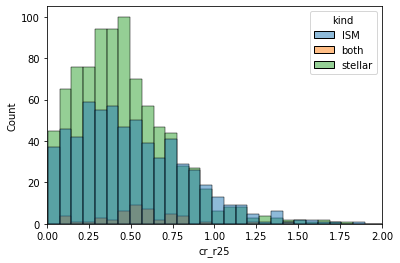

In [345]:
sns.histplot(data=df, x='cr_r25', hue='kind')
plt.xlim(0,2)

(0.0, 2.0)

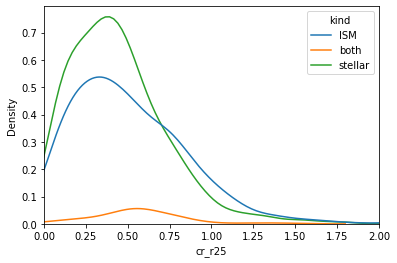

In [346]:
sns.kdeplot(data=df[df['bar']!=True], x='cr_r25', hue='kind')
plt.xlim(0,2)

# hyperleda

In [ ]:
for n in all_gals:
    print(n)

http://leda.univ-lyon1.fr/leda/meandata.html

In [ ]:
for n in nn:
    print(n)

In [8]:
data = np.genfromtxt('../leda_res.txt', comments='!', delimiter='|', dtype=None, skip_header=3)

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [10]:
data[0]

(b'2MASX J14192411+4554021                 ', 2272149, b' PGC2272149      ', b' 2MASXJ14192411+4554021,PGC2272149,SDSSJ141924.05+455402.7,SDSSJ141924.05+455402.8,SDSSJ141924.06+455402.7,SDSSJ141924.06+455402.8 ', b' G               ', b' B141729.6+460747 ', 14.3233525, 45.9007184, b' J141924.1+455403 ', b' S0-a            ', b' B               ', b' R               ', b'                 ', b'                 ', 0., 2., 0.673, 0.086, 0.199, 0.027, 135.41, 17.298, 0.011, 16.006, 0.5, nan, nan, 14.818, 0.055, 12.54, 0.058, nan, nan, nan, nan, nan, nan, nan, nan, 0.668, 35.39, 0.132, nan, -19.621, False)

In [13]:
logd25 = data[0][16]

In [15]:
logd25

0.673

In [118]:
30*(np.power(10., 2.14)/10.)

414.11527938086556

In [16]:
disc_r25_sizes = {} # in arcsec
for d in data:
    name = d[0].decode("utf-8").strip()
    logd25 = d[16]
    r25 = 30*(np.power(10., logd25)/10.)
    disc_r25_sizes[name] = r25
    
len(disc_r25_sizes)

620

In [139]:
# missed in LEDA
disc_r25_sizes['MESSIER 051a'] = 414.11

In [140]:
save_obj(disc_r25_sizes, 'disc_r25_sizes')

In [271]:
data = np.genfromtxt('../leda_res.txt', comments='!', delimiter='|', dtype=None)

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [278]:
print([_.decode().strip() for _ in data[0]])

['name', 'pgc', 'objname', 'hl_names(pgc)', 'objtype', 'celposb(pgc)', 'al2000', 'de2000', 'celposj(pgc)', 'type', 'bar', 'ring', 'multiple', 'compactness', 't', 'e_t', 'logd25', 'e_logd25', 'logr25', 'e_logr25', 'pa', 'ut', 'e_ut', 'bt', 'e_bt', 'vt', 'e_vt', 'it', 'e_it', 'kt', 'e_kt', 'ube', 'bve', 'vmaxg', 'e_vmaxg', 'vmaxs', 'e_vmaxs', 'vdis', 'e_vdis', 'logdc', 'modz', 'e_modz', 'mod0', 'mabs', 'False']


In [279]:
columns = [_.decode().strip() for _ in data[0]]

In [298]:
df = pd.DataFrame(columns=columns, data=data[1:])

In [299]:
for col in df.columns:
    df[col]=df[col].apply(lambda l: l.decode().strip())

In [300]:
df.head()

name      pgc     objname  \
0  2MASX J14192411+4554021  2272149  PGC2272149   
1  2MASX J14213483+4021294  2164620  PGC2164620   
2             CGCG 008-010    28891   PGC028891   
3             CGCG 013-075    38372   PGC038372   
4             CGCG 035-083    28556   PGC028556   

                                       hl_names(pgc) objtype  \
0  2MASXJ14192411+4554021,PGC2272149,SDSSJ141924....       G   
1  2MASXJ14213483+4021294,PGC2164620,SDSSJ142134....       G   
2  2DFGRSN216Z250,2MASXJ09594227-0208592,CGCG008-...       G   
3  2DFGRSN179Z081,2MASXJ12060909-0256532,6dFJ1206...       G   
4  2MASXJ09541066+0217135,AGC191383,CGCG035-083,H...       G   

       celposb(pgc)      al2000      de2000      celposj(pgc)  type  ...  \
0  B141729.6+460747  14.3233525  45.9007184  J141924.1+455403  S0-a  ...   
1  B141933.9+403508  14.3596831  40.3580951  J142134.9+402129    S?  ...   
2  B095709.7-015435   9.9950728  -2.1498412  J095942.3-020859    Sb  ...   
3  B120335.3-024011  12.1025323  -2.9480868  J120609.1-025653  S0-a  ...   
4  B095135.4+023126   9.9029638   2.2872128  J095410.7+021714    Sc  ...   

  vmaxs e_vmaxs vdis e_vdis  logdc    modz e_modz mod0     mabs  False  
0                            0.668   35.39  0.132       -19.621  False  
1                            0.736   37.28  0.056       -21.346  False  
2                            0.813  36.047  0.099       -20.949  False  
3                            0.944  35.252  0.141       -20.379  False  
4                            0.941  35.143  0.148        -20.62  False  

[5 rows x 45 columns]

In [301]:
df.to_csv('hyperleda_data.csv')

In [302]:
hyper = pd.read_csv('hyperleda_data.csv', index_col=0)

In [303]:
hyper.sample(3)

name    pgc   objname  \
164   NGC 0895   8974   NGC0895   
510   NGC 7456  70304   NGC7456   
551  UGC 04500  24341  UGC04500   

                                         hl_names(pgc) objtype  \
164  2MASXJ02213646-0531170,6dFJ0221365-053117,AGC4...       G   
510  2MASXJ23021042-3934098,6dFJ2302104-393410,AGC0...       G   
551  CGCG331-053,KIG0267,KUG0834+718,MCG+12-09-001,...       G   

         celposb(pgc)     al2000     de2000      celposj(pgc)  type  ...  \
164  B021906.5-054457   2.360131  -5.521391  J022136.5-053117    Sc  ...   
510  B225922.4-395019  23.036212 -39.569419  J230210.4-393410    Sc  ...   
551  B083408.7+715246   8.655501  71.703466  J083919.8+714212  SABc  ...   

    vmaxs e_vmaxs vdis e_vdis  logdc    modz  e_modz    mod0    mabs  False  
164   NaN     NaN  NaN    NaN  1.527  32.507   0.504  32.740 -20.836  False  
510   NaN     NaN  NaN    NaN  1.599  30.951   1.048  30.826 -19.291  False  
551   NaN     NaN  NaN    NaN  1.005  34.054   0.243     NaN -19.080  False  

[3 rows x 45 columns]

# comparison

In [16]:
total_crs = load_obj('total_crs')
disc_r25_sizes = load_obj('disc_r25_sizes')

In [58]:
for ind,_ in enumerate(total_crs):
    info = _[0]
    if ind%5 == 0:
        print('-'*220)
    print('{:2} | {:5} {:30} | {:10} {:10} | {:30} {:40} {:20}'.format(str(ind), str(len(info['cr'])), info['method'], info['kind'], info['bar'], info['bands'], info['name'],str(info['links'])))

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0  | 155   spiral                         | ISM                 0 | r                              our spirals                              None                
1  | 112   F-B                            | ISM                 0 | Halpha, HI                     F-B works                                None                
2  | 14    offset                         | both                0 | HI, 24mu                       Tamburro                                 None                
3  | 24    morph                          | ISM                 0 | HII                            Williams et al. (1975)                   None                
4  | 3311  SNs                            | none                0 | SN                             Karapetyan et al. (2018)            

Group data by method:

In [17]:
ALL_METHODS = {}

for ind,_ in enumerate(total_crs):
    method = _[0]['method']
#     if method == 'spiral':
#         continue
    if method == 'SNs':
        continue
    if method in ALL_METHODS.keys():
        ALL_METHODS[method].append(_[0])
    else:
        ALL_METHODS[method] = [_[0]]
        
len(ALL_METHODS)

13

In [18]:
m = np.zeros((len(ALL_METHODS), len(ALL_METHODS)))

In [19]:
methods = [(k, len(np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[k]]))) for k in ALL_METHODS.keys()]
methods, _ = zip(*sorted(methods, key=lambda l: l[1], reverse=True))

In [20]:
# methods = ALL_METHODS.keys()

for ind1, method1 in enumerate(methods):
    for ind2, method2 in enumerate(methods):
        gals_1 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method1]])
        gals_2 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method2]])
        intersection = len(set(gals_1).intersection(set(gals_2)))
        m[ind1, ind2] = intersection

In [21]:
mm = m.copy()
for i in range(len(mm)):
    mm[i,i]=-1

<AxesSubplot:>

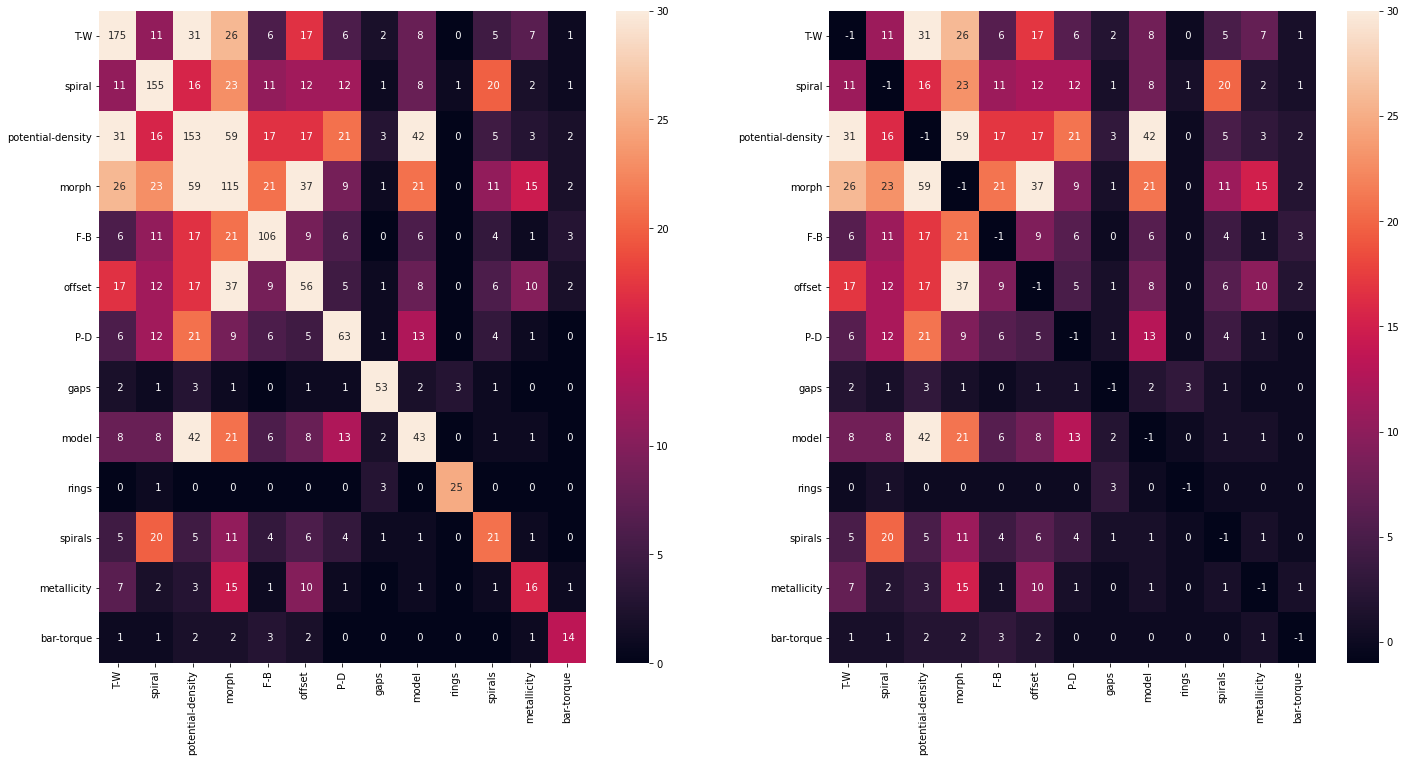

In [64]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

ax = plt.subplot(122)
sns.heatmap(mm, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

<AxesSubplot:>

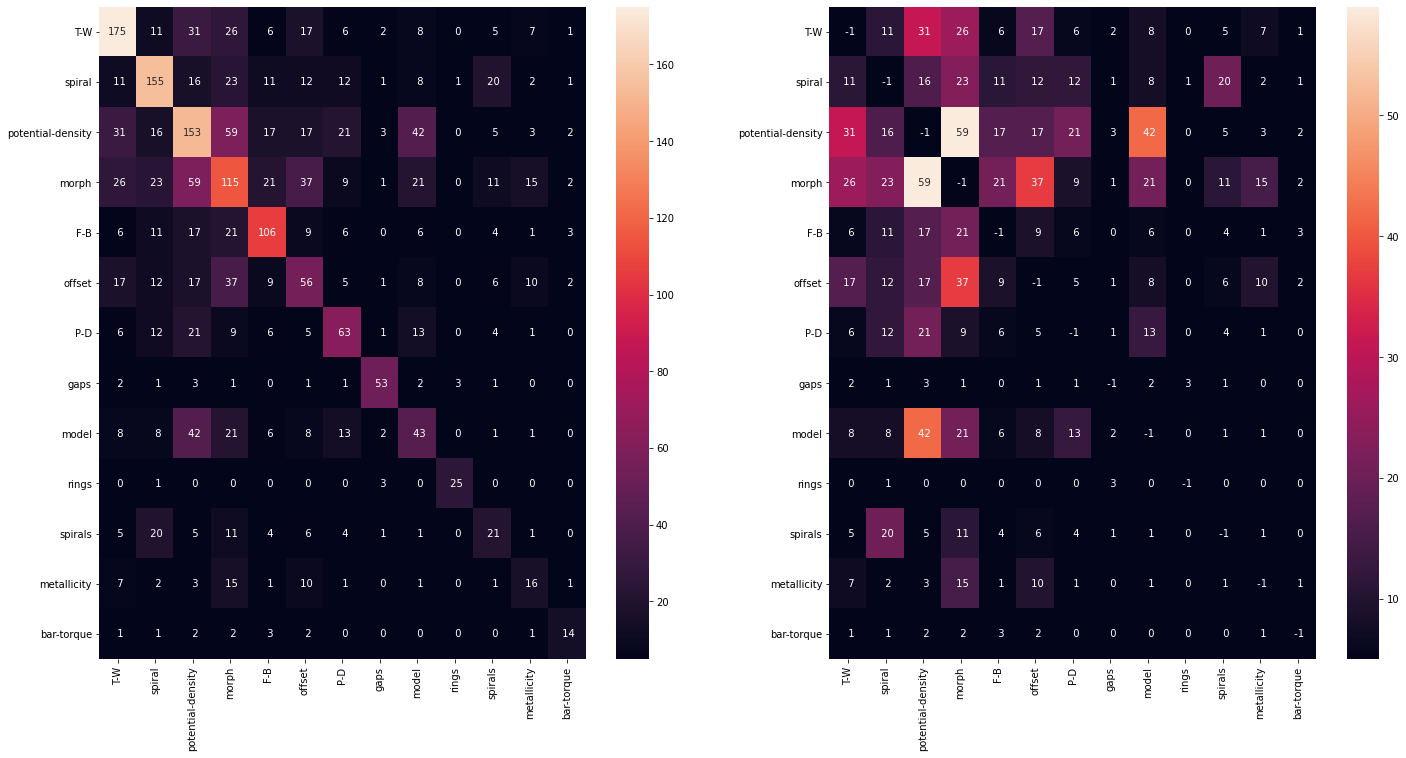

In [65]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmin=5, fmt="3.0f")

ax = plt.subplot(122)
sns.heatmap(mm, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmin=5, fmt="3.0f")

Удалим методы без пересечений:

In [23]:
del ALL_METHODS['bar-torque']
del ALL_METHODS['rings']
del ALL_METHODS['gaps']
del ALL_METHODS['spiral']

In [24]:
m = np.zeros((len(ALL_METHODS), len(ALL_METHODS)))

methods = [(k, len(np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[k]]))) for k in ALL_METHODS.keys()]
methods, _ = zip(*sorted(methods, key=lambda l: l[1], reverse=True))

# methods = ALL_METHODS.keys()

for ind1, method1 in enumerate(methods):
    for ind2, method2 in enumerate(methods):
        gals_1 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method1]])
        gals_2 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method2]])
        intersection = len(set(gals_1).intersection(set(gals_2)))
        m[ind1, ind2] = intersection
        
mm = m.copy()
for i in range(len(mm)):
    mm[i,i]=-1        

https://datastart.ru/blog/read/seaborn-heatmaps-13-sposobov-nastroit-vizualizaciyu-matricy-korrelyacii

https://stackoverflow.com/questions/62531728/change-color-according-to-conditions-for-seaborn-heatmaps

[Text(0.5, 0, 'T-W'),
 Text(1.5, 0, 'potential-density'),
 Text(2.5, 0, 'morph'),
 Text(3.5, 0, 'F-B'),
 Text(4.5, 0, 'offset'),
 Text(5.5, 0, 'P-D'),
 Text(6.5, 0, 'model'),
 Text(7.5, 0, 'spirals'),
 Text(8.5, 0, 'metallicity')]

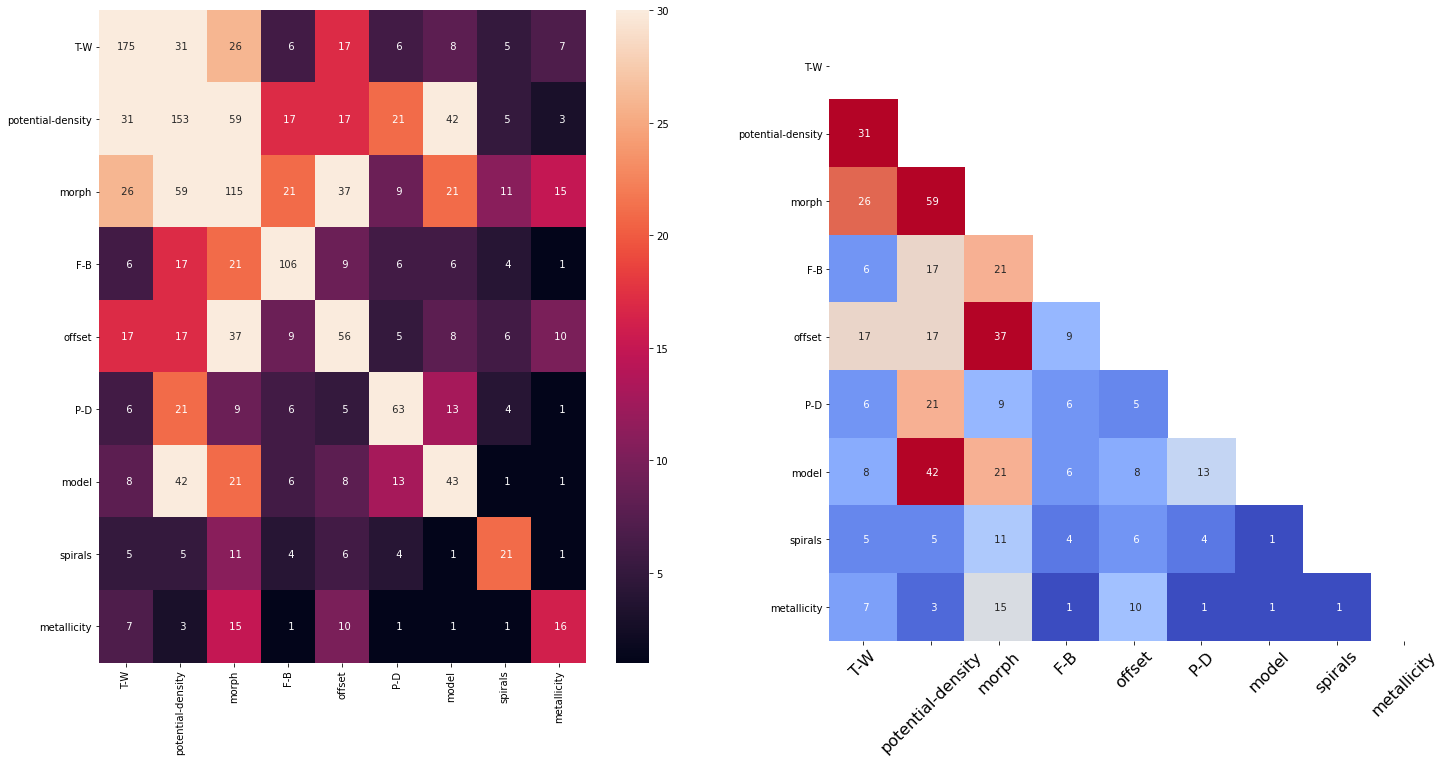

In [68]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

ax = plt.subplot(122)
g = sns.heatmap(mm, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f", cmap= 'coolwarm', cbar=False, square=True, mask=np.triu(mm))
g.axes.set_xticklabels(g.axes.get_xmajorticklabels(), fontsize = 16, rotation=45)

In [69]:
list(methods)

['T-W',
 'potential-density',
 'morph',
 'F-B',
 'offset',
 'P-D',
 'model',
 'spirals',
 'metallicity']

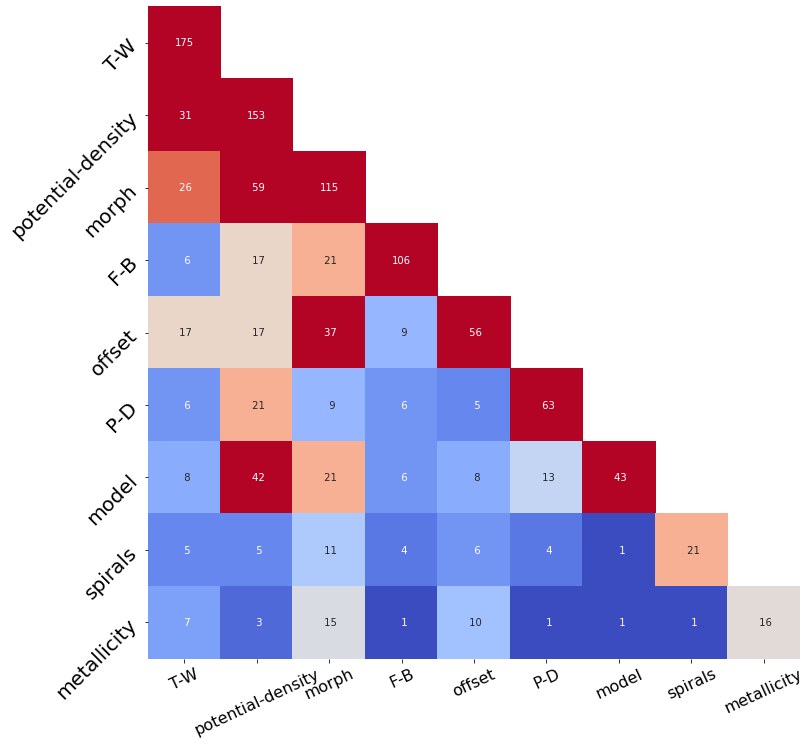

In [70]:
fig = plt.figure(figsize=[12,12])

mask = np.triu(np.full(m.shape, True))
for i in range(len(mask)):
    mask[i,i]=False

ax = plt.subplot(111)
g = sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f", cmap= 'coolwarm', cbar=False, square=True, mask=mask)
g.axes.set_xticklabels(g.axes.get_xmajorticklabels(), fontsize = 16, rotation=25)
g.axes.set_yticklabels(g.axes.get_ymajorticklabels(), fontsize = 20, rotation=45)
plt.show()

<AxesSubplot:>

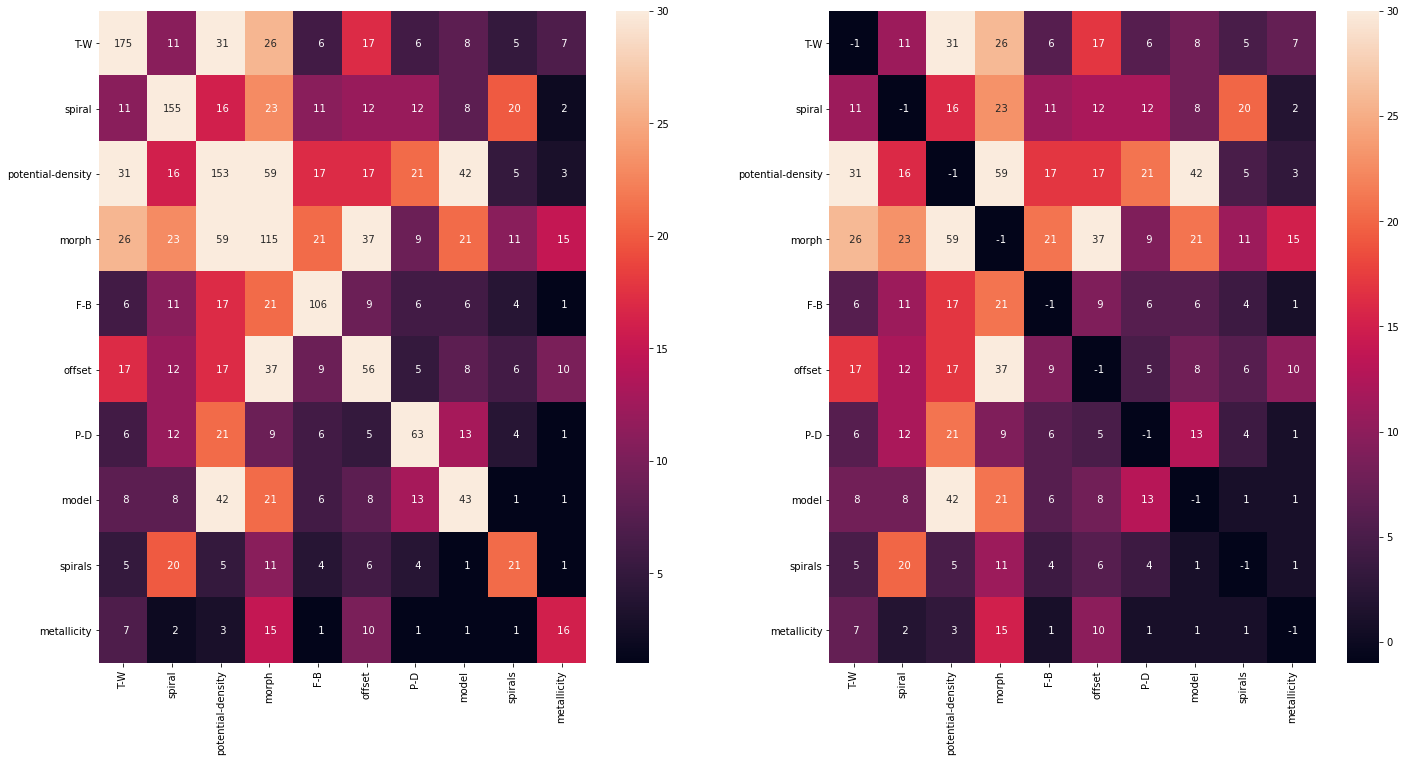

In [51]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

ax = plt.subplot(122)
sns.heatmap(mm, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

<AxesSubplot:>

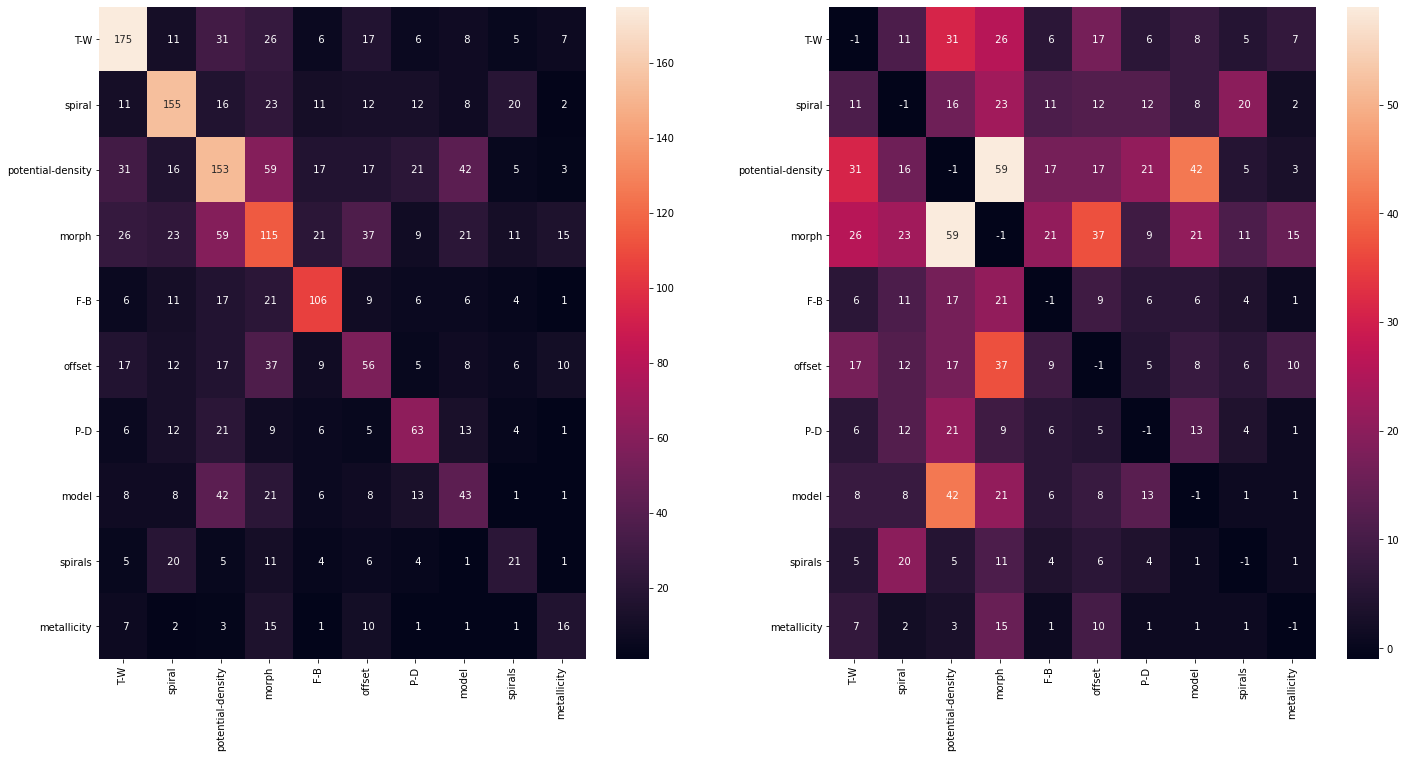

In [52]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, fmt="3.0f")

ax = plt.subplot(122)
sns.heatmap(mm, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, fmt="3.0f")

In [52]:
df

name   method    bar     kind       bands link   paper_name     cr  \
0       NGC428      F-B  False      ISM  Halpha, HI  NaN    F-B works    5.8   
1       NGC428      F-B  False      ISM  Halpha, HI  NaN    F-B works   17.6   
2       NGC428      F-B  False      ISM  Halpha, HI  NaN    F-B works   59.5   
3       NGC428      F-B  False      ISM  Halpha, HI  NaN    F-B works  115.6   
4       NGC428      F-B  False      ISM  Halpha, HI  NaN    F-B works  144.7   
...        ...      ...    ...      ...         ...  ...          ...    ...   
1660  PGC54445  spirals  False  stellar       g,r,i  NaN  gri spirals   44.0   
1661  PGC72387  spirals  False  stellar       g,r,i  NaN  gri spirals   84.0   
1662  PGC33325  spirals  False  stellar       g,r,i  NaN  gri spirals   17.0   
1663  PGC44032  spirals  False  stellar       g,r,i  NaN  gri spirals   13.0   
1664  PGC44032  spirals  False  stellar       g,r,i  NaN  gri spirals   29.0   

      err_cr_l  err_cr_r   cr_l   cr_r  err_range    altname        r25  \
0          2.2       2.2    3.6    8.0        4.4   NGC 0428  84.551488   
1          3.1       3.1   14.5   20.7        6.2   NGC 0428  84.551488   
2          3.9       3.9   55.6   63.4        7.8   NGC 0428  84.551488   
3          2.2       2.2  113.4  117.8        4.4   NGC 0428  84.551488   
4          2.2       2.2  142.5  146.9        4.4   NGC 0428  84.551488   
...        ...       ...    ...    ...        ...        ...        ...   
1660       7.0       7.0   37.0   51.0       14.0   NGC 5905  96.632064   
1661       5.0       5.0   79.0   89.0       10.0   NGC 7753  60.272784   
1662       2.0       2.0   15.0   19.0        4.0  UGC 06109  31.413856   
1663       2.0       2.0   11.0   15.0        4.0  UGC 08050  34.524012   
1664       2.0       2.0   27.0   31.0        4.0  UGC 08050  34.524012   

        cr_r25  
0     0.068597  
1     0.208157  
2     0.703713  
3     1.367214  
4     1.711383  
...        ...  
1660  0.455335  
1661  1.393664  
1662  0.541162  
1663  0.376550  
1664  0.839995  

[1665 rows x 16 columns]

In [76]:
for method in methods:
#     print(method)
    try:
        gf = df[df['method']==method]
        gals = len(set(gf['name']))
        bands = set(np.concatenate([np.array(_) for _ in gf['bands'].apply(lambda l: l.split(','))]))
        links = set(gf['paper_name'].values)
        
        print('{:20} | {:5} | {:73} | {:200}'.format(method, gals, str(bands), str(links)))
        
    except Exception as e:
#         print(e)
        pass

T-W                  |   186 | {'MANGA', 'MUSE', 'Halpha', 'HI', 'different', 'CO', 'CALIFA'}            | {'Rand & Wallin (2004)', 'Fathi et al. (2009)', 'Meidt et al. (2009) TWR', 'Williams et al. (2021)', 'Cuomo et al. (2020)'}                                                                             
potential-density    |   153 | {'H-band'}                                                                | {'Buta & Zhang (2009)'}                                                                                                                                                                                 
morph                |   132 | {'optical', 'HII', 'B?'}                                                  | {'Elmegreen & Elmegreen (1995)', 'Elmegreen et al. (1992)', 'Williams et al. (1975)'}                                                                                                                   
F-B                  |   112 | {'Halpha', ' HI'}                            

In [79]:
for method in methods:
#     print(method)
    try:
        gf = df[df['method']==method]
        gals = len(set(gf['name']))
        bands = set(np.concatenate([np.array(_) for _ in gf['bands'].apply(lambda l: l.split(','))]))
        links = set(gf['paper_name'].values)
        
        print('{:17} | {:5} | {:73} \n\n'.format(method, gals, str(bands)))
        
    except Exception as e:
#         print(e)
        pass

T-W               |   186 | {'MANGA', 'MUSE', 'Halpha', 'HI', 'different', 'CO', 'CALIFA'}            


potential-density |   153 | {'H-band'}                                                                


morph             |   132 | {'optical', 'HII', 'B?'}                                                  


F-B               |   112 | {'Halpha', ' HI'}                                                         


offset            |    62 | {'Spitzer', 'HII', ' 24mu', 'HI', 'J', 'B', 'i', 'r', 'g', 'I', 'GALEX'}  


P-D               |    64 | {'B', 'SDSS', 'I'}                                                        


model             |    43 | {'NIR', ' Halpha', 'H-band'}                                              


spirals           |    21 | {'i', 'r', 'g'}                                                           


metallicity       |    16 | {'12+log(O/H)'}                                                           




T-W               |   186 | 'Halpha', 'HI', 'CO'


potential-density |   153 | 'H-band'


morph             |   132 | 'optical', 'HII'


F-B               |   112 | 'Halpha', ' HI'


offset            |    62 | 'gri', '24mu', 'HI'


P-D               |    64 | 'B', 'I'


model             |    43 | 'Halpha', 'H-band'


spirals           |    21 | 'i', 'r', 'g'


metallicity       |    16 | '12+log(O/H)'

## jaccard

Посмотрим на след. метрику:

<сколько радиусов пересекаются в рамках ошибок определения)/(сколько всего радиусов коротации для галактик в пересечении>

(иначе всякие коллизии и сложности возникают)

In [25]:
def two_ps_intersect(l1,r1,l2,r2):
    '''find if two segments intersect'''
    assert l1<=r1
    assert l2<=r2
    to_right = l2 > r1
    to_left  = l1 > r2
    return not to_right and not to_left

assert two_ps_intersect(0,5,-2,4) == True
assert two_ps_intersect(0,5,6,7) == False

In [26]:
def join_severl_cr_sources_for_gal(gal, method):
    crs = []
    for _ in ALL_METHODS[method]:
        if gal in _['reverse_names_map'].keys():
            name = _['reverse_names_map'][gal]
            crs_ = _['cr'][name]
            for info in crs_:
                if len(info) == 3:
                    cr, cr_r, cr_l = info
                else:
                    cr, cr_r = info
                    cr_l = cr_r
                crs.append([cr-abs(cr_l), cr+abs(cr_r)])
                
    return crs

In [14]:
join_severl_cr_sources_for_gal('NGC 4431', 'T-W')

[[13.722128219466523, 23.933944568836957]]

In [17]:
metric = np.zeros((len(ALL_METHODS), len(ALL_METHODS)))

for ind1, method1 in enumerate(methods):
    for ind2, method2 in enumerate(methods):
        
        if method1==method2 or method1=='spiral' or method2 == 'spiral':
            continue
        
        gals_1 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method1]])
        gals_2 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method2]])
        intersection = set(gals_1).intersection(set(gals_2))
        
        if len(intersection) == 0:
            continue
        
        denom = 0
        common_crs = 0
        
        for gal in intersection:
            r25 = disc_r25_sizes[gal]
            crs1 = join_severl_cr_sources_for_gal(gal, method1)
            crs2 = join_severl_cr_sources_for_gal(gal, method2)
            
#             print(len(crs1))
#             print(len(crs2))
            
            for cr1 in crs1:
                denom+=1
                for cr2 in crs2:
                    intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
                    if intr:
                        common_crs+=1
                        break                    
                
                
            for cr2 in crs2:
                denom+=1
                for cr1 in crs1:
                    intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
                    if intr:
                        common_crs+=1
                        break
        
#         print('!!!', common_crs, denom)
        metric[ind1, ind2] = common_crs/denom

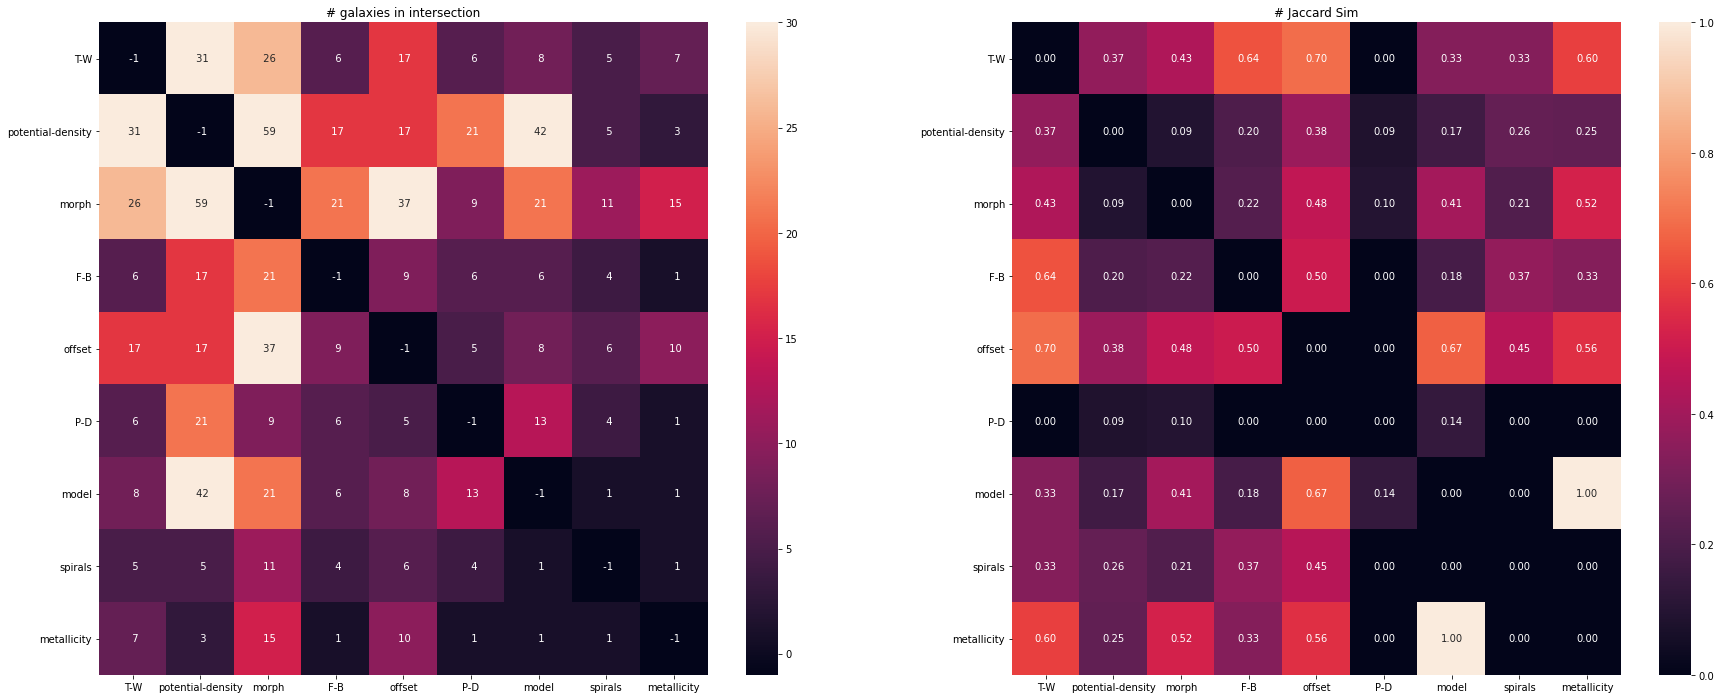

In [18]:
fig = plt.figure(figsize=[30,12])
ax = plt.subplot(121)
ax.set_title('# galaxies in intersection')
sns.heatmap(mm, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

ax = plt.subplot(122)
ax.set_title('# Jaccard Sim')
sns.heatmap(metric, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=1., fmt="3.2f")

plt.show()

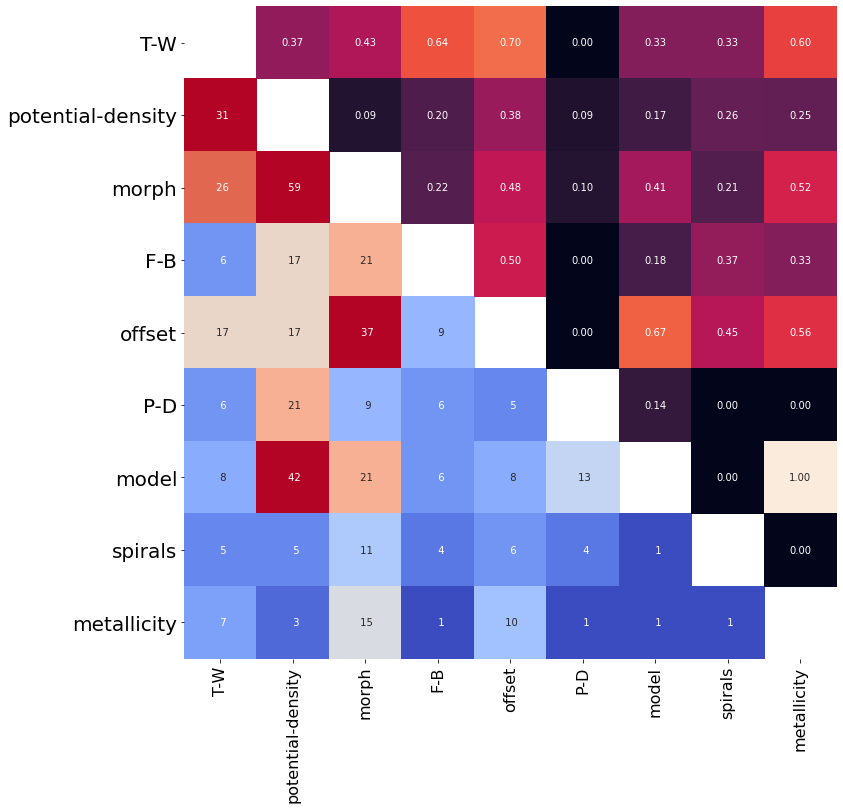

In [28]:
fig = plt.figure(figsize=[12,12])

mask = np.triu(np.full(m.shape, True))
# for i in range(len(mask)):
#     mask[i,i]=False

ax = plt.subplot(111)
g = sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f", cmap= 'coolwarm', cbar=False, square=True, mask=mask)
g.axes.set_xticklabels(g.axes.get_xmajorticklabels(), fontsize = 16, rotation=25)
g.axes.set_yticklabels(g.axes.get_ymajorticklabels(), fontsize = 20, rotation=45)

g = sns.heatmap(metric, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=g.axes, vmax=1., fmt="3.2f", cbar=False, square=True, mask=np.tril(np.full(m.shape, True)))

plt.show()

## overlapping

Просто количество совпавших (первого со вторым):

In [115]:
metric2 = np.zeros((len(ALL_METHODS), len(ALL_METHODS)))

for ind1, method1 in enumerate(methods):
    for ind2, method2 in enumerate(methods):
        
        if method1==method2 or method1=='spiral' or method2 == 'spiral':
            continue
        
        gals_1 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method1]])
        gals_2 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method2]])
        intersection = set(gals_1).intersection(set(gals_2))
        
        if len(intersection) == 0:
            continue
        
        denom = 0
        common_crs = 0
        
        for gal in intersection:
            r25 = disc_r25_sizes[gal]
            crs1 = join_severl_cr_sources_for_gal(gal, method1)
            crs2 = join_severl_cr_sources_for_gal(gal, method2)
            
#             print(len(crs1))
#             print(len(crs2))
            
            for cr1 in crs1:
                denom+=1
                for cr2 in crs2:
                    intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
                    if intr:
                        common_crs+=1
                        break                    
        
#         print('!!!', common_crs, denom)
        metric2[ind1, ind2] = common_crs

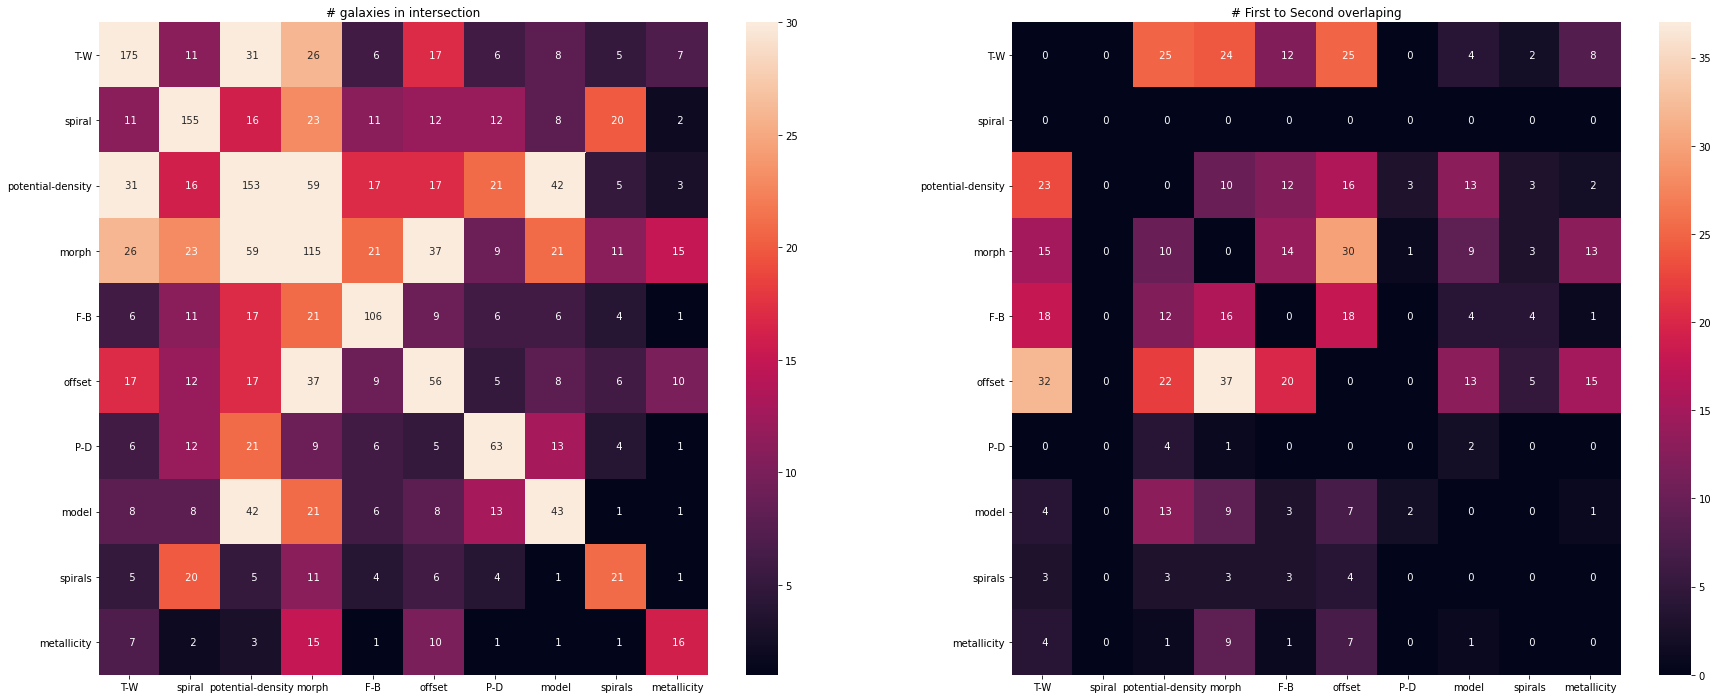

In [59]:
fig = plt.figure(figsize=[30,12])
ax = plt.subplot(121)
ax.set_title('# galaxies in intersection')
sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

ax = plt.subplot(122)
ax.set_title('# First to Second overlaping')
sns.heatmap(metric, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, fmt="3.0f")

plt.show()

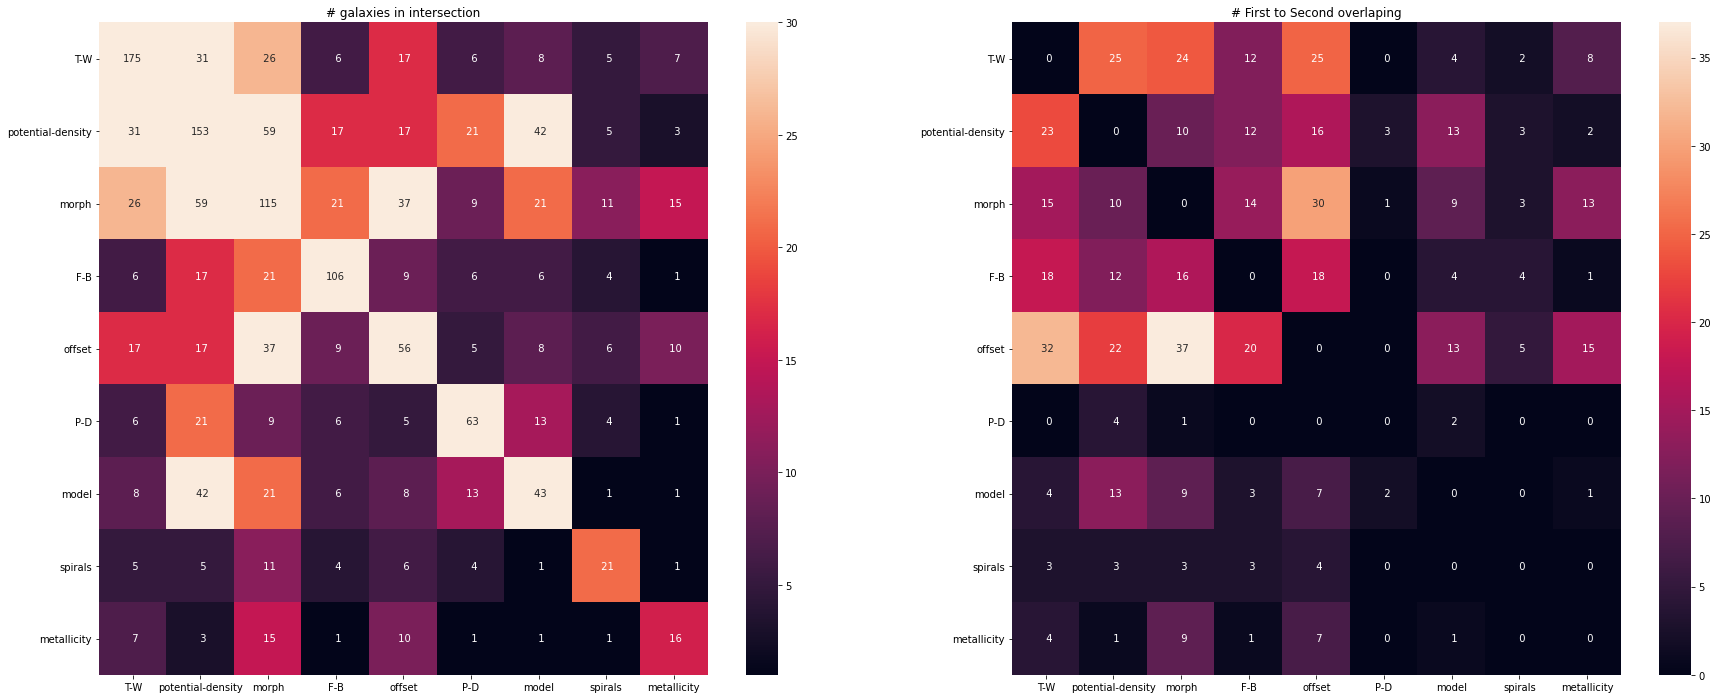

In [116]:
fig = plt.figure(figsize=[30,12])
ax = plt.subplot(121)
ax.set_title('# galaxies in intersection')
sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

ax = plt.subplot(122)
ax.set_title('# First to Second overlaping')
sns.heatmap(metric2, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, fmt="3.0f")

plt.show()

## совпадает полностью галактик

Если все радиусы по обоим методам совпали.

In [27]:
metric3 = np.zeros((len(ALL_METHODS), len(ALL_METHODS)))

for ind1, method1 in enumerate(methods):
    for ind2, method2 in enumerate(methods):
        
        if method1==method2 or method1=='spiral' or method2 == 'spiral':
            continue
        
        gals_1 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method1]])
        gals_2 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method2]])
        intersection = set(gals_1).intersection(set(gals_2))
        
        if len(intersection) == 0:
            continue
        
        
        
        for gal in intersection:
            
            if gal == 'MESSIER 031':
                print(method1, method2)
            
            denom = 0
            common_crs = 0
            
            r25 = disc_r25_sizes[gal]
            crs1 = join_severl_cr_sources_for_gal(gal, method1)
            crs2 = join_severl_cr_sources_for_gal(gal, method2)
            
#             print(len(crs1))
#             print(len(crs2))
            
            for cr1 in crs1:
                denom+=1
                for cr2 in crs2:
                    intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
                    if intr:
                        common_crs+=1
                        break                    
                
                
            for cr2 in crs2:
                denom+=1
                for cr1 in crs1:
                    intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
                    if intr:
                        common_crs+=1
                        break
                        
            if gal == 'MESSIER 031':
                print(crs1, crs2)
                print(common_crs, denom)
        
            if common_crs == denom:
                metric3[ind1, ind2] += 1
                
        metric3[ind1, ind2] /= len(intersection)

morph metallicity
[[4185.083025303405, 4185.083025303405]] [[3305.8879905356544, 5340.280600096056]]
2 2
metallicity morph
[[3305.8879905356544, 5340.280600096056]] [[4185.083025303405, 4185.083025303405]]
2 2


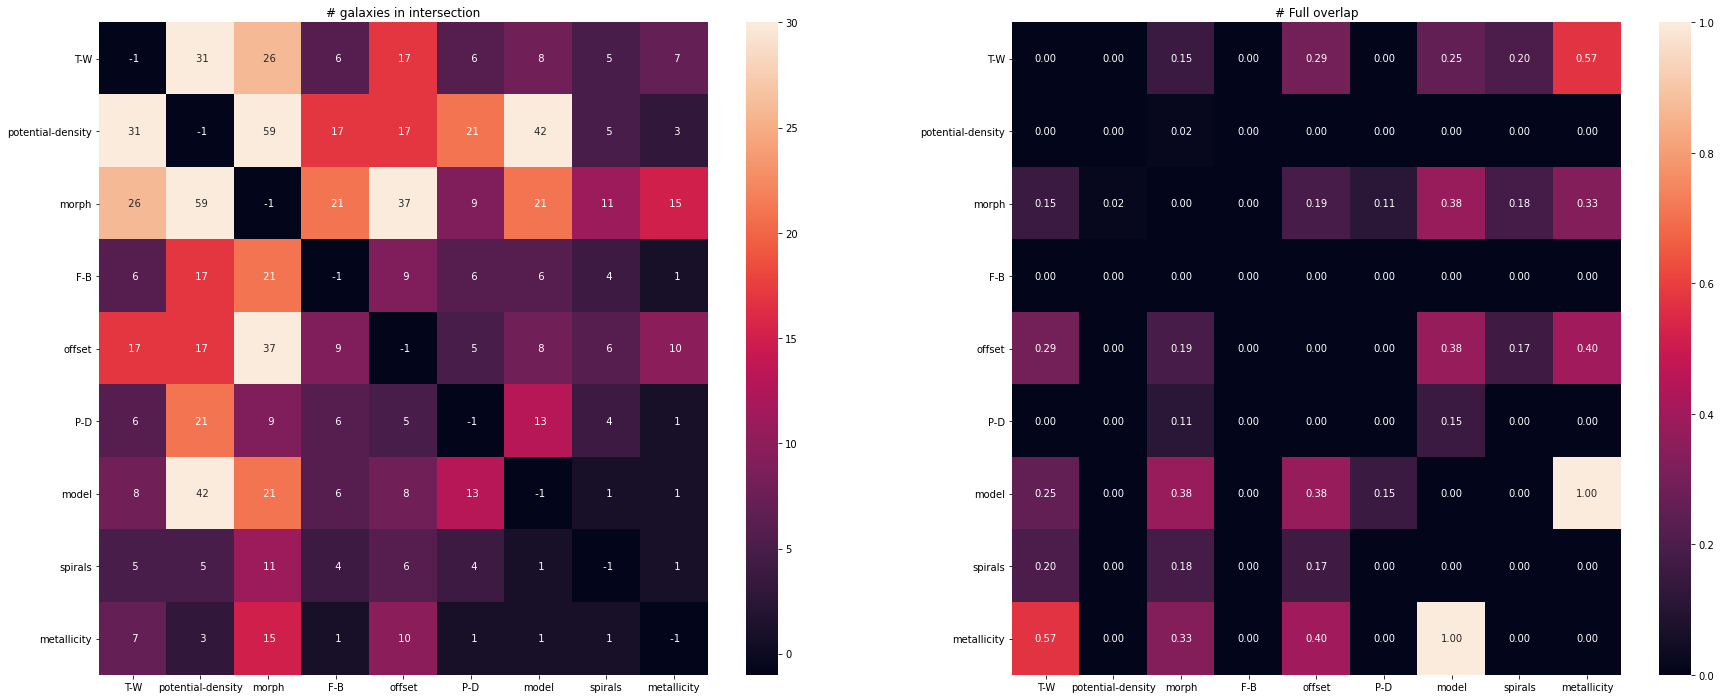

In [21]:
fig = plt.figure(figsize=[30,12])
ax = plt.subplot(121)
ax.set_title('# galaxies in intersection')
sns.heatmap(mm, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f")

ax = plt.subplot(122)
ax.set_title('# Full overlap')
sns.heatmap(metric3, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=1., fmt="3.2f")

plt.show()

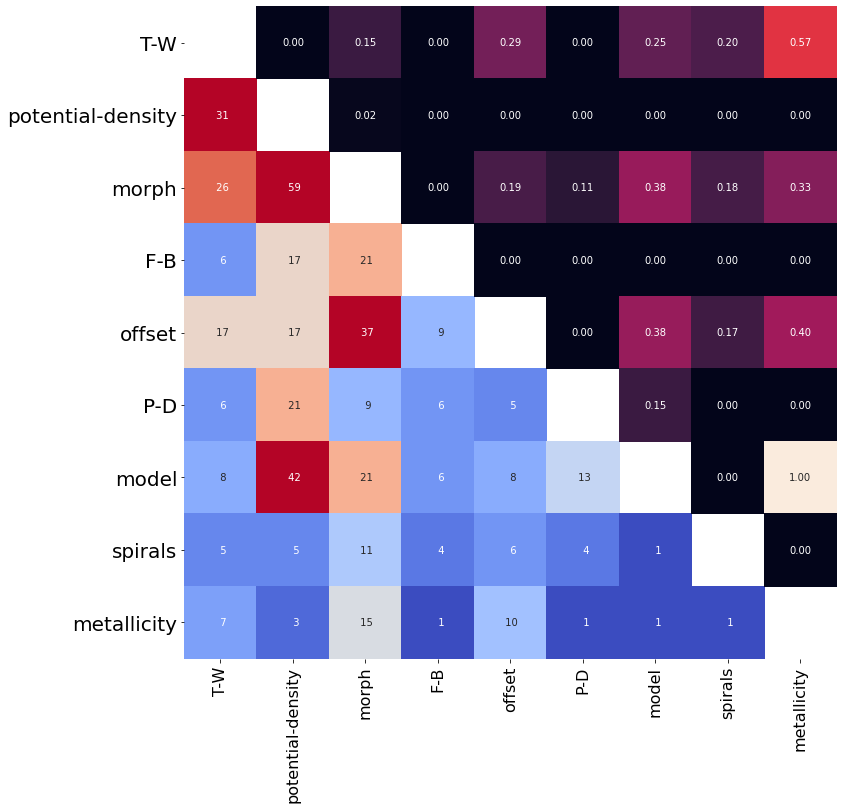

In [29]:
fig = plt.figure(figsize=[12,12])

mask = np.triu(np.full(m.shape, True))
# for i in range(len(mask)):
#     mask[i,i]=False

ax = plt.subplot(111)
g = sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f", cmap= 'coolwarm', cbar=False, square=True, mask=mask)
g.axes.set_xticklabels(g.axes.get_xmajorticklabels(), fontsize = 16, rotation=25)
g.axes.set_yticklabels(g.axes.get_ymajorticklabels(), fontsize = 20, rotation=45)

g = sns.heatmap(metric3, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=g.axes, vmax=1., fmt="3.2f", cbar=False, square=True, mask=np.tril(np.full(m.shape, True)))

plt.show()

In [ ]:
savepath = '/mnt/sdb2/to_dacha/proceeding_template/img1.png'


fig = plt.figure(figsize=[12,12])

mask = np.triu(np.full(m.shape, True))
# for i in range(len(mask)):
#     mask[i,i]=False

sns.set(font_scale=1.4)

ax = plt.subplot(111)
g = sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f", cmap= 'coolwarm', cbar=False, square=True, mask=mask)

g = sns.heatmap(metric3, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=g.axes, vmax=1., fmt="3.2f", cbar=False, square=True, mask=np.tril(np.full(m.shape, True)))
g.axes.set_xticklabels(g.axes.get_xmajorticklabels(), fontsize = 16, rotation=25)
g.axes.set_yticklabels(g.axes.get_ymajorticklabels(), fontsize = 20, rotation=45)

plt.tight_layout()
plt.savefig(savepath, facecolor='white')

plt.show()

## lin regression

In [71]:
# band_to_pop = {'NIR' : 'S', 
#  'GALEX' : 'None', 
#  'B?' : 'S', 
#  'CALIFA' : 'S', 
#  '12+log(O/H)' : 'S', 
#  'I' : 'S', 
#  'SN' : 'None', 
#  'i' : 'S', 
#  'B' : 'S', 
#  'H-band' : 'S', 
#  '24mu' : 'None', 
#  'CALIFAV1200' : 'S', 
#  'HII' : 'S', 
#  'various?' : 'None', 
#  'MANGA' : 'S', 
#  'optical' : 'S', 
#  'different' : 'None', 
#  'SDSS' : 'S', 
#  'MUSE' : 'S', 
#  'HI' : 'ISM', 
#  'J' : 'S', 
#  'Halpha' : 'ISM', 
#  'g' : 'S', 
#  'CO' : 'ISM', 
#  'Spitzer' : 'None', 
#  'r' : 'S'}

# pop_marker = {'ISM' : 's', 
#               'S' : 'o', 
#               'None' : '.'}


pop_marker = {'ISM' : u'o', 
              'stellar' : u's', 
              'both' : u'.'}

In [72]:
def join_severl_cr_sources_for_gal(gal, method, r25_norm=False):
    crs = []
    
    r25 = disc_r25_sizes[gal]
    
    for _ in ALL_METHODS[method]:
        if gal in _['reverse_names_map'].keys():
            name = _['reverse_names_map'][gal]
            crs_ = _['cr'][name]
            for info in crs_:
                if len(info) == 3:
                    cr, cr_r, cr_l = info
                else:
                    cr, cr_r = info
                    cr_l = cr_r
                if r25_norm:
                    crs.append([(cr-abs(cr_l))/r25, (cr+abs(cr_r))/r25, cr/r25])
                else:
                    crs.append([cr-abs(cr_l), cr+abs(cr_r), cr])
                
    return crs

In [73]:
def find_closest(cr, crs):
#     print(cr, crs)
    dists = np.array([_[2] for _ in crs])
    dists = np.abs(dists - cr[2])
    mi = dists.argmin()
    return crs[mi]

In [74]:
import statsmodels.api as sm
from scipy.odr import *

https://en.wikipedia.org/wiki/Deming_regression

In [78]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.odr import *

# import random

# # Initiate some data, giving some randomness using random.random().
# x = np.array([0, 1, 2, 3, 4, 5])
# y = np.array([i**2 + random.random() for i in x])

# x_err = np.array([random.random() for i in x])
# y_err = np.array([random.random() for i in x])

# # Define a function (quadratic in our case) to fit the data with.
# def quad_func(p, x):
#     m, c = p
#     return m*x**2 + c

# # Create a model for fitting.
# quad_model = Model(quad_func)

# # Create a RealData object using our initiated data from above.
# data = RealData(x, y, sx=x_err, sy=y_err)

# # Set up ODR with the model and data.
# odr = ODR(data, quad_model, beta0=[0., 1.])

# # Run the regression.
# out = odr.run()

# # Use the in-built pprint method to give us results.
# out.pprint()
# '''Beta: [ 1.01781493  0.48498006]
# Beta Std Error: [ 0.00390799  0.03660941]
# Beta Covariance: [[ 0.00241322 -0.01420883]
#  [-0.01420883  0.21177597]]
# Residual Variance: 0.00632861634898189
# Inverse Condition #: 0.4195196193536024
# Reason(s) for Halting:
#   Sum of squares convergence'''

# x_fit = np.linspace(x[0], x[-1], 1000)
# y_fit = quad_func(out.beta, x_fit)

# plt.errorbar(x, y, xerr=x_err, yerr=y_err, linestyle='None', marker='x')
# plt.plot(x_fit, y_fit)

# plt.show()

In [75]:
list(methods)

['T-W',
 'potential-density',
 'morph',
 'F-B',
 'offset',
 'P-D',
 'model',
 'spirals',
 'metallicity']

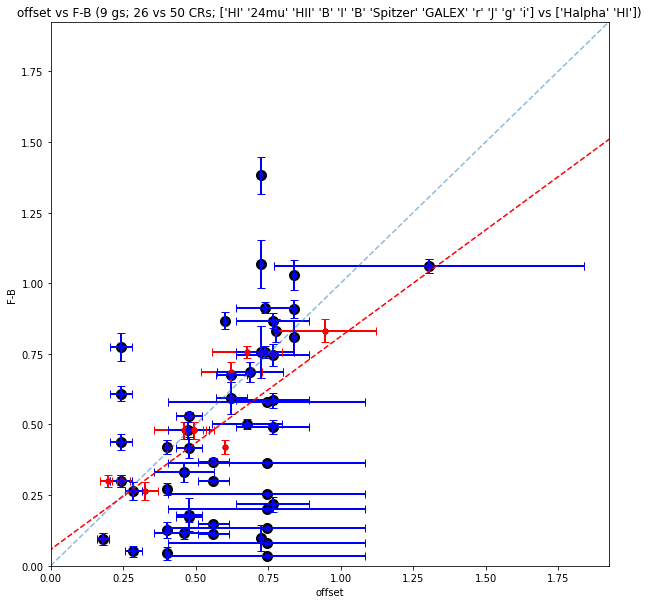

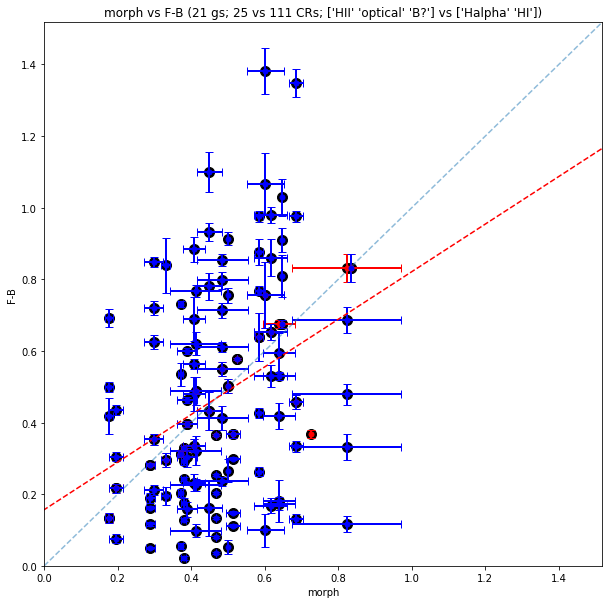

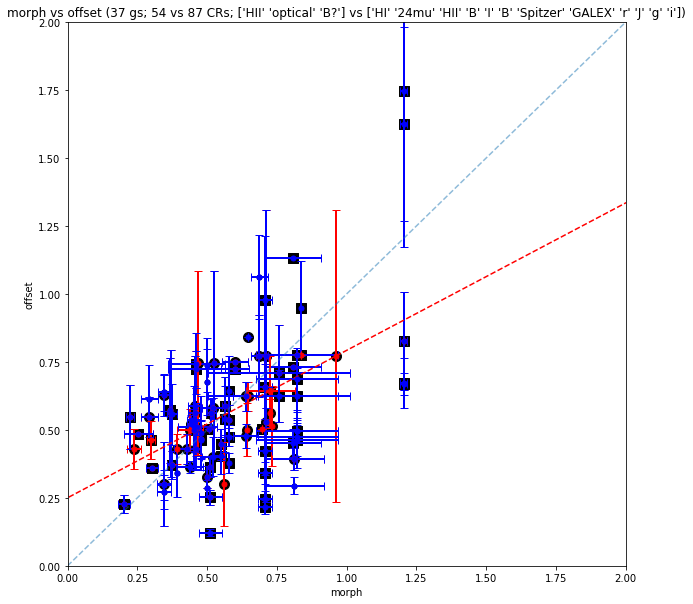

KeyError: 'SNs'

In [79]:
metric = np.zeros((len(ALL_METHODS), len(ALL_METHODS)))

def quad_func(p, x):
    m, c = p
    return m*x + c

# fig, axes = plt.subplots(figsize=[32, 48], ncols=4, nrows=6)
# axes = axes.flatten()
count = 0

for ind1, method1 in enumerate(list(methods)):
    for ind2, method2 in enumerate(list(methods)):
        
        if method1==method2 or method1=='spiral' or method2 == 'spiral':
            continue
            
        if ind1 < ind2:
            continue
            
        
        gals_1 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method1]])
        gals_2 = np.concatenate([list(_['reverse_names_map'].keys()) for _ in ALL_METHODS[method2]])
        intersection = set(gals_1).intersection(set(gals_2))
        
        
        bands1 = np.concatenate([_['bands'].replace(' ', '').strip().split(',') for _ in ALL_METHODS[method1]])
#         bands1 = set([band_to_pop[_] for _ in bands1])
        
        bands2 = np.concatenate([_['bands'].replace(' ', '').strip().split(',') for _ in ALL_METHODS[method2]])
#         bands2 = set([band_to_pop[_] for _ in bands2])
        
        ms1 = np.concatenate([[pop_marker[_['kind']]]*len(list(_['reverse_names_map'].keys())) for _ in ALL_METHODS[method1]])
        ms2 = np.concatenate([[pop_marker[_['kind']]]*len(list(_['reverse_names_map'].keys())) for _ in ALL_METHODS[method2]])
        
        if len(intersection) == 0:
            continue
        
        if len(intersection) < 7:
            continue
        
        fig = plt.figure(figsize=[10,10])
        ax = plt.gca()
#         ax = axes[count]
        ax.set_xlabel(method1)
        ax.set_ylabel(method2)
        
        x,y,x_err,y_err = [],[],[],[]
        
        num_crs1 = 0
        num_crs2 = 0
        
        for ind, gal in enumerate(intersection):
            
            if gal == 'MESSIER 031':
                print(method1, method2)
            
            
            
            r25 = disc_r25_sizes[gal]
            crs1 = join_severl_cr_sources_for_gal(gal, method1, r25_norm=True)
            crs2 = join_severl_cr_sources_for_gal(gal, method2, r25_norm=True)
            
            
            
            for cr1 in crs1:
                    num_crs1+=1
#                 try:
                    cr2 = find_closest(cr1, crs2)
                    ax.scatter(cr1[2], cr2[2], 100, marker=ms1[ind], color='k')
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='10', ecolor='red',capsize=4, elinewidth=2)
                    
                    x.append(cr1[2])
                    y.append(cr2[2])
                    x_err.append(0.5*(abs(y1)+abs(y2)))
                    y_err.append(0.5*(abs(x1)+abs(x2)))
                    
#                 except:
#                     pass
                
            for cr2 in crs2:
                    num_crs2+=1
#                 try:
                    cr1 = find_closest(cr2, crs1)
                    ax.scatter(cr1[2], cr2[2], 100, marker=ms2[ind], color='k')
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='blue', fmt='.', markersize='10', ecolor='blue',capsize=4, elinewidth=2)
                    
                    x.append(cr1[2])
                    y.append(cr2[2])
                    x_err.append(0.5*(abs(y1)+abs(y2)))
                    y_err.append(0.5*(abs(x1)+abs(x2)))
                    
#                 except:
#                     pass
                
                
            
            
#             for cr1 in crs1:
#                 denom+=1
#                 for cr2 in crs2:
#                     intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
#                     if intr:
#                         ax.scatter(cr1[2], cr2[2])
#                         y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
#                         x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
#                         ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='10', ecolor='red',capsize=4, elinewidth=2)
#                         break                    
                
                
#             for cr2 in crs2:
#                 denom+=1
#                 for cr1 in crs1:
#                     intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
#                     if intr:
# #                         ax.scatter(cr1[2], cr2[2], color=)
#                         y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
#                         x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
#                         ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='blue', fmt='.', markersize='10', ecolor='blue',capsize=4, elinewidth=2)
#                         break
                        
#             if gal == 'MESSIER 031':
#                 print(crs1, crs2)
#                 print(common_crs, denom)
        
#             if common_crs == denom:
#                 metric[ind1, ind2] += 1

#         quad_model = Model(quad_func)
#         # Create a RealData object using our initiated data from above.
#         data = RealData(np.array(x), np.array(y), sx=1./np.array(x_err)**2, sy=1./np.array(y_err)**2)

#         # Set up ODR with the model and data.
#         odr = ODR(data, quad_model, beta0=[1., 1.])

#         # Run the regression.
#         out = odr.run()
        
        
        
        x = sm.add_constant(np.array(x).reshape((-1, 1)))
#         ols = sm.WLS(np.array(y), x, weights=(np.array(y_err)+np.array(x_err)+0.00001)**2)
        ols = sm.WLS(np.array(y), x)
        ols_result = ols.fit()

        slope, err_slope = ols_result.params[1], ols_result.bse[1]
        intercept, err_intercept = ols_result.params[0], ols_result.bse[0]
        r_value = ols_result.rsquared        
        
    
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([0., max(xlim[1],ylim[1])], [0., max(xlim[1],ylim[1])], '--', alpha=0.5)
        
        
#         x_fit = np.array([0, max(xlim[1],ylim[1])])
#         y_fit = quad_func(out.beta, x_fit)
#         plt.plot(x_fit, y_fit, '-', color='g', alpha=0.6)
        
        
        if ax is not None:
            xlim0, xlim1 = ax.get_xlim()
            ax.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
        
        ax.set_xlim(0, min(max(xlim[1],ylim[1]),2))
        ax.set_ylim(0, min(max(xlim[1],ylim[1]),2))
        ax.set_title(f'{method1} vs {method2} ({len(intersection)} gs; {num_crs1} vs {num_crs2} CRs; {bands1} vs {bands2})')
        count+=1
#         1/0
        
        plt.show()
#         1/0

In [76]:
df = pd.read_csv('total_crs.csv', index_col=0)
df.sample(5)

name             method    bar     kind      bands  \
718   NGC1808  potential-density  False  stellar     H-band   
802   NGC4123  potential-density  False  stellar     H-band   
1356  NGC1512                T-W  False  stellar       MUSE   
1292  NGC3507                T-W  False      ISM  CO,Halpha   
1278  NGC2283                T-W  False      ISM  CO,Halpha   

                                                   link  \
718   https://iopscience.iop.org/article/10.1088/006...   
802   https://iopscience.iop.org/article/10.1088/006...   
1356               https://arxiv.org/pdf/2102.01091.pdf   
1292               https://arxiv.org/pdf/2102.01091.pdf   
1278               https://arxiv.org/pdf/2102.01091.pdf   

                  paper_name          cr   err_cr_l   err_cr_r        cr_l  \
718      Buta & Zhang (2009)  106.000000   0.000000   0.000000  106.000000   
802      Buta & Zhang (2009)  108.900000   0.000000   0.000000  108.900000   
1356  Williams et al. (2021)   64.611224  26.243514  26.243514   38.367710   
1292  Williams et al. (2021)   36.762507  24.426095  24.426095   12.336412   
1278  Williams et al. (2021)    1.983316   1.983316   1.983316    0.000000   

            cr_r  err_range   altname         r25  
718   106.000000   0.000000  NGC 1808  162.600267  
802   108.900000   0.000000  NGC 4123   95.306222  
1356   90.854738  52.487028  NGC 1512  253.000427  
1292   61.188603  48.852191  NGC 3507   87.522810  
1278    3.966631   3.966631  NGC 2283   82.817336

In [77]:
df['cr_r25'] = df['cr']/df['r25']

In [78]:
def find_closest(cr, crs):
#     print(cr, crs)
    dists = np.array([_[2] for _ in crs])
    dists = np.abs(dists - cr[2])
    mi = dists.argmin()
    return mi, crs[mi]

31
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
potential-density vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.19827417 0.05388746 0.51386686]
[0.21709242 0.25839851 0.16346698]


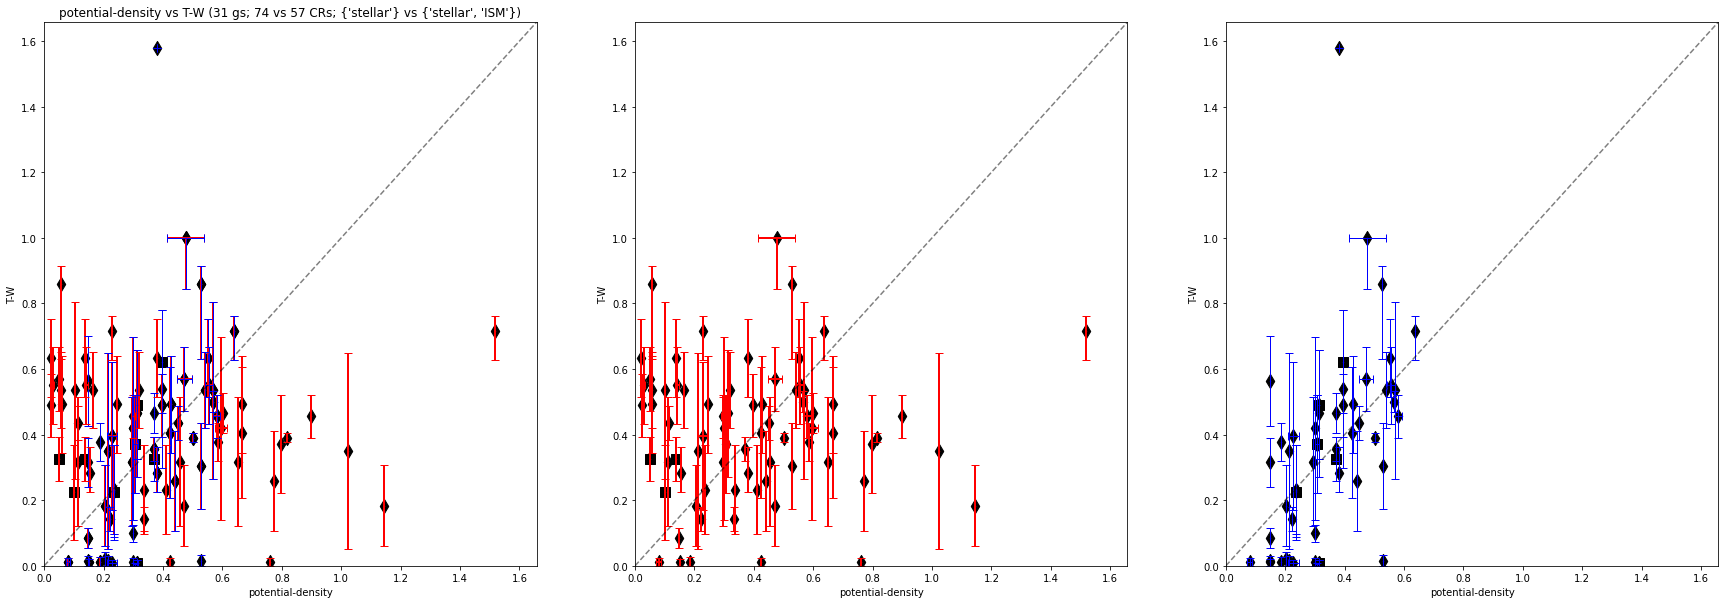

27
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
morph vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
[0.45877964 0.47496786 0.46592261]
[0.19807046 0.16785007 0.22015459]


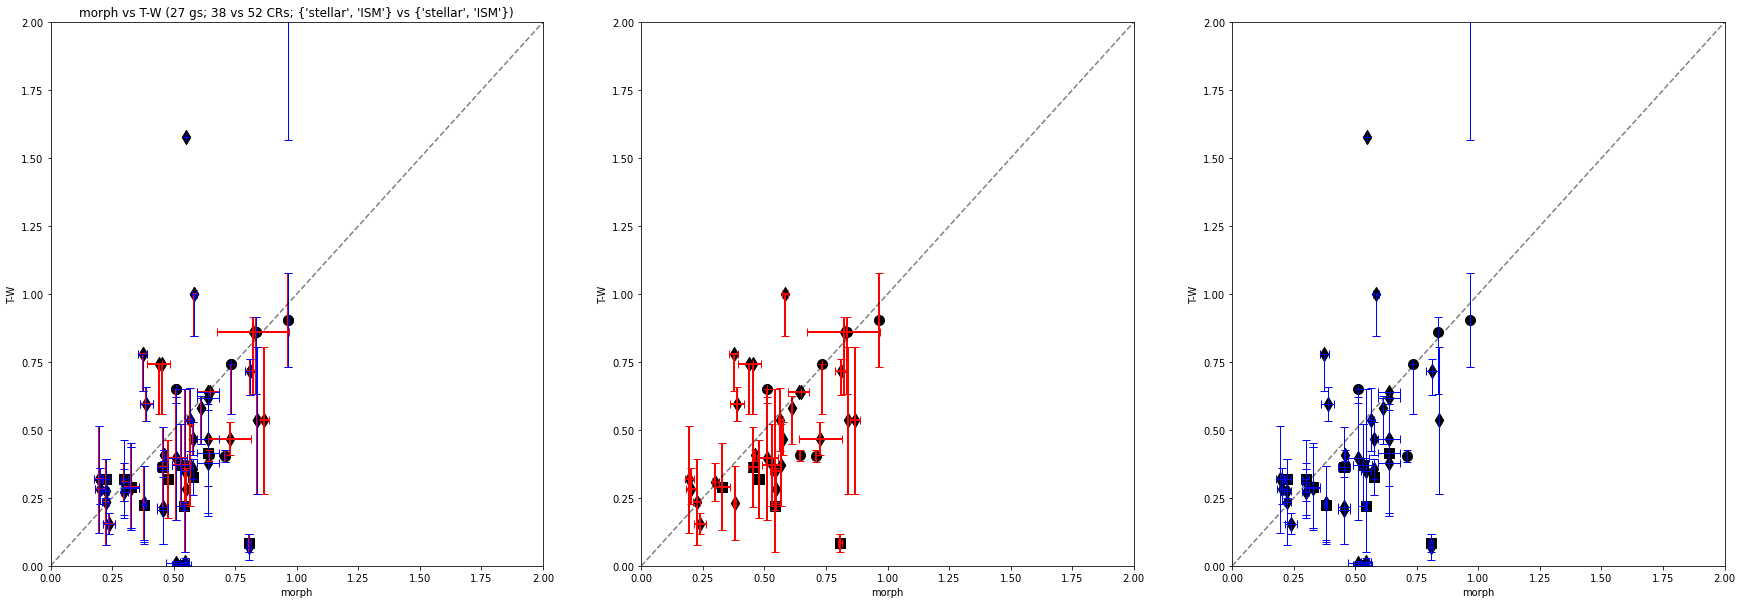

59
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
morph vs potential-density
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.50200877 0.82045558 0.45062714]
[0.25376711 0.13435515 0.30649447]


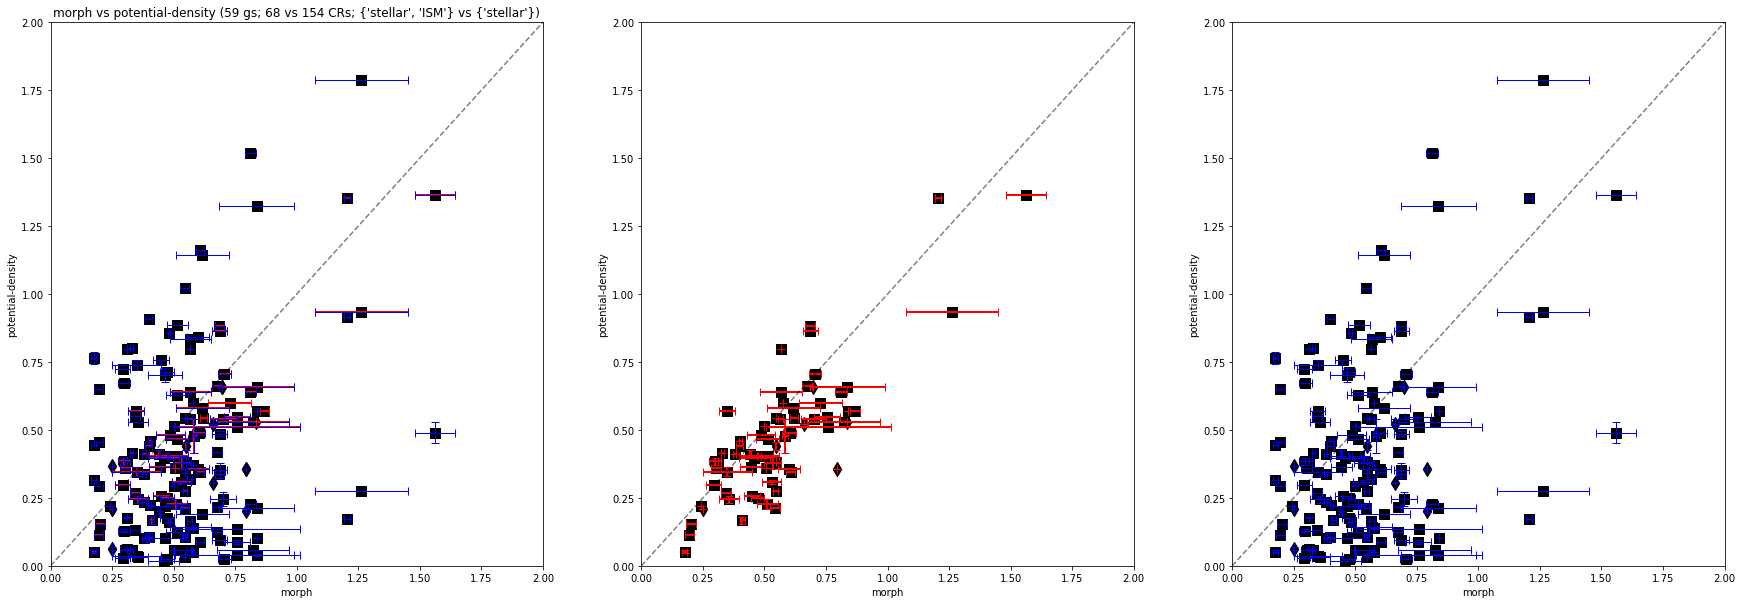

6
17
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
F-B vs potential-density
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.69458333 0.64349498 0.95886888]
[0.14551763 0.18323722 0.04686639]


21
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
F-B vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.3573683  0.30104404 0.84646583]
[0.21436201 0.24420927 0.06627368]


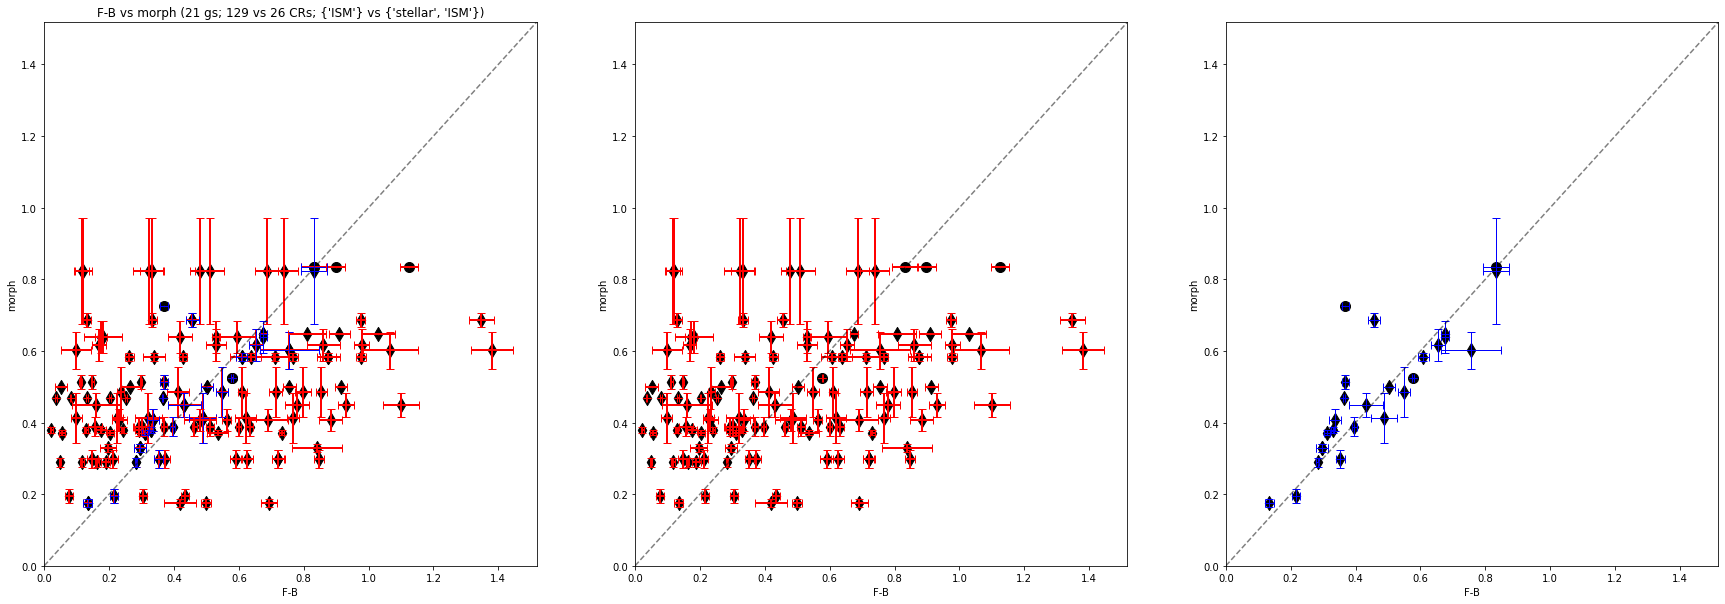

18
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
[0.37229585 0.49596347 0.24543617]
[0.16363949 0.1550034  0.17363918]


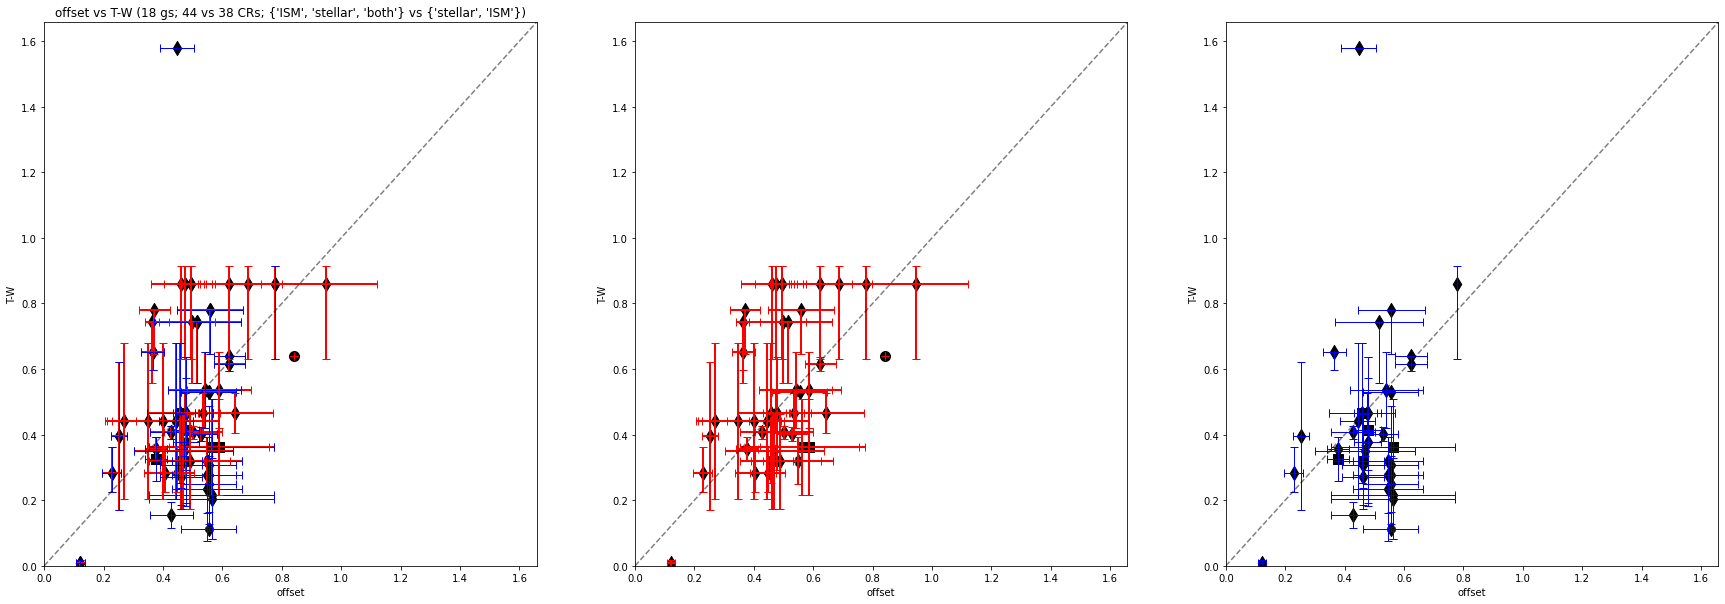

17
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs potential-density
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.76156542 0.87801141 0.67949986]
[0.19374625 0.13536865 0.25577246]


38
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
[0.53219724 0.52238216 0.58576343]
[0.16233902 0.18438504 0.12746622]


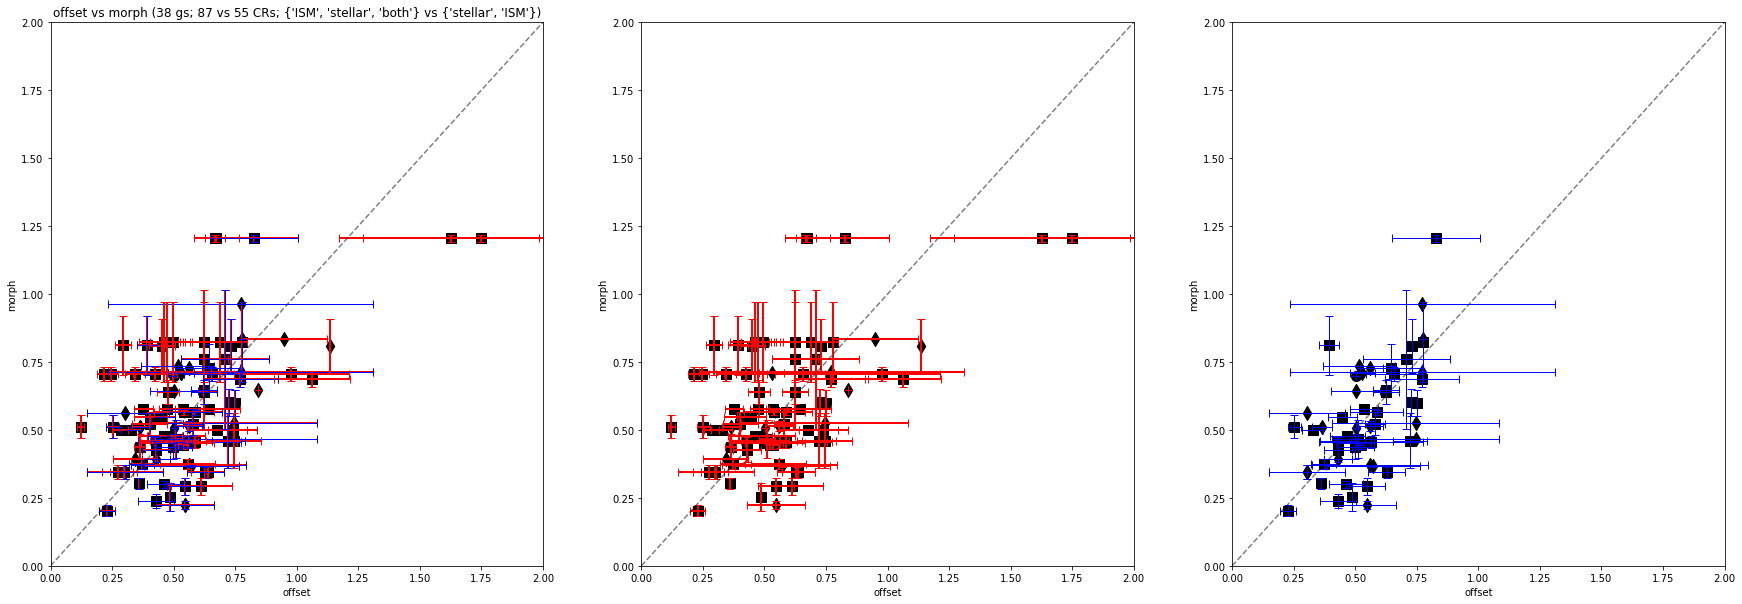

9
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.60627942 0.94110533 0.52158745]
[0.18093226 0.0635043  0.23545239]


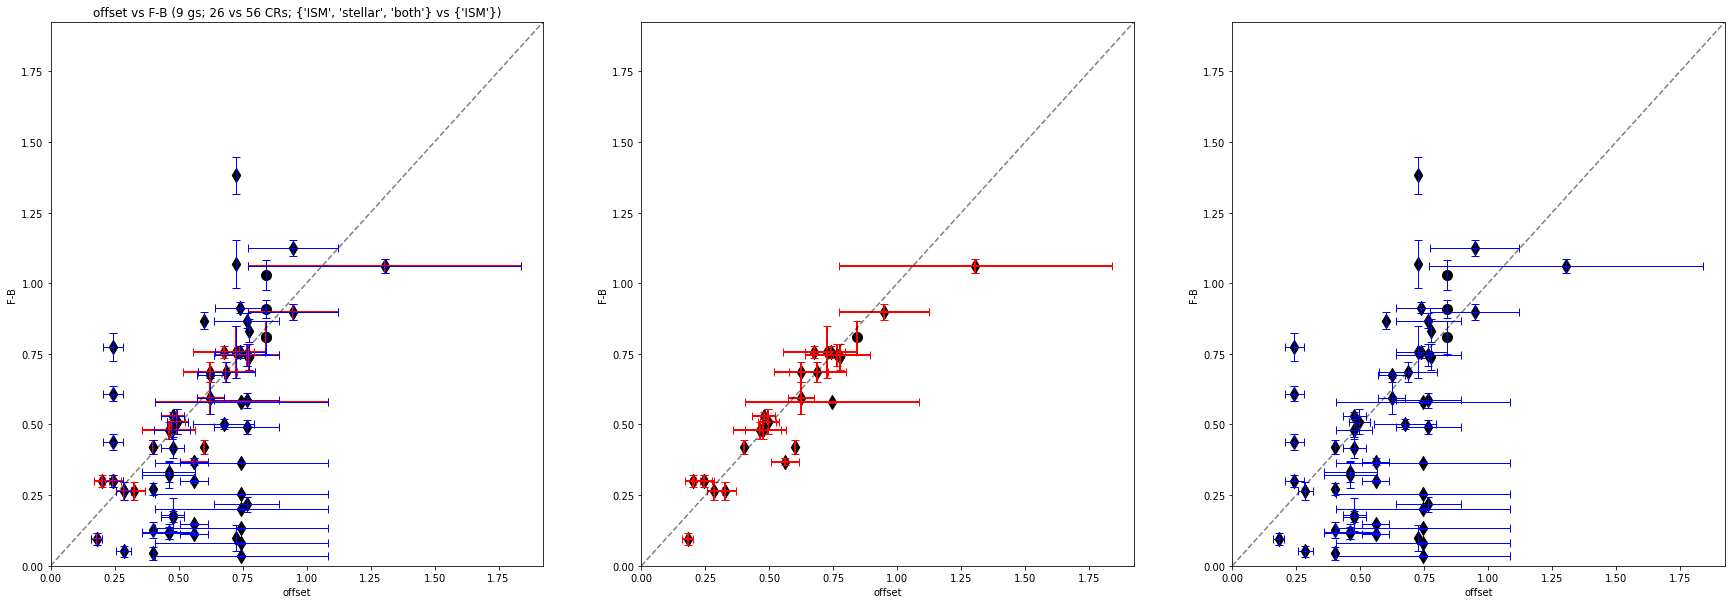

6
21
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
P-D vs potential-density
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.40451386 0.48363325 0.34974388]
[0.23337093 0.13907019 0.3001673 ]


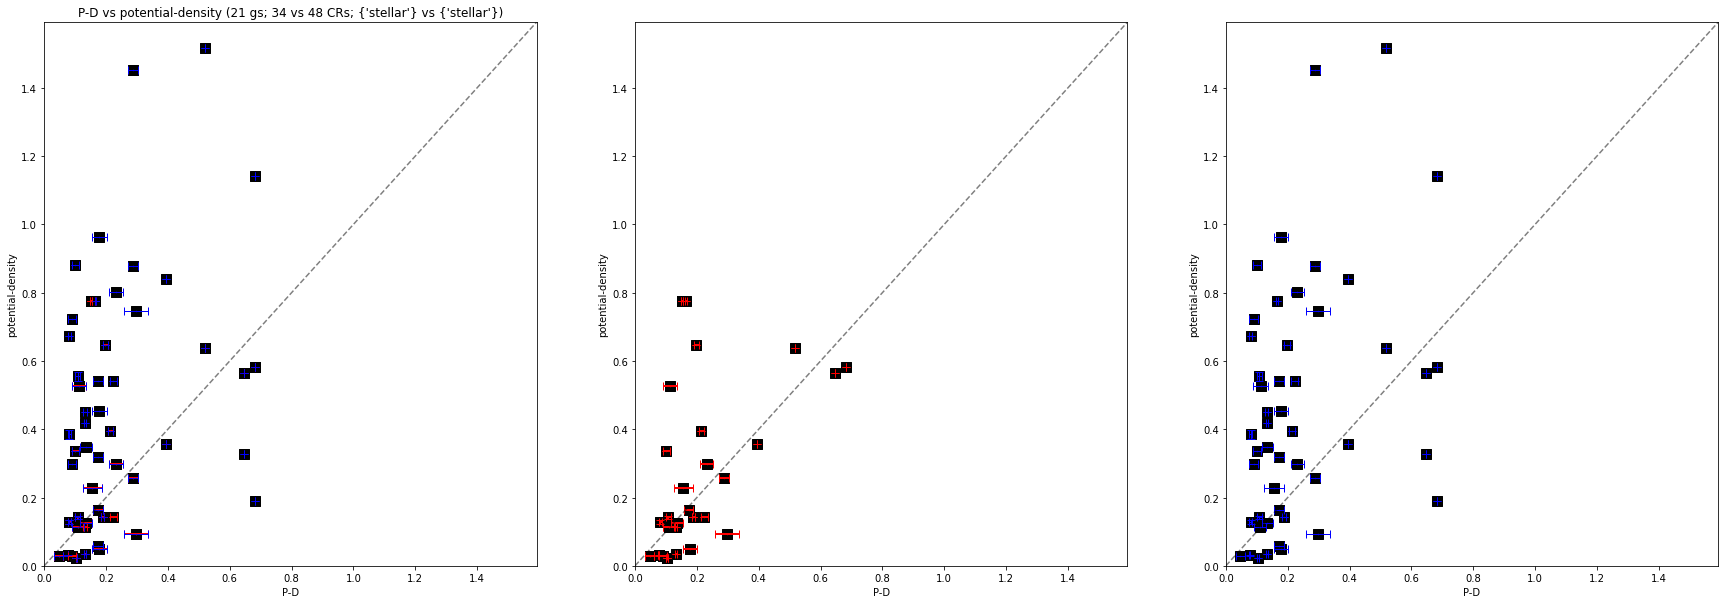

9
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
P-D vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.67998281 0.66515774 0.69817205]
[0.28377019 0.29611663 0.26730828]


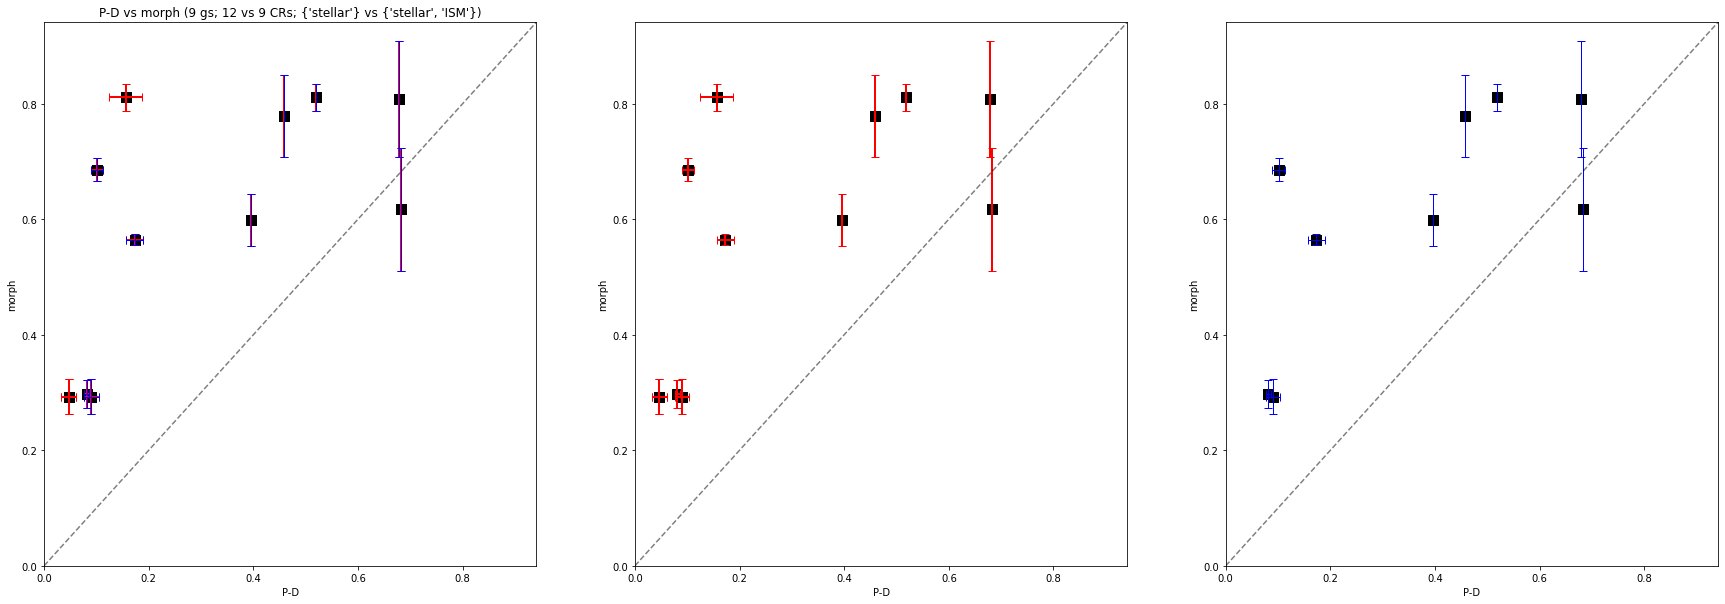

6
5
8
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.51241871 0.53197106 0.49180115]
[0.19610778 0.14085764 0.22373285]


42
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs potential-density
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.37481794 0.79775696 0.31035988]
[0.24504943 0.10537843 0.29742606]


21
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.50296484 0.53135102 0.47600734]
[0.16513004 0.16226477 0.16774616]


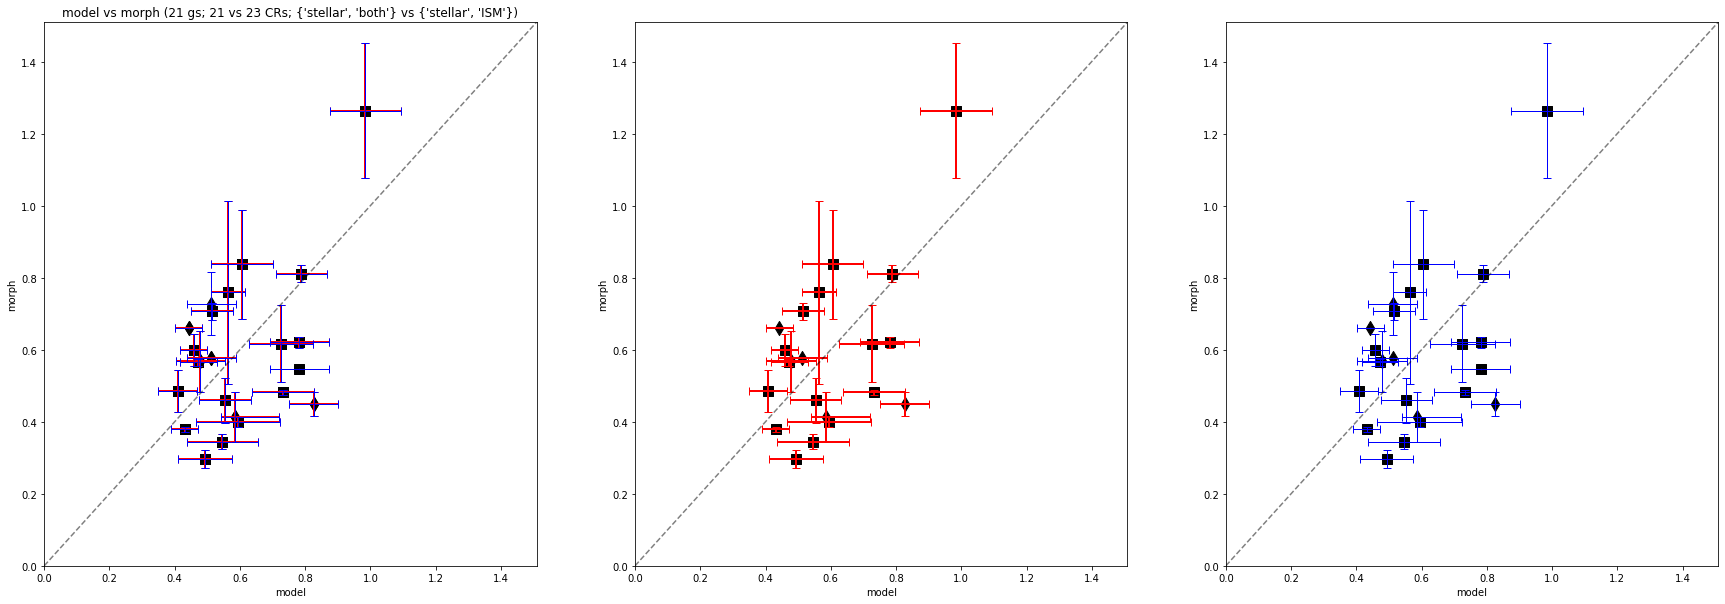

6
8
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.75849105 0.89575666 0.71186352]
[0.16046434 0.10503288 0.18062123]


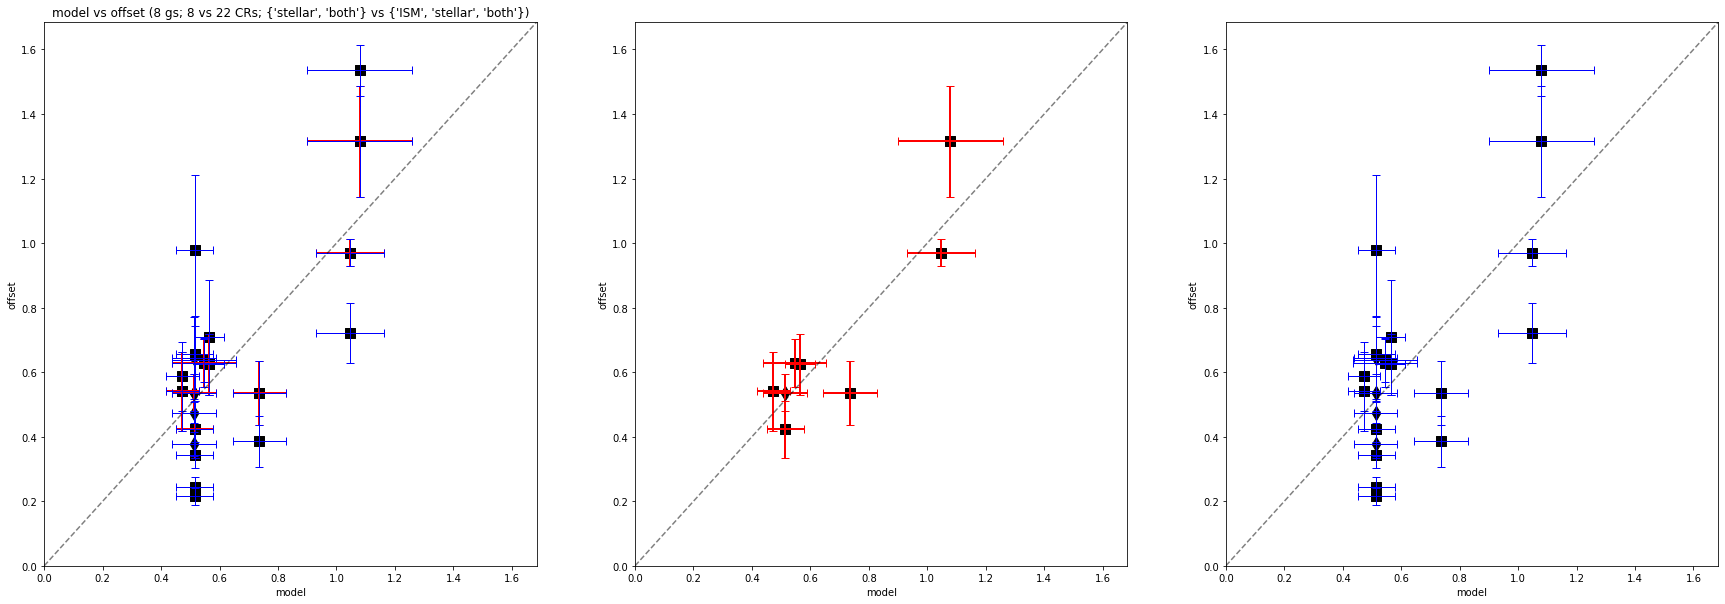

13
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs P-D
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.25556255 0.25586252 0.25588168]
[0.38787717 0.37281861 0.40011226]


5
5
11
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
spirals vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.74882698 0.77656764 0.72259407]
[0.24209151 0.27099751 0.20873844]


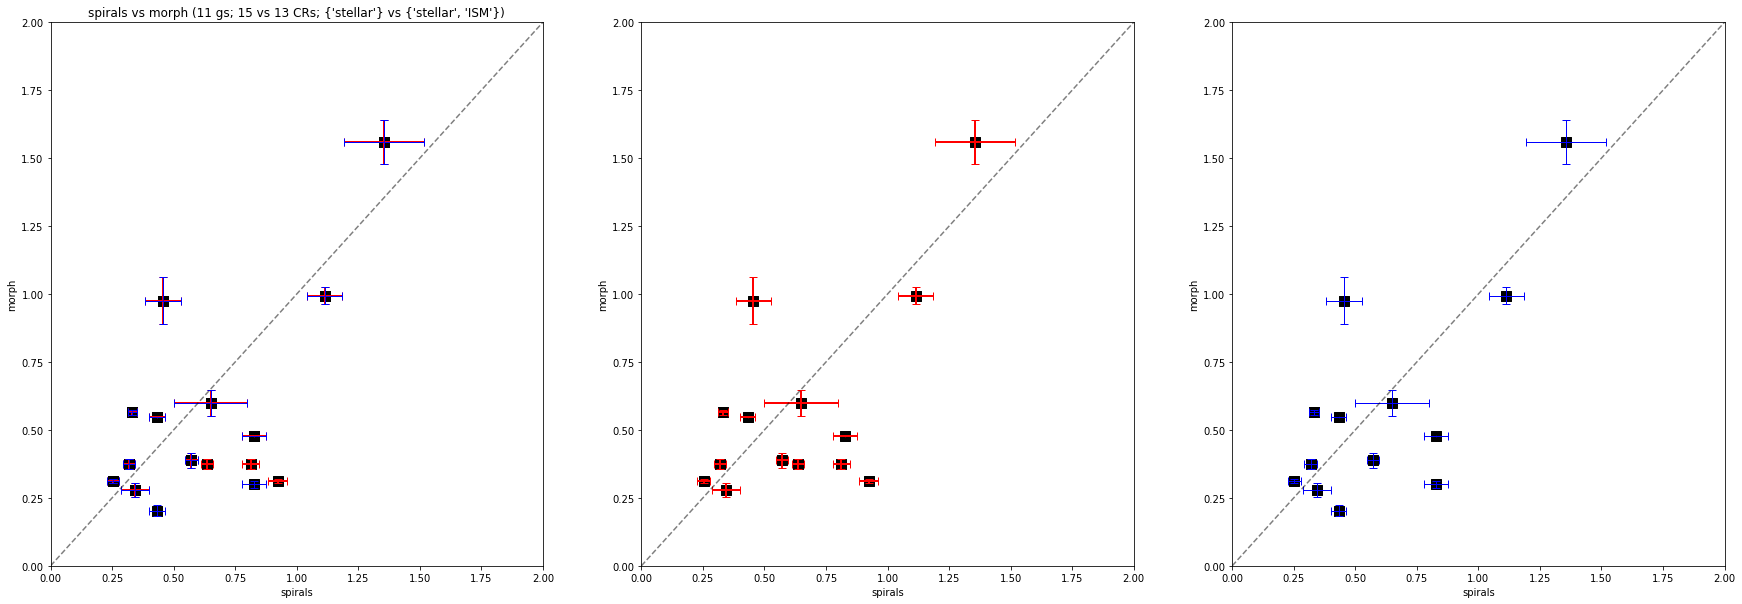

4
6
4
1
7
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.36746492 0.34800268 0.33855257]
[0.25749589 0.23885732 0.26753205]


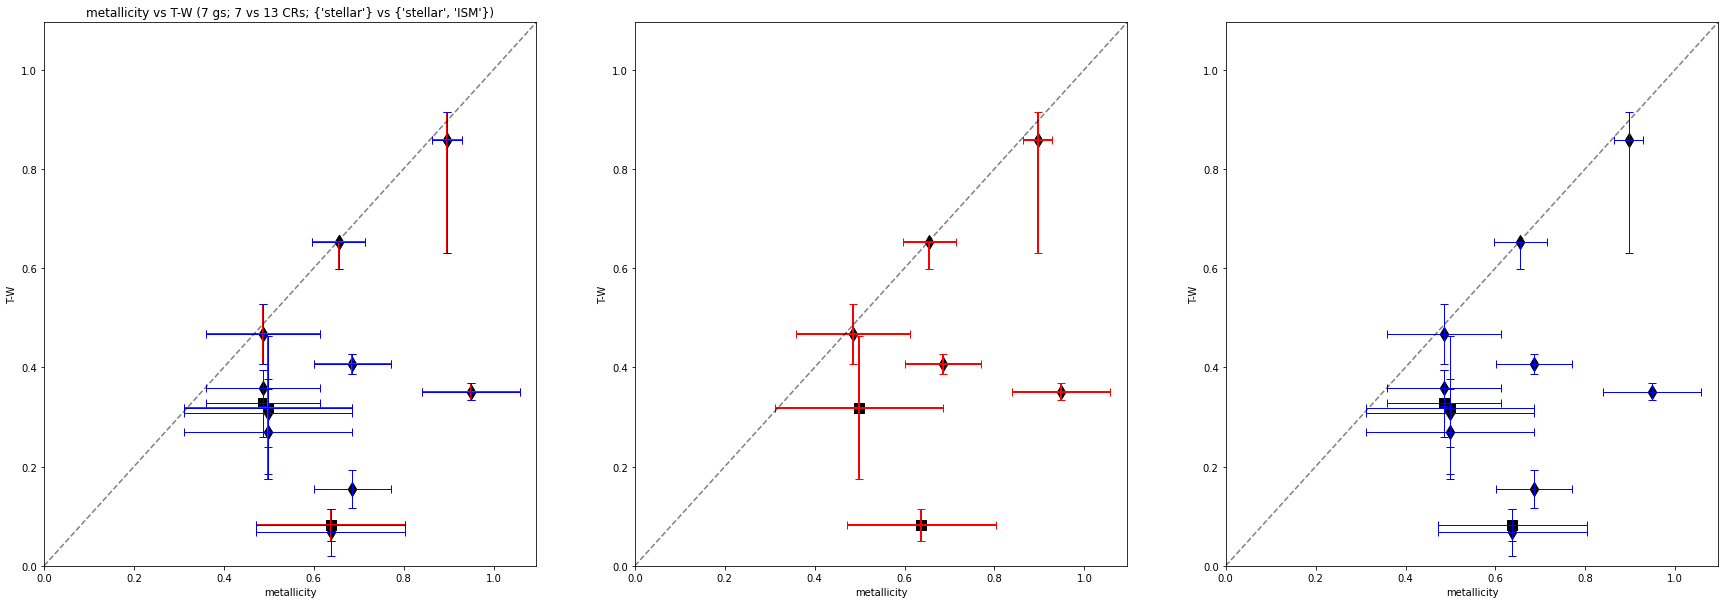

3
15
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity morph
[0.47321335 0.57379601 0.42243291]
[0.17106795 0.13588139 0.18991789]


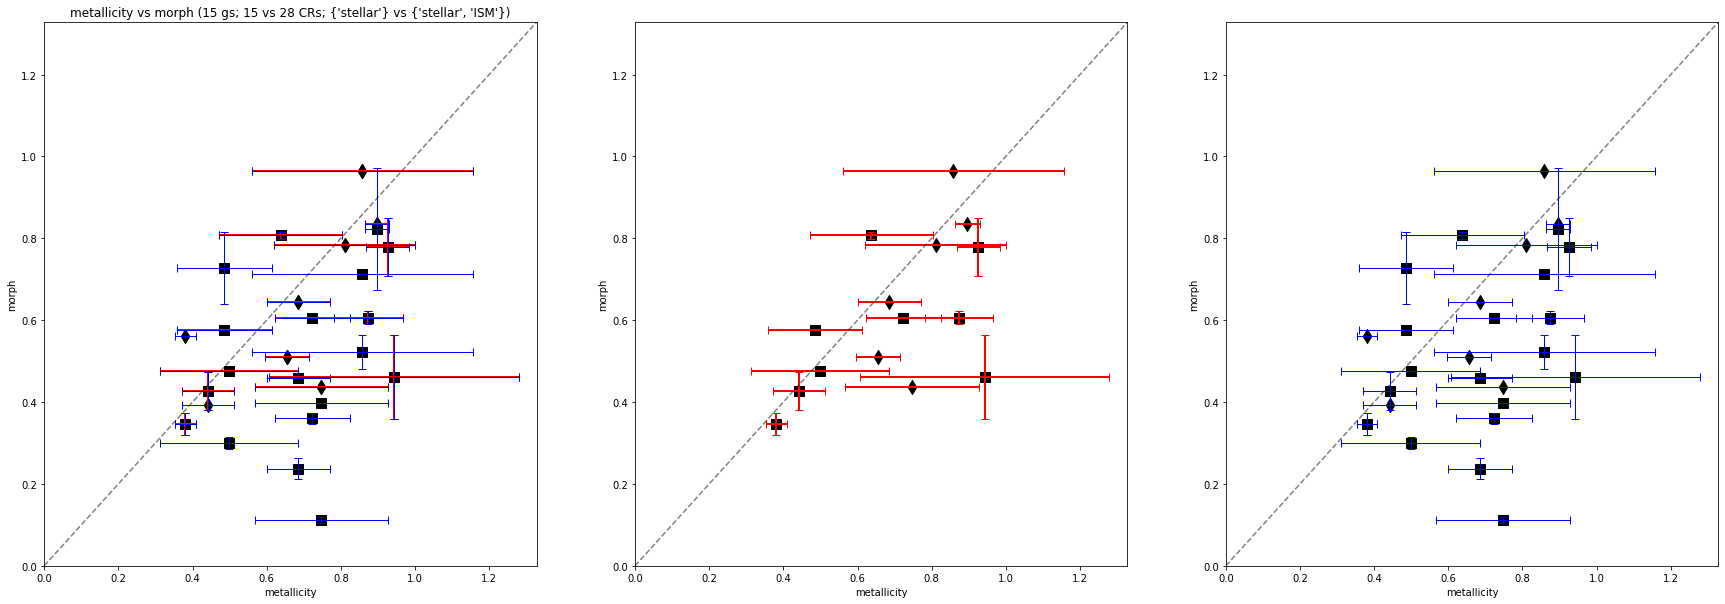

1
10
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
[0.64172935 0.71168283 0.62305812]
[0.17828217 0.14020988 0.19141054]


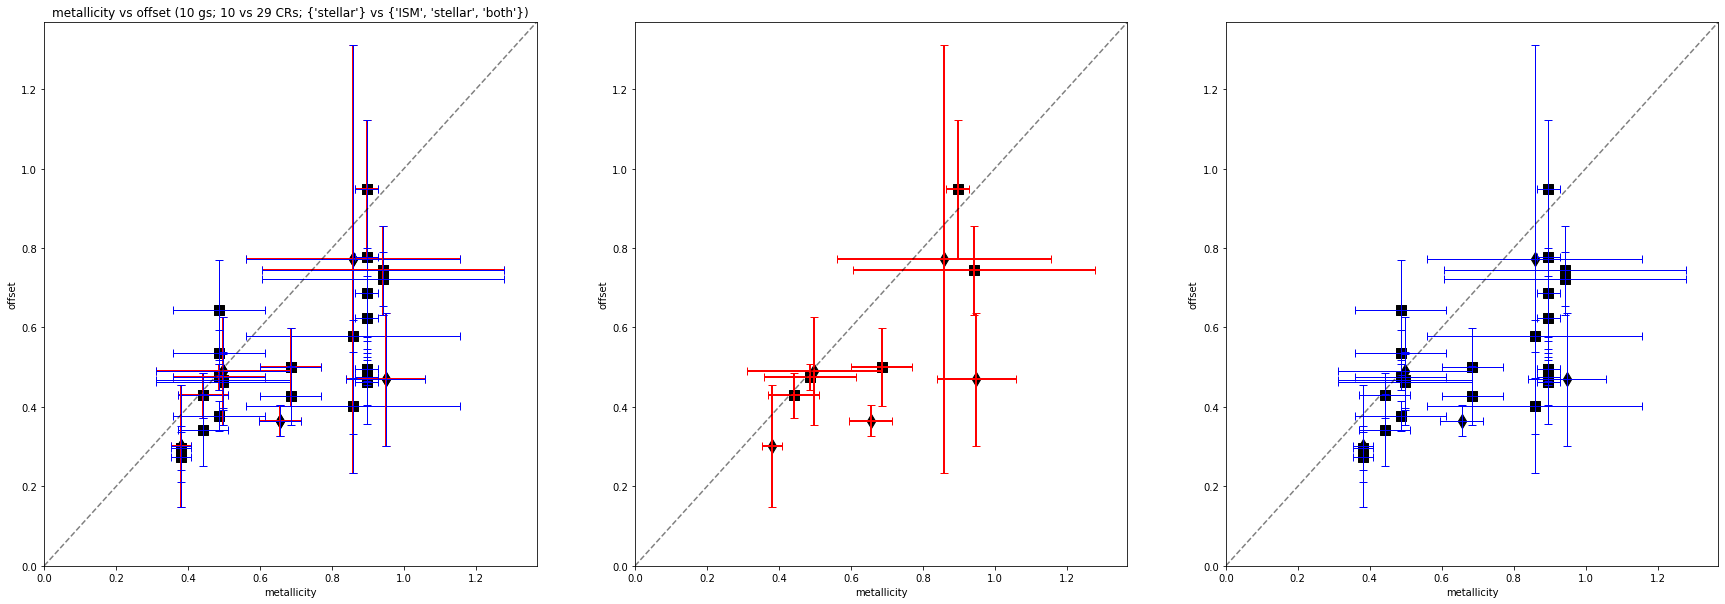

1
1
1


In [81]:

def quad_func(p, x):
    m, c = p
    return m*x + c

# fig, axes = plt.subplots(figsize=[32, 48], ncols=4, nrows=6)
# axes = axes.flatten()
count = 0

# methods = ALL_METHODS.keys()

metric4 = np.zeros((len(ALL_METHODS), len(ALL_METHODS), 3)) # corr. coeff
metric5 = np.zeros((len(ALL_METHODS), len(ALL_METHODS), 3)) # r25 dists

for ind1, method1 in enumerate(list(methods)):
    for ind2, method2 in enumerate(list(methods)):
        
        if method1==method2 or method1=='spiral' or method2 == 'spiral':
            continue
            
        if ind1 < ind2:
            continue
        
        gals_1 = df[df['method']==method1].altname.values
        gals_2 = df[df['method']==method2].altname.values
        intersection = set(gals_1).intersection(set(gals_2))
        
        
        bands1 = df[df['method']==method1].kind.values
        bands1 = set(bands1)
        
        bands2 = df[df['method']==method2].kind.values
        bands2 = set(bands2)
        
        print(len(intersection))
        
        
        if len(intersection) == 0:
            continue
        
        if len(intersection) < 7:
            continue
            
        print('-*'*50)
        print(f'{method1} vs {method2}')
        print('-*'*50)
        
        
        fig = plt.figure(figsize=[30,10])
        ax = plt.subplot(131)
        ax2 = plt.subplot(132)
        ax3 = plt.subplot(133)
#         ax = axes[count]
        ax.set_xlabel(method1)
        ax.set_ylabel(method2)
        
        ax2.set_xlabel(method1)
        ax2.set_ylabel(method2)
        
        ax3.set_xlabel(method1)
        ax3.set_ylabel(method2)
        
        x_1,y_1,x_err_1,y_err_1 = [],[],[],[]
        x_2,y_2,x_err_2,y_err_2 = [],[],[],[]
        
        num_crs1 = 0
        num_crs2 = 0
        
        for ind, gal in enumerate(intersection):
            
            if gal == 'MESSIER 031':
                print(method1, method2)
            
            
            try:
                r25 = disc_r25_sizes[gal]
            except:
                print(gal)
                continue
            crs1_ = df[(df['method']==method1)&(df['altname']==gal)]
            crs2_ = df[(df['method']==method2)&(df['altname']==gal)]
            
            crs1 = (crs1_[['cr_l', 'cr_r', 'cr']].T/crs1_['r25'].values).T.values
            crs2 = (crs2_[['cr_l', 'cr_r', 'cr']].T/crs2_['r25'].values).T.values
            
            
            for indd,cr1 in enumerate(crs1):
                    num_crs1+=1
#                 try:
#                     print(cr1)
#                     print(crs2)
#                     print(crs2)
                    mi, cr2 = find_closest(cr1, crs2)
                    
                    kind1 = crs1_.kind.values[indd]
                    kind2 = crs2_.kind.values[mi]
                    if kind1 == kind2 == 'stellar':
                        marker = 's'
                    elif kind1 == kind2 == 'ISM':
                        marker = 'o'
                    else:
                        marker = 'd'
                    
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='1', ecolor='red',capsize=4, elinewidth=2)
                    ax2.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='1', ecolor='red',capsize=4, elinewidth=2)
                    
                    x_1.append(cr1[2])
                    y_1.append(cr2[2])
                    x_err_1.append(0.5*(abs(y1)+abs(y2)))
                    y_err_1.append(0.5*(abs(x1)+abs(x2)))
                    
                    ax.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    ax2.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    
#                 except:
#                     pass

#             stop_ind = len(x)
                
            for indd,cr2 in enumerate(crs2):
                    num_crs2+=1
#                 try:
#                     print(cr1)
#                     print(crs2)
#                     print(crs2)
                    mi, cr1 = find_closest(cr2, crs1)
                    
                    kind1 = crs2_.kind.values[indd]
                    kind2 = crs1_.kind.values[mi]
                    if kind1 == kind2 == 'stellar':
                        marker = 's'
                    elif kind1 == kind2 == 'ISM':
                        marker = 'o'
                    else:
                        marker = 'd'
                    
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='b', fmt='.', markersize='1', ecolor='b',capsize=4, elinewidth=1)
                    ax3.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='b', fmt='.', markersize='1', ecolor='b',capsize=4, elinewidth=1)
                    
                    x_2.append(cr1[2])
                    y_2.append(cr2[2])
                    x_err_2.append(0.5*(abs(y1)+abs(y2)))
                    y_err_2.append(0.5*(abs(x1)+abs(x2)))
                    
                    ax.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    ax3.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
        
        
        x = np.concatenate([x_1, x_2])
        y = np.concatenate([y_1, y_2])

        x_ = sm.add_constant(np.array(x).reshape((-1, 1)))
#         ols = sm.WLS(np.array(y), x, weights=(np.array(y_err)+np.array(x_err)+0.00001)**2)
        ols = sm.WLS(np.array(y), x_)
        ols_result = ols.fit()

        slope, err_slope = ols_result.params[1], ols_result.bse[1]
        intercept, err_intercept = ols_result.params[0], ols_result.bse[0]
        r_value = ols_result.rsquared        
        
    
        x = np.array(x)
        y = np.array(y)
#         print(x,y)
        
        metric4[ind1,ind2,0] = np.corrcoef(x,y)[0,1]
        metric4[ind1,ind2,1] = np.corrcoef(x_1,y_1)[0,1]
        metric4[ind1,ind2,2] = np.corrcoef(x_2,y_2)[0,1]
        
        print(metric4[ind1,ind2,:])
        
        metric5[ind1,ind2,0] = np.sum(np.abs([_[0]-_[1] for _ in zip(x,y)]))/len(x)
        metric5[ind1,ind2,1] = np.sum(np.abs([_[0]-_[1] for _ in zip(x_1,y_1)]))/len(x_1)
        metric5[ind1,ind2,2] = np.sum(np.abs([_[0]-_[1] for _ in zip(x_2,y_2)]))/len(x_2)
        
        print(metric5[ind1,ind2,:])
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        for ax_ in [ax,ax2,ax3]:
            ax_.plot([0., max(xlim[1],ylim[1])], [0., max(xlim[1],ylim[1])], '--', alpha=0.5, color='k')
        
        
#         x_fit = np.array([0, max(xlim[1],ylim[1])])
#         y_fit = quad_func(out.beta, x_fit)
#         plt.plot(x_fit, y_fit, '-', color='g', alpha=0.6)
        
        
        if ax is not None:
            xlim0, xlim1 = ax.get_xlim()
#             ax.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
#             ax2.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
#             ax3.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
        
        for ax_ in [ax,ax2,ax3]:
            ax_.set_xlim(0, min(max(xlim[1],ylim[1]),2))
            ax_.set_ylim(0, min(max(xlim[1],ylim[1]),2))
        ax.set_title(f'{method1} vs {method2} ({len(intersection)} gs; {num_crs1} vs {num_crs2} CRs; {bands1} vs {bands2})')
        count+=1
#         1/0
        
        plt.show()
        
        
        
#         if method1=='morph' and method2 == 'F-B':
#             1/0
#         1/0

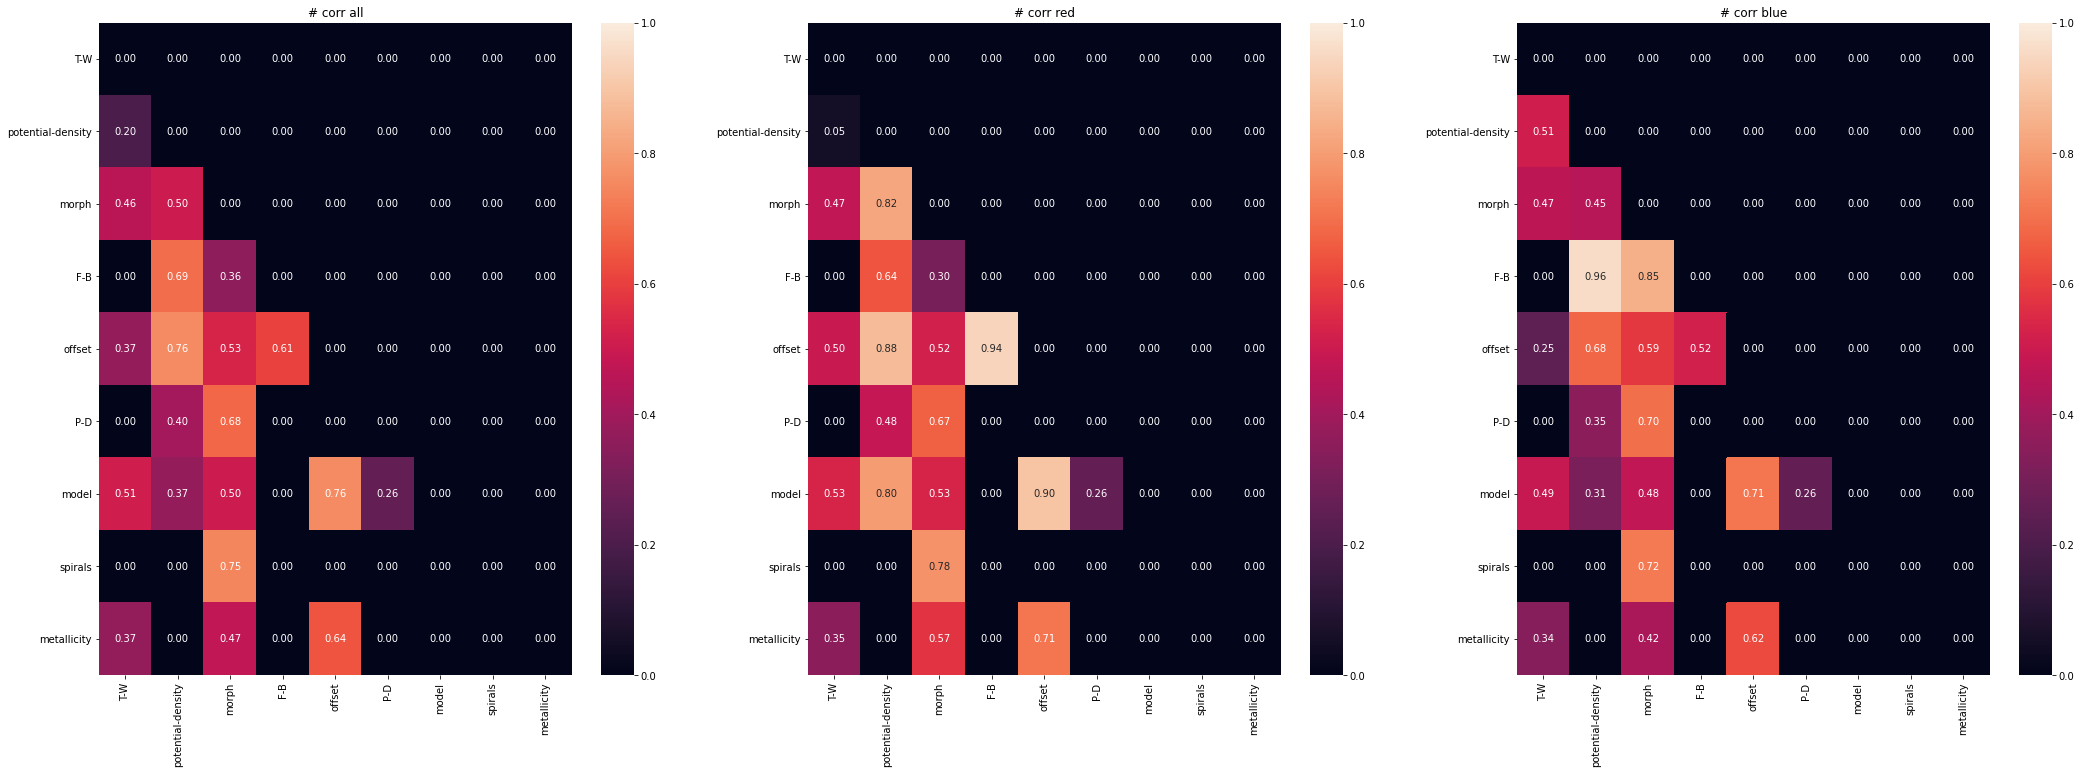

In [82]:
fig = plt.figure(figsize=[36,12])
ax = plt.subplot(131)
ax.set_title('# corr all')
sns.heatmap(metric4[:,:,0], xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=1., fmt="3.2f")

ax = plt.subplot(132)
ax.set_title('# corr red')
sns.heatmap(metric4[:,:,1], xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=1., fmt="3.2f")

ax = plt.subplot(133)
ax.set_title('# corr blue')
sns.heatmap(metric4[:,:,2], xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=1., fmt="3.2f")

plt.show()

In [83]:
fig = plt.figure(figsize=[12,12])

mask = np.triu(np.full(m.shape, True))
# for i in range(len(mask)):
#     mask[i,i]=False

ax = plt.subplot(111)
g = sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f", cmap= 'coolwarm', cbar=False, square=True, mask=mask)
g.axes.set_xticklabels(g.axes.get_xmajorticklabels(), fontsize = 16, rotation=25)
g.axes.set_yticklabels(g.axes.get_ymajorticklabels(), fontsize = 20, rotation=45)

g = sns.heatmap(metric4[:,:,0].T, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=g.axes, vmax=1., fmt="3.2f", cbar=False, square=True, mask=np.tril(np.full(m.shape, True)))

plt.show()

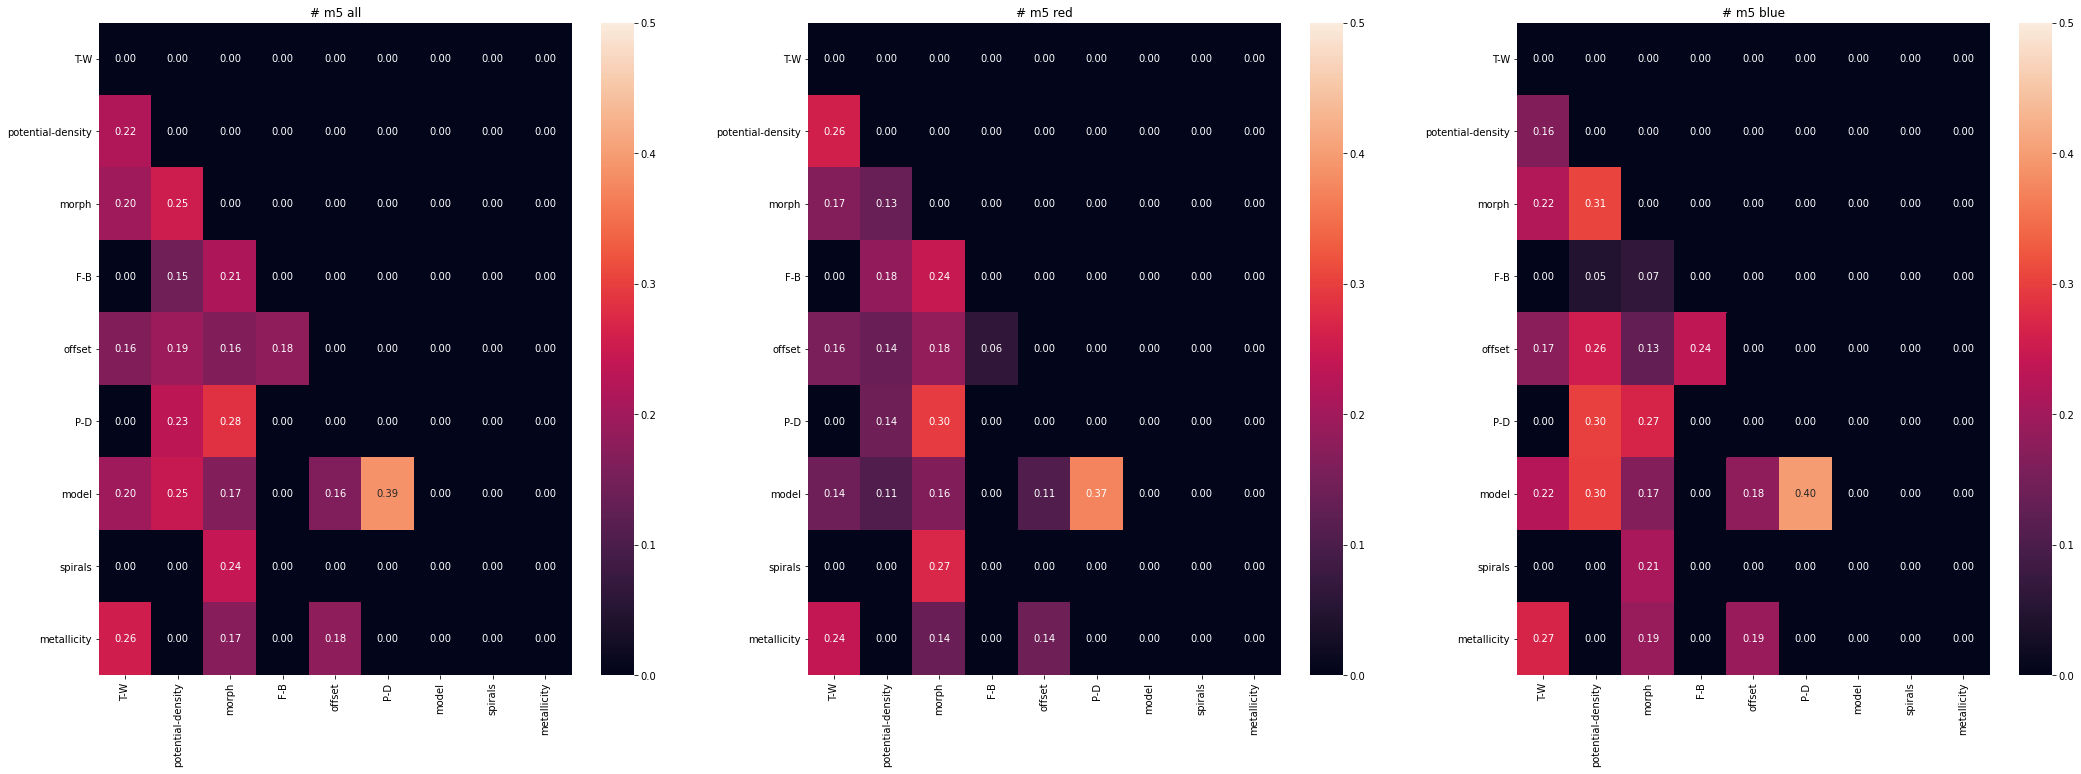

In [84]:
fig = plt.figure(figsize=[36,12])
ax = plt.subplot(131)
ax.set_title('# m5 all')
sns.heatmap(metric5[:,:,0], xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=.5, fmt="3.2f")

ax = plt.subplot(132)
ax.set_title('# m5 red')
sns.heatmap(metric5[:,:,1], xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=.5, fmt="3.2f")

ax = plt.subplot(133)
ax.set_title('# m5 blue')
sns.heatmap(metric5[:,:,2], xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=.5, fmt="3.2f")

plt.show()

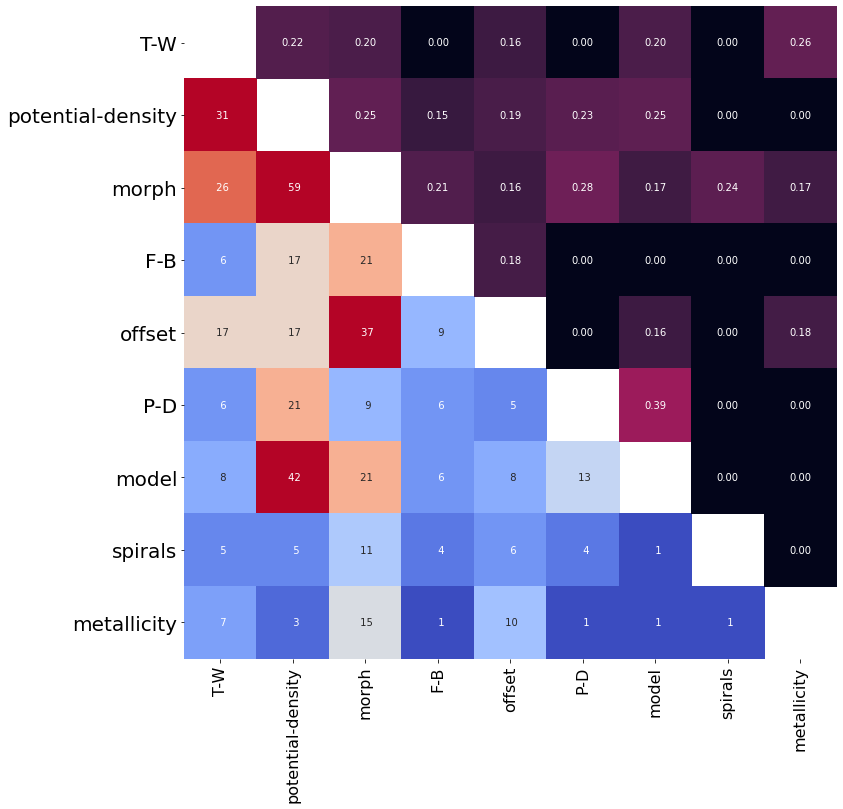

In [85]:
fig = plt.figure(figsize=[12,12])

mask = np.triu(np.full(m.shape, True))
# for i in range(len(mask)):
#     mask[i,i]=False

ax = plt.subplot(111)
g = sns.heatmap(m, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=ax, vmax=30, fmt="3.0f", cmap= 'coolwarm', cbar=False, square=True, mask=mask)
g.axes.set_xticklabels(g.axes.get_xmajorticklabels(), fontsize = 16, rotation=25)
g.axes.set_yticklabels(g.axes.get_ymajorticklabels(), fontsize = 20, rotation=45)

g = sns.heatmap(metric5[:,:,0].T, xticklabels=list(methods), yticklabels=list(methods), annot=True, ax=g.axes, vmax=1., fmt="3.2f", cbar=False, square=True, mask=np.tril(np.full(m.shape, True)))

plt.show()

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
MESSIER 099
________________________________________
         name       method    bar     kind        bands  \
1225  NGC4254  metallicity  False  stellar  12+log(O/H)   

                                     link               paper_name         cr  \
1225  https://arxiv.org/pdf/1209.5031.pdf  Scarano & Lepine (2012)  73.437934   

       err_cr_l   err_cr_r       cr_l       cr_r  err_range      altname  \
1225  19.157722  19.157722  54.280212  92.595656  38.315444  MESSIER 099   

             r25    cr_r25  
1225  151.050183  0.486182  
________________________________________
         name method    bar     kind      bands  \
1301  NGC4254    T-W  False      ISM  CO,Halpha   
1302  NGC4254    T-W  False      ISM  CO,Halpha  

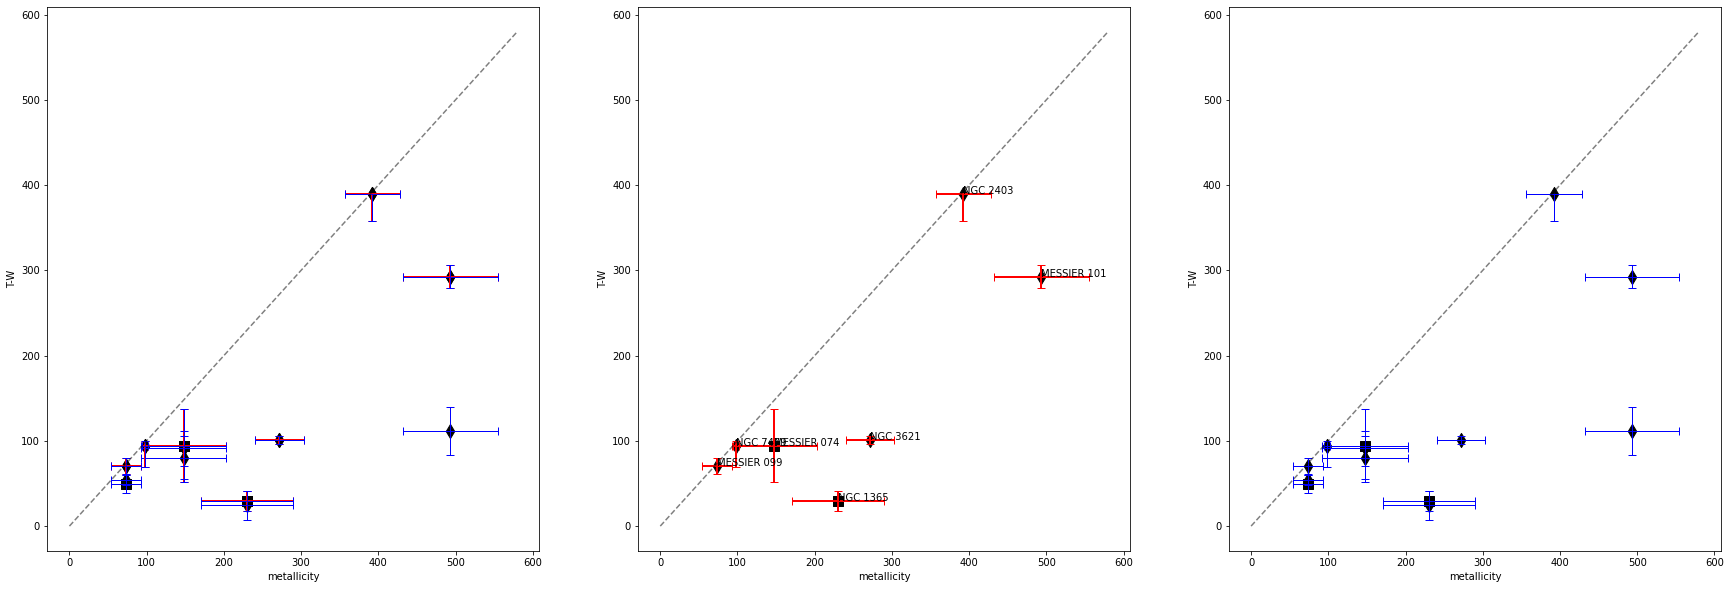

In [25]:

def quad_func(p, x):
    m, c = p
    return m*x + c

# fig, axes = plt.subplots(figsize=[32, 48], ncols=4, nrows=6)
# axes = axes.flatten()
count = 0

methods = ALL_METHODS.keys()

for ind1, method1 in enumerate(methods):
    for ind2, method2 in enumerate(methods):
        
        if method1==method2 or method1=='spiral' or method2 == 'spiral':
            continue
            
        if ind1 < ind2:
            continue
            
        if method1 != 'metallicity' or method2 != 'T-W':
            continue
        
        gals_1 = df[df['method']==method1].altname.values
        gals_2 = df[df['method']==method2].altname.values
        intersection = set(gals_1).intersection(set(gals_2))
        
        
        bands1 = df[df['method']==method1].kind.values
        bands1 = set(bands1)
        
        bands2 = df[df['method']==method2].kind.values
        bands2 = set(bands2)
        
        
        if len(intersection) == 0:
            continue
        
        if len(intersection) < 7:
            continue
            
        print('-*'*50)
        print(f'{method1} vs {method2}')
        print('-*'*50)
        
        
        fig = plt.figure(figsize=[30,10])
        ax = plt.subplot(131)
        ax2 = plt.subplot(132)
        ax3 = plt.subplot(133)
#         ax = axes[count]
        ax.set_xlabel(method1)
        ax.set_ylabel(method2)
        
        ax2.set_xlabel(method1)
        ax2.set_ylabel(method2)
        
        ax3.set_xlabel(method1)
        ax3.set_ylabel(method2)
        
        x,y,x_err,y_err = [],[],[],[]
        
        num_crs1 = 0
        num_crs2 = 0
        
        for ind, gal in enumerate(intersection):
            
            if gal == 'MESSIER 031':
                print(method1, method2)
            
            
            try:
#                 r25 = disc_r25_sizes[gal]
                r25 = 1.
            except:
                print(gal)
                continue
            crs1_ = df[(df['method']==method1)&(df['altname']==gal)]
            crs2_ = df[(df['method']==method2)&(df['altname']==gal)]
            
            print('$'*40)
            print(gal)
            print('_'*40)
            print(crs1_)
            print('_'*40)
            print(crs2_)
            print('$'*40)
            
#             crs1 = (crs1_[['cr_l', 'cr_r', 'cr']].T/crs1_['r25'].values).T.values
#             crs2 = (crs2_[['cr_l', 'cr_r', 'cr']].T/crs2_['r25'].values).T.values
            
            crs1 = crs1_[['cr_l', 'cr_r', 'cr']].values
            crs2 = crs2_[['cr_l', 'cr_r', 'cr']].values
            
            
            for indd,cr1 in enumerate(crs1):
                    num_crs1+=1
#                 try:
#                     print(cr1)
#                     print(crs2)
#                     print(crs2)
                    mi, cr2 = find_closest(cr1, crs2)
                    
                    kind1 = crs1_.kind.values[indd]
                    kind2 = crs2_.kind.values[mi]
                    if kind1 == kind2 == 'stellar':
                        marker = 's'
                    elif kind1 == kind2 == 'ISM':
                        marker = 'o'
                    else:
                        marker = 'd'
                    
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='1', ecolor='red',capsize=4, elinewidth=2)
                    ax2.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='1', ecolor='red',capsize=4, elinewidth=2)
                    
                    x.append(cr1[2])
                    y.append(cr2[2])
                    x_err.append(0.5*(abs(y1)+abs(y2)))
                    y_err.append(0.5*(abs(x1)+abs(x2)))
                    
                    ax.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    ax2.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    
                    ax2.annotate(gal, (cr1[2], cr2[2]))
                    
#                 except:
#                     pass
                
            for indd,cr2 in enumerate(crs2):
                    num_crs2+=1
#                 try:
#                     print(cr1)
#                     print(crs2)
#                     print(crs2)
                    mi, cr1 = find_closest(cr2, crs1)
                    
                    kind1 = crs2_.kind.values[indd]
                    kind2 = crs1_.kind.values[mi]
                    if kind1 == kind2 == 'stellar':
                        marker = 's'
                    elif kind1 == kind2 == 'ISM':
                        marker = 'o'
                    else:
                        marker = 'd'
                    
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='b', fmt='.', markersize='1', ecolor='b',capsize=4, elinewidth=1)
                    ax3.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='b', fmt='.', markersize='1', ecolor='b',capsize=4, elinewidth=1)
                    
                    x.append(cr1[2])
                    y.append(cr2[2])
                    x_err.append(0.5*(abs(y1)+abs(y2)))
                    y_err.append(0.5*(abs(x1)+abs(x2)))
                    
                    ax.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    ax3.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                

        x = sm.add_constant(np.array(x).reshape((-1, 1)))
#         ols = sm.WLS(np.array(y), x, weights=(np.array(y_err)+np.array(x_err)+0.00001)**2)
        ols = sm.WLS(np.array(y), x)
        ols_result = ols.fit()

        slope, err_slope = ols_result.params[1], ols_result.bse[1]
        intercept, err_intercept = ols_result.params[0], ols_result.bse[0]
        r_value = ols_result.rsquared        
        
    
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        for ax_ in [ax,ax2,ax3]:
            ax_.plot([0., max(xlim[1],ylim[1])], [0., max(xlim[1],ylim[1])], '--', alpha=0.5, color='k')
        
        
#         x_fit = np.array([0, max(xlim[1],ylim[1])])
#         y_fit = quad_func(out.beta, x_fit)
#         plt.plot(x_fit, y_fit, '-', color='g', alpha=0.6)
        
        
#         if ax is not None:
#             xlim0, xlim1 = ax.get_xlim()
#             ax.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
#             ax2.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
#             ax3.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
        
#         for ax_ in [ax,ax2,ax3]:
#             ax_.set_xlim(0, min(max(xlim[1],ylim[1]),2))
#             ax_.set_ylim(0, min(max(xlim[1],ylim[1]),2))
#         ax.set_title(f'{method1} vs {method2} ({len(intersection)} gs; {num_crs1} vs {num_crs2} CRs; {bands1} vs {bands2})')
#         count+=1
#         1/0
        
        plt.show()
#         1/0

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
F-B vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
F-B vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
F-B vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
F-B vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
F-B vs potential-density
-*-*-*-*-*-*-*-*-

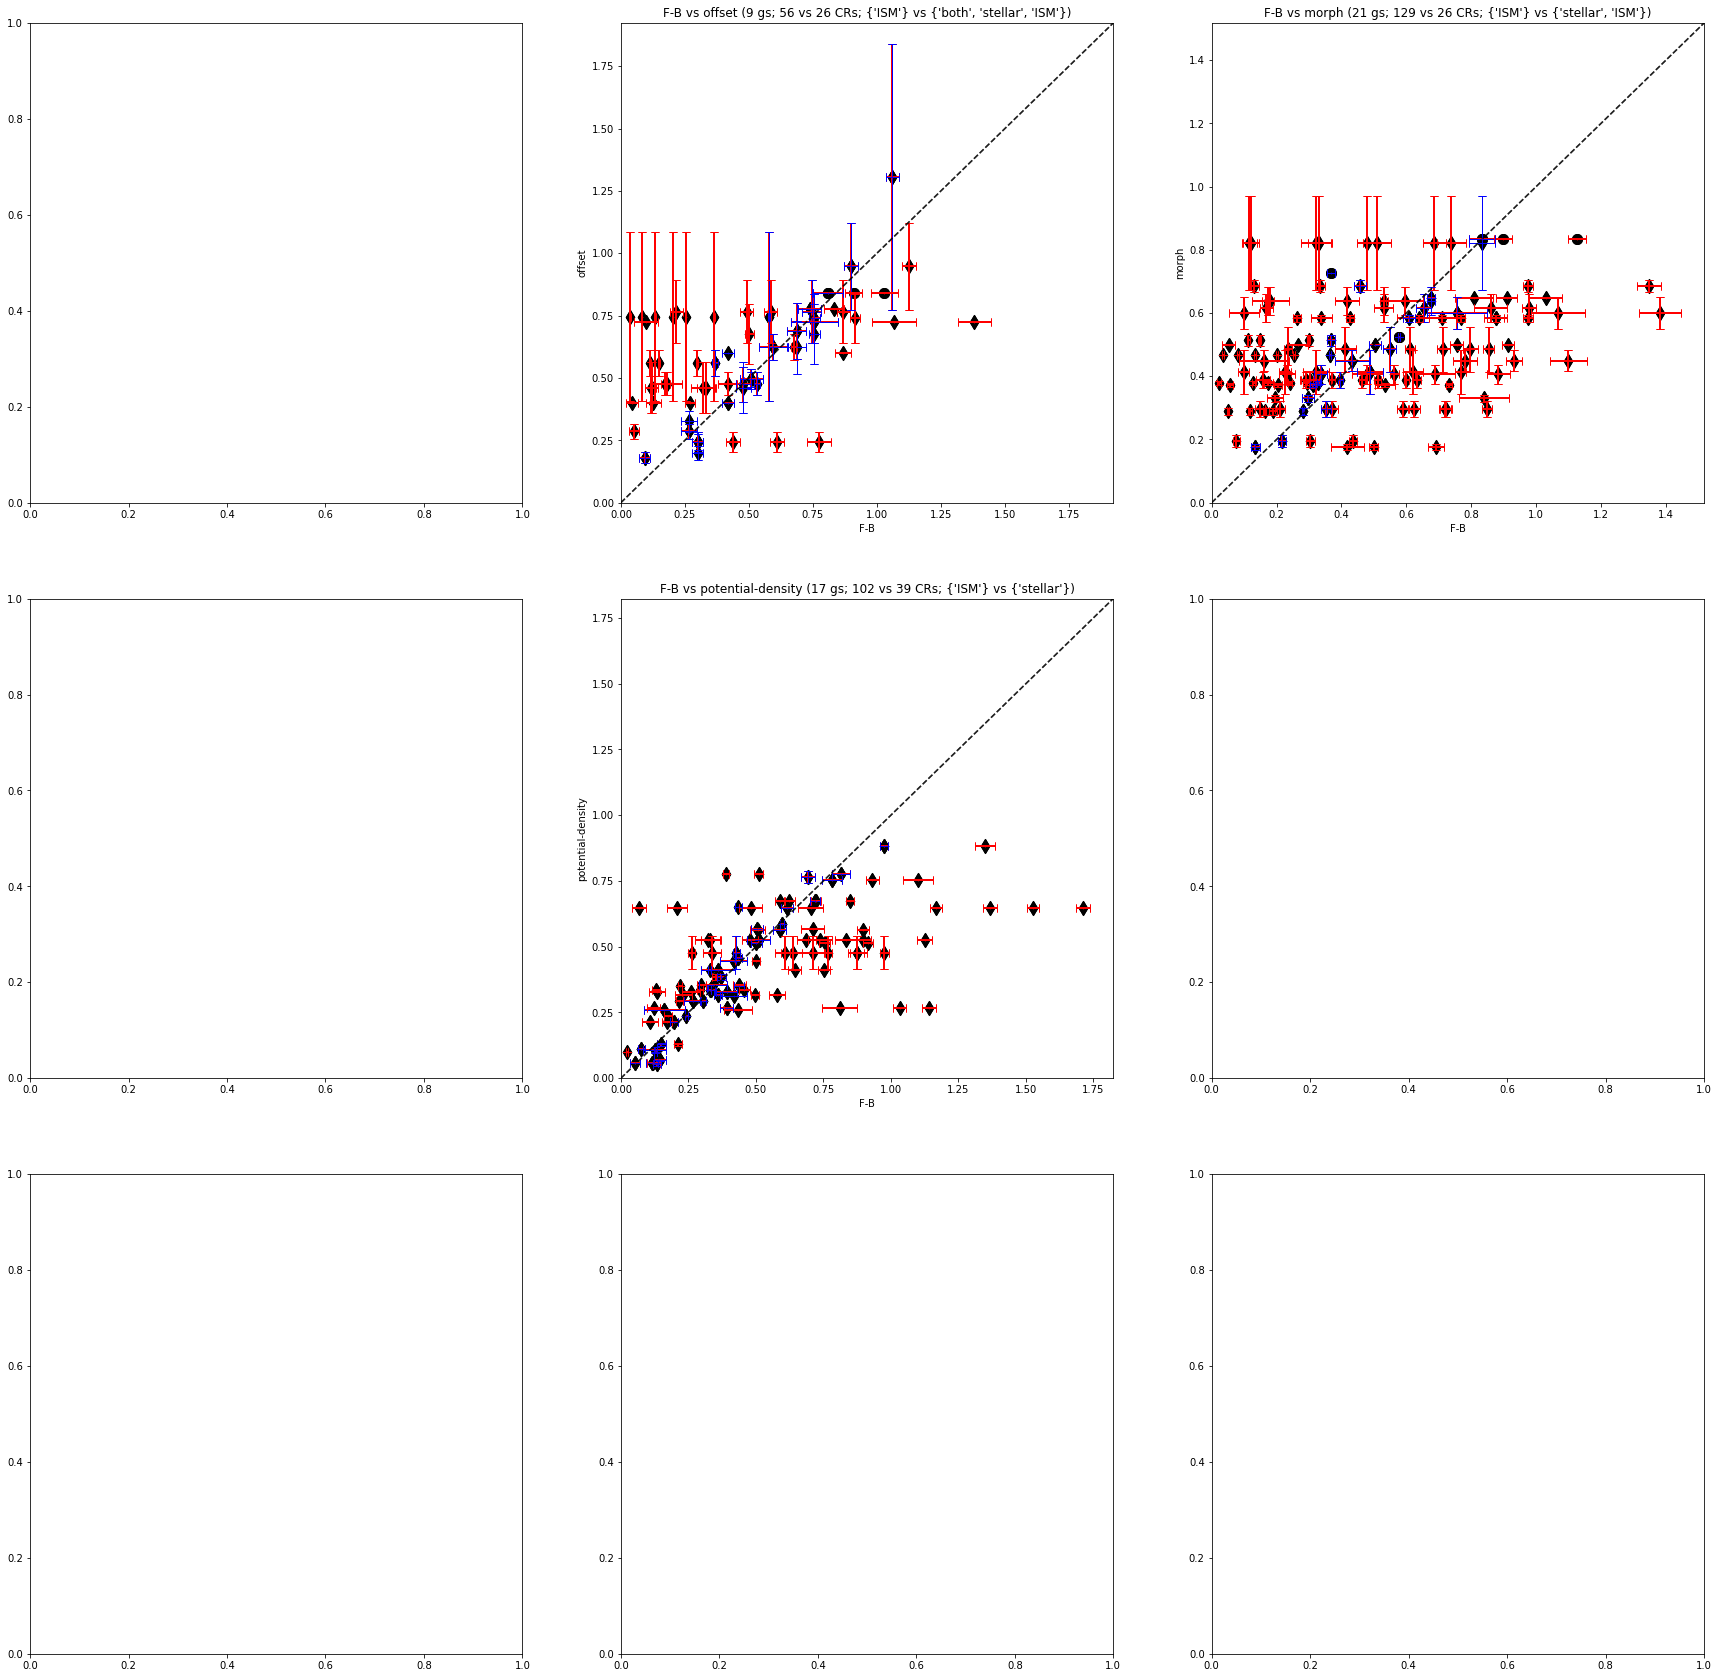

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
offset vs potential-de

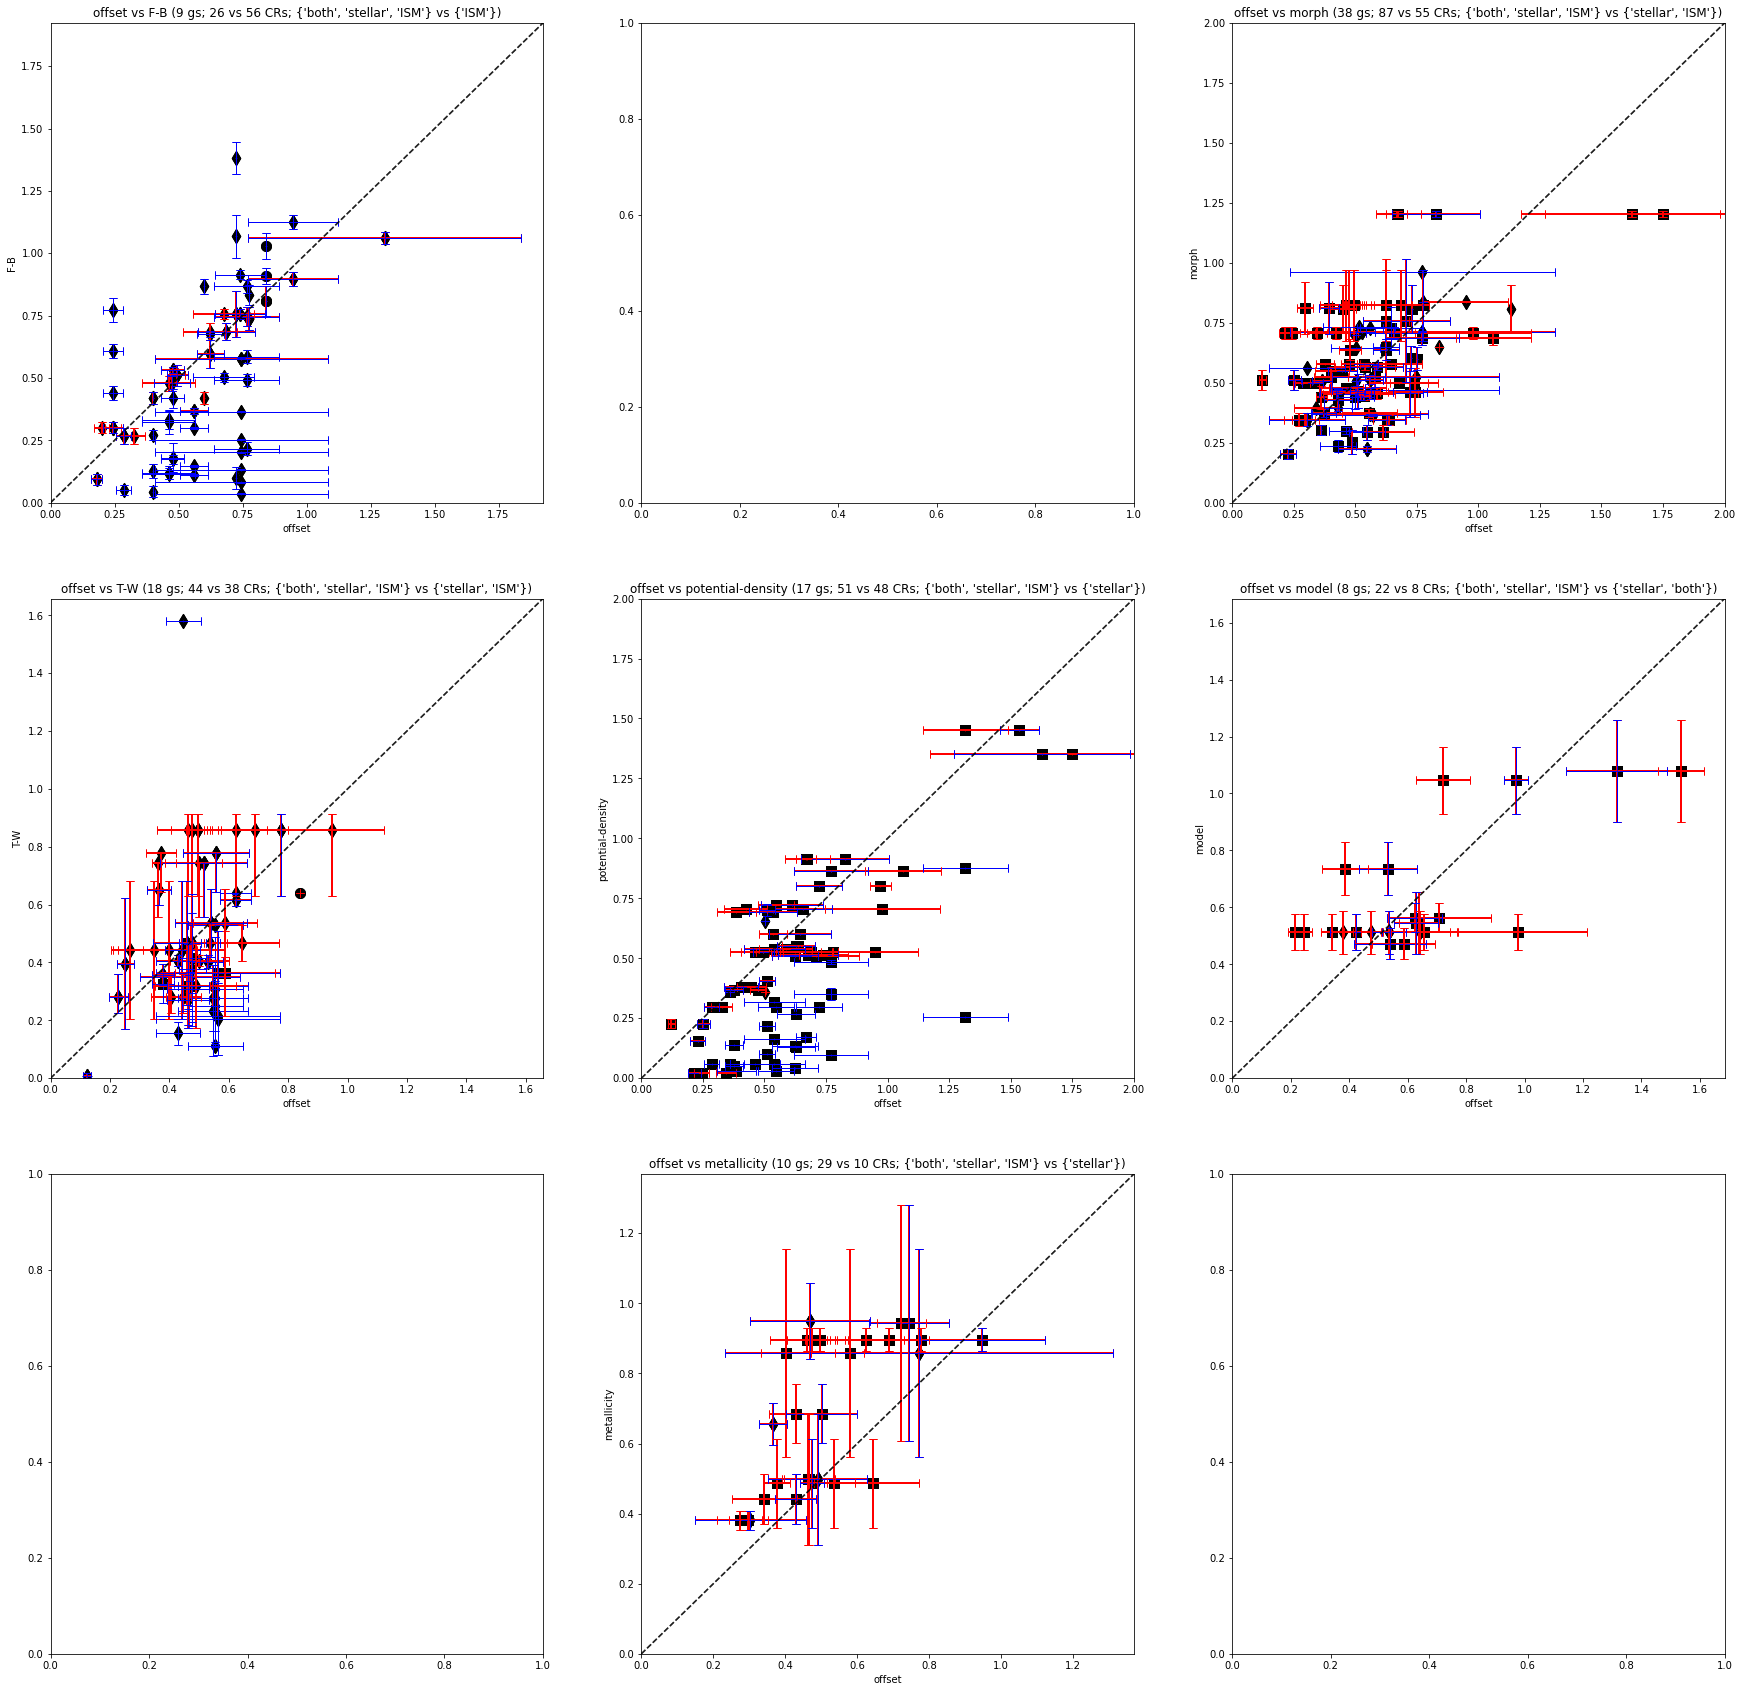

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
morph vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
morph vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
morph vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
morph vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
morph vs potential-density

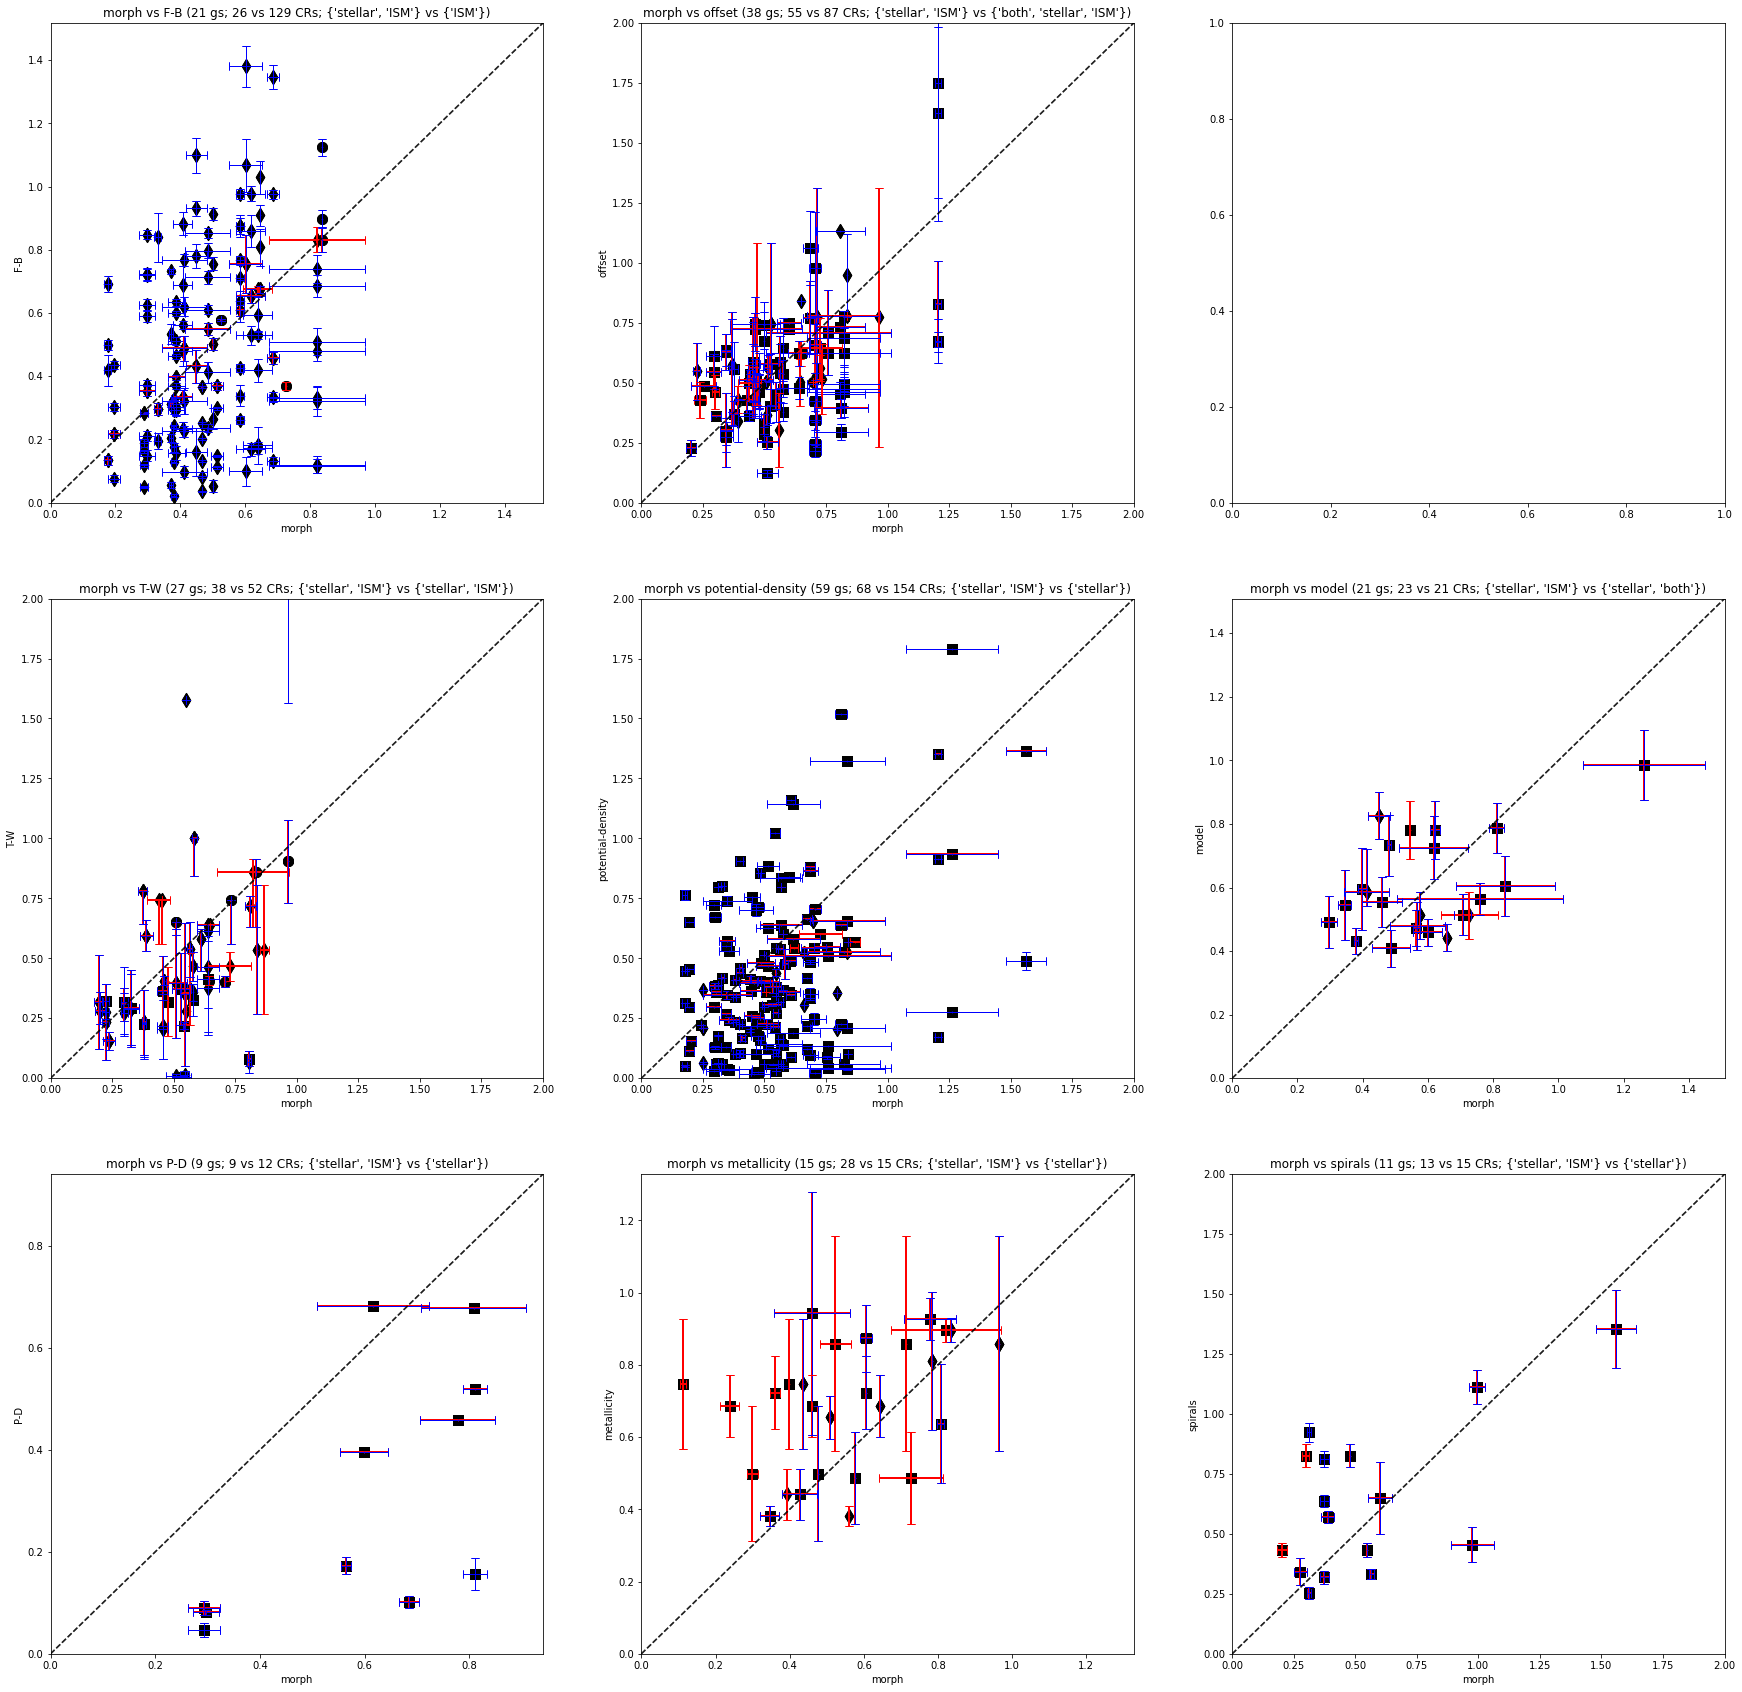

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
T-W vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
T-W vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
T-W vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
nan
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
T-W vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
T-W vs potential-density
-*-*-*-*-

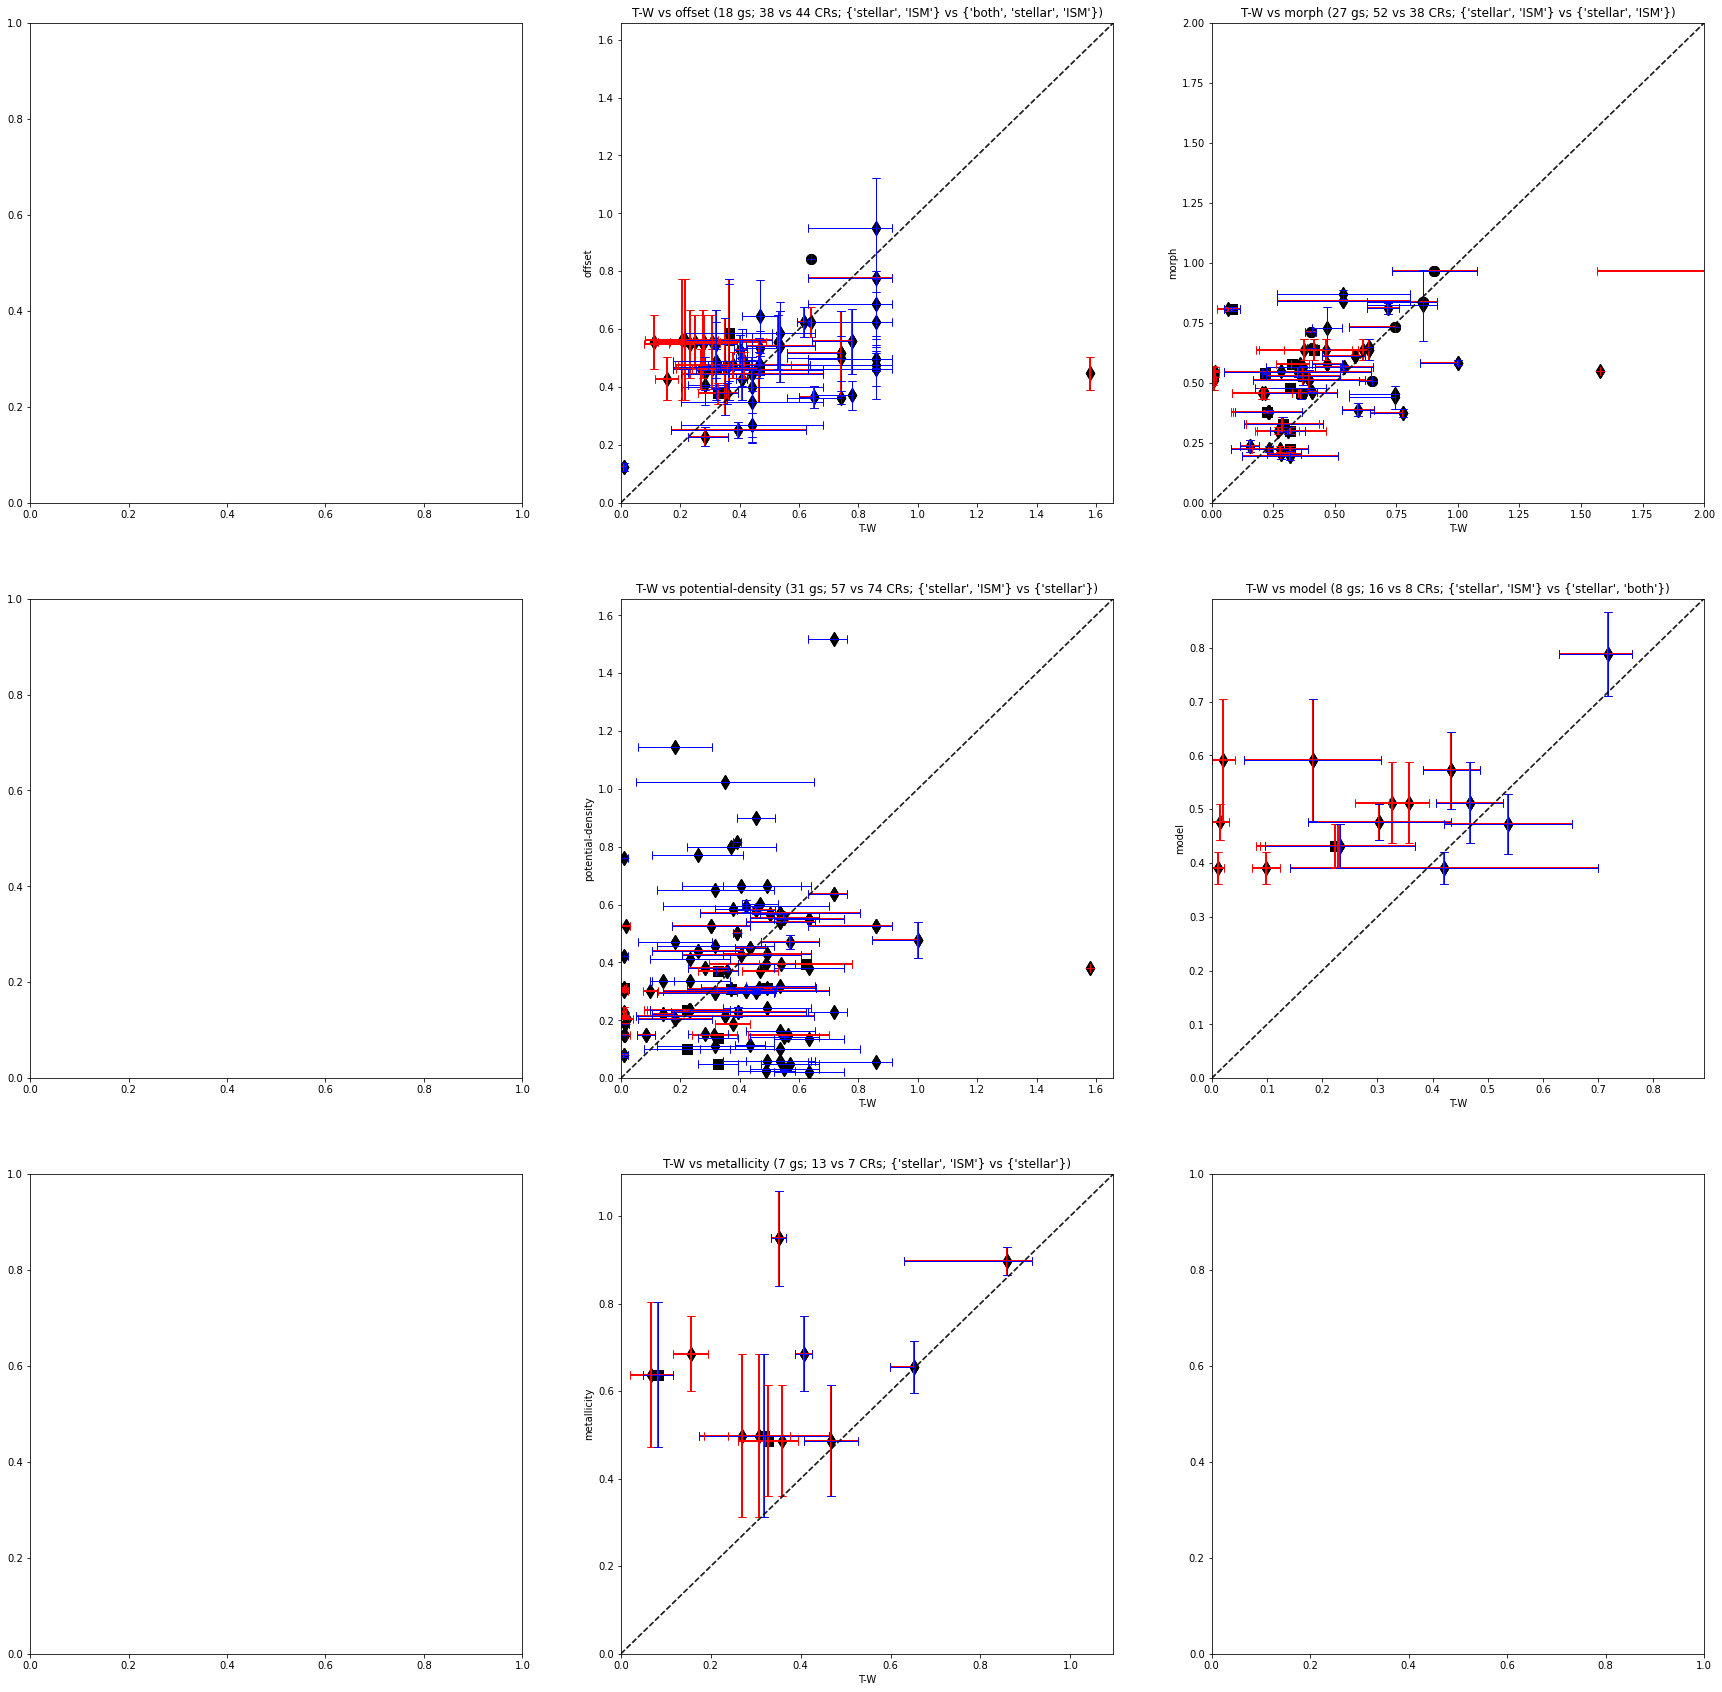

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
potential-density vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
potential-density vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
potential-density vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
potential-density vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

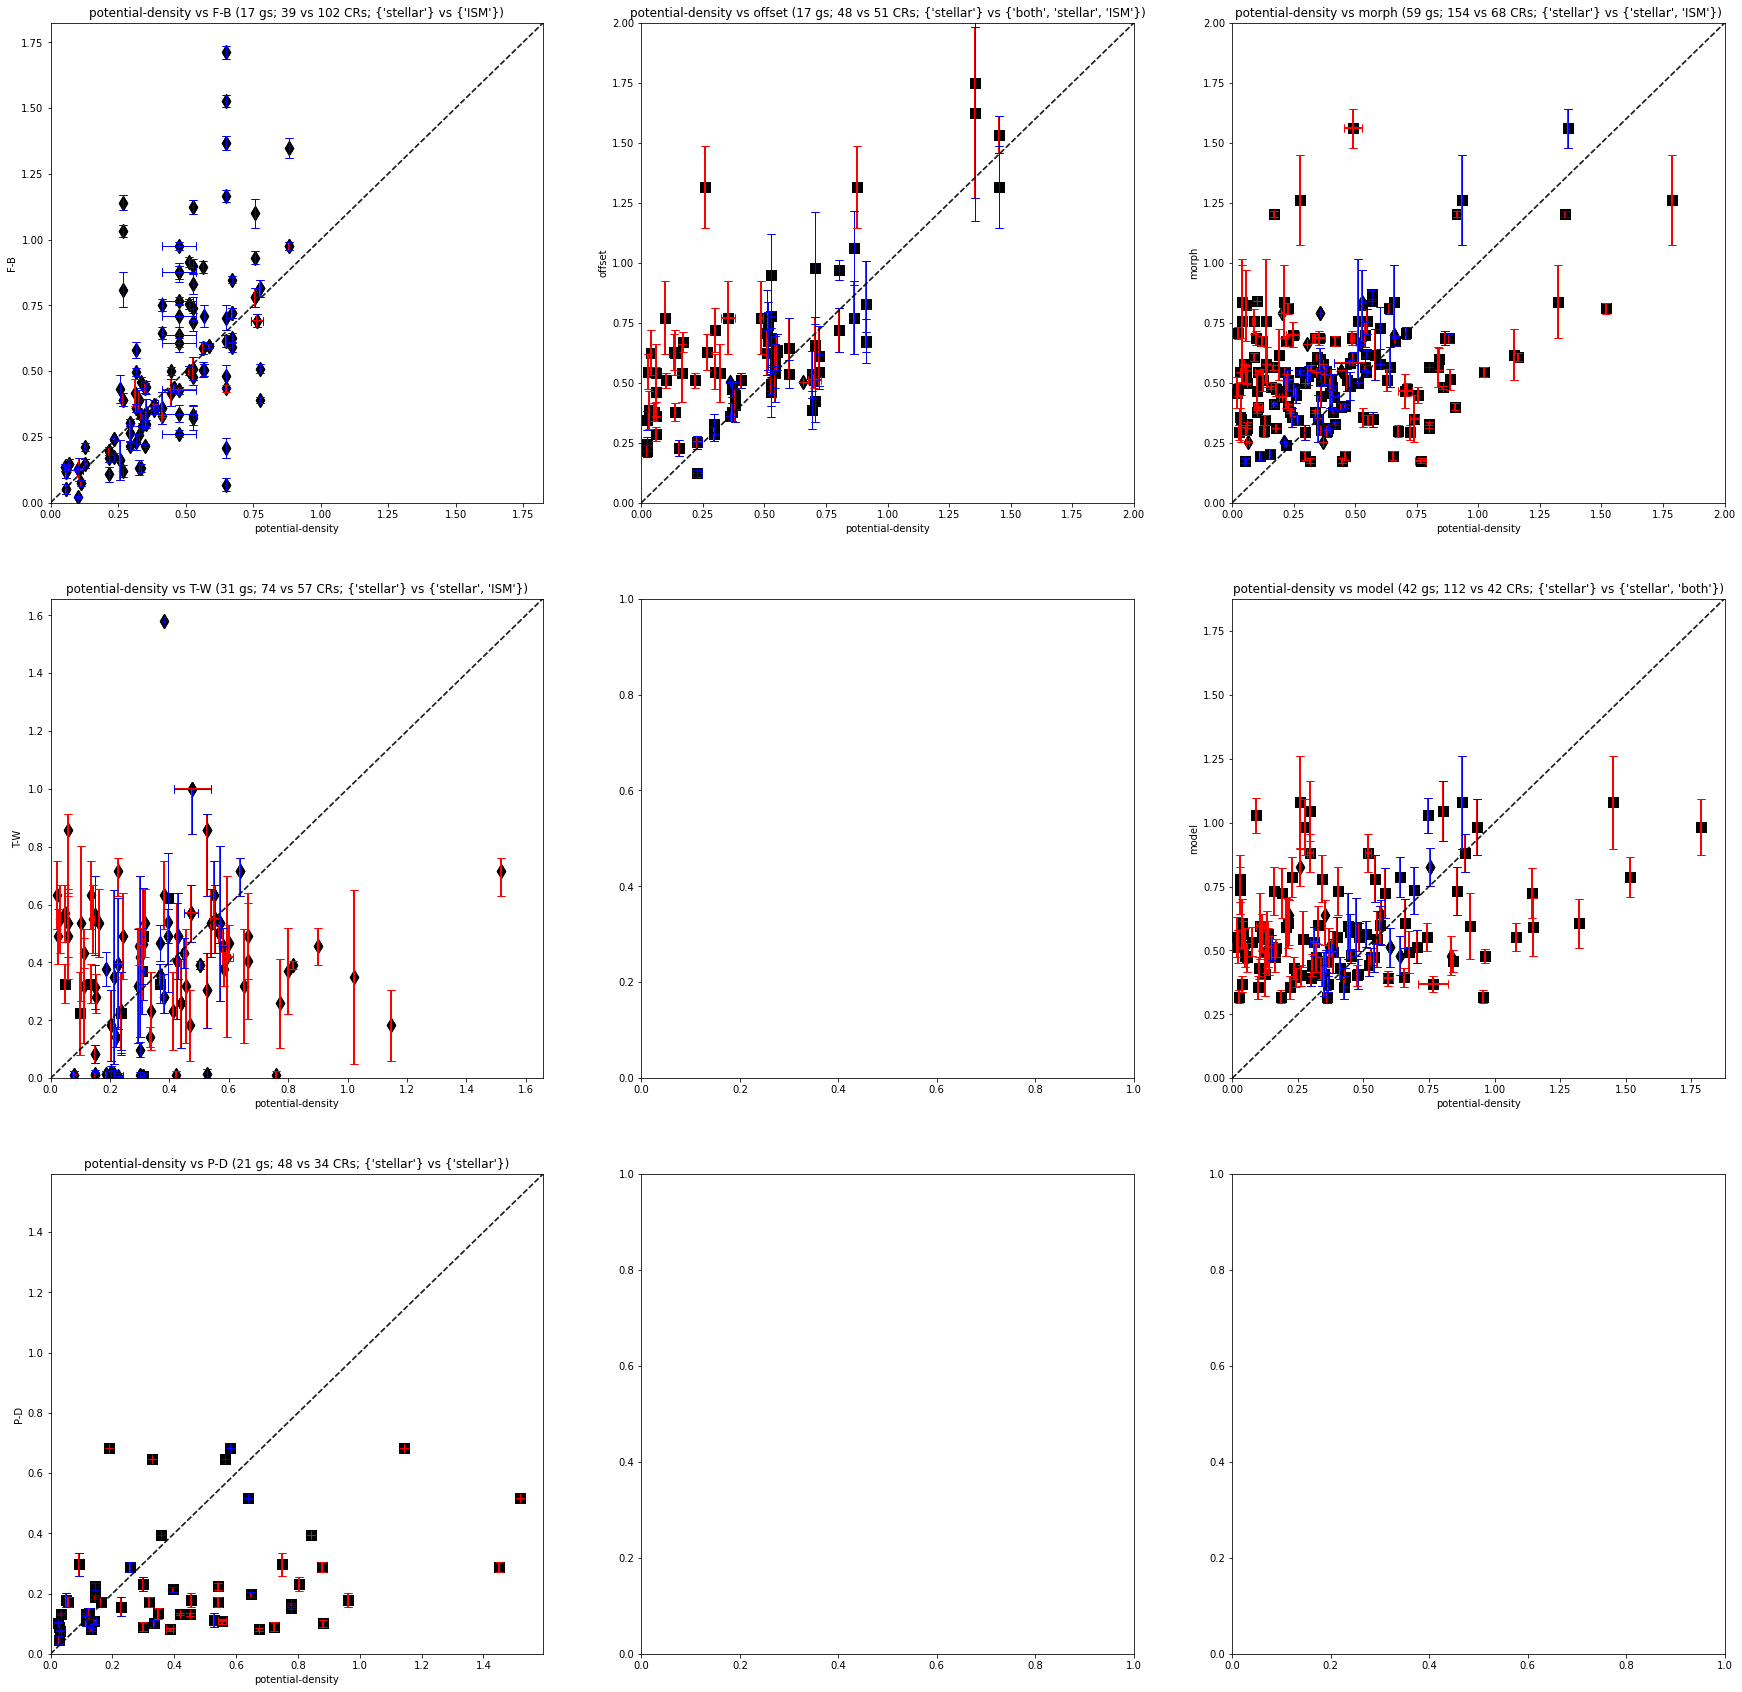

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
model vs potential-density
-*-*-*-

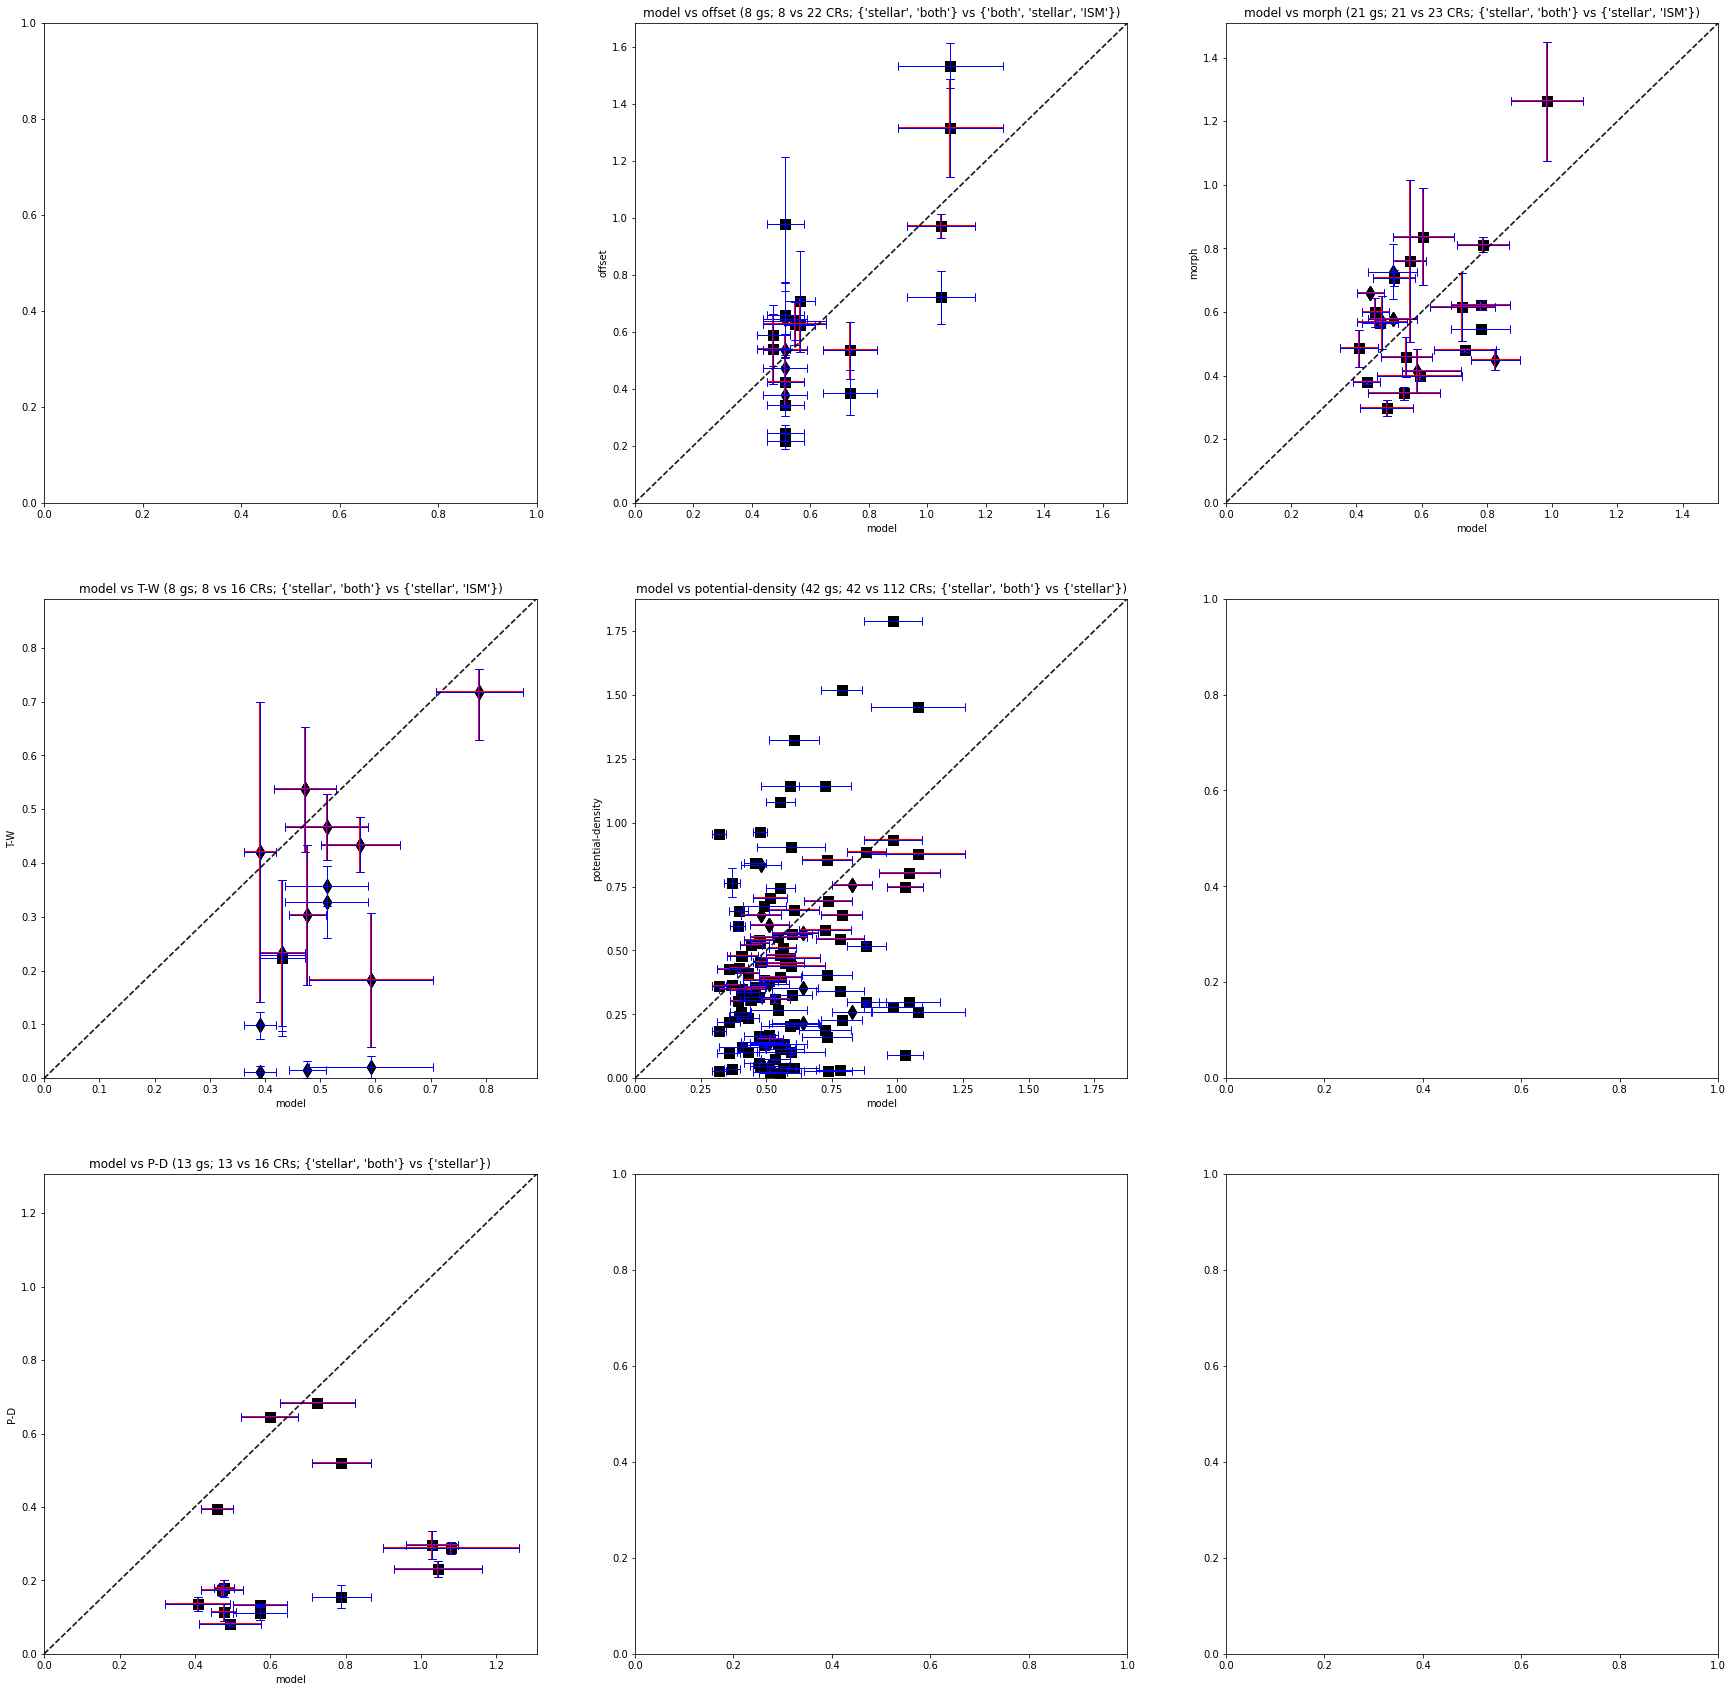

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
P-D vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
P-D vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
P-D vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
P-D vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
P-D vs potential-density
-*-*-*-*-*-*-*-*-

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
metallicity vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
spirals vs F-B
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
spirals vs offset
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
spirals vs morph
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
spirals vs T-W
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
spirals vs potential-densi

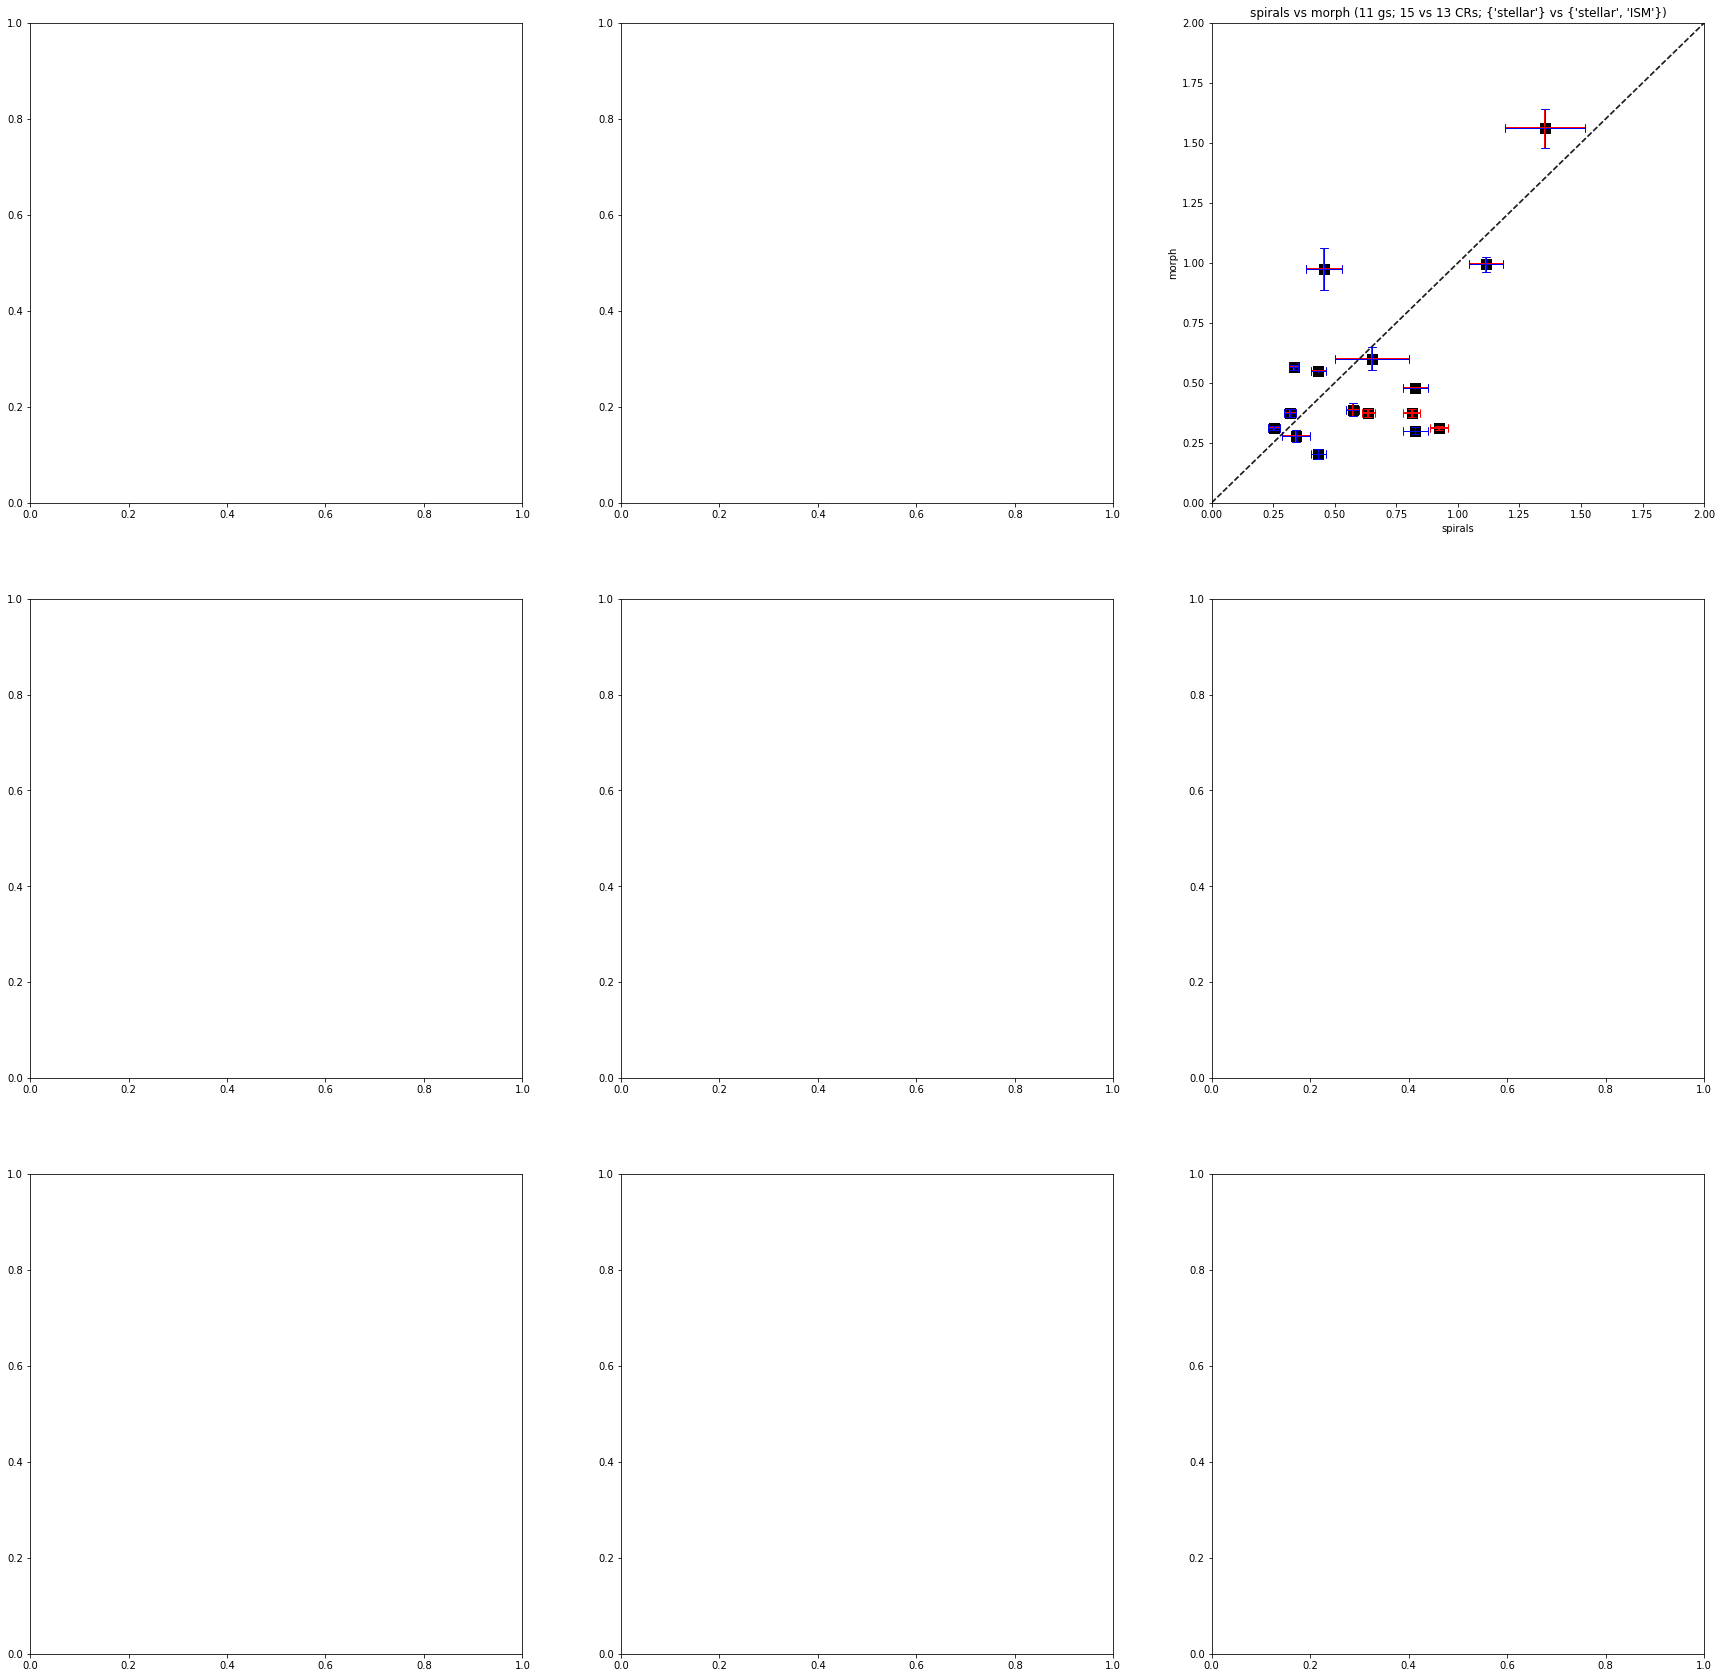

In [36]:

def quad_func(p, x):
    m, c = p
    return m*x + c

# fig, axes = plt.subplots(figsize=[32, 48], ncols=4, nrows=6)
# axes = axes.flatten()
count = 0

methods = ALL_METHODS.keys()


for ind1, method1 in enumerate(methods):
    fig, axes = plt.subplots(figsize=[30,30], ncols=3, nrows=3)
    
    axes = axes.flatten()
    
    for ind2, method2 in enumerate(methods):
        
        print('-*'*50)
        print(f'{method1} vs {method2}')
        print('-*'*50)
        
        if method1==method2 or method1=='spiral' or method2 == 'spiral':
            continue
            
#         if ind1 < ind2:
#             continue
        
        gals_1 = df[df['method']==method1].altname.values
        gals_2 = df[df['method']==method2].altname.values
        intersection = set(gals_1).intersection(set(gals_2))
        
        
        bands1 = df[df['method']==method1].kind.values
        bands1 = set(bands1)
        
        bands2 = df[df['method']==method2].kind.values
        bands2 = set(bands2)
        
        
        if len(intersection) == 0:
            continue
        
        if len(intersection) < 7:
            continue
            
        ax = axes[ind2]
            

        
        
        ax2 = ax
        ax3 = ax
        
        ax.set_xlabel(method1)
        ax.set_ylabel(method2)
        
        ax2.set_xlabel(method1)
        ax2.set_ylabel(method2)
        
        ax3.set_xlabel(method1)
        ax3.set_ylabel(method2)
        
        x_1,y_1,x_err_1,y_err_1 = [],[],[],[]
        x_2,y_2,x_err_2,y_err_2 = [],[],[],[]
        
        num_crs1 = 0
        num_crs2 = 0
        
        for ind, gal in enumerate(intersection):
            
            if gal == 'MESSIER 031':
                print(method1, method2)
            
            
            try:
                r25 = disc_r25_sizes[gal]
            except:
                print(gal)
                continue
            crs1_ = df[(df['method']==method1)&(df['altname']==gal)]
            crs2_ = df[(df['method']==method2)&(df['altname']==gal)]
            
            crs1 = (crs1_[['cr_l', 'cr_r', 'cr']].T/crs1_['r25'].values).T.values
            crs2 = (crs2_[['cr_l', 'cr_r', 'cr']].T/crs2_['r25'].values).T.values
            
            
            for indd,cr1 in enumerate(crs1):
                    num_crs1+=1
#                 try:
#                     print(cr1)
#                     print(crs2)
#                     print(crs2)
                    mi, cr2 = find_closest(cr1, crs2)
                    
                    kind1 = crs1_.kind.values[indd]
                    kind2 = crs2_.kind.values[mi]
                    if kind1 == kind2 == 'stellar':
                        marker = 's'
                    elif kind1 == kind2 == 'ISM':
                        marker = 'o'
                    else:
                        marker = 'd'
                    
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='1', ecolor='red',capsize=4, elinewidth=2)
                    ax2.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='red', fmt='.', markersize='1', ecolor='red',capsize=4, elinewidth=2)
                    
                    x_1.append(cr1[2])
                    y_1.append(cr2[2])
                    x_err_1.append(0.5*(abs(y1)+abs(y2)))
                    y_err_1.append(0.5*(abs(x1)+abs(x2)))
                    
                    ax.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    ax2.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    
#                 except:
#                     pass

#             stop_ind = len(x)
                
            for indd,cr2 in enumerate(crs2):
                    num_crs2+=1
#                 try:
#                     print(cr1)
#                     print(crs2)
#                     print(crs2)
                    mi, cr1 = find_closest(cr2, crs1)
                    
                    kind1 = crs2_.kind.values[indd]
                    kind2 = crs1_.kind.values[mi]
                    if kind1 == kind2 == 'stellar':
                        marker = 's'
                    elif kind1 == kind2 == 'ISM':
                        marker = 'o'
                    else:
                        marker = 'd'
                    
                    y1,y2 = cr1[2]-cr1[0], cr1[1]-cr1[2]
                    x1,x2 = cr2[2]-cr2[0], cr2[1]-cr2[2]
                    ax.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='b', fmt='.', markersize='1', ecolor='b',capsize=4, elinewidth=1)
                    ax3.errorbar(cr1[2], cr2[2], xerr=[[y1],[y2]], yerr=[[x1],[x2]], color='b', fmt='.', markersize='1', ecolor='b',capsize=4, elinewidth=1)
                    
                    x_2.append(cr1[2])
                    y_2.append(cr2[2])
                    x_err_2.append(0.5*(abs(y1)+abs(y2)))
                    y_err_2.append(0.5*(abs(x1)+abs(x2)))
                    
                    ax.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
                    ax3.scatter(cr1[2], cr2[2], 100, marker=marker, edgecolor='k', color='k')
        
        
        x = np.concatenate([x_1, x_2])
        y = np.concatenate([y_1, y_2])

        x_ = sm.add_constant(np.array(x).reshape((-1, 1)))
#         ols = sm.WLS(np.array(y), x, weights=(np.array(y_err)+np.array(x_err)+0.00001)**2)
        ols = sm.WLS(np.array(y), x_)
        ols_result = ols.fit()

        slope, err_slope = ols_result.params[1], ols_result.bse[1]
        intercept, err_intercept = ols_result.params[0], ols_result.bse[0]
        r_value = ols_result.rsquared        
        
    
        x = np.array(x)
        y = np.array(y)
#         print(x,y)
        
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        for ax_ in [ax,ax2,ax3]:
            ax_.plot([0., max(xlim[1],ylim[1])], [0., max(xlim[1],ylim[1])], '--', alpha=0.5, color='k')
        
        
#         x_fit = np.array([0, max(xlim[1],ylim[1])])
#         y_fit = quad_func(out.beta, x_fit)
#         plt.plot(x_fit, y_fit, '-', color='g', alpha=0.6)
        
        
        if ax is not None:
            xlim0, xlim1 = ax.get_xlim()
#             ax.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
#             ax2.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
#             ax3.plot([xlim0, xlim1], [xlim0 * slope + intercept, xlim1 * slope + intercept], '--', color='r')
        
        for ax_ in [ax,ax2,ax3]:
            ax_.set_xlim(0, min(max(xlim[1],ylim[1]),2))
            ax_.set_ylim(0, min(max(xlim[1],ylim[1]),2))
        ax.set_title(f'{method1} vs {method2} ({len(intersection)} gs; {num_crs1} vs {num_crs2} CRs; {bands1} vs {bands2})')
        count+=1
#         1/0
        
    plt.show()
#     1/0
        
        
        
#         if method1=='morph' and method2 == 'F-B':
#             1/0
#         1/0

In [114]:
find_closest(cr1, crs2)

'cr'

In [96]:
crs1_ = df[(df['method']==method2)&(df['altname']==gal)]

In [97]:
crs1_

name method    bar kind       bands link     cr  err_cr_l  err_cr_r  \
306  UGC8334    F-B  False  ISM  Halpha, HI  NaN   12.6       1.0       1.0   
307  UGC8334    F-B  False  ISM  Halpha, HI  NaN   28.8       1.0       1.0   
308  UGC8334    F-B  False  ISM  Halpha, HI  NaN   47.0       1.0       1.0   
309  UGC8334    F-B  False  ISM  Halpha, HI  NaN   71.7       1.0       1.0   
310  UGC8334    F-B  False  ISM  Halpha, HI  NaN   89.7       1.0       1.0   
311  UGC8334    F-B  False  ISM  Halpha, HI  NaN  129.5       1.0       1.0   
312  UGC8334    F-B  False  ISM  Halpha, HI  NaN  205.1       1.0       1.0   

      cr_l   cr_r  err_range      altname         r25    cr_r25  
306   11.6   13.6        2.0  MESSIER 063  354.912467  0.035502  
307   27.8   29.8        2.0  MESSIER 063  354.912467  0.081147  
308   46.0   48.0        2.0  MESSIER 063  354.912467  0.132427  
309   70.7   72.7        2.0  MESSIER 063  354.912467  0.202022  
310   88.7   90.7        2.0  MESSIER 063  354.912467  0.252738  
311  128.5  130.5        2.0  MESSIER 063  354.912467  0.364879  
312  204.1  206.1        2.0  MESSIER 063  354.912467  0.577889

In [110]:
crs1 = (crs1_[['cr', 'cr_l', 'cr_r']].T/crs1_['r25'].values).T

In [111]:
crs1

cr      cr_l      cr_r
306  0.035502  0.032684  0.038319
307  0.081147  0.078329  0.083964
308  0.132427  0.129609  0.135245
309  0.202022  0.199204  0.204839
310  0.252738  0.249921  0.255556
311  0.364879  0.362061  0.367696
312  0.577889  0.575071  0.580707

In [123]:
gals_1 = df[df['method']=='morph'].altname.values
gals_2 = df[df['method']=='F-B'].altname.values
intersection = set(gals_1).intersection(set(gals_2))

In [124]:
len(intersection)

21

In [126]:
df[(df['method']=='morph')&(df['altname'].isin(intersection))].shape

(26, 15)

In [130]:
df[(df['method']=='morph')&(df['altname'].isin(intersection))]

name method    bar     kind    bands  \
493     NGC925  morph  False      ISM      HII   
507    NGC5055  morph  False      ISM      HII   
512    NGC7479  morph  False      ISM      HII   
1077  PGC31982  morph  False  stellar  optical   
1078  PGC31968  morph  False  stellar  optical   
1081  PGC40153  morph  False  stellar  optical   
1084   PGC8631  morph  False  stellar  optical   
1086  PGC40001  morph  False  stellar  optical   
1094  PGC36875  morph  False  stellar  optical   
1113   NGC0753  morph  False  stellar  optical   
1114   NGC0925  morph  False  stellar  optical   
1125   NGC2336  morph  False  stellar  optical   
1129   NGC3346  morph  False  stellar  optical   
1134   NGC3596  morph  False  stellar  optical   
1138   NGC3726  morph  False  stellar  optical   
1144   NGC4145  morph  False  stellar  optical   
1147   NGC4559  morph  False  stellar  optical   
1149   NGC4651  morph  False  stellar  optical   
1160   NGC5985  morph  False  stellar  optical   
1161   NGC6015  morph  False  stellar  optical   
1162   NGC6217  morph  False  stellar  optical   
1163   NGC6643  morph  False  stellar  optical   
1171   NGC7479  morph  False  stellar  optical   
1173   NGC7741  morph  False  stellar  optical   
1195   NGC4321  morph  False  stellar       B?   
1196   NGC5055  morph  False  stellar       B?   

                                                   link          cr  err_cr_l  \
493                                                 NaN  233.564560       0.0   
507                                                 NaN  186.485989       0.0   
512                                                 NaN   91.412812       0.0   
1077  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   26.100000       0.9   
1078  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   78.000000       5.4   
1081  http://articles.adsabs.harvard.edu/pdf/1995ApJ...  116.700000       8.1   
1084  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   55.800000       0.0   
1086  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   78.300000       1.5   
1094  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   36.300000       2.7   
1113  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   24.900000       2.1   
1114  http://articles.adsabs.harvard.edu/pdf/1995ApJ...  165.000000       6.0   
1125  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   72.900000      10.5   
1129  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   26.100000       0.9   
1134  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   21.300000       2.1   
1138  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   50.400000       4.2   
1144  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   95.100000       2.7   
1147  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   91.500000       3.9   
1149  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   20.400000       1.2   
1160  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   48.600000       3.6   
1161  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   64.800000       1.2   
1162  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   41.400000       3.0   
1163  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   41.100000       6.9   
1171  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   90.000000      16.2   
1173  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   63.600000       1.2   
1195  http://articles.adsabs.harvard.edu/pdf/1992ApJ...  118.332000       0.0   
1196  http://articles.adsabs.harvard.edu/pdf/1992ApJ...  166.050000       0.0   

      err_cr_r        cr_l        cr_r  err_range      altname         r25  \
493        0.0  233.564560  233.564560        0.0     NGC 0925  321.455792   
507        0.0  186.485989  186.485989        0.0  MESSIER 063  354.912467   
512        0.0   91.412812   91.412812        0.0     NGC 7479  109.426184   
1077       0.9   25.200000   27.000000        1.8     NGC 3346   79.089942   
1078       5.4   72.600000   83.400000       10.8     NGC 3344  200.965383   
108

In [132]:
cc = 0
for _ in total_crs:
    if _[0]['method'] == 'morph':
        for gal in _[0]['cr'].keys():
            try:
                if _[0]['names_map'][gal] in intersection:
                    cc+=1
            except:
                pass
cc            

26

## bands

Какие данные у нас есть:

In [66]:
for ind,_ in enumerate(total_crs):
    print(ind, _[0]['bands'])

0 r
1 Halpha, HI
2 HI, 24mu
3 HII
4 SN
5 HII
6 CO
7 Halpha
8 CO,HI
9 CALIFA,MANGA,different
10 H-band
11 H-band
12 Halpha,r
13 optical
14 B,I
15 B?
16 B,I
17 12+log(O/H)
18 NIR, Halpha
19 CO,Halpha
20 MUSE
21 SDSS
22 SDSS
23 SDSS
24 B,Spitzer,GALEX
25 r,J,g,i
26 g,r,i


In [67]:
bands = []
for ind,_ in enumerate(total_crs):
    bs = _[0]['bands'].replace(' ', '').strip()
    for b in bs.split(','):
        bands.append(b)
        
print(set(bands))

{'Spitzer', 'GALEX', 'optical', 'CALIFA', 'B?', 'MUSE', '12+log(O/H)', 'SN', 'MANGA', 'different', 'Halpha', 'SDSS', '24mu', 'HII', 'B', 'HI', 'NIR', 'J', 'I', 'g', 'CO', 'r', 'i', 'H-band'}


Очень много всего разного.

## methods

In [68]:
for ind,_ in enumerate(total_crs):
    print(ind, _[0]['method'])

0 spiral
1 F-B
2 offset
3 morph
4 SNs
5 offset
6 T-W
7 T-W
8 T-W
9 T-W
10 potential-density
11 model
12 bar-torque
13 morph
14 offset
15 morph
16 P-D
17 metallicity
18 model
19 T-W
20 T-W
21 gaps
22 P-D
23 rings
24 offset
25 offset
26 spirals


In [69]:
methods = []
for ind,_ in enumerate(total_crs):
    methods.append(_[0]['method'])
        
print(len(set(methods)), set(methods))

14 {'metallicity', 'F-B', 'spirals', 'model', 'SNs', 'potential-density', 'rings', 'morph', 'spiral', 'gaps', 'T-W', 'bar-torque', 'P-D', 'offset'}


## methods properties

- by mean end in r25
- by rel. error
- by number of CRs predicted
- by rel. error by paper

### mean end

We can't find data for `rings` method:

In [73]:
props = {}
for info_ in total_crs:
    
    info = info_[0]
    method = info['method']
    
    if method == 'spiral' or method == 'SNs':
        continue
    
    if method not in props.keys():
        props[method] = []
        
    for gal in info['cr'].keys():
        cr_info_ = info['cr'][gal]
        
#         if gal == 'J130235.73+411924.1':
#             print(method, gal, info['names_map'][gal], cr, cr_r, cr_info)
        
        try:
            r25 = disc_r25_sizes[info['names_map'][gal]]
        except:
            print(f'for {gal} r25 not found, continue')
            continue
        
        for cr_info in cr_info_:
            if len(cr_info) == 3:
                cr, cr_r, cr_l = cr_info
            else:
                cr, cr_r = cr_info
                cr_l = cr_r

            # mean end in r25
            prop = (cr+abs(cr_r))/r25
            if np.isfinite(prop):
                props[method].append(prop)

for UGC1317 r25 not found, continue
for NGC1068 r25 not found, continue
for IC1528 r25 not found, continue
for J172817.97+564629.2 r25 not found, continue
for J171901.32+571024.6 r25 not found, continue
for J172956.64+582350.6 r25 not found, continue
for J032246.99+000855.9 r25 not found, continue
for J072819.02+431807.5 r25 not found, continue
for J073941.87+455445.4 r25 not found, continue
for J074743.27+412310.9 r25 not found, continue
for J075135.62+425248.4 r25 not found, continue
for J084440.15+535703.9 r25 not found, continue
for J084758.26+513603.6 r25 not found, continue
for J090641.10+412154.0 r25 not found, continue
for J162105.00+395502.6 r25 not found, continue
for J162912.90+410859.0 r25 not found, continue
for J130455.77+473013.1 r25 not found, continue
for J142004.29+470716.8 r25 not found, continue
for J123650.90+453902.9 r25 not found, continue
for J090434.16+412352.1 r25 not found, continue
for J134431.98+401424.0 r25 not found, continue
for J161149.40+491343.3 r25 n

In [74]:
fig, axes = plt.subplots(figsize=[12, 12], nrows=11, sharex=True)
for ind, method in enumerate(props.keys()):
    ax = axes[ind]
    vals = props[method]
    me, st = np.mean(vals), np.std(vals)
    ax.scatter(me, 0, 100, edgecolor='r', color='none')
    ax.errorbar(me, 0, xerr=st, color='r')
    ax.set_yticks([])
    ax.text(0, 0.01, method, fontsize=20)

plt.suptitle('Mean CR end', y=0.9)
plt.xlabel('CR+dCR in r25')
plt.show()

### rel error

In [76]:
props = {}
for info_ in total_crs:
    
    info = info_[0]
    method = info['method']
    
    if method == 'spiral' or method == 'SNs':
        continue
    
    if method not in props.keys():
        props[method] = []
        
    for gal in info['cr'].keys():
        cr_info_ = info['cr'][gal]
        
#         if gal == 'J130235.73+411924.1':
#             print(method, gal, info['names_map'][gal], cr, cr_r, cr_info)
        
        for cr_info in cr_info_:
            if len(cr_info) == 3:
                cr, cr_r, cr_l = cr_info
            else:
                cr, cr_r = cr_info
                cr_l = cr_r

            # mean end in r25
            prop = (abs(cr_r)+abs(cr_l))/(2*cr)
            if np.isfinite(prop):
                props[method].append(100.*prop)

In [80]:
fig, axes = plt.subplots(figsize=[12, 12], nrows=11, sharex=True)
for ind, method in enumerate(props.keys()):
    ax = axes[ind]
    vals = props[method]
    me, st = np.mean(vals), np.std(vals)
    ax.scatter(me, 0, 100, edgecolor='r', color='none')
    ax.errorbar(me, 0, xerr=st, color='r')
    ax.set_yticks([])
    ax.text(0, 0.01, method, fontsize=20)

plt.suptitle('CR rel error', y=0.9)
plt.xlabel('err in %')
plt.xlim(0)
plt.show()

Same `by paper`:

In [82]:
props = {}
for info_ in total_crs:
    
    info = info_[0]
    method = info['name']
    
    if info['method'] == 'spiral' or info['method'] == 'SNs':
        continue
    
    if method not in props.keys():
        props[method] = []
        
    for gal in info['cr'].keys():
        cr_info_ = info['cr'][gal]
        

#             print(method, gal, info['names_map'][gal], cr, cr_r, cr_info)
        
        for cr_info in cr_info_:
            if len(cr_info) == 3:
                cr, cr_r, cr_l = cr_info
            else:
                cr, cr_r = cr_info
                cr_l = cr_r

            # mean end in r25
            prop = (abs(cr_r)+abs(cr_l))/(2*cr)
            if np.isfinite(prop):
                props[method].append(100.*prop)

In [83]:
len(props.keys())

23

In [84]:
fig, axes = plt.subplots(figsize=[24, 12], nrows=12, ncols=2, sharex=True)
axes = axes.flatten()
for ind, method in enumerate(props.keys()):
    ax = axes[ind]
    vals = props[method]
    me, st = np.mean(vals), np.std(vals)
    ax.scatter(me, 0, 100, edgecolor='r', color='none')
    ax.errorbar(me, 0, xerr=st, color='r')
    ax.set_yticks([])
    ax.text(0, 0.01, method, fontsize=20)

plt.suptitle('CR rel error', y=0.9)
plt.xlabel('err in %')
plt.xlim(0)
plt.show()

### number of crs predicted

In [86]:
props = {}
for info_ in total_crs:
    
    info = info_[0]
    method = info['method']
    
    if method == 'spiral' or method == 'SNs':
        continue
    
    if method not in props.keys():
        props[method] = []
        
    for gal in info['cr'].keys():
        cr_info_ = info['cr'][gal]
        
        prop = len(cr_info_)
        if np.isfinite(prop):
            props[method].append(prop)

In [93]:
fig, axes = plt.subplots(figsize=[12, 12], nrows=11, sharex=True)
for ind, method in enumerate(props.keys()):
    ax = axes[ind]
    vals = props[method]
#     me, st = np.mean(vals), np.std(vals)
    ax.hist(vals, bins = np.arange(-0.5, 10., 1.))
#     ax.scatter(me, 0, 100, edgecolor='r', color='none')
#     ax.errorbar(me, 0, xerr=st, color='r')
    ax.set_yticks([])
    ax.text(7, 3.1, method, fontsize=20)

plt.suptitle('number of CR', y=0.9)
plt.xlabel('#')
plt.show()

## gals where all crs are consistent

In [142]:
def two_ps_intersect(l1,r1,l2,r2):
    '''find if two segments intersect'''
    assert l1<=r1
    assert l2<=r2
    to_right = l2 > r1
    to_left  = l1 > r2
    return not to_right and not to_left

assert two_ps_intersect(0,5,-2,4) == True
assert two_ps_intersect(0,5,6,7) == False

Каждый радиус подтвержден хотя бы одним другим методом в пределах ошибок (исключая спирали и сверхновые):

In [143]:
def fully_consistent(galname, verbose=False):
        
    aliases = []
    mets = {}
    total_num = 0 
    for ind, entry in enumerate(total_crs):
        gals = list(entry[0]['names_map'].values())
        if verbose:
            print('===='*30)
        if galname not in gals:
            if verbose:
                print(f'Gal {galname} not in entry {ind} ({entry[0]["method"]} / {entry[0]["links"]}), continue...')
            continue
        if verbose:
            print(f'Gal {galname} IN entry {ind} ({entry[0]["method"]} / {entry[0]["links"]}):')
        method = entry[0]['method']
        
        if method == 'spiral' or method == 'SNs':
            continue
        
        name_mapped = entry[0]['reverse_names_map'][galname]
        aliases.append(name_mapped)
        
        
        crs = entry[0]['cr'][name_mapped]
        
        if method not in mets.keys():
            mets[method] = []
        
        for info in crs:
            if verbose:
                print(info, method)
            if len(info) == 3:
                cr, cr_r, cr_l = info
            else:
                cr, cr_r = info
                cr_l = cr_r

            mets[method].append([cr-abs(cr_l), cr+abs(cr_r)])
            total_num+=1
    if verbose:
        print(mets)
    
    num_confirmed = 0
    for method1 in mets.keys():
        crs1 = mets[method1]
        for cr1 in crs1:
            confirmed = False
            for method2 in mets.keys():
                if method1 == method2:
                    continue
                    
                crs2 = mets[method2]
                for cr2 in crs2:
                    intr = two_ps_intersect(cr1[0], cr1[1], cr2[0], cr2[1])
                    if intr:
                        confirmed=True
                        break
            if confirmed:
                num_confirmed+=1
    
    if verbose:
        print(total_num, num_confirmed)
        
    return total_num == num_confirmed
        
fully_consistent('NGC 3686')

True

In [148]:
for name,cc in more_than_2_CR:
    if fully_consistent(name):
        print(name)
        plot_crs(name, is_arcsec=True, savepath='/mnt/sdb2/science/spirals/CR_Olya/consisted', mode=None, r25=disc_r25_sizes[name])

MESSIER 031
NGC 0514
NGC 0895
NGC 2903
NGC 3686
NGC 4535
NGC 4665
NGC 5371
NGC 7496
NGC 7793


# intersection with SDSS decomposition

In [121]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u

In [108]:
data = np.genfromtxt('../leda_res.txt', comments='!', delimiter='|', dtype=None, skip_header=3)

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


In [109]:
data[0]

(b'2MASX J14192411+4554021                 ', 2272149, b' PGC2272149      ', b' 2MASXJ14192411+4554021,PGC2272149,SDSSJ141924.05+455402.7,SDSSJ141924.05+455402.8,SDSSJ141924.06+455402.7,SDSSJ141924.06+455402.8 ', b' G               ', b' B141729.6+460747 ', 14.3233525, 45.9007184, b' J141924.1+455403 ', b' S0-a            ', b' B               ', b' R               ', b'                 ', b'                 ', 0., 2., 0.673, 0.086, 0.199, 0.027, 135.41, 17.298, 0.011, 16.006, 0.5, nan, nan, 14.818, 0.055, 12.54, 0.058, nan, nan, nan, nan, nan, nan, nan, nan, 0.668, 35.39, 0.132, nan, -19.621, False)

In [111]:
data[0][7]

45.9007184

In [122]:
galcoords = {} # in arcsec
for d in data:
    name = d[0].decode("utf-8").strip()
    ra = float(d[6])
    dec = float(d[7])
    galcoords[name] = [ra,dec]
    
len(galcoords)

620

In [131]:
galcoords['IC 0239']

[2.6077306, 38.9690278]

In [139]:
%%time

objids = []
for ind, name in enumerate(galcoords.keys()):
    try:
        ra,dec = galcoords[name]
#         print(ra,dec, name)
        pos = coords.SkyCoord('{} {}'.format(ra*360/24., dec), frame='icrs', unit=u.deg)
        xid = SDSS.query_region(pos, spectro=False, data_release=7)
#         print(xid)
        objids.append([_[2] for _ in xid])
    except Exception as e:
#         print(e, row.name,row.ra, row.dec)
        objids.append([])
#         print(e)

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/astroquery/sdss/core.py:865: UserWarning: genfromtxt: Empty input file: "<_io.BytesIO object at 0x7f9234fbd360>"
  comments='#'))
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/astroquery/sdss/core.py:865: UserWarning: genfromtxt: Empty input file: "<_io.BytesIO object at 0x7f9234fbd360>"
  comments='#'))
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/astroquery/sdss/core.py:865: UserWarning: genfromtxt: Empty input file: "<_io.BytesIO object at 0x7f9234fbd360>"
  comments='#'))
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/astroquery/sdss/core.py:865: UserWarning: genfromtxt: Empty input file: "<_io.BytesIO object at 0x7f9234fbd360>"
  comments='#'))
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/astroquery/sdss/core.py:865: UserWarning: genfromtxt: Empty input file: "<_io.BytesIO object at 0x7f9234fbd360>"
  comments='#'))
/mnt/sdb2/upwork/anton/ca

CPU times: user 14.3 s, sys: 652 ms, total: 14.9 s
Wall time: 41min 10s


/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/astroquery/sdss/core.py:865: UserWarning: genfromtxt: Empty input file: "<_io.BytesIO object at 0x7f9234fbd360>"
  comments='#'))


In [134]:
pos = coords.SkyCoord('{} {}'.format(186.371815, 47.2732297), frame='icrs', unit=u.deg)
xid = SDSS.query_region(pos, spectro=False, data_release=7)

In [136]:
12.424792*360/24.

186.37188

In [135]:
xid

<Table length=2>
18637185989   4727321011 588017110759768087  3698   41    3    176 
  float64      float64         int64        int64 int64 int64 int64
------------ ----------- ------------------ ----- ----- ----- -----
186.37185998 47.27321013 588017110759768086  3698    41     3   176
186.37187874 47.27320251 588017110759768085  3698    41     3   176

In [140]:
len(objids)

620

In [148]:
save_obj(objids, 'objids')

In [141]:
sdss_decomp = np.genfromtxt('/mnt/sdb2/science/Tim_ML/SDSS_table2.dat', usecols=[0], dtype=np.int64)

In [142]:
s1 = set(sdss_decomp)

In [143]:
kappa = []
for objs in objids:
    for obj_ in objs:
        kappa.append(obj_)

In [144]:
s2 = set(kappa)

In [145]:
xxx = s2.intersection(s1)

In [146]:
len(xxx)

34

In [152]:
ns = []
for ind, name in enumerate(galcoords.keys()):
    objs = objids[ind]
    if objs == []:
        continue
    
    for _ in objs:
        if _ in xxx:
            print(name)
            ns.append(name)

CGCG 008-010
CGCG 049-051
CGCG 065-002
CGCG 067-004
CGCG 073-053
CGCG 093-054
CGCG 104-043
CGCG 106-036
CGCG 124-010
CGCG 180-046
CGCG 208-013
CGCG 224-086
CGCG 240-051
CGCG 250-045
CGCG 263-062
CGCG 291-066
IC 3489
KAZ 444
NGC 5230
UGC 01333
UGC 01593
UGC 04058
UGC 04596
UGC 04771
UGC 06002
UGC 06015
UGC 08172
UGC 08231
UGC 08272
UGC 08657
UGC 08670
UGC 10712
UGC 10842
UGC 12635


In [155]:
for nn in ns:
    name = nn.replace(' ', '_')
    for fname in os.listdir('/mnt/sdb2/science/spirals/CR_Olya/cr_imgs/'):
        if name in fname:
            print(name, fname)

Немного, и они не в списке.

## with S4G

https://arxiv.org/pdf/1010.1592.pdf Table 1

In [157]:
s4g_data = np.genfromtxt('/mnt/sdb2/science/BPS_X_DESI/data/S4G_table1_2010.dat', dtype=np.float32)

In [158]:
s4g_data[0]

array([          nan,  7.840000e-03,  1.721952e+01,  8.400000e+00,
       -1.597000e+01,  1.060000e+00,  1.514000e+01], dtype=float32)

In [159]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
from astropy import units as u

In [160]:
ra1 = [_[0]*360/24. for _ in galcoords.values()]
dec1 = [_[1] for _ in galcoords.values()]
ra2 = np.array([_[1]*360/24. for _ in s4g_data]).astype('float')
dec2 = np.array([_[2] for _ in s4g_data]).astype('float')

In [161]:
c1 = SkyCoord(ra1, dec1, frame='icrs', unit='deg')
c2 = SkyCoord(ra2, dec2, frame='icrs', unit='deg')

In [162]:
idx,d2d,d3d = c2.match_to_catalog_sky(c1)

In [163]:
radius = 0.005
selection = (d2d > radius*u.deg)

In [164]:
match_index = idx
match_index[selection] = -99
s2 = match_index >=0

In [165]:
sum(s2)

256

In [166]:
match_index[s2], np.where(s2 == True)

(array([133, 134, 138, 140, 144, 145, 148, 149, 151, 527, 155, 114, 156,
        121, 160, 158,  63, 161, 163, 164, 165, 167, 172, 174, 175, 176,
        178, 177, 179, 180, 182, 183, 185, 187, 188,  80, 190, 191, 192,
        193, 194, 196, 197, 198, 201, 202, 204, 206, 207, 210, 208, 209,
        224, 230, 229, 231, 241, 242, 245, 248, 251, 250, 561, 255, 253,
        256, 122, 258, 261, 265, 266, 264, 267, 269, 273, 275, 276, 277,
        278, 279, 127, 280, 282, 283, 284, 286, 288, 287, 290, 292, 291,
        293, 295, 294, 296, 298, 300, 301, 302, 305, 120, 306, 309, 310,
        311, 312, 315, 316, 319, 320, 322, 323, 583, 131, 326, 327, 328,
        329, 330, 333, 334, 335, 337, 339, 340, 341, 342, 128, 345, 346,
        347, 117, 348, 129, 349, 350, 351, 353, 354, 358, 360, 361, 363,
        364, 365, 366, 367, 125, 368, 124, 369, 116, 370, 371, 372, 373,
        375, 376, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388,
        126, 389, 390, 391, 392, 119, 394, 395, 400

In [170]:
list(galcoords.items())[133]

('NGC 0150', [0.5709726, -27.8036183])

In [171]:
s4g_data[36]

array([      nan,   0.57097, -27.8038 ,   3.4    , -20.11   ,   1.55   ,
        11.42   ], dtype=float32)

In [176]:
ns = [list(galcoords.keys())[_] for _ in match_index[s2]]

for nn in ns:
    name = nn.replace(' ', '_')
    for fname in os.listdir('/mnt/sdb2/science/spirals/CR_Olya/cr_imgs/'):
        if name in fname:
            print(name, fname)

NGC_0157 9_plot_crs_NGC_0157.png
NGC_0210 4_plot_crs_NGC_0210.png
NGC_0289 6_plot_crs_NGC_0289.png
NGC_0428 6_plot_crs_NGC_0428.png
NGC_0488 3_plot_crs_NGC_0488.png
NGC_0514 1_plot_crs_NGC_0514.png
NGC_0578 7_plot_crs_NGC_0578.png
MESSIER_033 5_plot_crs_MESSIER_033.png
NGC_0613 7_plot_crs_NGC_0613.png
MESSIER_074 10_plot_crs_MESSIER_074.png
NGC_0685 5_plot_crs_NGC_0685.png
NGC_0718 3_plot_crs_NGC_0718.png
NGC_0864 15_plot_crs_NGC_0864.png
NGC_0895 2_plot_crs_NGC_0895.png
NGC_1042 9_plot_crs_NGC_1042.png
NGC_1073 4_plot_crs_NGC_1073.png
NGC_1084 4_plot_crs_NGC_1084.png
NGC_1087 8_plot_crs_NGC_1087.png
NGC_1187 5_plot_crs_NGC_1187.png
NGC_1232 4_plot_crs_NGC_1232.png
NGC_1300 9_plot_crs_NGC_1300.png
NGC_1302 4_plot_crs_NGC_1302.png
NGC_1365 4_plot_crs_NGC_1365.png
NGC_1385 7_plot_crs_NGC_1385.png
NGC_1433 7_plot_crs_NGC_1433.png
NGC_1493 2_plot_crs_NGC_1493.png
NGC_1512 3_plot_crs_NGC_1512.png
NGC_1559 5_plot_crs_NGC_1559.png
NGC_1566 6_plot_crs_NGC_1566.png
NGC_1637 4_plot_crs_NGC_1637.

> For sersic they are:
mag, q, P A, n, Re, 

> for expdisk: mag, q, P A, hr, 

> for edgedisk: µ0, P A, hr, hz, 

>for ferrer2: µ0, q, P A, Rbar,
and for psf: mag. Here mag is the total 3.6 µm AB magnitude, µ0 is the central surface brightness in
mag/arcsec2
(face-on brightness for expdisk and edgedisk, sky brightness for ferrers2), Re, hr, hz are in
arcsecs. 


https://cdsarc.cds.unistra.fr/ftp/J/ApJS/219/4/ReadMe

https://arxiv.org/pdf/1503.06550.pdf

In [202]:
s4g_data = np.genfromtxt('/mnt/sdb2/science/BPS_X_DESI/data/S4G_table1_2010.dat', dtype=np.string_)

In [203]:
s4g_data[0]

array([b'UGC12893', b'0.00784', b'17.21952', b'8.4', b'-15.97', b'1.06',
       b'15.14'], dtype='|S10')

In [219]:
ns = [list(galcoords.keys())[_] for _ in match_index[s2]]
s4g_ns = [s4g_data[_][0].decode() for _ in np.where(s2 == True)[0]]

In [221]:
ns[0], s4g_ns[0]

('NGC 0150', 'NGC0150')

In [226]:
h_scales = [np.nan]*len(s4g_ns)
with open('/mnt/sdb2/science/spirals/CR_Olya/table7.v00', 'r') as inpf:
    lines = inpf.readlines()
    for ind in range(len(s4g_ns)):
        namen = s4g_ns[ind]
        for lind, line in enumerate(lines):
            if namen in line:
                ncomps = int(line[line.index('NCOMP=')+6:line.index('NCOMP=')+7])
                components = lines[lind+1:lind+ncomps+1]
                for comp in components:
                    if 'expdisk' in comp:
                        disk = comp.split('|')
                        h_r = float(disk[7])
                        h_scales[ind] = h_r
                        if namen == 'NGC0150':
                            print(h_r)

25.863


In [228]:
gal_to_s4g = {}
s4g_to_h = {}

for ind,name in enumerate(ns):
    if np.isnan(h_scales[ind]):
        continue
    
    gal_to_s4g[name] = s4g_ns[ind]
    s4g_to_h[s4g_ns[ind]] = h_scales[ind]

Рассчитаем CR/h:

In [238]:
props = {}

for info_ in total_crs:
    
    info = info_[0]
    method = info['method']
    
    if method == 'spiral' or method == 'SNs':
        continue
    
    if method not in props.keys():
        props[method] = []
        
    for gal in info['cr'].keys():
        
        try:
            name = info['names_map'][gal]
        except:
            pass
        
        if name not in gal_to_s4g.keys():
            continue
        
        cr_info_ = info['cr'][gal]
        
        h_scale = s4g_to_h[gal_to_s4g[name]]
        
        for cr_info in cr_info_:
            if len(cr_info) == 3:
                cr, cr_r, cr_l = cr_info
            else:
                cr, cr_r = cr_info
                cr_l = cr_r

            # mean end in r25
            prop = cr/h_scale
            
            if np.isfinite(prop):
                props[method].append(prop)

In [251]:
fig, axes = plt.subplots(figsize=[12, 12], nrows=10, sharex=True)
for ind, method in enumerate(props.keys()):
    
    if method == 'rings':
        continue
    
    ax = axes[ind]
    vals = props[method]
#     me, st = np.mean(vals), np.std(vals)
    ax.hist(vals, bins = np.arange(-0.25, 10., 0.5))
#     ax.scatter(me, 0, 100, edgecolor='r', color='none')
#     ax.errorbar(me, 0, xerr=st, color='r')
#     ax.set_yticks([])
    ax.text(7, 0.2, method, fontsize=20)
    ax.axvline(x=3, ls='--', color='r')

plt.suptitle('CR/h', y=0.9)
plt.xlabel('CR/h_exp')
plt.show()

In [252]:
props = {}

for info_ in total_crs:
    
    info = info_[0]
    method = info['method']
    
    if info['bar']:
        continue
    
    if method == 'spiral' or method == 'SNs':
        continue
    
    if method not in props.keys():
        props[method] = []
        
    for gal in info['cr'].keys():
        
        try:
            name = info['names_map'][gal]
        except:
            pass
        
        if name not in gal_to_s4g.keys():
            continue
        
        cr_info_ = info['cr'][gal]
        
        h_scale = s4g_to_h[gal_to_s4g[name]]
        
        for cr_info in cr_info_:
            if len(cr_info) == 3:
                cr, cr_r, cr_l = cr_info
            else:
                cr, cr_r = cr_info
                cr_l = cr_r

            # mean end in r25
            prop = cr/h_scale
            
            if np.isfinite(prop):
                props[method].append(prop)

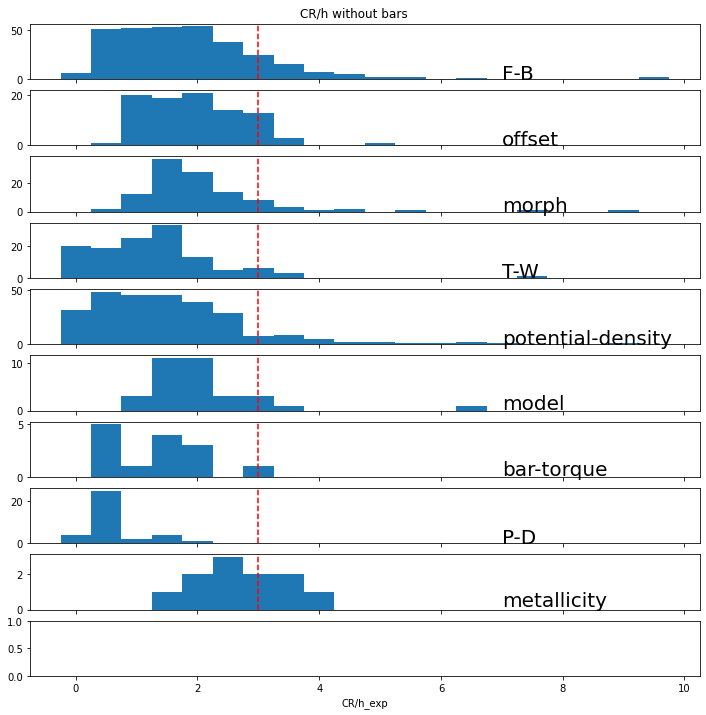

In [254]:
fig, axes = plt.subplots(figsize=[12, 12], nrows=10, sharex=True)
for ind, method in enumerate(props.keys()):
    
    if method == 'rings':
        continue
    
    ax = axes[ind]
    vals = props[method]
#     me, st = np.mean(vals), np.std(vals)
    ax.hist(vals, bins = np.arange(-0.25, 10., 0.5))
#     ax.scatter(me, 0, 100, edgecolor='r', color='none')
#     ax.errorbar(me, 0, xerr=st, color='r')
#     ax.set_yticks([])
    ax.text(7, 0.2, method, fontsize=20)
    ax.axvline(x=3, ls='--', color='r')

plt.suptitle('CR/h without bars', y=0.9)
plt.xlabel('CR/h_exp')
plt.show()

Ок, мб по работам если:

In [256]:
props = {}

for info_ in total_crs:
    
    info = info_[0]
    method = info['name']
    
    if info['method'] == 'spiral' or info['method'] == 'SNs':
        continue
    
    if method not in props.keys():
        props[method] = []
        
    for gal in info['cr'].keys():
        
        try:
            name = info['names_map'][gal]
        except:
            pass
        
        if name not in gal_to_s4g.keys():
            continue
        
        cr_info_ = info['cr'][gal]
        
        h_scale = s4g_to_h[gal_to_s4g[name]]
        
        for cr_info in cr_info_:
            if len(cr_info) == 3:
                cr, cr_r, cr_l = cr_info
            else:
                cr, cr_r = cr_info
                cr_l = cr_r

            # mean end in r25
            prop = cr/h_scale
            
            if np.isfinite(prop):
                props[method].append(prop)

In [257]:
len(props.keys())

23

In [261]:
fig, axes = plt.subplots(figsize=[24, 12], nrows=12, ncols=2, sharex=True)
axes = axes.flatten()
for ind, method in enumerate(props.keys()):
    ax = axes[ind]
    vals = props[method]
    if vals == []:
        continue
    ax.hist(vals, bins = np.arange(-0.25, 10., 0.5))
    ax.text(5, 0.2, method, fontsize=20)
    ax.axvline(x=3, ls='--', color='r')

plt.suptitle('CR/h', y=0.9)
plt.xlabel('CR/h_exp')
plt.xlim(0)
plt.show()

> For sersic they are:
mag, q, P A, n, Re, 

> for expdisk: mag, q, P A, hr, 

> for edgedisk: µ0, P A, hr, hz, 

>for ferrer2: µ0, q, P A, Rbar,
and for psf: mag. Here mag is the total 3.6 µm AB magnitude, µ0 is the central surface brightness in
mag/arcsec2
(face-on brightness for expdisk and edgedisk, sky brightness for ferrers2), Re, hr, hz are in
arcsecs. 


In [19]:
# s4gdf = pd.read_csv('s4g_data.csv', index_col=0)
# s4g_ns = s4gdf['s4g_name'].values
# ns = s4gdf['name'].values

In [20]:
data = []

with open('/mnt/sdb2/science/spirals/CR_Olya/table7.v00', 'r') as inpf:
    lines = inpf.readlines()
    for ind in range(len(s4g_ns)):
        namen = s4g_ns[ind]
        
        add_data = {'name' : ns[ind], 's4g_name' : namen}
        
        for lind, line in enumerate(lines):
            if namen in line:
                ncomps = int(line[line.index('NCOMP=')+6:line.index('NCOMP=')+7])
                
                add_data['NCOMPS'] = ncomps
                
                components = lines[lind+1:lind+ncomps+1]
                
                if namen == 'NGC4548':
                    print(components)
                
                for comp in components:
                    disk = comp.split('|')
                    
                    if 'expdisk' in comp:
                        
                        disk_frac = float(disk[3])
                        m_AB_total = float(disk[4])
                        h_r = float(disk[7])
                        mu_0 = float(disk[8])
                        
                        add_data['disk_frac'] = disk_frac
                        add_data['disk_m_AB_total'] = m_AB_total
                        add_data['h_r'] = h_r
                        add_data['mu_0'] = mu_0
                    
                    if 'sersic' in comp:
                        
                        disk_frac = float(disk[3])
                        m_AB_total = float(disk[4])
                        r_eff = float(disk[7])
                        n = float(disk[8])
                        
                        add_data['bulge_frac'] = disk_frac
                        add_data['bulge_m_AB_total'] = m_AB_total
                        add_data['bulge_r_eff'] = r_eff
                        add_data['bulge_n'] = n
                        
                    if 'ferrer2' in comp:
                        
                        R_bar = float(disk[7])
                        add_data['bar_r'] = R_bar
        data.append(add_data)

['1219|B         |sersic  |0.105  |12.000   |  0.869| 115.781|   5.699|  2.560|\n', '1219|D         |expdisk |0.780  |9.827    |  0.777| -30.803|  55.895| 20.559|\n', '1219|BAR       |ferrer2 |0.114  |20.084   |  0.458|  63.770|  62.250|       |\n']


In [21]:
df = pd.DataFrame(data=data)

In [23]:
df.sample(5)

name s4g_name  NCOMPS  bulge_frac  bulge_m_AB_total  bulge_r_eff  \
182  NGC 5042  NGC5042     2.0       0.163            13.238       24.782   
126  NGC 4245  NGC4245     3.0       0.183            12.592        4.525   
216  NGC 5921  NGC5921     3.0       0.111            13.034        2.275   
56   NGC 2775  NGC2775     3.0       0.125            11.497        7.940   
203  NGC 5430  NGC5430     3.0       0.211            12.953        2.789   

     bulge_n  disk_frac  disk_m_AB_total     h_r    mu_0  bar_r  
182    1.449      0.837           11.460  35.934  21.233    NaN  
126    1.092      0.699           11.135  24.127  20.043  37.50  
216    1.635      0.833           10.840  30.187  20.234  31.50  
56     2.492      0.319           10.326  94.315  22.195    NaN  
203    0.310      0.611           11.795  18.183  20.089  24.75

In [24]:
len(df)

256

In [25]:
df.to_csv('s4g_data.csv')

In [3]:
s4gdf = pd.read_csv('s4g_data.csv', index_col=0)
s4gdf.head()

name s4g_name  NCOMPS  bulge_frac  bulge_m_AB_total  bulge_r_eff  \
0  NGC 0150  NGC0150     3.0       0.996             9.120       75.051   
1  NGC 0157  NGC0157     2.0       0.868            10.949       25.863   
2  NGC 0210  NGC0210     3.0       0.979             9.936       32.264   
3  NGC 0253  NGC0253     2.0       0.495            11.346       54.106   
4  NGC 0289  NGC0289     3.0         NaN               NaN          NaN   

   bulge_n  disk_frac  disk_m_AB_total      h_r    mu_0   bar_r  
0   20.492      0.868           10.949   25.863  20.007  25.863  
1   20.007      0.979            9.936   32.264  19.475     NaN  
2   19.475      0.495           11.346   54.106  22.007  54.106  
3   22.007      0.720            6.502  185.116  19.835     NaN  
4      NaN      0.918           10.599   18.966  18.985  18.966

# Appendix

In [41]:
import numpy as np
from astropy.io import fits

# Read in the DRPall table data
drpall = fits.open('../drpall-v2_4_3.fits')[1].data

In [48]:
drpall['MANGAID']

chararray(['1-404249', '7-18517934', '1-114955', ..., '1-44693',
           '1-44660', '3-25131275'], dtype='<U11')

In [88]:
for _ in drpall[:20]:
    print(_['harname'], _['nsa_iauname'], _['OBJRA'], _['OBJDEC'])

ma087 J125805.61+290102.5 194.523423939 29.0173526307
ma126 -9999 298.03371 27.752152
ma079 J221024.49+114247.0 332.602089837 11.7130772993
ma126 J082738.50+211523.2 126.910629852 21.2568547334
ma126 -9999 77.621562 49.421073
ma087-ma079-ma057 -9999 253.25481 11.392872
ma126 J094648.33+314310.3 146.701429799 31.7195786864
ma126 J081005.48+461134.8 122.522873301 46.1930252145
ma109 J142134.86+402129.1 215.395282581 40.3580862721
ma126 J120908.45+353808.9 182.285219476 35.6358062312
ma079 J153316.60+480710.5 233.319217849 48.119650849
ma109 -9999 290.1385 37.836674
ma126 -9999 194.898779 27.959268
ma079-ma109 -9999 276.66888 3.4531098
ma079 J073047.66+460036.6 112.69868022 46.0101157292
ma057 J030144.50-003528.0 45.43511 -0.59263
ma023-ma057 -9999 288.19595 -1.0336462
ma126-ma079-ma109-ma126-ma023 -9999 258.06986 58.343061
ma023 -9999 240.1989 5.3800656
ma079 J150543.59+442417.7 226.431661417 44.4049023746


In [57]:
for _ in drpall:
    if _[0] == 7495:
        if _[1] == '12704':
            print(_)
#     if '12704' in _:
#         print(_)

(7495, '12704', '7495-12704', '12-129618', 'v2_4_3', 'v2_4_3', 'v1_6_2', 'v5_5_32', 'v2_5', 'MaNGA', 'MaNGA dither', 205.438403156, 27.0047536667, 35.1732317202, 78.8027922109, 205.4384, 27.004754, 0.0122922, 12, 10801.0, 0, 34.9017, 65.3988, 'ma024', 34, '2', 7888, 205.07941, 26.273428, 1.00519, 1.06731, 1.18341, 1.12488, 1.19962, 1.26202, 0.831227, 0.857185, 0.870508, 56746, 56746, 56748, 2.35671, 2.27747, 2.2386, 2.21762, 1050, 0, 0, 12, 'plateTargets-12.par', -1, 'J134145.21+270016.9', 127, 169, 0, 0.0289385, 0.0263391, 0.0363827, 0.0543835, 0.0595132, 0.0241647, 0.037876, 0.67973, 0.653517, 0.281916, 0.303591, -999.0, -999.0, 0.48617, 0.245467, 0.261738, 337, 5087, 6, 'v1_0_1', 484708, 150990, 0.0289385, 0.028884, array([-17.1219, -17.6426, -18.8831, -20.2568, -20.937 , -21.2608,
       -21.4979]), array([-17.1407, -17.6127, -18.8102, -20.1776, -20.7961, -21.0833,
       -21.315 ]), array([  17.8433,  192.908 ,  178.561 , 2464.14  , 2475.54  , 2407.3   ,
        517.371 ]), 295603

In [77]:
d= fits.open('../drpall-v2_4_3.fits')[1]

In [70]:
dir(d)

'PRIMARY'

In [73]:
_['OBJRA'], _['OBJDEC']

(70.32185, 25.525777)

In [82]:
type(drpall)

astropy.io.fits.fitsrec.FITS_rec

In [83]:
?astropy.io.fits.fitsrec.FITS_rec

Object `astropy.io.fits.fitsrec.FITS_rec` not found.


In [181]:
gal = 'NGC 6912'
for method in ALL_METHODS.keys():
    for _ in ALL_METHODS[method]:
        if gal in _['reverse_names_map'].keys():
            name = _['reverse_names_map'][gal]
            crs_ = _['cr'][name]
            print(method, name, crs_, _)

morph NGC6912 [(36.97200000000001, 0)] {'cr': {'NGC157': [(56.23199999999999, 0)], 'NGC598': [(739.2, 0)], 'NGC613': [(88.12799999999999, 0)], 'NGC628': [(141.312, 0)], 'NGC1232': [(123.384, 0)], 'NGC1300': [(100.776, 0)], 'NGC3031': [(462.59999999999997, 0)], 'NGC3938': [(88.77, 0)], 'NGC4254': [(87.156, 0)], 'NGC4321': [(118.33199999999998, 0)], 'NGC5055': [(166.05, 0)], 'NGC5194b': [(131.52, 0)], 'NGC5248': [(102.714, 0)], 'NGC5457': [(330.86999999999995, 0)], 'NGC6912': [(36.97200000000001, 0)], 'NGC6946': [(154.536, 0)], 'NGC7793': [(114.91199999999999, 0)], 'IC342': [(362.7120000000001, 0)]}, 'method': 'morph', 'dist': None, 'links': 'http://articles.adsabs.harvard.edu/pdf/1992ApJS...79...37E', 'name': 'Elmegreen et al. (1992)', 'bands': 'B?', 'kind': 'stellar', 'bar': False, 'names_map': {'NGC157': 'NGC 0157', 'NGC598': 'MESSIER 033', 'NGC613': 'NGC 0613', 'NGC628': 'MESSIER 074', 'NGC1232': 'NGC 1232', 'NGC1300': 'NGC 1300', 'NGC3031': 'MESSIER 081', 'NGC3938': 'NGC 3938', 'NGC

In [185]:
total_crs[15][0]['cr']

{'NGC157': [(56.23199999999999, 0)],
 'NGC598': [(739.2, 0)],
 'NGC613': [(88.12799999999999, 0)],
 'NGC628': [(141.312, 0)],
 'NGC1232': [(123.384, 0)],
 'NGC1300': [(100.776, 0)],
 'NGC3031': [(462.59999999999997, 0)],
 'NGC3938': [(88.77, 0)],
 'NGC4254': [(87.156, 0)],
 'NGC4321': [(118.33199999999998, 0)],
 'NGC5055': [(166.05, 0)],
 'NGC5194b': [(131.52, 0)],
 'NGC5248': [(102.714, 0)],
 'NGC5457': [(330.86999999999995, 0)],
 'NGC6912': [(36.97200000000001, 0)],
 'NGC6946': [(154.536, 0)],
 'NGC7793': [(114.91199999999999, 0)],
 'IC342': [(362.7120000000001, 0)]}

In [184]:
total_crs[16][0]['cr']

{'NGC157': [(56.23199999999999, 0)],
 'NGC598': [(739.2, 0)],
 'NGC613': [(88.12799999999999, 0)],
 'NGC628': [(141.312, 0)],
 'NGC1232': [(123.384, 0)],
 'NGC1300': [(100.776, 0)],
 'NGC3031': [(462.59999999999997, 0)],
 'NGC3938': [(88.77, 0)],
 'NGC4254': [(87.156, 0)],
 'NGC4321': [(118.33199999999998, 0)],
 'NGC5055': [(166.05, 0)],
 'NGC5194b': [(131.52, 0)],
 'NGC5248': [(102.714, 0)],
 'NGC5457': [(330.86999999999995, 0)],
 'NGC6912': [(36.97200000000001, 0)],
 'NGC6946': [(154.536, 0)],
 'NGC7793': [(114.91199999999999, 0)],
 'IC342': [(362.7120000000001, 0)]}

In [10]:
df.sample(10)

name             method    bar     kind       bands  \
416  UGC11012                F-B  False      ISM  Halpha, HI   
320   UGC8490                F-B  False      ISM  Halpha, HI   
135   UGC4165                F-B  False      ISM  Halpha, HI   
196   UGC5414                F-B  False      ISM  Halpha, HI   
665    NGC613  potential-density  False  stellar      H-band   

                                                  link           paper_name  \
416                                                NaN            F-B works   
320                                                NaN            F-B works   
135                                                NaN            F-B works   
196                                                NaN            F-B works   
665  https://iopscience.iop.org/article/10.1088/006...  Buta & Zhang (2009)   

       cr  err_cr_l  err_cr_r  cr_l  cr_r  err_range   altname         r25  
416  21.8       1.8       1.8  20.0  23.6        3.6  NGC 6503  178.287648  
320  19.3       2.1       2.1  17.2  21.4        4.2  NGC 5204  134.933956  
135  16.4       1.2       1.2  15.2  17.6        2.4  NGC 2500   73.981180  
196  77.0       1.3       1.3  75.7  78.3        2.6  NGC 3104   89.561479  
665  88.0       0.0       0.0  88.0  88.0        0.0  NGC 0613  161.480935

In [14]:
df[df['altname']=='NGC 0157']

name             method    bar     kind    bands  \
490    NGC157              morph  False      ISM      HII   
516    NGC157             offset  False      ISM      HII   
646    NGC157  potential-density  False  stellar   H-band   
647    NGC157  potential-density  False  stellar   H-band   
648    NGC157  potential-density  False  stellar   H-band   
1107  NGC0157              morph  False  stellar  optical   
1174   NGC157             offset  False  stellar      B,I   
1186   NGC157              morph  False  stellar       B?   

                                                   link  \
490                                                 NaN   
516                                                 NaN   
646   https://iopscience.iop.org/article/10.1088/006...   
647   https://iopscience.iop.org/article/10.1088/006...   
648   https://iopscience.iop.org/article/10.1088/006...   
1107  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   
1174  http://articles.adsabs.harvard.edu/pdf/1998A%2...   
1186  http://articles.adsabs.harvard.edu/pdf/1992ApJ...   

                        paper_name         cr  err_cr_l  err_cr_r       cr_l  \
490         Williams et al. (1975)  77.349302       0.0       0.0  77.349302   
516              Oey et al. (2003)  55.747245       0.0       0.0  55.747245   
646            Buta & Zhang (2009)   6.400000       0.0       0.0   6.400000   
647            Buta & Zhang (2009)  40.000000       0.0       0.0  40.000000   
648            Buta & Zhang (2009)  72.900000       0.0       0.0  72.900000   
1107  Elmegreen & Elmegreen (1995)  33.600000       2.4       2.4  31.200000   
1174         del Rio & Cepa (1998)  40.000000       0.0       0.0  40.000000   
1186       Elmegreen et al. (1992)  56.232000       0.0       0.0  56.232000   

           cr_r  err_range   altname         r25  
490   77.349302        0.0  NGC 0157  110.948454  
516   55.747245        0.0  NGC 0157  110.948454  
646    6.400000        0.0  NGC 0157  110.948454  
647   40.000000        0.0  NGC 0157  110.948454  
648   72.900000        0.0  NGC 0157  110.948454  
1107  36.000000        4.8  NGC 0157  110.948454  
1174  40.000000        0.0  NGC 0157  110.948454  
1186  56.232000        0.0  NGC 0157  110.948454

In [13]:
df[df['altname']=='NGC 3631']

name method    bar     kind    bands  \
1082  PGC34767  morph  False  stellar  optical   
1135   NGC3631  morph  False  stellar  optical   

                                                   link  \
1082  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   
1135  http://articles.adsabs.harvard.edu/pdf/1995ApJ...   

                        paper_name    cr  err_cr_l  err_cr_r  cr_l  cr_r  \
1082  Elmegreen & Elmegreen (1995)  63.6       5.4       5.4  58.2  69.0   
1135  Elmegreen & Elmegreen (1995)  63.6       5.4       5.4  58.2  69.0   

      err_range   altname         r25  
1082       10.8  NGC 3631  111.460569  
1135       10.8  NGC 3631  111.460569

In [5]:
df[df['name']=='NGC3031']

name       method    bar     kind            bands  \
478   NGC3031       offset  False     both         HI, 24mu   
499   NGC3031        morph  False      ISM              HII   
1192  NGC3031        morph  False  stellar               B?   
1221  NGC3031  metallicity  False  stellar      12+log(O/H)   
1535  NGC3031       offset  False  stellar  B,Spitzer,GALEX   
1536  NGC3031       offset  False  stellar  B,Spitzer,GALEX   

                                                   link  \
478                                                 NaN   
499                                                 NaN   
1192  http://articles.adsabs.harvard.edu/pdf/1992ApJ...   
1221                https://arxiv.org/pdf/1209.5031.pdf   
1535               https://arxiv.org/pdf/2002.02307.pdf   
1536               https://arxiv.org/pdf/2002.02307.pdf   

                   paper_name          cr    err_cr_l    err_cr_r        cr_l  \
478                  Tamburro  500.940000  349.320000  349.320000  151.620000   
499    Williams et al. (1975)  625.240194    0.000000    0.000000  625.240194   
1192  Elmegreen et al. (1992)  462.600000    0.000000    0.000000  462.600000   
1221  Scarano & Lepine (2012)  556.858155  193.195686  193.195686  363.662468   
1535     Abdeen et al. (2020)  375.595143   26.138240   26.138240  349.456903   
1536     Abdeen et al. (2020)  260.814176   45.457809   45.457809  215.356368   

            cr_r   err_range      altname         r25  
478   850.260000  698.640000  MESSIER 081  648.815557  
499   625.240194    0.000000  MESSIER 081  648.815557  
1192  462.600000    0.000000  MESSIER 081  648.815557  
1221  750.053841  386.391373  MESSIER 081  648.815557  
1535  401.733383   52.276480  MESSIER 081  648.815557  
1536  306.271985   90.915617  MESSIER 081  648.815557

In [6]:
df[df['name']=='NGC5194']

name       method    bar     kind            bands  \
485   NGC5194       offset  False     both         HI, 24mu   
508   NGC5194        morph  False      ISM              HII   
1226  NGC5194  metallicity  False  stellar      12+log(O/H)   
1541  NGC5194       offset  False  stellar  B,Spitzer,GALEX   
1542  NGC5194       offset  False  stellar  B,Spitzer,GALEX   

                                      link               paper_name  \
485                                    NaN                 Tamburro   
508                                    NaN   Williams et al. (1975)   
1226   https://arxiv.org/pdf/1209.5031.pdf  Scarano & Lepine (2012)   
1541  https://arxiv.org/pdf/2002.02307.pdf     Abdeen et al. (2020)   
1542  https://arxiv.org/pdf/2002.02307.pdf     Abdeen et al. (2020)   

              cr   err_cr_l   err_cr_r        cr_l        cr_r   err_range  \
485   125.100000  63.900000  63.900000   61.200000  189.000000  127.800000   
508   232.047907   0.000000   0.000000  232.047907  232.047907    0.000000   
1226  157.595582  11.587910  11.587910  146.007672  169.183493   23.175821   
1541  123.063609  22.712305  22.712305  100.351305  145.775914   45.424609   
1542  113.098006  25.956919  25.956919   87.141087  139.054926   51.913839   

           altname     r25  
485   MESSIER 051a  414.11  
508   MESSIER 051a  414.11  
1226  MESSIER 051a  414.11  
1541  MESSIER 051a  414.11  
1542  MESSIER 051a  414.11